In [676]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score
import matplotlib.pyplot as plt
import numpy as np
import itertools
import os
import six
from tqdm import tqdm
from scipy import stats
sns.set_style('darkgrid')
palette =['#5f6366', '#86b3d1','#4d6d9a', '#99ced3', '#edb5bf', '#A599B5']
import math

## Define helper functions

In [677]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                         ylabel='Predicted label',
                         xlabel='True label'):

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel+'\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    return plt

In [678]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

In [679]:
def make_dir_save(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

## Load the Annotations

In [736]:
# CHANGED
df_gt = pd.read_csv('~/Desktop/work/chest_radiography/evaluation_results/custom__drop_Stratified_Patient_ALL_data_resnet_34_28_01_2020_16_32/groundtruth.csv')
#df_gt = pd.read_csv('~/Desktop/work/chest_radiography/evaluation_results/categorized_crp_with_other_labels_resnet34_2021_19_05_12_58/groundtruth.csv')
#df_gt = pd.read_csv('~/Desktop/work/chest_radiography/evaluation_results/lab_crp_in_loss_resnet_34_25_05_2021_15_43/groundtruth.csv')
df_pred = pd.read_csv('~/Desktop/work/chest_radiography/evaluation_results/custom__drop_Stratified_Patient_ALL_data_resnet_34_28_01_2020_16_32/predictions.csv')
#df_pred = pd.read_csv('~/Desktop/work/chest_radiography/evaluation_results/categorized_crp_with_other_labels_resnet34_2021_19_05_12_58/predictions.csv')
#df_pred = pd.read_csv('~/Desktop/work/chest_radiography/evaluation_results/lab_crp_in_loss_resnet_34_25_05_2021_15_43/predictions.csv')
df_schad = pd.read_excel('/home/firas/Desktop/work/chest_radiography/data/radiologist_annotations/Schad_3.xlsx')
df_huck = pd.read_excel('/home/firas/Desktop/work/chest_radiography/data/radiologist_annotations/luisahuck_01 (1).xlsx')
df_pedersoli = pd.read_excel('/home/firas/Desktop/work/chest_radiography/data/radiologist_annotations/Pedersoli.xlsx')
df_barzakova = pd.read_excel('/home/firas/Desktop/work/chest_radiography/data/radiologist_annotations/Barzakova_5.5.xlsx')
df_keil = pd.read_excel('/home/firas/Desktop/work/chest_radiography/data/radiologist_annotations/Keil_17.xlsx')
df_schulzehaagen = pd.read_excel('/home/firas/Desktop/work/chest_radiography/data/radiologist_annotations/schulzehaagen.xlsx')
df_karim_empty = pd.read_excel('/home/firas/Desktop/work/chest_radiography/data/radiologist_annotations/karim_empty 210416.xlsx')
df_karim_prefilled = pd.read_excel('/home/firas/Desktop/work/chest_radiography/data/radiologist_annotations/karim_prefilled 210416.xlsx')
df_lina_empty = pd.read_excel('/home/firas/Desktop/work/chest_radiography/data/radiologist_annotations/lina_empty.xlsx')
df_lina_prefilled = pd.read_excel('/home/firas/Desktop/work/chest_radiography/data/radiologist_annotations/lina_prefilled.xlsx')
df_neural_network_prefilled = pd.read_excel('/home/firas/Desktop/work/chest_radiography/data/radiologist_annotations/neural_network_prefilled.xlsx')
df_one_hot_stauung = pd.read_csv('~/Desktop/work/chest_radiography/evaluation_results/one_hot_stauung_resnet_34_17_03_2021_12_30/predictions.csv')
df_rank_consistency_stauung = pd.read_csv('~/Desktop/work/chest_radiography/evaluation_results/rank_consistency_stauung_resnet34_2021_03_24_15_44/predictions.csv')

### Adapt the annotation names to a common standard

In [737]:
# Standard labels
for standard_label in ['Stauung', 'Pleuraerguss_re', 'Pleuraerguss_li', 'Infiltrate_re', 'Infiltrate_li', 'Belstörungen_re', 'Belstörungen_li']:
    df_pred[standard_label] = df_pred[standard_label].replace({1: 'kein', 2: '+', 3: '++', 4: '+++', 5: '(+)'})
    df_gt[standard_label] = df_gt[standard_label].replace({1: 'kein', 2: '+', 3: '++', 4: '+++', 5: '(+)'})

# Herzgröße
df_pred['Herzgröße'] = df_pred['Herzgröße'].replace({1: 'normal', 2: 'grenzwertig', 3: 'vergrößert', 4: 'massiv vergrößert', 5: 'nicht beurteilbar'})
df_gt['Herzgröße'] = df_gt['Herzgröße'].replace({1: 'normal', 2: 'grenzwertig', 3: 'vergrößert', 4: 'massiv vergrößert', 5: 'nicht beurteilbar'})

# Pneumothorax
df_pred['Pneumothorax_re'] = df_pred['Pneumothorax_re'].replace({1: 'kein', 2: 'spitze', 3: 'mantel', 4: 'basal', 5: 'gering', 6: 'erheblich', 7: 'spannung'})
df_gt['Pneumothorax_re'] = df_gt['Pneumothorax_re'].replace({1: 'kein', 2: 'spitze', 3: 'mantel', 4: 'basal', 5: 'gering', 6: 'erheblich', 7: 'spannung'})

df_pred['Pneumothorax_li'] = df_pred['Pneumothorax_li'].replace({1: 'kein', 2: 'spitze', 3: 'mantel', 4: 'basal', 5: 'gering', 6: 'erheblich', 7: 'spannung'})
df_gt['Pneumothorax_li'] = df_gt['Pneumothorax_li'].replace({1: 'kein', 2: 'spitze', 3: 'mantel', 4: 'basal', 5: 'gering', 6: 'erheblich', 7: 'spannung'})

# Custom training sets
df_rank_consistency_stauung['Stauung'] = df_rank_consistency_stauung['Stauung'].replace({1: 'kein', 2: '(+)', 3: '+', 4: '++', 5: '+++'})
df_one_hot_stauung['Stauung'] = df_one_hot_stauung['Stauung'].replace({1: 'kein', 2: '(+)', 3: '+', 4: '++', 5: '+++'})

In [738]:
# Rename the column names to match the radiologists names
df_pred = df_pred.rename(columns={'AcquisitionNumber': 'Anforderungsnummer', 'Pleuraerguss_li': 'Erguss_li', 'Pleuraerguss_re': 'Erguss_re', 'Belstörungen_re': 'Bel.-Störungen_re', 'Belstörungen_li': 'Bel.-störungen_li' })
df_gt = df_gt.rename(columns={'AcquisitionNumber': 'Anforderungsnummer', 'Pleuraerguss_li': 'Erguss_li', 'Pleuraerguss_re': 'Erguss_re', 'Belstörungen_re': 'Bel.-Störungen_re', 'Belstörungen_li': 'Bel.-störungen_li' })
df_one_hot_stauung = df_one_hot_stauung.rename(columns={'AcquisitionNumber': 'Anforderungsnummer'})
df_rank_consistency_stauung = df_rank_consistency_stauung.rename(columns={'AcquisitionNumber': 'Anforderungsnummer'})

### Only take the StudyIDs that match the ones the radiologists annotated

In [739]:
df_pred_rad = df_pred[df_pred['Anforderungsnummer'].isin(df_huck['Anforderungsnummer'])]
df_gt_rad = df_gt[df_gt['Anforderungsnummer'].isin(df_huck['Anforderungsnummer'])]
df_one_hot_stauung_rad = df_one_hot_stauung[df_one_hot_stauung['Anforderungsnummer'].isin(df_huck['Anforderungsnummer'])]
df_rank_consistency_stauung_rad = df_rank_consistency_stauung[df_rank_consistency_stauung['Anforderungsnummer'].isin(df_huck['Anforderungsnummer'])]

### Sort the indices

In [740]:
df_schad = df_schad.set_index('Anforderungsnummer').sort_index()
df_huck = df_huck.set_index('Anforderungsnummer').sort_index()
df_pedersoli = df_pedersoli.set_index('Anforderungsnummer').sort_index()
df_barzakova = df_barzakova.set_index('Anforderungsnummer').sort_index()
df_keil = df_keil.set_index('Anforderungsnummer').sort_index()
df_schulzehaagen = df_schulzehaagen.set_index('Anforderungsnummer').sort_index()
df_karim_empty = df_karim_empty.set_index('Anforderungsnummer').sort_index()
df_karim_prefilled = df_karim_prefilled.set_index('Anforderungsnummer').sort_index()
df_lina_empty = df_lina_empty.set_index('Anforderungsnummer').sort_index()
df_lina_prefilled = df_lina_prefilled.set_index('Anforderungsnummer').sort_index()
df_neural_network_prefilled = df_neural_network_prefilled.set_index('Anforderungsnummer').sort_index()
df_pred_rad = df_pred_rad.set_index('Anforderungsnummer').sort_index()
df_gt_rad = df_gt_rad.set_index('Anforderungsnummer').sort_index()
df_one_hot_stauung_rad = df_one_hot_stauung_rad.set_index('Anforderungsnummer').sort_index()
df_rank_consistency_stauung_rad = df_rank_consistency_stauung_rad.set_index('Anforderungsnummer').sort_index()

### Pedersoli annotated the heart wrongfuly - Correct what he has done wrong

In [741]:
df_pedersoli['Herzgröße'] = df_pedersoli['Herzgröße'].replace({'kein': 'normal', '(+)': 'grenzwertig', '+': 'vergrößert', '++': 'massiv vergrößert', '+++': 'massiv vergrößert'})

### Karim didn't annotate the Pneumothorax. Replace NaN with kein

In [742]:
df_karim_empty['Pneumothorax_re'] = df_karim_empty['Pneumothorax_re'].fillna('kein')
df_karim_empty['Pneumothorax_li'] = df_karim_empty['Pneumothorax_li'].fillna('kein')

# Compare the results

In [743]:
root_directory = '/home/firas/Desktop/work/chest_radiography/evaluation_results/custom__drop_Stratified_Patient_ALL_data_resnet_34_28_01_2020_16_32/notebook_evaluation'

### How many cells has karim corrected

In [744]:
df_neural_network_prefilled_selected_columns = df_neural_network_prefilled.loc[:, ['Herzgröße', 'Erguss_li', 'Erguss_re', 'Infiltrate_li', 'Infiltrate_re', 
                       'Stauung', 'Bel.-störungen_li', 'Bel.-Störungen_re']]
df_karim_prefilled_selected_columns = df_karim_prefilled.loc[:, ['Herzgröße', 'Erguss_li', 'Erguss_re', 'Infiltrate_li', 'Infiltrate_re', 
                       'Stauung', 'Bel.-störungen_li', 'Bel.-Störungen_re']]
df_prefilled_karim_nn_differences = (df_neural_network_prefilled_selected_columns == df_karim_prefilled_selected_columns)

In [745]:
total = 0
corrected = 0
for col in df_prefilled_karim_nn_differences:
    print(df_prefilled_karim_nn_differences[col].value_counts())
    total += len(df_prefilled_karim_nn_differences[col])
    corrected += len(df_prefilled_karim_nn_differences[df_prefilled_karim_nn_differences[col]==False])
print(total)
print(corrected)
print("Karim has corrected: " + str(corrected/total * 100) + "%")

True     81
False    19
Name: Herzgröße, dtype: int64
True     92
False     8
Name: Erguss_li, dtype: int64
True     94
False     6
Name: Erguss_re, dtype: int64
True     97
False     3
Name: Infiltrate_li, dtype: int64
True     93
False     7
Name: Infiltrate_re, dtype: int64
True     79
False    21
Name: Stauung, dtype: int64
True     99
False     1
Name: Bel.-störungen_li, dtype: int64
True     93
False     7
Name: Bel.-Störungen_re, dtype: int64
800
72
Karim has corrected: 9.0%


### MSE using One-Hot vs Rank Consistency

In [746]:
# One-Hot
print("MSE: ", ((df_one_hot_stauung_rad['Stauung'].replace({'kein': 0, '(+)': 1, '+': 2, '++': 3, '+++': 4}) - df_gt_rad['Stauung'].replace({'kein': 0, '(+)': 1, '+': 2, '++': 3, '+++': 4}))**2).mean())
print("MAE: ", ((df_one_hot_stauung_rad['Stauung'].replace({'kein': 0, '(+)': 1, '+': 2, '++': 3, '+++': 4}) - df_gt_rad['Stauung'].replace({'kein': 0, '(+)': 1, '+': 2, '++': 3, '+++': 4})).abs()).mean())

MSE:  1.24
MAE:  0.66


In [747]:
# Rank-Consistency
print("MSE: ", ((df_rank_consistency_stauung_rad['Stauung'].replace({'kein': 0, '(+)': 1, '+': 2, '++': 3, '+++': 4}) - df_gt_rad['Stauung'].replace({'kein': 0, '(+)': 1, '+': 2, '++': 3, '+++': 4}))**2).mean())
print("MAE: ", ((df_rank_consistency_stauung_rad['Stauung'].replace({'kein': 0, '(+)': 1, '+': 2, '++': 3, '+++': 4}) - df_gt_rad['Stauung'].replace({'kein': 0, '(+)': 1, '+': 2, '++': 3, '+++': 4})).abs()).mean())

MSE:  0.96
MAE:  0.64


### Cohens Kappa

In [748]:
dir_cohens_kappa_all_vs_all = os.path.join(root_directory, 'cohens_kappa_all_vs_all')
make_dir_save(dir_cohens_kappa_all_vs_all)

In [749]:
columns_of_interest = ['Herzgröße', 'Erguss_li', 'Erguss_re', 'Infiltrate_li', 'Infiltrate_re', 
                       'Stauung', 'Bel.-störungen_li', 'Bel.-Störungen_re', 'Pneumothorax_li', 'Pneumothorax_re'] 
challengers = {'Prediction': df_pred_rad, 'Groundtruth': df_gt_rad, 'Huck': df_huck, 'Schad': df_schad, 'Pedersoli': df_pedersoli, 'Barzakova': df_barzakova, 'Keil': df_keil, 'SchulzeHaagen': df_schulzehaagen, 'karim_empty': df_karim_empty, 'karim_prefilled': df_karim_prefilled, 'lina_empty': df_lina_empty, 'lina_prefilled': df_lina_prefilled}

standard_labels = ['kein', '(+)', '+', '++', '+++'] # Stauung, Erguss, Infiltrate, Bel-stärungen
herzgröße_labels = ['nicht beurteilbar', 'normal', 'grenzwertig', 'vergrößert', 'massiv vergrößert']
pneumothorax_labels = ['kein', 'spitze', 'mantel', 'basal', 'gering', 'erheblich', 'spannung']

### Change the labels to english language

In [21]:
### RANK CONSISTENCY

columns_of_interest = ['Pulmonary Congestion'] 
challengers = {'NN': df_pred_rad, 'RR': df_gt_rad, 'R1': df_huck, 'R2': df_schad, 'R3': df_pedersoli, 'R4': df_barzakova, 'R5': df_keil, 'R6': df_schulzehaagen, 'NON-R1': df_karim_empty, 'NON-R1+AI': df_karim_prefilled, 'NN Congestion (one hot)': df_one_hot_stauung_rad, 'NN Congestion (rank-consistency)': df_rank_consistency_stauung_rad}

# Change the actual language in the dataframes
for key, value in challengers.items():
    # Standard labels
    for standard_label in ['Stauung']:
        challengers[key][standard_label] = challengers[key][standard_label].replace({'kein': 'none'})
  
    challengers[key] = challengers[key].rename(columns= {'Stauung': 'Pulmonary Congestion'})
    

standard_labels = ['none', '(+)', '+', '++', '+++'] # Stauung, Erguss, Infiltrate, Bel-stärungen
herzgröße_labels = ['not assessable', 'normal', 'borderline', 'enlarged', 'massively enlarged']
pneumothorax_labels = ['none', 'apex', 'mantle', 'basal', 'minor', 'considerable', 'tension']

In [750]:
columns_of_interest = ['Cardiomegaly', 'Pleural Effusion (left)', 'Pleural Effusion (right)', 'Pulmonary Infiltrates (left)', 'Pulmonary Infiltrates (right)', 
                       'Pulmonary Congestion', 'Atelectasis (left)', 'Atelectasis (right)'] 
challengers = {'NN': df_pred_rad, 'RR': df_gt_rad, 'R1': df_huck, 'R2': df_schad, 'R3': df_pedersoli, 'R4': df_barzakova, 'R5': df_keil, 'R6': df_schulzehaagen, 'NON-R1': df_karim_empty, 'NON-R1+AI': df_karim_prefilled, 'NON-R2': df_lina_empty, 'NON-R2+AI': df_lina_prefilled}

# Change the actual language in the dataframes
for key, value in challengers.items():
    # Standard labels
    for standard_label in ['Stauung', 'Erguss_re', 'Erguss_li', 'Infiltrate_re', 'Infiltrate_li', 'Bel.-Störungen_re', 'Bel.-störungen_li']:
        challengers[key][standard_label] = challengers[key][standard_label].replace({'kein': 'none'})

    # Herzgröße
    challengers[key]['Herzgröße'] = challengers[key]['Herzgröße'].replace({'normal': 'normal', 'grenzwertig': 'borderline', 'vergrößert': 'enlarged', 'massiv vergrößert': 'massively enlarged', 'nicht beurteilbar': 'not assessable'})
    
    # lowercase the pneumothorax annotations because some are capitalized in the radiologist labels
    challengers[key]['Pneumothorax_re'] = challengers[key]['Pneumothorax_re'].str.lower()
    challengers[key]['Pneumothorax_li'] = challengers[key]['Pneumothorax_li'].str.lower()
    
    # Pneumothorax
    challengers[key]['Pneumothorax_re'] = challengers[key]['Pneumothorax_re'].replace({'kein': 'none', 'spitze': 'apex', 'mantel': 'mantle', 'basal': 'basal', 'gering': 'minor', 'erheblich': 'considerable', 'spannung': 'tension'})
    challengers[key]['Pneumothorax_li'] = challengers[key]['Pneumothorax_li'].replace({'kein': 'none', 'spitze': 'apex', 'mantel': 'mantle', 'basal': 'basal', 'gering': 'minor', 'erheblich': 'considerable', 'spannung': 'tension'})

    challengers[key] = challengers[key].rename(columns= {'Herzgröße': 'Cardiomegaly', 'Erguss_li': 'Pleural Effusion (left)', 'Erguss_re': 'Pleural Effusion (right)', 'Infiltrate_li': 'Pulmonary Infiltrates (left)', 'Infiltrate_re': 'Pulmonary Infiltrates (right)', 
                       'Stauung': 'Pulmonary Congestion', 'Bel.-störungen_li': 'Atelectasis (left)', 'Bel.-Störungen_re': 'Atelectasis (right)'})
    

standard_labels = ['none', '(+)', '+', '++', '+++'] # Stauung, Erguss, Infiltrate, Bel-stärungen
herzgröße_labels = ['not assessable', 'normal', 'borderline', 'enlarged', 'massively enlarged']
pneumothorax_labels = ['none', 'apex', 'mantle', 'basal', 'minor', 'considerable', 'tension']

-------------------------------------------------------------------------------
Cardiomegaly


NN        RR        R1        R2        R3        R4  \
NN                1  0.382498  0.471831   0.34551  0.257466  0.425887   
RR         0.382498         1  0.587595  0.326205  0.333127  0.314523   
R1         0.471831  0.587595         1   0.41529  0.378013  0.350341   
R2          0.34551  0.326205   0.41529         1  0.337931  0.493897   
R3         0.257466  0.333127  0.378013  0.337931         1  0.200343   
R4         0.425887  0.314523  0.350341  0.493897  0.200343         1   
R5         0.382607  0.348428  0.349593  0.374363  0.291742  0.365441   
R6         0.339141  0.369779  0.472373  0.471635  0.287212  0.382716   
NON-R1     0.429339  0.427845   0.53939  0.377443   0.28952  0.376461   
NON-R1+AI  0.672583  0.449571   0.51472  0.430989  0.246648  0.444709   
NON-R2     0.419243  0.364311  0.501058  0.344356  0.316239  0.354451   
NON-R2+AI   0.77872  0.324324   0.52854  0.396318  0.262673  0.434835   

                 R5        R6    NON-R1 NON-R1+AI    NON-R2 NON-R2+AI  
NN         0.382607  0.339141  0.429339  0.672583  0.419243   0.77872  
RR         0.348428  0.369779  0.427845  0.449571  0.364311  0.324324  
R1         0.349593  0.472373   0.53939   0.51472  0.501058   0.52854  
R2         0.374363  0.471635  0.377443  0.430989  0.344356  0.396318  
R3         0.291742  0.287212   0.28952  0.246648  0.316239  0.262673  
R4         0.365441  0.382716  0.376461  0.444709  0.354451  0.434835  
R5                1   0.38307  0.479741  0.453376  0.363811  0.460189  
R6          0.38307         1  0.492239  0.358507  0.441821  0.376392  
NON-R1     0.479741  0.492239         1   0.63808  0.478157  0.462541  
NON-R1+AI  0.453376  0.358507   0.63808         1  0.534185  0.600865  
NON-R2     0.363811  0.441821  0.478157  0.534185         1  0.503722  
NON-R2+AI  0.460189  0.376392  0.462541  0.600865  0.503722         1

-------------------------------------------------------------------------------
Pleural Effusion (left)


NN        RR        R1        R2        R3        R4  \
NN                1  0.548736  0.505388   0.53629  0.416652  0.526784   
RR         0.548736         1  0.530044  0.467695  0.427031  0.522124   
R1         0.505388  0.530044         1  0.514999  0.550524  0.565897   
R2          0.53629  0.467695  0.514999         1  0.415826  0.592944   
R3         0.416652  0.427031  0.550524  0.415826         1  0.542576   
R4         0.526784  0.522124  0.565897  0.592944  0.542576         1   
R5          0.57676  0.439624  0.469027  0.536142   0.56044  0.620637   
R6          0.52048  0.472151  0.590091  0.637758  0.423279  0.558711   
NON-R1     0.512605  0.466019  0.381149  0.299624  0.305556  0.376231   
NON-R1+AI  0.850579  0.527311  0.468814  0.499808  0.440488  0.491464   
NON-R2     0.501868  0.461461  0.438851  0.394829  0.321924  0.446367   
NON-R2+AI  0.820917  0.507473  0.533333  0.489051  0.484707  0.526648   

                 R5        R6    NON-R1 NON-R1+AI    NON-R2 NON-R2+AI  
NN          0.57676   0.52048  0.512605  0.850579  0.501868  0.820917  
RR         0.439624  0.472151  0.466019  0.527311  0.461461  0.507473  
R1         0.469027  0.590091  0.381149  0.468814  0.438851  0.533333  
R2         0.536142  0.637758  0.299624  0.499808  0.394829  0.489051  
R3          0.56044  0.423279  0.305556  0.440488  0.321924  0.484707  
R4         0.620637  0.558711  0.376231  0.491464  0.446367  0.526648  
R5                1   0.50495  0.422061  0.540441   0.44483  0.607703  
R6          0.50495         1  0.301771  0.465036  0.525027  0.565217  
NON-R1     0.422061  0.301771         1  0.600533  0.461488  0.514249  
NON-R1+AI  0.540441  0.465036  0.600533         1  0.547511  0.773519  
NON-R2      0.44483  0.525027  0.461488  0.547511         1  0.579973  
NON-R2+AI  0.607703  0.565217  0.514249  0.773519  0.579973         1

-------------------------------------------------------------------------------
Pleural Effusion (right)


NN        RR        R1        R2        R3        R4  \
NN                1    0.5086  0.488434  0.622463  0.517019  0.691517   
RR           0.5086         1  0.525382  0.457701  0.374609  0.516575   
R1         0.488434  0.525382         1  0.419768  0.490596  0.535669   
R2         0.622463  0.457701  0.419768         1  0.571341  0.577308   
R3         0.517019  0.374609  0.490596  0.571341         1  0.520593   
R4         0.691517  0.516575  0.535669  0.577308  0.520593         1   
R5         0.596774  0.406402  0.360512  0.544796  0.444444  0.468203   
R6         0.723451  0.429422   0.44543  0.551146  0.455041   0.54023   
NON-R1     0.618944  0.627976  0.360952  0.413421   0.37486  0.546599   
NON-R1+AI  0.839572   0.51784  0.456994  0.562716  0.489796  0.628345   
NON-R2     0.605019  0.459927  0.482896  0.461363  0.379504  0.541184   
NON-R2+AI  0.870801  0.583333  0.512505  0.576366  0.499456   0.68795   

                 R5        R6    NON-R1 NON-R1+AI    NON-R2 NON-R2+AI  
NN         0.596774  0.723451  0.618944  0.839572  0.605019  0.870801  
RR         0.406402  0.429422  0.627976   0.51784  0.459927  0.583333  
R1         0.360512   0.44543  0.360952  0.456994  0.482896  0.512505  
R2         0.544796  0.551146  0.413421  0.562716  0.461363  0.576366  
R3         0.444444  0.455041   0.37486  0.489796  0.379504  0.499456  
R4         0.468203   0.54023  0.546599  0.628345  0.541184   0.68795  
R5                1  0.449289   0.41481  0.525745  0.523415  0.550259  
R6         0.449289         1  0.584372  0.731472  0.465365  0.641852  
NON-R1      0.41481  0.584372         1   0.70651  0.465986  0.646286  
NON-R1+AI  0.525745  0.731472   0.70651         1  0.545041  0.776119  
NON-R2     0.523415  0.465365  0.465986  0.545041         1  0.624475  
NON-R2+AI  0.550259  0.641852  0.646286  0.776119  0.624475         1

-------------------------------------------------------------------------------
Pulmonary Infiltrates (left)


NN        RR        R1        R2        R3        R4  \
NN                1  0.387755  0.488578  0.625468  0.577411  0.577018   
RR         0.387755         1  0.651365  0.501558  0.366286  0.374255   
R1         0.488578  0.651365         1  0.499687  0.364676  0.401914   
R2         0.625468  0.501558  0.499687         1  0.481865  0.580103   
R3         0.577411  0.366286  0.364676  0.481865         1  0.475925   
R4         0.577018  0.374255  0.401914  0.580103  0.475925         1   
R5          0.29287  0.164927  0.212598  0.355742   0.35502  0.268689   
R6         0.497645  0.319172  0.372099   0.44687  0.498377  0.384443   
NON-R1     0.391234  0.307844  0.274885  0.390463  0.335793   0.39045   
NON-R1+AI  0.872935  0.388171  0.523161  0.626168  0.578059  0.507216   
NON-R2     0.399791    0.2891  0.361551  0.409884  0.276086  0.354067   
NON-R2+AI  0.918066  0.335989  0.434276  0.563001  0.589858  0.518735   

                 R5        R6    NON-R1 NON-R1+AI    NON-R2 NON-R2+AI  
NN          0.29287  0.497645  0.391234  0.872935  0.399791  0.918066  
RR         0.164927  0.319172  0.307844  0.388171    0.2891  0.335989  
R1         0.212598  0.372099  0.274885  0.523161  0.361551  0.434276  
R2         0.355742   0.44687  0.390463  0.626168  0.409884  0.563001  
R3          0.35502  0.498377  0.335793  0.578059  0.276086  0.589858  
R4         0.268689  0.384443   0.39045  0.507216  0.354067  0.518735  
R5                1  0.251497  0.178935  0.292453  0.277583  0.331784  
R6         0.251497         1  0.269629  0.560853  0.367946  0.569628  
NON-R1     0.178935  0.269629         1  0.472617  0.299974   0.37181  
NON-R1+AI  0.292453  0.560853  0.472617         1  0.397433   0.87725  
NON-R2     0.277583  0.367946  0.299974  0.397433         1  0.406911  
NON-R2+AI  0.331784  0.569628   0.37181   0.87725  0.406911         1

-------------------------------------------------------------------------------
Pulmonary Infiltrates (right)


NN        RR        R1        R2        R3        R4  \
NN                1  0.316149  0.373508   0.59772  0.410487  0.553714   
RR         0.316149         1   0.72312  0.358974  0.286564  0.442289   
R1         0.373508   0.72312         1  0.366566  0.374837  0.362211   
R2          0.59772  0.358974  0.366566         1  0.456366  0.590044   
R3         0.410487  0.286564  0.374837  0.456366         1   0.36341   
R4         0.553714  0.442289  0.362211  0.590044   0.36341         1   
R5            0.328  0.209095  0.226873  0.415376  0.329047  0.424957   
R6         0.459459  0.280909  0.337073  0.389398  0.422421  0.383708   
NON-R1     0.467085  0.285204  0.285336  0.367634  0.295584   0.33518   
NON-R1+AI  0.768824  0.288693  0.340297  0.518942  0.464638  0.509663   
NON-R2     0.435998  0.360693  0.339789  0.351251  0.216301  0.316473   
NON-R2+AI  0.894143  0.309286  0.369628  0.521836  0.434355  0.602689   

                 R5        R6    NON-R1 NON-R1+AI    NON-R2 NON-R2+AI  
NN            0.328  0.459459  0.467085  0.768824  0.435998  0.894143  
RR         0.209095  0.280909  0.285204  0.288693  0.360693  0.309286  
R1         0.226873  0.337073  0.285336  0.340297  0.339789  0.369628  
R2         0.415376  0.389398  0.367634  0.518942  0.351251  0.521836  
R3         0.329047  0.422421  0.295584  0.464638  0.216301  0.434355  
R4         0.424957  0.383708   0.33518  0.509663  0.316473  0.602689  
R5                1  0.299946   0.19265  0.334298  0.331027  0.413942  
R6         0.299946         1  0.338274  0.505087  0.406593  0.538639  
NON-R1      0.19265  0.338274         1  0.539833  0.363636  0.489489  
NON-R1+AI  0.334298  0.505087  0.539833         1  0.533908  0.779528  
NON-R2     0.331027  0.406593  0.363636  0.533908         1  0.521302  
NON-R2+AI  0.413942  0.538639  0.489489  0.779528  0.521302         1

-------------------------------------------------------------------------------
Pulmonary Congestion


NN        RR        R1        R2        R3        R4  \
NN                1  0.367546  0.543651  0.201041   0.39759  0.283403   
RR         0.367546         1  0.483115  0.237653  0.339243  0.254872   
R1         0.543651  0.483115         1  0.380531  0.405873  0.228845   
R2         0.201041  0.237653  0.380531         1  0.281633  0.320652   
R3          0.39759  0.339243  0.405873  0.281633         1  0.291441   
R4         0.283403  0.254872  0.228845  0.320652  0.291441         1   
R5         0.378882  0.202522  0.389996  0.355328  0.363521  0.478908   
R6         0.256198  0.167257  0.324846  0.419448  0.389819  0.398396   
NON-R1     0.253959  0.316065   0.24812  0.161518   0.34631  0.127106   
NON-R1+AI  0.635985  0.207733  0.395466  0.210187  0.431908  0.304813   
NON-R2     0.367499  0.207559  0.321124  0.262899  0.332828   0.19409   
NON-R2+AI  0.734802  0.348362  0.523446  0.227175  0.410336  0.292035   

                 R5        R6    NON-R1 NON-R1+AI    NON-R2 NON-R2+AI  
NN         0.378882  0.256198  0.253959  0.635985  0.367499  0.734802  
RR         0.202522  0.167257  0.316065  0.207733  0.207559  0.348362  
R1         0.389996  0.324846   0.24812  0.395466  0.321124  0.523446  
R2         0.355328  0.419448  0.161518  0.210187  0.262899  0.227175  
R3         0.363521  0.389819   0.34631  0.431908  0.332828  0.410336  
R4         0.478908  0.398396  0.127106  0.304813   0.19409  0.292035  
R5                1  0.378216  0.187864  0.311319  0.206087  0.426752  
R6         0.378216         1  0.182314  0.315303  0.259974  0.285147  
NON-R1     0.187864  0.182314         1  0.354555  0.300999  0.245852  
NON-R1+AI  0.311319  0.315303  0.354555         1  0.440242   0.52381  
NON-R2     0.206087  0.259974  0.300999  0.440242         1  0.358151  
NON-R2+AI  0.426752  0.285147  0.245852   0.52381  0.358151         1

-------------------------------------------------------------------------------
Atelectasis (left)


NN        RR        R1        R2        R3        R4  \
NN                1  0.347708  0.594993  0.352807  0.409343  0.480969   
RR         0.347708         1  0.627594  0.476705  0.437628  0.399399   
R1         0.594993  0.627594         1  0.351204  0.498183  0.450133   
R2         0.352807  0.476705  0.351204         1  0.329084  0.398443   
R3         0.409343  0.437628  0.498183  0.329084         1  0.285714   
R4         0.480969  0.399399  0.450133  0.398443  0.285714         1   
R5         0.553398  0.394495   0.53271   0.39823  0.431193  0.346154   
R6         0.458955  0.291038  0.394051  0.287576  0.347191  0.472188   
NON-R1      0.20977  0.206492  0.240506  0.164299  0.180196  0.210414   
NON-R1+AI  0.981182  0.353448  0.598687  0.358085  0.413646  0.468489   
NON-R2     0.284842  0.274611  0.287824  0.214145   0.16291  0.210324   
NON-R2+AI  0.866794  0.291424   0.53866  0.299475  0.427959  0.380325   

                 R5        R6    NON-R1 NON-R1+AI    NON-R2 NON-R2+AI  
NN         0.553398  0.458955   0.20977  0.981182  0.284842  0.866794  
RR         0.394495  0.291038  0.206492  0.353448  0.274611  0.291424  
R1          0.53271  0.394051  0.240506  0.598687  0.287824   0.53866  
R2          0.39823  0.287576  0.164299  0.358085  0.214145  0.299475  
R3         0.431193  0.347191  0.180196  0.413646   0.16291  0.427959  
R4         0.346154  0.472188  0.210414  0.468489  0.210324  0.380325  
R5                1  0.271028  0.274336  0.557692  0.130435  0.495146  
R6         0.271028         1  0.144449  0.446699  0.246185  0.399512  
NON-R1     0.274336  0.144449         1  0.218472   0.29287  0.273915  
NON-R1+AI  0.557692  0.446699  0.218472         1  0.308437  0.868124  
NON-R2     0.130435  0.246185   0.29287  0.308437         1  0.297753  
NON-R2+AI  0.495146  0.399512  0.273915  0.868124  0.297753         1

-------------------------------------------------------------------------------
Atelectasis (right)


NN        RR        R1        R2        R3        R4  \
NN                1  0.455706  0.626572  0.455338  0.462151  0.598309   
RR         0.455706         1  0.520295  0.414802  0.255398  0.430815   
R1         0.626572  0.520295         1  0.517857  0.429359    0.6054   
R2         0.455338  0.414802  0.517857         1  0.347116  0.381559   
R3         0.462151  0.255398  0.429359  0.347116         1  0.472907   
R4         0.598309  0.430815    0.6054  0.381559  0.472907         1   
R5         0.527721  0.424736  0.558676  0.394051  0.391851  0.586867   
R6         0.550102  0.313894  0.432279  0.376147  0.338159  0.517755   
NON-R1     0.259808  0.275362  0.240459  0.171177  0.154453  0.310481   
NON-R1+AI   0.86631  0.421338  0.550141  0.407459  0.394856  0.559736   
NON-R2     0.416058  0.337517  0.336442  0.208754  0.169675  0.335359   
NON-R2+AI  0.880952  0.460565  0.631497  0.459654  0.430926  0.604496   

                 R5        R6    NON-R1 NON-R1+AI    NON-R2 NON-R2+AI  
NN         0.527721  0.550102  0.259808   0.86631  0.416058  0.880952  
RR         0.424736  0.313894  0.275362  0.421338  0.337517  0.460565  
R1         0.558676  0.432279  0.240459  0.550141  0.336442  0.631497  
R2         0.394051  0.376147  0.171177  0.407459  0.208754  0.459654  
R3         0.391851  0.338159  0.154453  0.394856  0.169675  0.430926  
R4         0.586867  0.517755  0.310481  0.559736  0.335359  0.604496  
R5                1  0.394193  0.189597  0.550518  0.291837    0.5329  
R6         0.394193         1  0.275646  0.496124  0.299668  0.518072  
NON-R1     0.189597  0.275646         1  0.338577  0.345279  0.344978  
NON-R1+AI  0.550518  0.496124  0.338577         1  0.452297  0.829674  
NON-R2     0.291837  0.299668  0.345279  0.452297         1   0.42029  
NON-R2+AI    0.5329  0.518072  0.344978  0.829674   0.42029         1

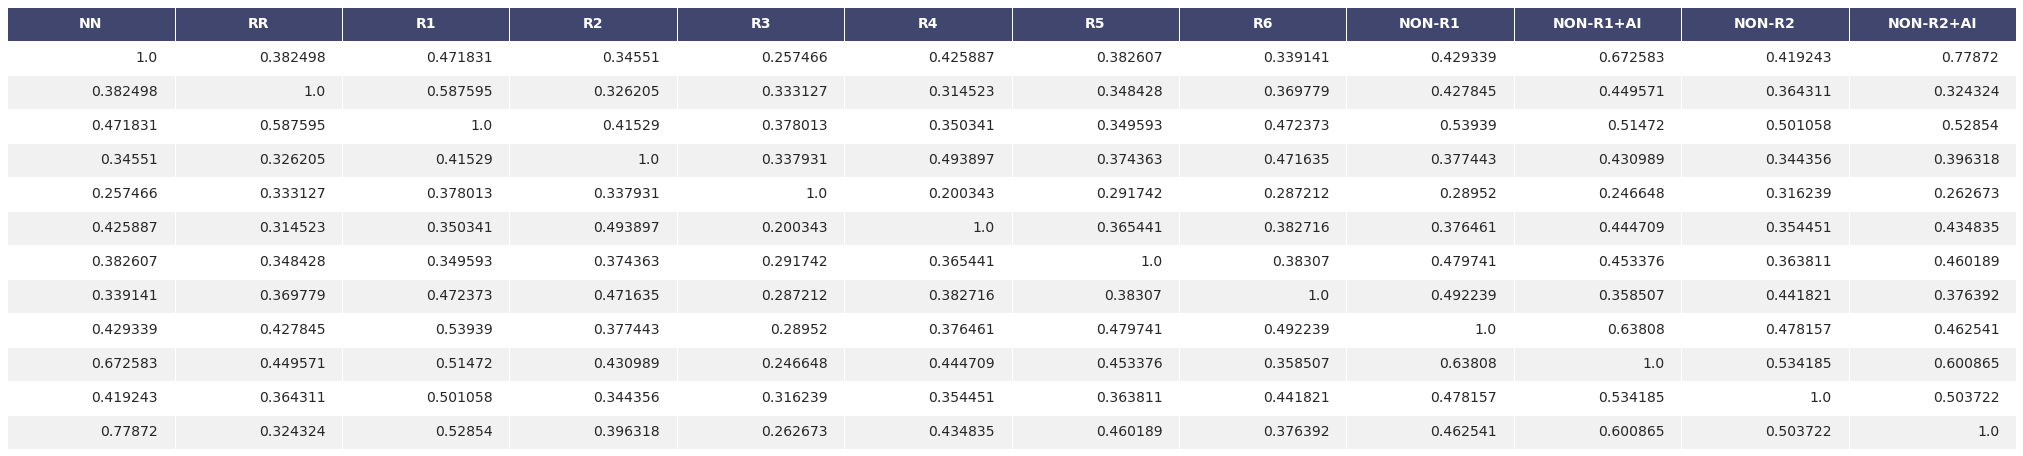

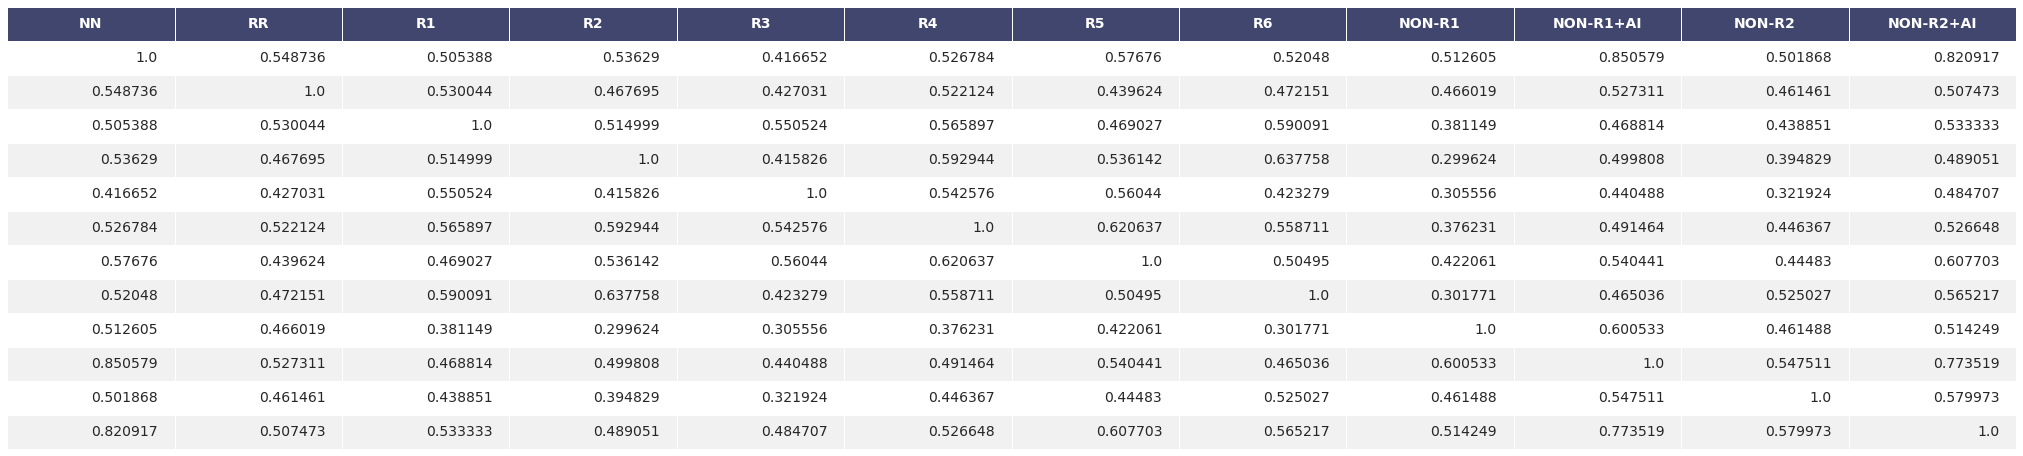

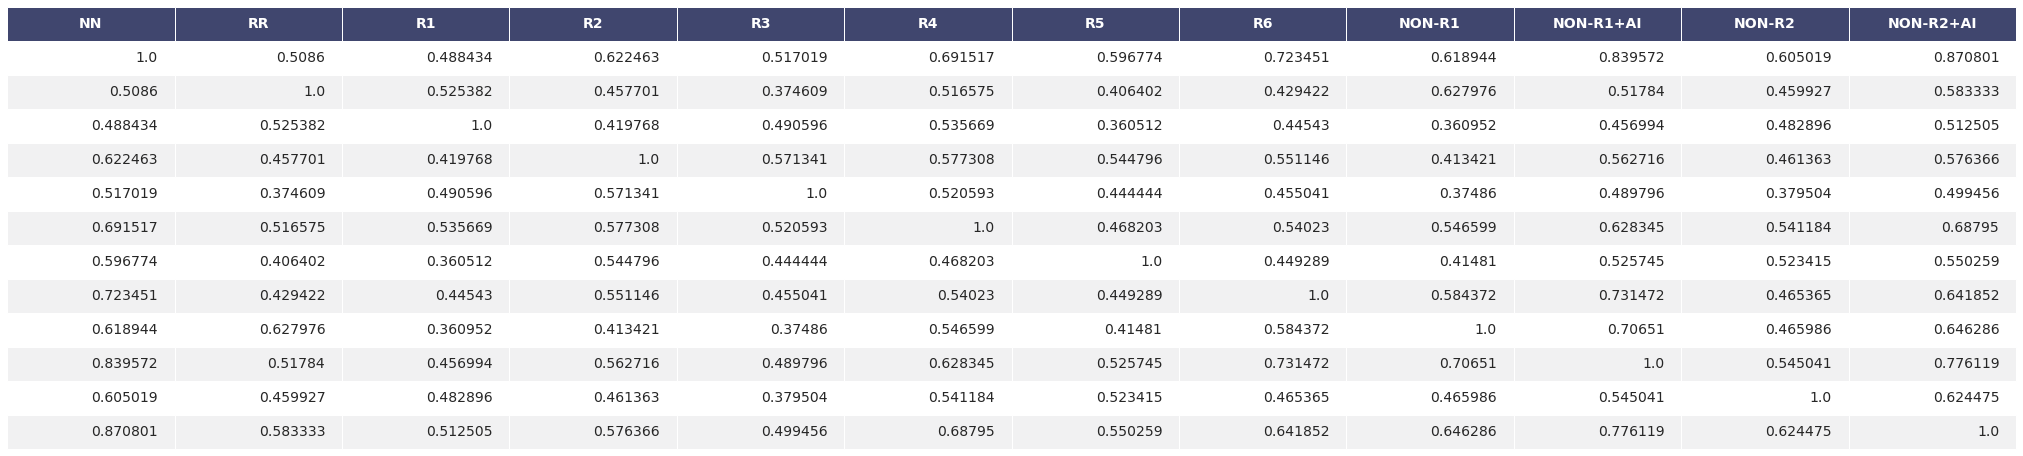

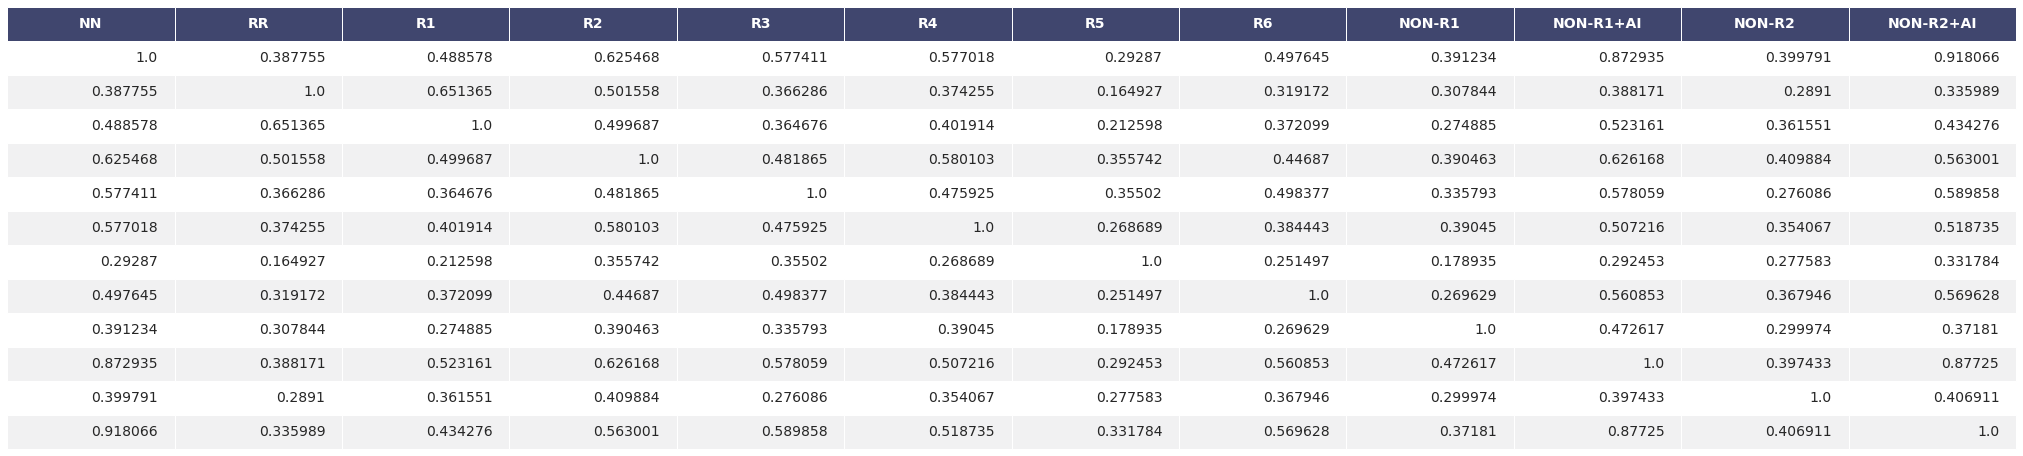

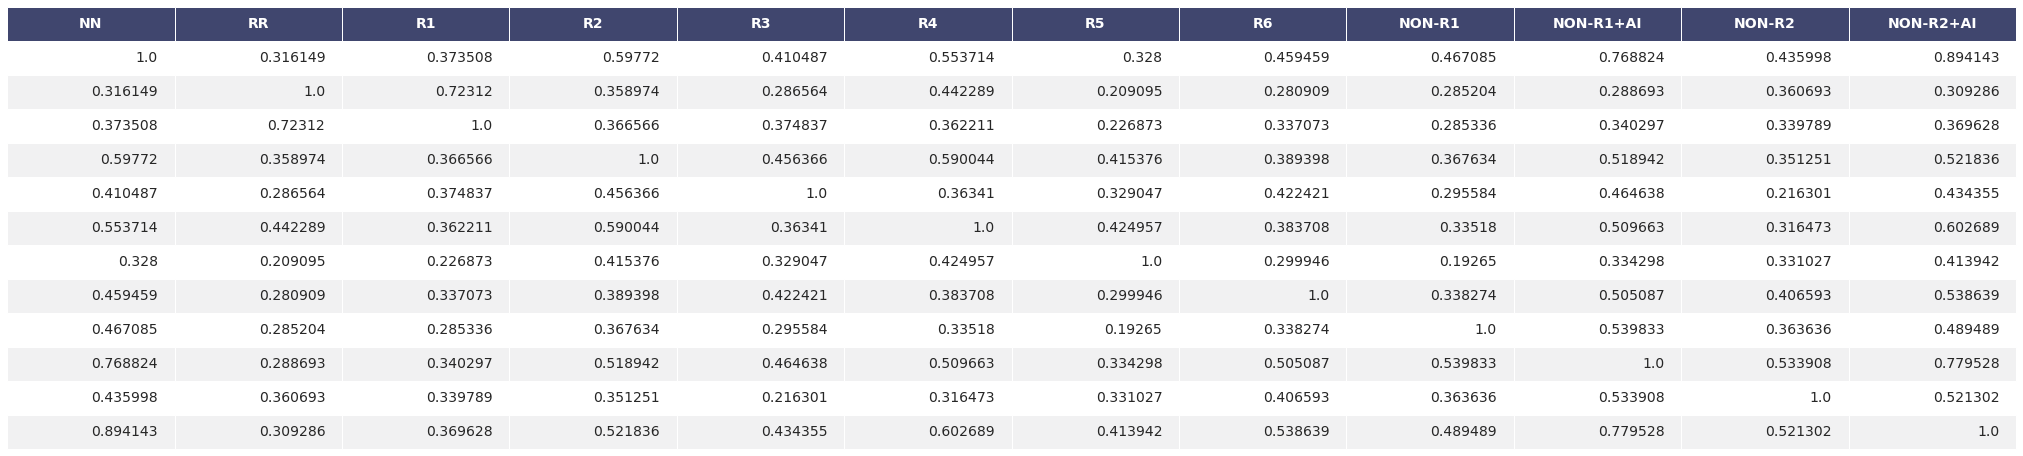

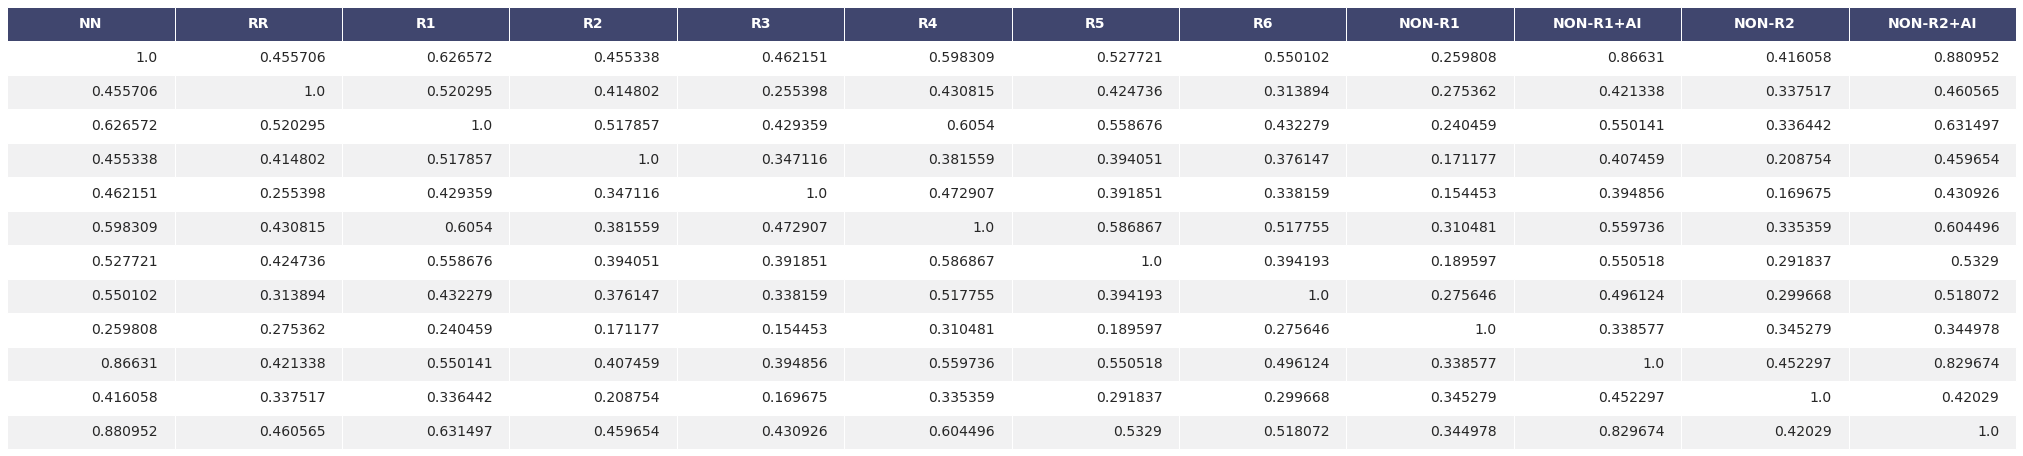

In [751]:
for label in columns_of_interest:
    df_cohens_kappa = pd.DataFrame(columns = challengers.keys(), index=challengers.keys())
    df_cohens_kappa_weighted = pd.DataFrame(columns = challengers.keys(), index=challengers.keys())
    for challenger1 in challengers.keys():
        for challenger2 in challengers.keys():
            if 'Cardiomegaly' in label:
                label_order = herzgröße_labels
            elif 'Pneumothorax' in label:
                label_order = pneumothorax_labels
            else:
                label_order = standard_labels
            # Normal cohens kappa
            cks = cohen_kappa_score(challengers[challenger1][label], challengers[challenger2][label])
            df_cohens_kappa.loc[challenger1, challenger2] = cks
            # Weighted cohens kappa
            cks_weighted = cohen_kappa_score(challengers[challenger1][label], challengers[challenger2][label], weights='linear')
            df_cohens_kappa_weighted.loc[challenger1, challenger2] = cks_weighted
            
    print('-------------------------------------------------------------------------------')
    print(label)
    display(df_cohens_kappa)
    fig, ax = render_mpl_table(df_cohens_kappa.astype('float64').round(6))
    fig.savefig(os.path.join(dir_cohens_kappa_all_vs_all, f'{label}_all_vs_all.png'))

### Cohens Kappa (pred, gt vs majority voting of radiologists)

In [752]:
dir_cohens_kappa_pred_gt_vs_maj = os.path.join(root_directory, 'cohens_kappa_pred_gt_vs_maj')
make_dir_save(dir_cohens_kappa_pred_gt_vs_maj)

In [733]:
# RANK CONSISTENCY

def get_majority_voting(label, challengers_to_exclude = ['NN', 'RR', 'NON-R1', 'NON-R1+AI', 'NON-R2', 'NON-R2+AI', 'NN Congestion (one hot)', 'NN Congestion (rank-consistency)']):
    radiologists = [key for key in challengers.keys() if key not in challengers_to_exclude]
    annotations = []
    for radiologist in radiologists:
        annotations.append(challengers[radiologist][label])
    df_combined = pd.concat(annotations, axis=1)
    mode = df_combined.mode(axis=1)
    #print(f'{label}; Number of random selections:', len(mode[1].dropna()))
    df_maj = mode[0]
    return df_maj

In [753]:
def get_majority_voting(label, challengers_to_exclude = ['NN', 'RR', 'NON-R1', 'NON-R1+AI', 'NON-R2', 'NON-R2+AI']):
    radiologists = [key for key in challengers.keys() if key not in challengers_to_exclude]
    annotations = []
    for radiologist in radiologists:
        annotations.append(challengers[radiologist][label])
    df_combined = pd.concat(annotations, axis=1)
    mode = df_combined.mode(axis=1)
    #print(f'{label}; Number of random selections:', len(mode[1].dropna()))
    df_maj = mode[0]
    return df_maj

In [202]:
# RANK CONSISTENCY

for label in columns_of_interest:
    df_cohens_kappa = pd.DataFrame(columns = ['NN', 'NN Congestion (one hot)', 'NN Congestion (rank-consistency)', 'RR', 'Majority'], index=['NN', 'NN Congestion (one hot)', 'NN Congestion (rank-consistency)', 'RR', 'Majority'])
    df_cohens_kappa_weighted = pd.DataFrame(columns = ['NN', 'NN Congestion (one hot)', 'NN Congestion (rank-consistency)', 'RR', 'Majority'], index=['NN', 'NN Congestion (one hot)', 'NN Congestion (rank-consistency)', 'RR', 'Majority'])
    for challenger1 in ['NN', 'NN Congestion (one hot)', 'NN Congestion (rank-consistency)', 'RR', 'Majority']:
        for challenger2 in ['NN', 'RR', 'NN Congestion (one hot)', 'NN Congestion (rank-consistency)', 'Majority']:
            if 'Cardiomegaly' in label:
                label_order = herzgröße_labels
            elif 'Pneumothorax' in label:
                label_order = pneumothorax_labels
            else:
                label_order = standard_labels
            
            challenger1_annotations = get_majority_voting(label) if challenger1=='Majority' else challengers[challenger1][label]
            challenger2_annotations = get_majority_voting(label) if challenger2=='Majority' else challengers[challenger2][label]
            # Normal cohens kappa
            cks = cohen_kappa_score(challenger1_annotations, challenger2_annotations)
            df_cohens_kappa.loc[challenger1, challenger2] = cks
            # Weighted cohens kappa
            cks_weighted = cohen_kappa_score(challenger1_annotations, challenger2_annotations, weights='linear')
            df_cohens_kappa_weighted.loc[challenger1, challenger2] = cks_weighted
            
    print('-------------------------------------------------------------------------------')
    print(label)
    display(df_cohens_kappa)
    fig, ax = render_mpl_table(df_cohens_kappa.astype('float64').round(6))
    fig.savefig(os.path.join(dir_cohens_kappa_pred_gt_vs_maj, f'{label}_pred_gt_vs_maj.png'))

KeyError: 'NN Congestion (one hot)'

-------------------------------------------------------------------------------
Cardiomegaly


NN        RR  Majority
NN               1  0.382498  0.504612
RR        0.382498         1  0.517297
Majority  0.504612  0.517297         1

-------------------------------------------------------------------------------
Pleural Effusion (left)


NN        RR  Majority
NN               1  0.548736  0.623539
RR        0.548736         1  0.542627
Majority  0.623539  0.542627         1

-------------------------------------------------------------------------------
Pleural Effusion (right)


NN        RR  Majority
NN               1    0.5086  0.795292
RR          0.5086         1  0.498175
Majority  0.795292  0.498175         1

-------------------------------------------------------------------------------
Pulmonary Infiltrates (left)


NN        RR  Majority
NN               1  0.387755  0.613601
RR        0.387755         1  0.489796
Majority  0.613601  0.489796         1

-------------------------------------------------------------------------------
Pulmonary Infiltrates (right)


NN        RR  Majority
NN               1  0.316149  0.655172
RR        0.316149         1  0.343931
Majority  0.655172  0.343931         1

-------------------------------------------------------------------------------
Pulmonary Congestion


NN        RR Majority
NN               1  0.367546  0.29966
RR        0.367546         1  0.26312
Majority   0.29966   0.26312        1

-------------------------------------------------------------------------------
Atelectasis (left)


NN        RR  Majority
NN               1  0.347708  0.655634
RR        0.347708         1  0.563716
Majority  0.655634  0.563716         1

-------------------------------------------------------------------------------
Atelectasis (right)


NN        RR  Majority
NN               1  0.455706  0.616006
RR        0.455706         1  0.526874
Majority  0.616006  0.526874         1

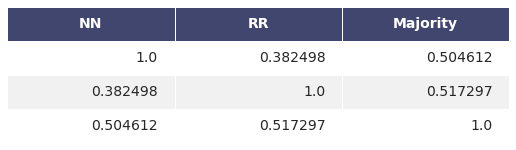

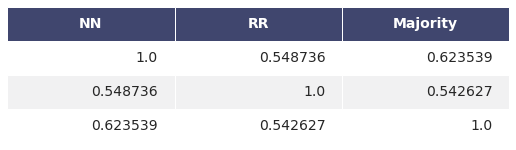

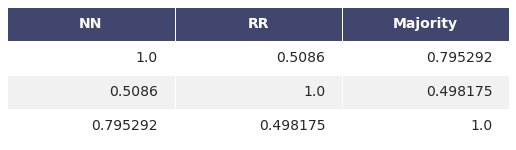

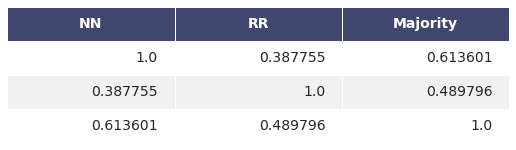

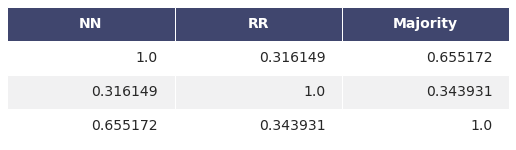

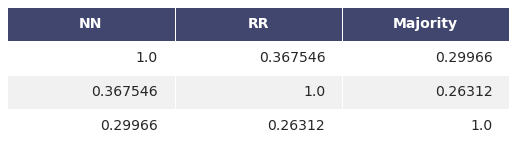

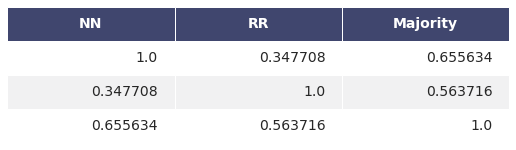

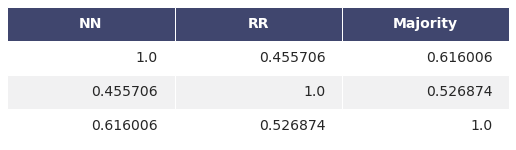

In [754]:
for label in columns_of_interest:
    df_cohens_kappa = pd.DataFrame(columns = ['NN', 'RR', 'Majority'], index=['NN', 'RR', 'Majority'])
    df_cohens_kappa_weighted = pd.DataFrame(columns = ['NN', 'RR', 'Majority'], index=['NN', 'RR', 'Majority'])
    for challenger1 in ['NN', 'RR', 'Majority']:
        for challenger2 in ['NN', 'RR', 'Majority']:
            if 'Cardiomegaly' in label:
                label_order = herzgröße_labels
            elif 'Pneumothorax' in label:
                label_order = pneumothorax_labels
            else:
                label_order = standard_labels
            
            challenger1_annotations = get_majority_voting(label) if challenger1=='Majority' else challengers[challenger1][label]
            challenger2_annotations = get_majority_voting(label) if challenger2=='Majority' else challengers[challenger2][label]
            # Normal cohens kappa
            cks = cohen_kappa_score(challenger1_annotations, challenger2_annotations)
            df_cohens_kappa.loc[challenger1, challenger2] = cks
            # Weighted cohens kappa
            cks_weighted = cohen_kappa_score(challenger1_annotations, challenger2_annotations, weights='linear')
            df_cohens_kappa_weighted.loc[challenger1, challenger2] = cks_weighted
            
    print('-------------------------------------------------------------------------------')
    print(label)
    display(df_cohens_kappa)
    fig, ax = render_mpl_table(df_cohens_kappa.astype('float64').round(6))
    fig.savefig(os.path.join(dir_cohens_kappa_pred_gt_vs_maj, f'{label}_pred_gt_vs_maj.png'))

### Cohens Kappa (pred, selected radiologist vs majority voting of other radiologists (including groundtruth))

-------------------------------------------------------------------------------------------------------
RR


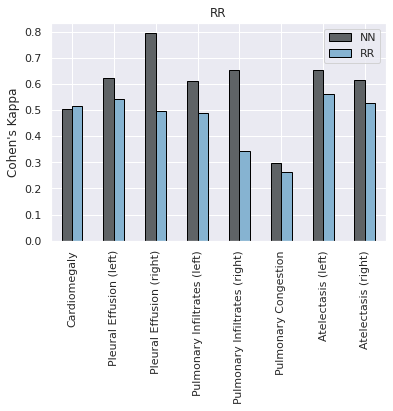

-------------------------------------------------------------------------------------------------------
R1


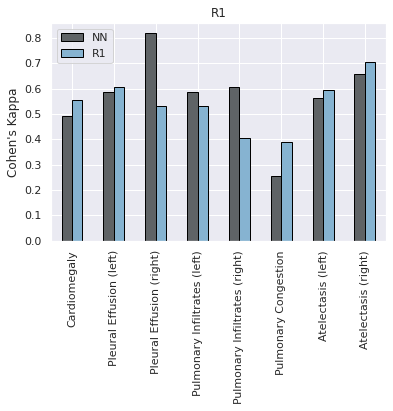

-------------------------------------------------------------------------------------------------------
R2


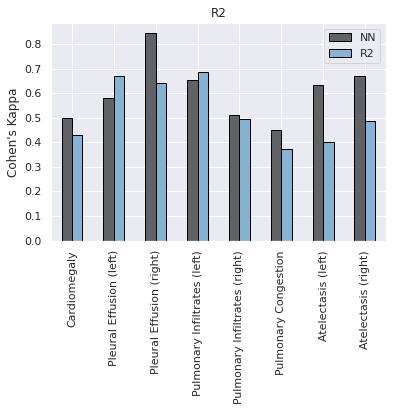

-------------------------------------------------------------------------------------------------------
R3


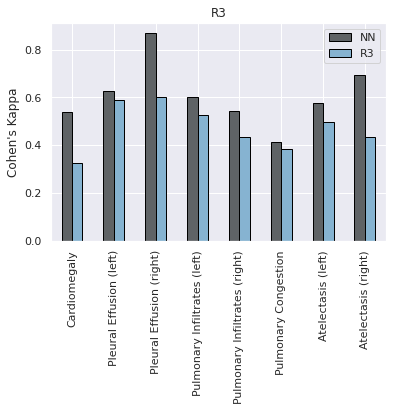

-------------------------------------------------------------------------------------------------------
R4


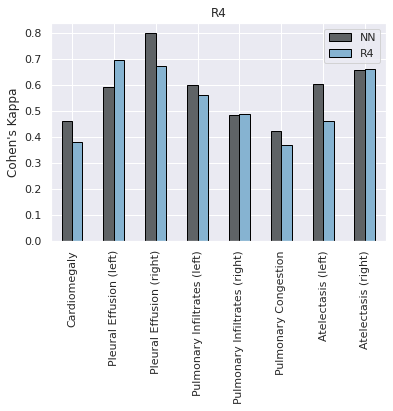

-------------------------------------------------------------------------------------------------------
R5


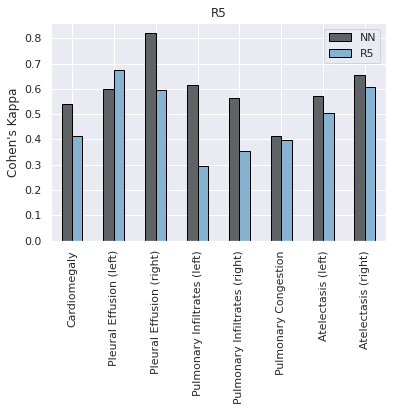

-------------------------------------------------------------------------------------------------------
R6


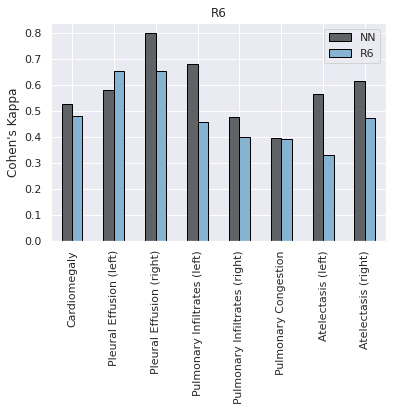

-------------------------------------------------------------------------------------------------------
NON-R1


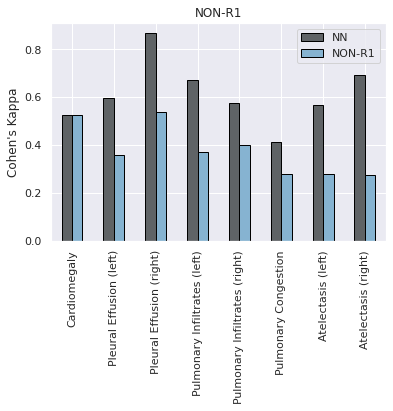

-------------------------------------------------------------------------------------------------------
NON-R1+AI


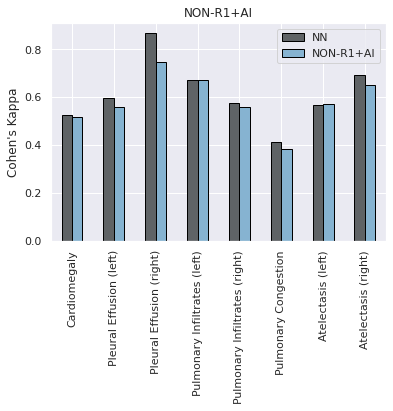

-------------------------------------------------------------------------------------------------------
NON-R2


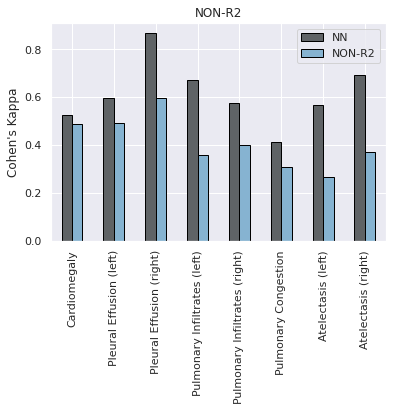

-------------------------------------------------------------------------------------------------------
NON-R2+AI


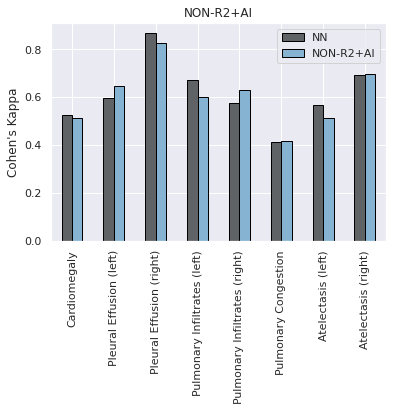

In [755]:
all_challengers_without_pred = list(challengers.keys())
all_challengers_without_pred.remove('NN')
for selected_radiologist in all_challengers_without_pred:
    df_cumulated = pd.DataFrame(columns=['NN', selected_radiologist])
    print('-------------------------------------------------------------------------------------------------------')
    print(selected_radiologist)
    for label in columns_of_interest:
        df_cohens_kappa = pd.DataFrame(columns = ['NN', selected_radiologist, 'Majority'], index=['NN', selected_radiologist, 'Majority'])
        df_cohens_kappa_weighted = pd.DataFrame(columns = ['NN', selected_radiologist, 'Majority'], index=['NN', selected_radiologist, 'Majority'])
        for challenger1 in ['NN', selected_radiologist, 'Majority']:
            for challenger2 in ['NN', selected_radiologist, 'Majority']:
                if 'Cardiomegaly' in label:
                    label_order = herzgröße_labels
                elif 'Pneumothorax' in label:
                    label_order = pneumothorax_labels
                else:
                    label_order = standard_labels

                challenger1_annotations = get_majority_voting(label, challengers_to_exclude = ['NN', 'NON-R1', 'NON-R1+AI', 'NON-R2', 'NON-R2+AI', selected_radiologist]) if challenger1=='Majority' else challengers[challenger1][label]
                challenger2_annotations = get_majority_voting(label, challengers_to_exclude = ['NN', 'NON-R1', 'NON-R1+AI', 'NON-R2', 'NON-R2+AI', selected_radiologist]) if challenger2=='Majority' else challengers[challenger2][label]
                # Normal cohens kappa
                cks = cohen_kappa_score(challenger1_annotations, challenger2_annotations)
                df_cohens_kappa.loc[challenger1, challenger2] = cks
                # Weighted cohens kappa
                cks_weighted = cohen_kappa_score(challenger1_annotations, challenger2_annotations, weights='linear')
                df_cohens_kappa_weighted.loc[challenger1, challenger2] = cks_weighted

        #print('-------------------------------------------------------------------------------')
        #print(label)
        #display(df_cohens_kappa)
        
        cohens_kappa_values = df_cohens_kappa.loc['Majority', ['NN', selected_radiologist]]
        cohens_kappa_values = cohens_kappa_values.rename(label)
        df_cumulated = df_cumulated.append(cohens_kappa_values)
        
        #fig, ax = render_mpl_table(df_cohens_kappa.astype('float64').round(6))
    
    df_cumulated.plot.bar(color=palette, edgecolor="black")
    plt.title(selected_radiologist)
    plt.ylabel("Cohen's Kappa")
    plt.show()

### Bootstrapping two correlated Kappas
Generate a new list of cohen's kappa values by sampling the results of the 100 studies with replacement.

In [469]:
df_kappa_samples_differences = {}
df_kappa_samples_prediction_dict = {}
df_kappa_samples_challengers_dict = {}
for challenger1 in [challenger for challenger in challengers.keys() if challenger!='NN']:
        df_kappa_samples = pd.DataFrame(columns = columns_of_interest)
        df_kappa_samples_prediction = pd.DataFrame(columns = columns_of_interest)
        df_kappa_samples_challengers = pd.DataFrame(columns = columns_of_interest)
        for sample in tqdm(range(1000)):
            for label in columns_of_interest:
                if 'Cardiomegaly' in label:
                    label_order = herzgröße_labels
                elif 'Pneumothorax' in label:
                    label_order = pneumothorax_labels
                else:
                    label_order = standard_labels
                # Normal cohens kappa
                df_prediction_sampled = challengers['NN'].sample(n=100, replace=True, random_state=sample)
                df_challenger1_sampled = challengers[challenger1].sample(n=100, replace=True, random_state=sample)
                df_maj_sampled = get_majority_voting(label, challengers_to_exclude = ['NN', 'NON-R1', 'NON-R1+AI', 'NON-R2', 'NON-R2+AI', challenger1]).sample(n=100, replace=True, random_state=sample)
                cks_challengers = cohen_kappa_score(df_challenger1_sampled[label], df_maj_sampled)
                cks_prediction = cohen_kappa_score(df_prediction_sampled[label], df_maj_sampled)
                
                cks_difference = cks_prediction - cks_challengers
                
                df_kappa_samples.loc[sample, label] = cks_difference
                df_kappa_samples_prediction.loc[sample, label] = cks_prediction
                df_kappa_samples_challengers.loc[sample, label] = cks_challengers
                
                
        print('-------------------------------------------------------------------------------')
        print(challenger1)
        display(df_kappa_samples)
        df_kappa_samples_differences[challenger1] = df_kappa_samples
        df_kappa_samples_prediction_dict[challenger1] = df_kappa_samples_prediction
        df_kappa_samples_challengers_dict[challenger1] = df_kappa_samples_challengers

100%|██████████| 1000/1000 [02:50<00:00,  5.87it/s]

-------------------------------------------------------------------------------
RR


Cardiomegaly Pleural Effusion (left) Pleural Effusion (right)  \
0     -0.0950524                0.172841                 0.213996   
1      -0.148643                0.165379                 0.304286   
2      0.0472634               0.0179211                  0.30863   
3       0.152827               0.0527402                 0.388286   
4      -0.141811               0.0566006                 0.307882   
..           ...                     ...                      ...   
995    0.0192962               0.0443749                 0.230097   
996    0.0474287               0.0410638                  0.18756   
997   -0.0270315               0.0275306                 0.350418   
998     0.079653                0.111022                  0.10119   
999     0.131693               0.0793155                 0.340919   

    Pulmonary Infiltrates (left) Pulmonary Infiltrates (right)  \
0                       0.233806                      0.337577   
1                       0.245327                       0.36039   
2                     -0.0949928                      0.438617   
3                        0.15426                      0.162571   
4                       0.171765                      0.434499   
..                           ...                           ...   
995                     0.345533                      0.310269   
996                     0.121517                      0.202551   
997                     0.252357                      0.323611   
998                     0.192707                      0.232911   
999                     0.173041                      0.315235   

    Pulmonary Congestion Atelectasis (left) Atelectasis (right)  
0               0.205153          0.0465319            0.188229  
1              0.0899023        -0.00813987            0.139745  
2             -0.0428056          0.0572891           0.0761418  
3             -0.0495536            0.22685           0.0781161  
4             -0.0075478           0.140052            0.149761  
..                   ...                ...                 ...  
995           -0.0247734           0.237937             0.03014  
996            0.0547224            0.17502            0.193274  
997             0.149394         -0.0390175            0.128605  
998            0.0752931           0.161712            0.110705  
999            0.0738238           0.229813            0.141997  

[1000 rows x 8 columns]

100%|██████████| 1000/1000 [02:51<00:00,  5.83it/s]

-------------------------------------------------------------------------------
R1


Cardiomegaly Pleural Effusion (left) Pleural Effusion (right)  \
0     -0.0354074               0.0752909                 0.258043   
1      -0.199056              -0.0162077                 0.232725   
2      0.0299744               -0.215064                 0.255973   
3      0.0560653              -0.0338447                 0.419237   
4      -0.158811               0.0234298                 0.267418   
..           ...                     ...                      ...   
995    0.0350903              -0.0783207                 0.260284   
996   -0.0199418               -0.065683                 0.242846   
997   -0.0420029             -0.00276034                 0.348281   
998   -0.0143896              -0.0470134                 0.248376   
999   -0.0278119              -0.0586689                 0.461896   

    Pulmonary Infiltrates (left) Pulmonary Infiltrates (right)  \
0                        0.16956                      0.243995   
1                      0.0954312                      0.318872   
2                       -0.18599                      0.432949   
3                       0.093929                     0.0244334   
4                       0.040951                      0.304005   
..                           ...                           ...   
995                     0.267857                      0.177739   
996                      0.14058                      0.029889   
997                     0.256441                      0.287929   
998                     0.211304                      0.145825   
999                     0.118523                      0.280039   

    Pulmonary Congestion Atelectasis (left) Atelectasis (right)  
0           -0.000945251         -0.0251717          -0.0332043  
1              -0.117408          -0.135172          -0.0118385  
2              -0.137136         -0.0343076         -0.00366252  
3              -0.122226           0.123015          0.00817655  
4              -0.187315          0.0709644             -0.1255  
..                   ...                ...                 ...  
995            -0.169455          0.0371668           -0.216953  
996           -0.0584313          0.0312385           -0.052622  
997           -0.0801375         -0.0412632           -0.133476  
998            -0.104033          0.0495749           -0.027898  
999            -0.208202          0.0584464           -0.067529  

[1000 rows x 8 columns]

100%|██████████| 1000/1000 [02:50<00:00,  5.86it/s]

-------------------------------------------------------------------------------
R2


Cardiomegaly Pleural Effusion (left) Pleural Effusion (right)  \
0      0.0500778              -0.0625621                 0.160714   
1     -0.0142793               0.0580446                 0.206417   
2     -0.0058089               -0.126154                 0.229887   
3       0.131834               -0.166482                 0.261313   
4     -0.0925401              -0.0550154                0.0215285   
..           ...                     ...                      ...   
995     0.108464               -0.182312                 0.190082   
996    0.0101497              -0.0850886                0.0729879   
997    -0.048671               0.0765111                 0.206685   
998     0.019748              -0.0797451                 0.145962   
999     0.027267              -0.0616966                 0.181029   

    Pulmonary Infiltrates (left) Pulmonary Infiltrates (right)  \
0                      0.0920686                     0.0114681   
1                      0.0808616                     0.0398681   
2                      -0.239255                        0.2534   
3                       0.125915                     -0.113022   
4                     -0.0843203                      0.166379   
..                           ...                           ...   
995                     0.225831                     0.0612734   
996                    0.0070483                    -0.0733358   
997                   -0.0275986                     0.0454976   
998                   0.00117907                     -0.100316   
999                   -0.0547519                      0.166959   

    Pulmonary Congestion Atelectasis (left) Atelectasis (right)  
0               0.251097             0.1789             0.22173  
1               0.100768           0.177247            0.148593  
2              0.0893342           0.309253            0.222914  
3              0.0680437           0.252152            0.216204  
4              0.0719856           0.288491            0.129339  
..                   ...                ...                 ...  
995            0.0714127           0.190997             0.16153  
996           0.00306531           0.204187             0.22121  
997            0.0799801           0.148681            0.217386  
998            0.0164621           0.317903            0.281845  
999             -0.08005            0.24461            0.236761  

[1000 rows x 8 columns]

100%|██████████| 1000/1000 [02:51<00:00,  5.84it/s]

-------------------------------------------------------------------------------
R3


Cardiomegaly Pleural Effusion (left) Pleural Effusion (right)  \
0        0.10498                0.173984                 0.360892   
1      0.0354615               0.0853227                 0.193786   
2       0.277742                -0.15183                 0.230505   
3       0.344246              -0.0888498                 0.227752   
4      0.0754692               0.0320023                 0.170646   
..           ...                     ...                      ...   
995     0.273352              -0.0753725                 0.248452   
996     0.201684              -0.0398064                  0.18454   
997     0.182411               0.0813979                 0.250566   
998     0.185511               0.0528608                 0.250346   
999      0.16448               0.0303923                 0.292967   

    Pulmonary Infiltrates (left) Pulmonary Infiltrates (right)  \
0                       0.139205                    -0.0699883   
1                       0.142426                     0.0807687   
2                      -0.144322                      0.208655   
3                     -0.0319481                    -0.0893067   
4                     -0.0260926                      0.118252   
..                           ...                           ...   
995                      0.34501                    -0.0752823   
996                     0.253493                    -0.0755729   
997                      0.15896                     0.0782891   
998                     0.229696                    -0.0214551   
999                    -0.186887                      0.416329   

    Pulmonary Congestion Atelectasis (left) Atelectasis (right)  
0             -0.0276343         -0.0269214            0.372913  
1              0.0353969          -0.127742            0.351757  
2              0.0446507             0.1194            0.337763  
3             -0.0186165            0.14951            0.288415  
4              0.0243588          0.0459227            0.273483  
..                   ...                ...                 ...  
995           0.00159017           0.253513            0.207746  
996             -0.11157           0.018189            0.351594  
997            0.0736312         -0.0777325            0.312812  
998           -0.0880203            0.14702            0.262871  
999            0.0862468          0.0481521            0.305525  

[1000 rows x 8 columns]

100%|██████████| 1000/1000 [02:51<00:00,  5.83it/s]

-------------------------------------------------------------------------------
R4


Cardiomegaly Pleural Effusion (left) Pleural Effusion (right)  \
0      0.0128391             -0.00856808                0.0517136   
1     -0.0159385              -0.0479709                 0.110544   
2       0.148002                -0.22314                 0.258565   
3       0.237042               -0.190012                0.0916203   
4     -0.0406116              -0.0747972                 0.304865   
..           ...                     ...                      ...   
995    0.0666807              -0.0123415                 0.208099   
996    0.0711531               -0.119339                 0.100843   
997    0.0492754             -0.00574488                  0.23939   
998   0.00544743              -0.0824695                0.0779066   
999    0.0808867               -0.254497                 0.156632   

    Pulmonary Infiltrates (left) Pulmonary Infiltrates (right)  \
0                      0.0924016                    -0.0731045   
1                        0.21427                   -0.00748727   
2                     -0.0894275                      0.109938   
3                       0.250334                    -0.0402898   
4                      0.0188728                    -0.0327527   
..                           ...                           ...   
995                     0.292639                     -0.127295   
996                     0.111922                    -0.0737246   
997                     0.193368                    -0.0356922   
998                    0.0217451                    0.00754148   
999                   -0.0765653                    -0.0748773   

    Pulmonary Congestion Atelectasis (left) Atelectasis (right)  
0               0.108144           0.152839            0.055748  
1            -0.00853787           0.158929          -0.0202494  
2               0.111936          0.0327271            0.114625  
3             -0.0989708           0.153819          -0.0335693  
4             -0.0317065           0.211114           0.0527107  
..                   ...                ...                 ...  
995          -0.00988739         -0.0163079          -0.0838723  
996           -0.0748995           0.154188           0.0420669  
997            -0.104342          0.0639163           0.0285509  
998           -0.0355907           0.295928           0.0175399  
999             0.113054            0.10102           0.0731195  

[1000 rows x 8 columns]

100%|██████████| 1000/1000 [02:52<00:00,  5.81it/s]

-------------------------------------------------------------------------------
R5


Cardiomegaly Pleural Effusion (left) Pleural Effusion (right)  \
0       0.172113             -0.00828929                  0.22545   
1       0.126597               -0.116398                 0.312971   
2      0.0865486               -0.107784                 0.261368   
3       0.345447               -0.150105                 0.218758   
4      0.0373164               0.0329137                 0.130598   
..           ...                     ...                      ...   
995    0.0635693               -0.102706                 0.151581   
996    0.0860498                -0.12895                0.0665058   
997     0.148324               -0.110388                 0.123749   
998     0.170677              -0.0508698                 0.146095   
999    0.0911458              -0.0948311                 0.195351   

    Pulmonary Infiltrates (left) Pulmonary Infiltrates (right)  \
0                       0.461676                       0.12202   
1                        0.52901                      0.365115   
2                       0.100187                      0.300058   
3                       0.364081                     0.0443502   
4                       0.243858                      0.206248   
..                           ...                           ...   
995                     0.615794                     0.0799025   
996                      0.48579                       0.11068   
997                     0.487736                      0.367306   
998                     0.423818                      0.236201   
999                   -0.0621468                      0.299371   

    Pulmonary Congestion Atelectasis (left) Atelectasis (right)  
0              0.0253529         -0.0501594           0.0278841  
1              -0.070748          0.0651128           0.0805993  
2               0.285328           0.241122             0.22992  
3              0.0164862           0.215474           0.0696483  
4              -0.121534           0.117047          -0.0516091  
..                   ...                ...                 ...  
995            0.0878022           0.246721           -0.019221  
996             0.027104           0.126814            0.123122  
997           -0.0197924           0.138656           0.0656457  
998           -0.0622748          0.0114055            0.057879  
999             0.104361        -0.00990043          0.00402406  

[1000 rows x 8 columns]

100%|██████████| 1000/1000 [02:52<00:00,  5.79it/s]

-------------------------------------------------------------------------------
R6


Cardiomegaly Pleural Effusion (left) Pleural Effusion (right)  \
0       0.108931              -0.0007892                 0.121938   
1     -0.0485933              -0.0435118                 0.150411   
2        0.11361               -0.177879                 0.197507   
3       0.202053               -0.128752                 0.232952   
4     -0.0458076              -0.0450457                0.0165863   
..           ...                     ...                      ...   
995     0.139393               -0.181254                0.0933125   
996    0.0662123              -0.0522059                0.0868363   
997   -0.0136705              -0.0407311                0.0831799   
998    0.0237751              -0.0794759                 0.102342   
999     0.083413              -0.0848589                 0.146609   

    Pulmonary Infiltrates (left) Pulmonary Infiltrates (right)  \
0                       0.248488                    -0.0189669   
1                       0.178756                      0.197787   
2                      0.0161225                     0.0835197   
3                       0.185071                    -0.0601625   
4                       0.201348                      0.126266   
..                           ...                           ...   
995                     0.395174                    -0.0700147   
996                     0.387105                     -0.020072   
997                      0.24361                     0.0926313   
998                     0.464283                      0.164327   
999                    0.0461004                      0.212373   

    Pulmonary Congestion Atelectasis (left) Atelectasis (right)  
0             -0.0107508             0.2737            0.178835  
1             -0.0246846           0.114288            0.102815  
2             -0.0638593           0.153278            0.304829  
3              0.0128536           0.233072           0.0774469  
4            -0.00104303           0.338037            0.176416  
..                   ...                ...                 ...  
995           -0.0432131             0.2273           0.0430362  
996            0.0472885           0.285243            0.129694  
997            -0.131479          0.0624759           0.0773681  
998           -0.0384422            0.39638            0.168971  
999           -0.0907497           0.210123            0.219945  

[1000 rows x 8 columns]

100%|██████████| 1000/1000 [02:47<00:00,  5.97it/s]

-------------------------------------------------------------------------------
NON-R1


Cardiomegaly Pleural Effusion (left) Pleural Effusion (right)  \
0      0.0199884                0.384706                 0.376554   
1     -0.0949583                0.208575                 0.430547   
2     -0.0945301                0.135136                 0.323941   
3       0.323637                0.266175                 0.338468   
4      -0.105089                0.305381                 0.292513   
..           ...                     ...                      ...   
995    0.0664845                0.324774                 0.238537   
996    0.0149985                0.144522                 0.325832   
997    0.0356713                0.244129                 0.375519   
998   -0.0782242                0.286603                 0.223946   
999   0.00709141                0.262813                 0.289468   

    Pulmonary Infiltrates (left) Pulmonary Infiltrates (right)  \
0                       0.343952                      0.157086   
1                       0.544855                      0.366313   
2                       0.180853                     0.0507964   
3                       0.390102                     0.0538135   
4                        0.19504                    -0.0500718   
..                           ...                           ...   
995                      0.41556                    -0.0791166   
996                     0.321256                     0.0146654   
997                     0.383411                     0.0934384   
998                     0.333457                      0.234252   
999                      0.10201                      0.393663   

    Pulmonary Congestion Atelectasis (left) Atelectasis (right)  
0              0.0633694           0.141418            0.255168  
1               0.118995           0.268297            0.274237  
2                0.10074           0.445994            0.614959  
3               0.110655           0.420602            0.373382  
4               0.115382           0.419985             0.59459  
..                   ...                ...                 ...  
995            0.0517836           0.425459            0.375442  
996           -0.0142393           0.273116            0.434615  
997             0.252482           0.203488            0.328578  
998              0.08179           0.424945            0.450646  
999            0.0399182            0.41698            0.558331  

[1000 rows x 8 columns]

100%|██████████| 1000/1000 [02:46<00:00,  6.00it/s]

-------------------------------------------------------------------------------
NON-R1+AI


Cardiomegaly Pleural Effusion (left) Pleural Effusion (right)  \
0     -0.0816345                  0.1264                 0.197096   
1     -0.0100987               0.0612649                 0.242866   
2      0.0195355               0.0844786                0.0710482   
3       0.133023              0.00680682                  0.14995   
4     -0.0016713                0.081366                 0.119799   
..           ...                     ...                      ...   
995   -0.0538354               0.0290256                0.0931538   
996  -0.00944195             -0.00996386                0.0967877   
997    0.0831366               0.0827341                 0.147695   
998   -0.0014266               0.0861954                0.0666767   
999     0.110719               0.0764814                0.0739194   

    Pulmonary Infiltrates (left) Pulmonary Infiltrates (right)  \
0                      0.0697116                    -0.0684046   
1                      0.0362841                     0.0520313   
2                     -0.0340136                    -0.0182871   
3                     -0.0381285                     0.0532266   
4                     -0.0507017                     0.0197924   
..                           ...                           ...   
995                    0.0475057                     -0.106171   
996                    0.0419625                    -0.0490483   
997                    0.0408809                   -0.00168648   
998                    0.0417085                    -0.0476449   
999                     -0.12402                      0.225579   

    Pulmonary Congestion Atelectasis (left) Atelectasis (right)  
0            -0.00457437        -0.00913743           0.0503148  
1             0.00353547        -0.00418223          -0.0132782  
2              0.0267568        -0.00707726           0.0410395  
3             -0.0200914                  0           0.0403338  
4             0.00659138        -0.00436543           0.0505075  
..                   ...                ...                 ...  
995           0.00523693                  0            0.017445  
996           -0.0405445                  0           0.0760029  
997            0.0643507        -0.00448135            0.052506  
998           -0.0213204                  0           0.0735387  
999           -0.0831375                  0           0.0261366  

[1000 rows x 8 columns]

100%|██████████| 1000/1000 [02:47<00:00,  5.99it/s]

-------------------------------------------------------------------------------
NON-R2


Cardiomegaly Pleural Effusion (left) Pleural Effusion (right)  \
0     -0.0334001                0.225023                 0.311128   
1     -0.0911397               0.0430551                  0.31538   
2      0.0421669               0.0876925                 0.388619   
3       0.140237               0.0900586                 0.231681   
4     -0.0957788                0.160326                  0.34837   
..           ...                     ...                      ...   
995    -0.114367                0.145691                 0.277206   
996  -0.00820846               0.0289343                 0.127544   
997    0.0489396               0.0737992                 0.386552   
998     0.137907                0.221222                 0.248859   
999      0.18421            -0.000124597                  0.25659   

    Pulmonary Infiltrates (left) Pulmonary Infiltrates (right)  \
0                       0.419561                     0.0291002   
1                       0.433914                      0.244926   
2                       0.165472                      0.244158   
3                       0.332819                      0.135613   
4                        0.23308                      0.270314   
..                           ...                           ...   
995                     0.548128                    0.00383104   
996                     0.387955                     0.0581304   
997                     0.383515                       0.12833   
998                     0.445541                      0.159649   
999                    0.0206952                      0.337911   

    Pulmonary Congestion Atelectasis (left) Atelectasis (right)  
0               0.206501           0.242019            0.208982  
1               0.175364           0.249211            0.161166  
2              0.0919928           0.380091            0.473832  
3              0.0694487           0.391165            0.358776  
4               0.158189           0.308155            0.466378  
..                   ...                ...                 ...  
995            0.0876377           0.313765            0.216508  
996           -0.0213209           0.204188            0.290853  
997             0.256706           0.223491            0.235652  
998             0.126712           0.454713            0.302419  
999            0.0220609           0.386473            0.421324  

[1000 rows x 8 columns]

100%|██████████| 1000/1000 [02:46<00:00,  6.01it/s]

-------------------------------------------------------------------------------
NON-R2+AI


Cardiomegaly Pleural Effusion (left) Pleural Effusion (right)  \
0      0.0438233             -0.00963931                        0   
1     -0.0175499               -0.116698                0.0550049   
2     -0.0355682              -0.0472597                 0.132351   
3      0.0482821              -0.0696269               -0.0287898   
4      -0.113397                0.011483                    0.123   
..           ...                     ...                      ...   
995   -0.0310053              -0.0273955                0.0420302   
996    -0.021013              -0.0944983                0.0920484   
997    0.0150953               -0.101767                 0.125622   
998    0.0394967              0.00235965               -0.0353641   
999    0.0232378               -0.091368                0.0914244   

    Pulmonary Infiltrates (left) Pulmonary Infiltrates (right)  \
0                      0.0943064                     -0.115398   
1                       0.066198                    -0.0437645   
2                      0.0234577                    -0.0386602   
3                       0.029429                    -0.0222356   
4                      0.0855716                     0.0255485   
..                           ...                           ...   
995                     0.089282                    -0.0769497   
996                     0.130089                    -0.0895594   
997                    0.0408809                    -0.0383221   
998                     0.183592                    -0.0204405   
999                    0.0356653                     0.0136134   

    Pulmonary Congestion Atelectasis (left) Atelectasis (right)  
0              0.0800709       -0.000387237           0.0190584  
1           -0.000191046          0.0557414          -0.0609088  
2             -0.0165913          0.0738689           0.0426213  
3             -0.0386792          0.0218068          -0.0214689  
4             -0.0853001           0.101778         -0.00437697  
..                   ...                ...                 ...  
995           -0.0182227          0.0203428         -0.00587648  
996            0.0122048          0.0750892           0.0729226  
997            0.0059323         0.00185254           -0.106783  
998            0.0610315           0.133625           0.0195503  
999          -0.00800374           0.037009          -0.0244243  

[1000 rows x 8 columns]

----------------------------------
RR


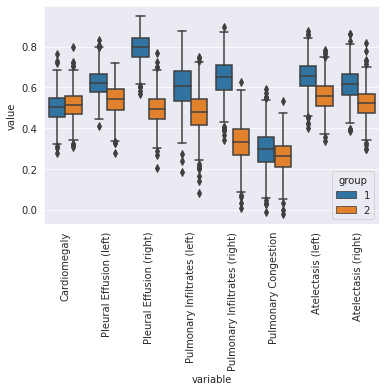

----------------------------------
R1


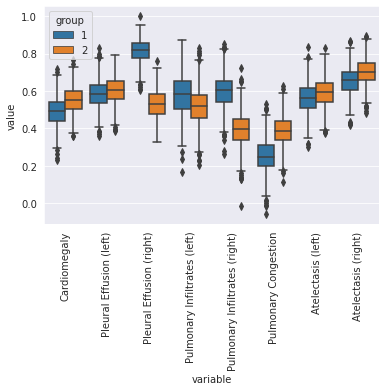

----------------------------------
R2


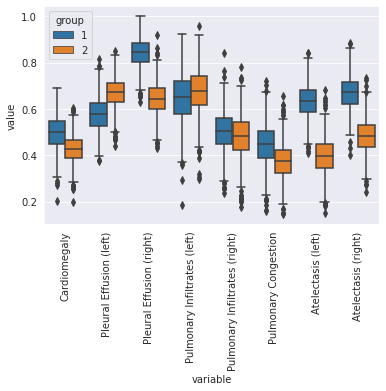

----------------------------------
R3


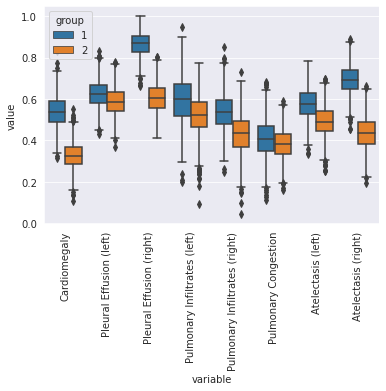

----------------------------------
R4


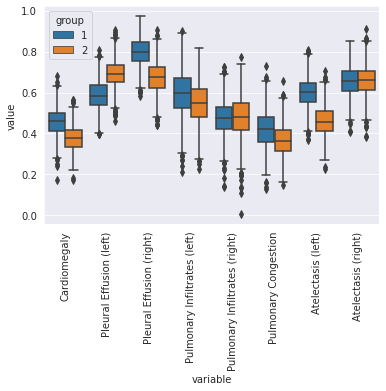

----------------------------------
R5


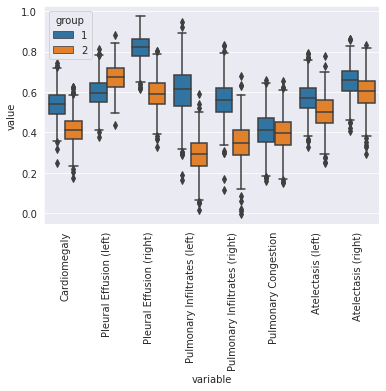

----------------------------------
R6


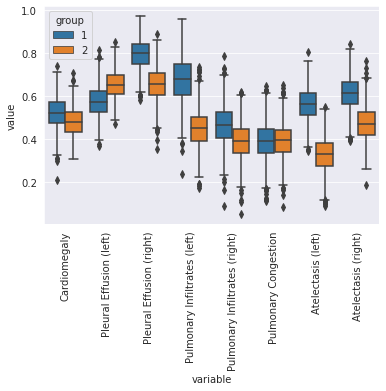

----------------------------------
NON-R1


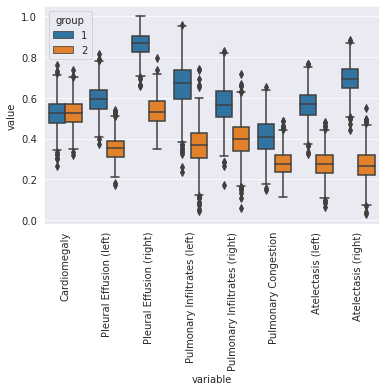

----------------------------------
NON-R1+AI


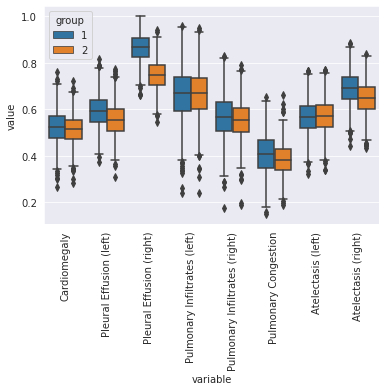

----------------------------------
NON-R2


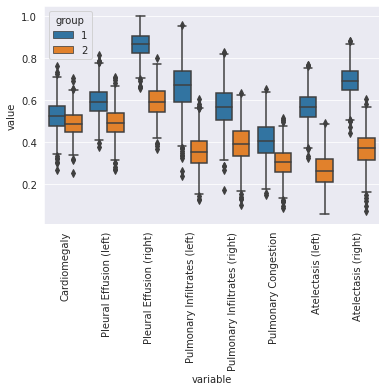

----------------------------------
NON-R2+AI


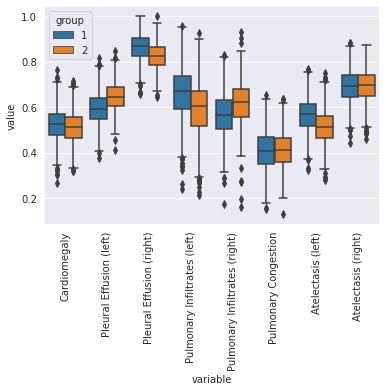

In [470]:
for key in df_kappa_samples_prediction_dict.keys():
    print('----------------------------------')
    print(key)
    test_df  = pd.concat([df_kappa_samples_prediction_dict[key].add_suffix('1'), df_kappa_samples_challengers_dict[key].add_suffix('2')], axis=1)
    test_df["id"] = test_df.index
    df_test_wtl = pd.wide_to_long(test_df, stubnames=['Cardiomegaly', 'Pleural Effusion (left)', 'Pleural Effusion (right)', 'Pulmonary Infiltrates (left)', 'Pulmonary Infiltrates (right)', 'Pulmonary Congestion', 'Atelectasis (left)', 'Atelectasis (right)'], j='group', i='id').reset_index().drop('id', axis=1)
    df_test_melt = df_test_wtl.melt(id_vars='group')
    ax = sns.boxplot(data=df_test_melt, x='variable', y='value', hue='group')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    plt.show()

In [471]:
for key in df_kappa_samples_differences.keys():
    print('-------------------------------------------')
    print(key)
    for label in columns_of_interest:
        print('---------------------')
        print(label)
        num_samples_below_zero = len(df_kappa_samples_differences[key][label][df_kappa_samples_differences[key][label]<0])
        num_samples = len(df_kappa_samples_differences[key][label])
        print('p-value: ' , num_samples_below_zero / num_samples)
        print(df_kappa_samples_differences[key][label].quantile([0.025, 0.950, 0.975]))
        print("Std: ", df_kappa_samples_differences[key][label].std())

-------------------------------------------
RR
---------------------
Cardiomegaly
p-value:  0.545
0.025   -0.178823
0.950    0.130047
0.975    0.158538
Name: Cardiomegaly, dtype: object
Std:  0.08717468460066799
---------------------
Pleural Effusion (left)
p-value:  0.135
0.025   -0.0776934
0.950     0.204293
0.975      0.23272
Name: Pleural Effusion (left), dtype: object
Std:  0.07726556749903517
---------------------
Pleural Effusion (right)
p-value:  0.0
0.025    0.120448
0.950    0.444049
0.975    0.466845
Name: Pleural Effusion (right), dtype: object
Std:  0.08864234719994588
---------------------
Pulmonary Infiltrates (left)
p-value:  0.167
0.025   -0.144565
0.950    0.367081
0.975    0.406302
Name: Pulmonary Infiltrates (left), dtype: object
Std:  0.1387966774210005
---------------------
Pulmonary Infiltrates (right)
p-value:  0.002
0.025    0.104048
0.950    0.494654
0.975    0.524421
Name: Pulmonary Infiltrates (right), dtype: object
Std:  0.11136223079034649
----------------

Cardiomegaly
p-value:  0.439
0.025   -0.0916192
0.950    0.0961832
0.975     0.108553
Name: Cardiomegaly, dtype: object
Std:  0.05152461813207474
---------------------
Pleural Effusion (left)
p-value:  0.182
0.025   -0.0402231
0.950     0.102789
0.975     0.120711
Name: Pleural Effusion (left), dtype: object
Std:  0.04044085139226285
---------------------
Pleural Effusion (right)
p-value:  0.004
0.025    0.0265423
0.950      0.20322
0.975     0.227653
Name: Pleural Effusion (right), dtype: object
Std:  0.049927614183301376
---------------------
Pulmonary Infiltrates (left)
p-value:  0.529
0.025    -0.111252
0.950    0.0882628
0.975     0.104446
Name: Pulmonary Infiltrates (left), dtype: object
Std:  0.053710809785434424
---------------------
Pulmonary Infiltrates (right)
p-value:  0.411
0.025   -0.104447
0.950    0.110217
0.975    0.133176
Name: Pulmonary Infiltrates (right), dtype: object
Std:  0.05974924980887244
---------------------
Pulmonary Congestion
p-value:  0.341
0.025   -0.0

-------------------------------------------
RR


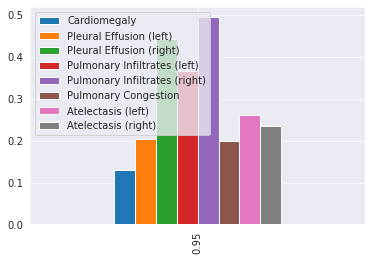

-------------------------------------------
R1


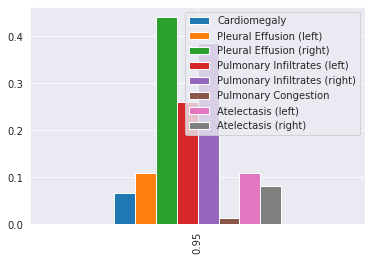

-------------------------------------------
R2


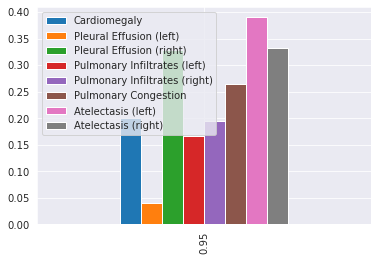

-------------------------------------------
R3


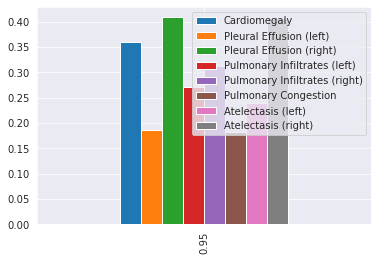

-------------------------------------------
R4


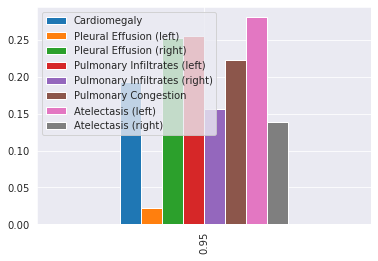

-------------------------------------------
R5


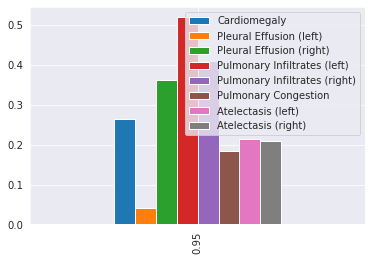

-------------------------------------------
R6


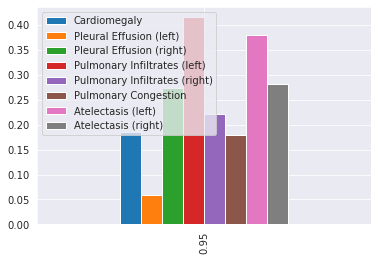

-------------------------------------------
NON-R1


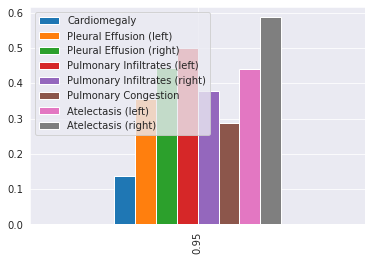

-------------------------------------------
NON-R1+AI


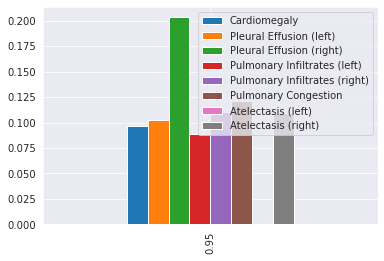

-------------------------------------------
NON-R2


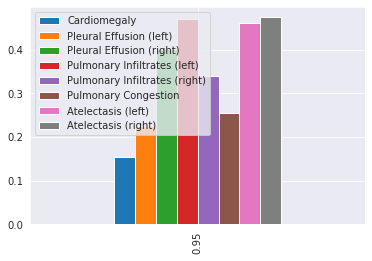

-------------------------------------------
NON-R2+AI


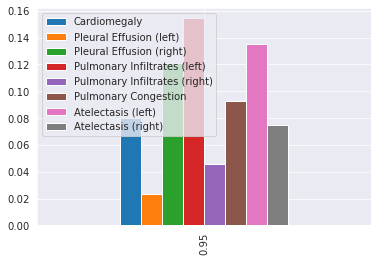

In [472]:
## Plot of the 95 quantil
for key in df_kappa_samples_differences.keys():
    df_tmp = pd.DataFrame()
    print('-------------------------------------------')
    print(key)
    for label in columns_of_interest:
        df_tmp[label] = df_kappa_samples_differences[key][label].quantile([0.95])
    df_tmp.plot(kind='bar')
    plt.show()
        

In [473]:
for key in df_kappa_samples_challengers_dict.keys():
    print('-------------------------------------------')
    print(key)
    for label in columns_of_interest:
        print('---------------------')
        print(label)
        print(df_kappa_samples_challengers_dict[key][label].quantile([0.025, 0.950, 0.975]))
        print("Std: ", df_kappa_samples_challengers_dict[key][label].std())

-------------------------------------------
RR
---------------------
Cardiomegaly
0.025    0.386283
0.950    0.621102
0.975    0.642562
Name: Cardiomegaly, dtype: object
Std:  0.06652338133745521
---------------------
Pleural Effusion (left)
0.025    0.385524
0.950    0.652487
0.975    0.673525
Name: Pleural Effusion (left), dtype: object
Std:  0.07286088665367456
---------------------
Pleural Effusion (right)
0.025    0.346042
0.950    0.628444
0.975    0.645045
Name: Pleural Effusion (right), dtype: object
Std:  0.07570038271201453
---------------------
Pulmonary Infiltrates (left)
0.025    0.290303
0.950    0.628076
0.975    0.657927
Name: Pulmonary Infiltrates (left), dtype: object
Std:  0.09498169883011973
---------------------
Pulmonary Infiltrates (right)
0.025    0.158851
0.950    0.477811
0.975     0.51333
Name: Pulmonary Infiltrates (right), dtype: object
Std:  0.09048060662615197
---------------------
Pulmonary Congestion
0.025    0.123472
0.950    0.393622
0.975    0.410094

Name: Atelectasis (left), dtype: object
Std:  0.07862823703655107
---------------------
Atelectasis (right)
0.025    0.208168
0.950    0.495974
0.975    0.519266
Name: Atelectasis (right), dtype: object
Std:  0.07866199627529177
-------------------------------------------
NON-R2+AI
---------------------
Cardiomegaly
0.025    0.376628
0.950    0.624134
0.975    0.641389
Name: Cardiomegaly, dtype: object
Std:  0.06723897169225389
---------------------
Pleural Effusion (left)
0.025    0.523305
0.950    0.746968
0.975    0.762121
Name: Pleural Effusion (left), dtype: object
Std:  0.06171912922709368
---------------------
Pleural Effusion (right)
0.025    0.707056
0.950    0.915781
0.975    0.927091
Name: Pleural Effusion (right), dtype: object
Std:  0.058081440280158034
---------------------
Pulmonary Infiltrates (left)
0.025    0.371501
0.950    0.760613
0.975    0.785622
Name: Pulmonary Infiltrates (left), dtype: object
Std:  0.11093294166919711
---------------------
Pulmonary Infiltrate

In [474]:
for key in df_kappa_samples_prediction_dict.keys():
    print('-------------------------------------------')
    print(key)
    for label in columns_of_interest:
        print('---------------------')
        print(label)
        print(df_kappa_samples_prediction_dict[key][label].quantile([0.025, 0.950, 0.975]))
        print("Std: ", df_kappa_samples_prediction_dict[key][label].std())

-------------------------------------------
RR
---------------------
Cardiomegaly
0.025    0.361829
0.950    0.612146
0.975      0.6362
Name: Cardiomegaly, dtype: object
Std:  0.0693808075414089
---------------------
Pleural Effusion (left)
0.025    0.482927
0.950    0.731538
0.975    0.751208
Name: Pleural Effusion (left), dtype: object
Std:  0.06909617701066825
---------------------
Pleural Effusion (right)
0.025    0.657877
0.950     0.89464
0.975    0.910787
Name: Pleural Effusion (right), dtype: object
Std:  0.06481432476258825
---------------------
Pulmonary Infiltrates (left)
0.025    0.407442
0.950    0.768882
0.975    0.793038
Name: Pulmonary Infiltrates (left), dtype: object
Std:  0.10327614447430714
---------------------
Pulmonary Infiltrates (right)
0.025    0.485998
0.950    0.790974
0.975    0.816312
Name: Pulmonary Infiltrates (right), dtype: object
Std:  0.0876822402488985
---------------------
Pulmonary Congestion
0.025    0.128454
0.950    0.451239
0.975    0.467901
N

-------------------------------------------
NON-R1+AI
---------------------
Cardiomegaly
0.025    0.381042
0.950    0.632785
0.975    0.656205
Name: Cardiomegaly, dtype: object
Std:  0.07039336738241489
---------------------
Pleural Effusion (left)
0.025    0.459235
0.950    0.706935
0.975    0.732948
Name: Pleural Effusion (left), dtype: object
Std:  0.07011784231632688
---------------------
Pleural Effusion (right)
0.025    0.754666
0.950    0.946975
0.975    0.964777
Name: Pleural Effusion (right), dtype: object
Std:  0.0556647067813674
---------------------
Pulmonary Infiltrates (left)
0.025    0.435362
0.950    0.832414
0.975    0.854494
Name: Pulmonary Infiltrates (left), dtype: object
Std:  0.10924934888059964
---------------------
Pulmonary Infiltrates (right)
0.025    0.380654
0.950    0.712221
0.975    0.739359
Name: Pulmonary Infiltrates (right), dtype: object
Std:  0.09291062944682596
---------------------
Pulmonary Congestion
0.025    0.242243
0.950    0.543324
0.975    0.

In [491]:
pi = math.pi
def make_spider(data_challenger1, std_challenger1, data_challenger2, std_challenger2, categorie_names, challenger_names, title='default title', column='auc', i=0):
    sns.set()
    # number of variable
    categories = categorie_names
    N = len(categories)    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]    # Initialise the spider plot
    
    plt.figure(figsize=(5,5))
    ax = plt.subplot(1,1,i+1, polar=True)    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=9)    # Draw ylabels
    ax.set_rlabel_position(0)
    
    angles_2 = [n / float(N) * 360 for n in range(N)]
    ax.set_thetagrids(angles_2, categories)  # Set the label for each axis
    ax.tick_params(pad=70)
    
    
    data_challenger1 = data_challenger1.append(pd.Series({data_challenger1.index[0]: data_challenger1[0]}))
    std_challenger1 = std_challenger1.append(pd.Series({std_challenger1.index[0]: std_challenger1[0]}))
    data_challenger2 = data_challenger2.append(pd.Series({data_challenger2.index[0]: data_challenger2[0]}))
    std_challenger2 = std_challenger2.append(pd.Series({std_challenger2.index[0]: std_challenger2[0]}))
    
    plt.yticks(size=9)
    ax.errorbar(angles, data_challenger1, std_challenger1, linewidth=1, linestyle='solid'
                , elinewidth=1.5, label=challenger_names[0], fmt=palette[0], ecolor=palette[0])    
    ax.errorbar(angles, data_challenger2, std_challenger2, linewidth=1, linestyle='solid',
                elinewidth=1.5, label=challenger_names[1], fmt=palette[1], ecolor=palette[1])    
    ax.xaxis.grid(True,linestyle='-.')
    ax.spines['polar'].set_visible(False)
    
    plt.legend(loc='lower right', prop={'size': 10}, bbox_to_anchor=(1.3,0.135))


In [476]:
df_kappa_samples_std_dict = {}
for key in df_kappa_samples_challengers_dict.keys():
    df_std = pd.DataFrame(index=columns_of_interest, columns=['NN', key])
    for label in columns_of_interest:
        nn_std = df_kappa_samples_prediction_dict[key][label].std()
        challenger_std =  df_kappa_samples_challengers_dict[key][label].std()
        df_std.loc[label] = pd.Series({'NN': nn_std, key: challenger_std})
    df_kappa_samples_std_dict[key] = df_std

###### Cohens Kappa (pred, selected radiologist vs majority voting of other radiologists (including groundtruth)) - With Std. Dev

-------------------------------------------------------------------------------------------------------
RR


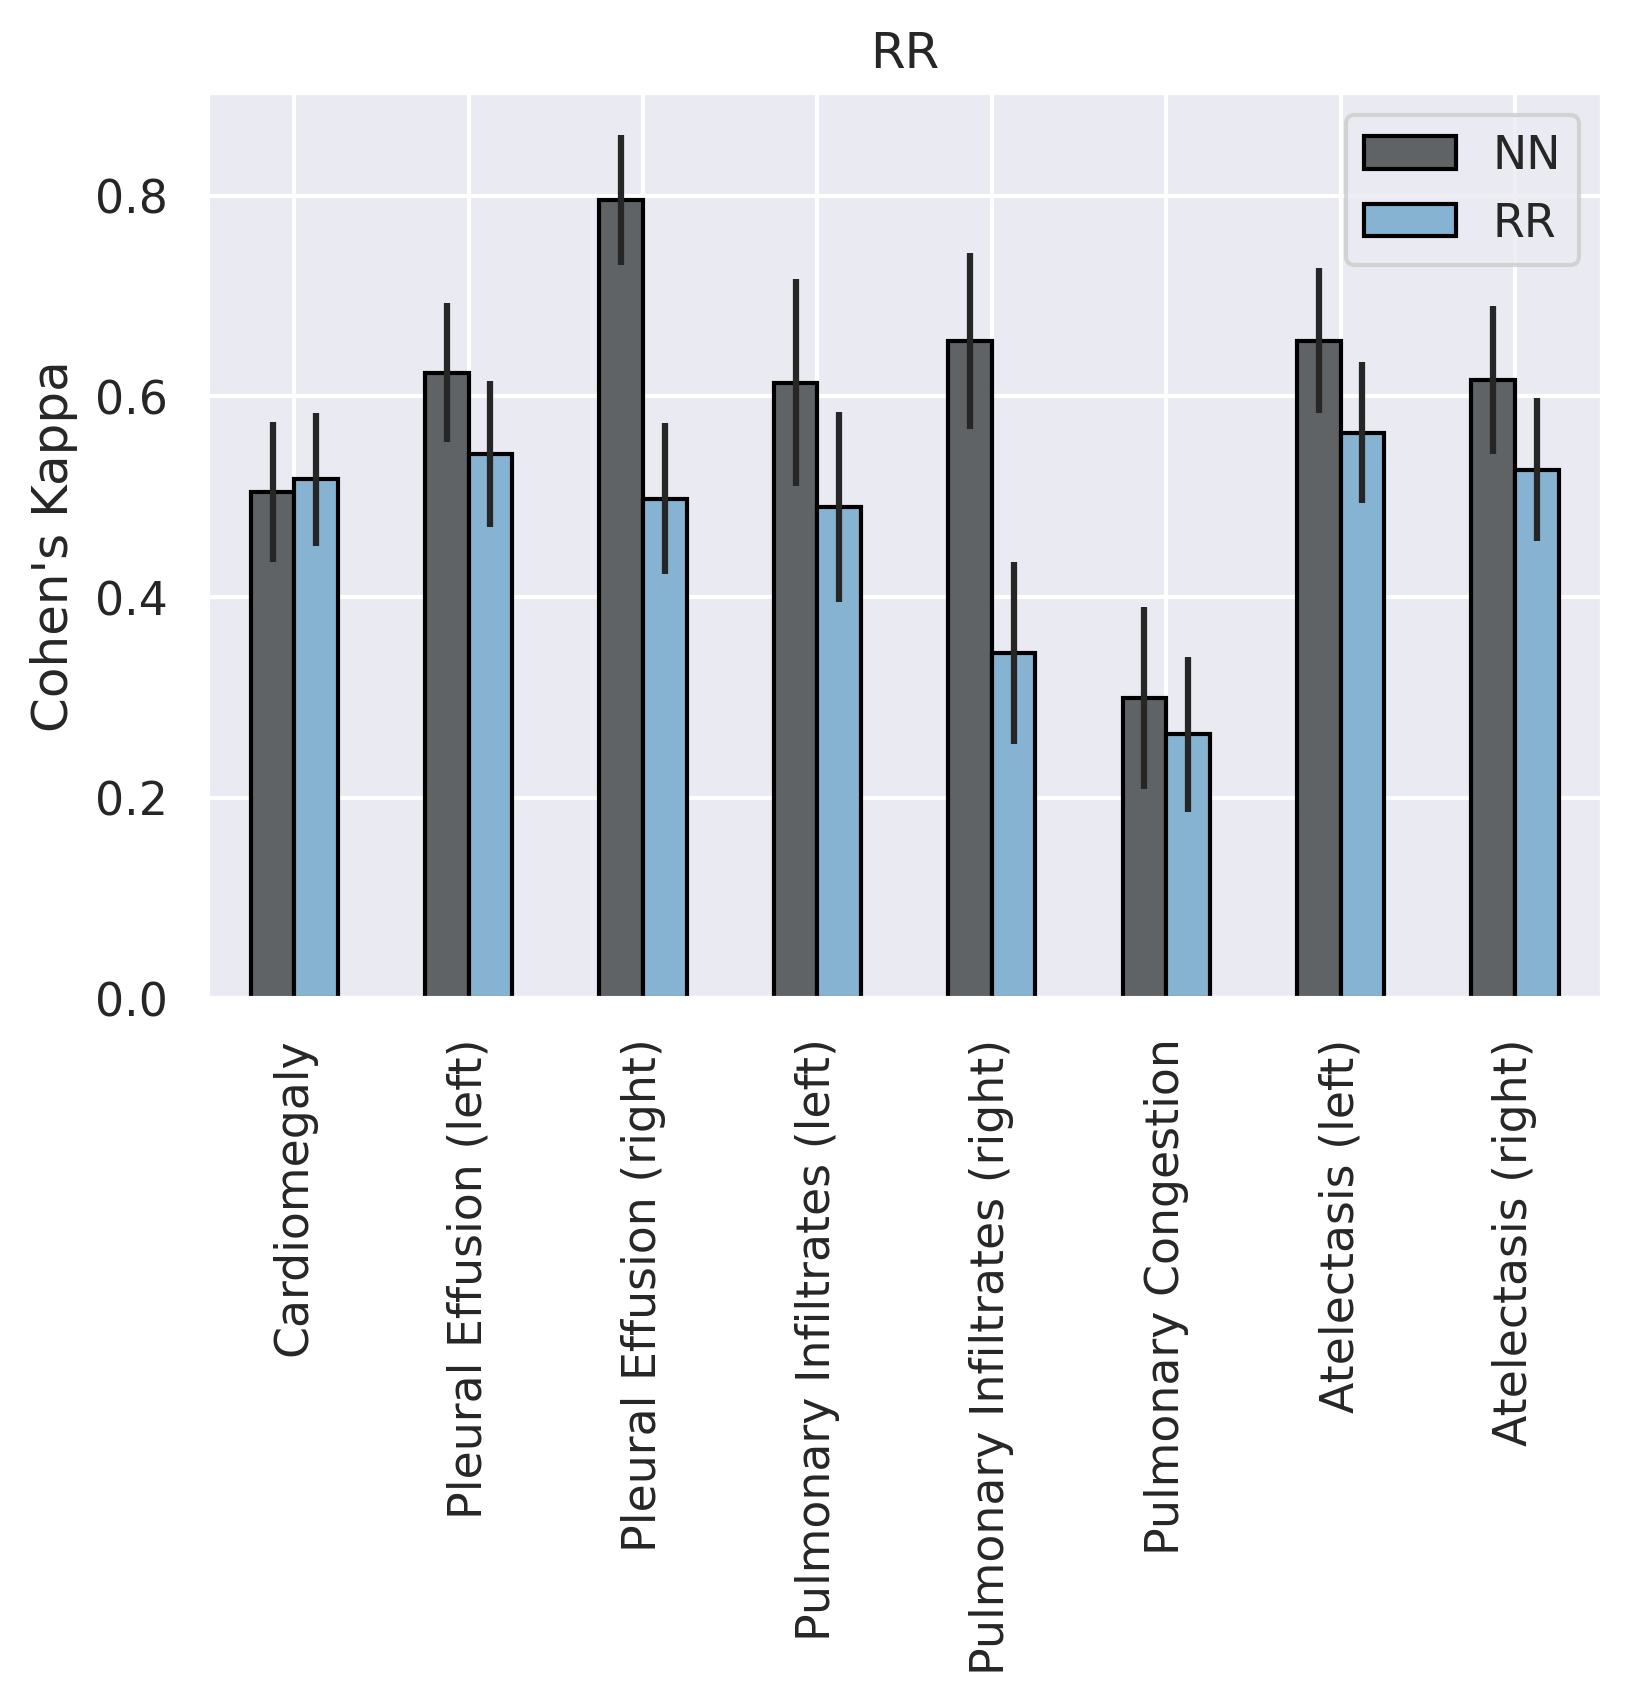

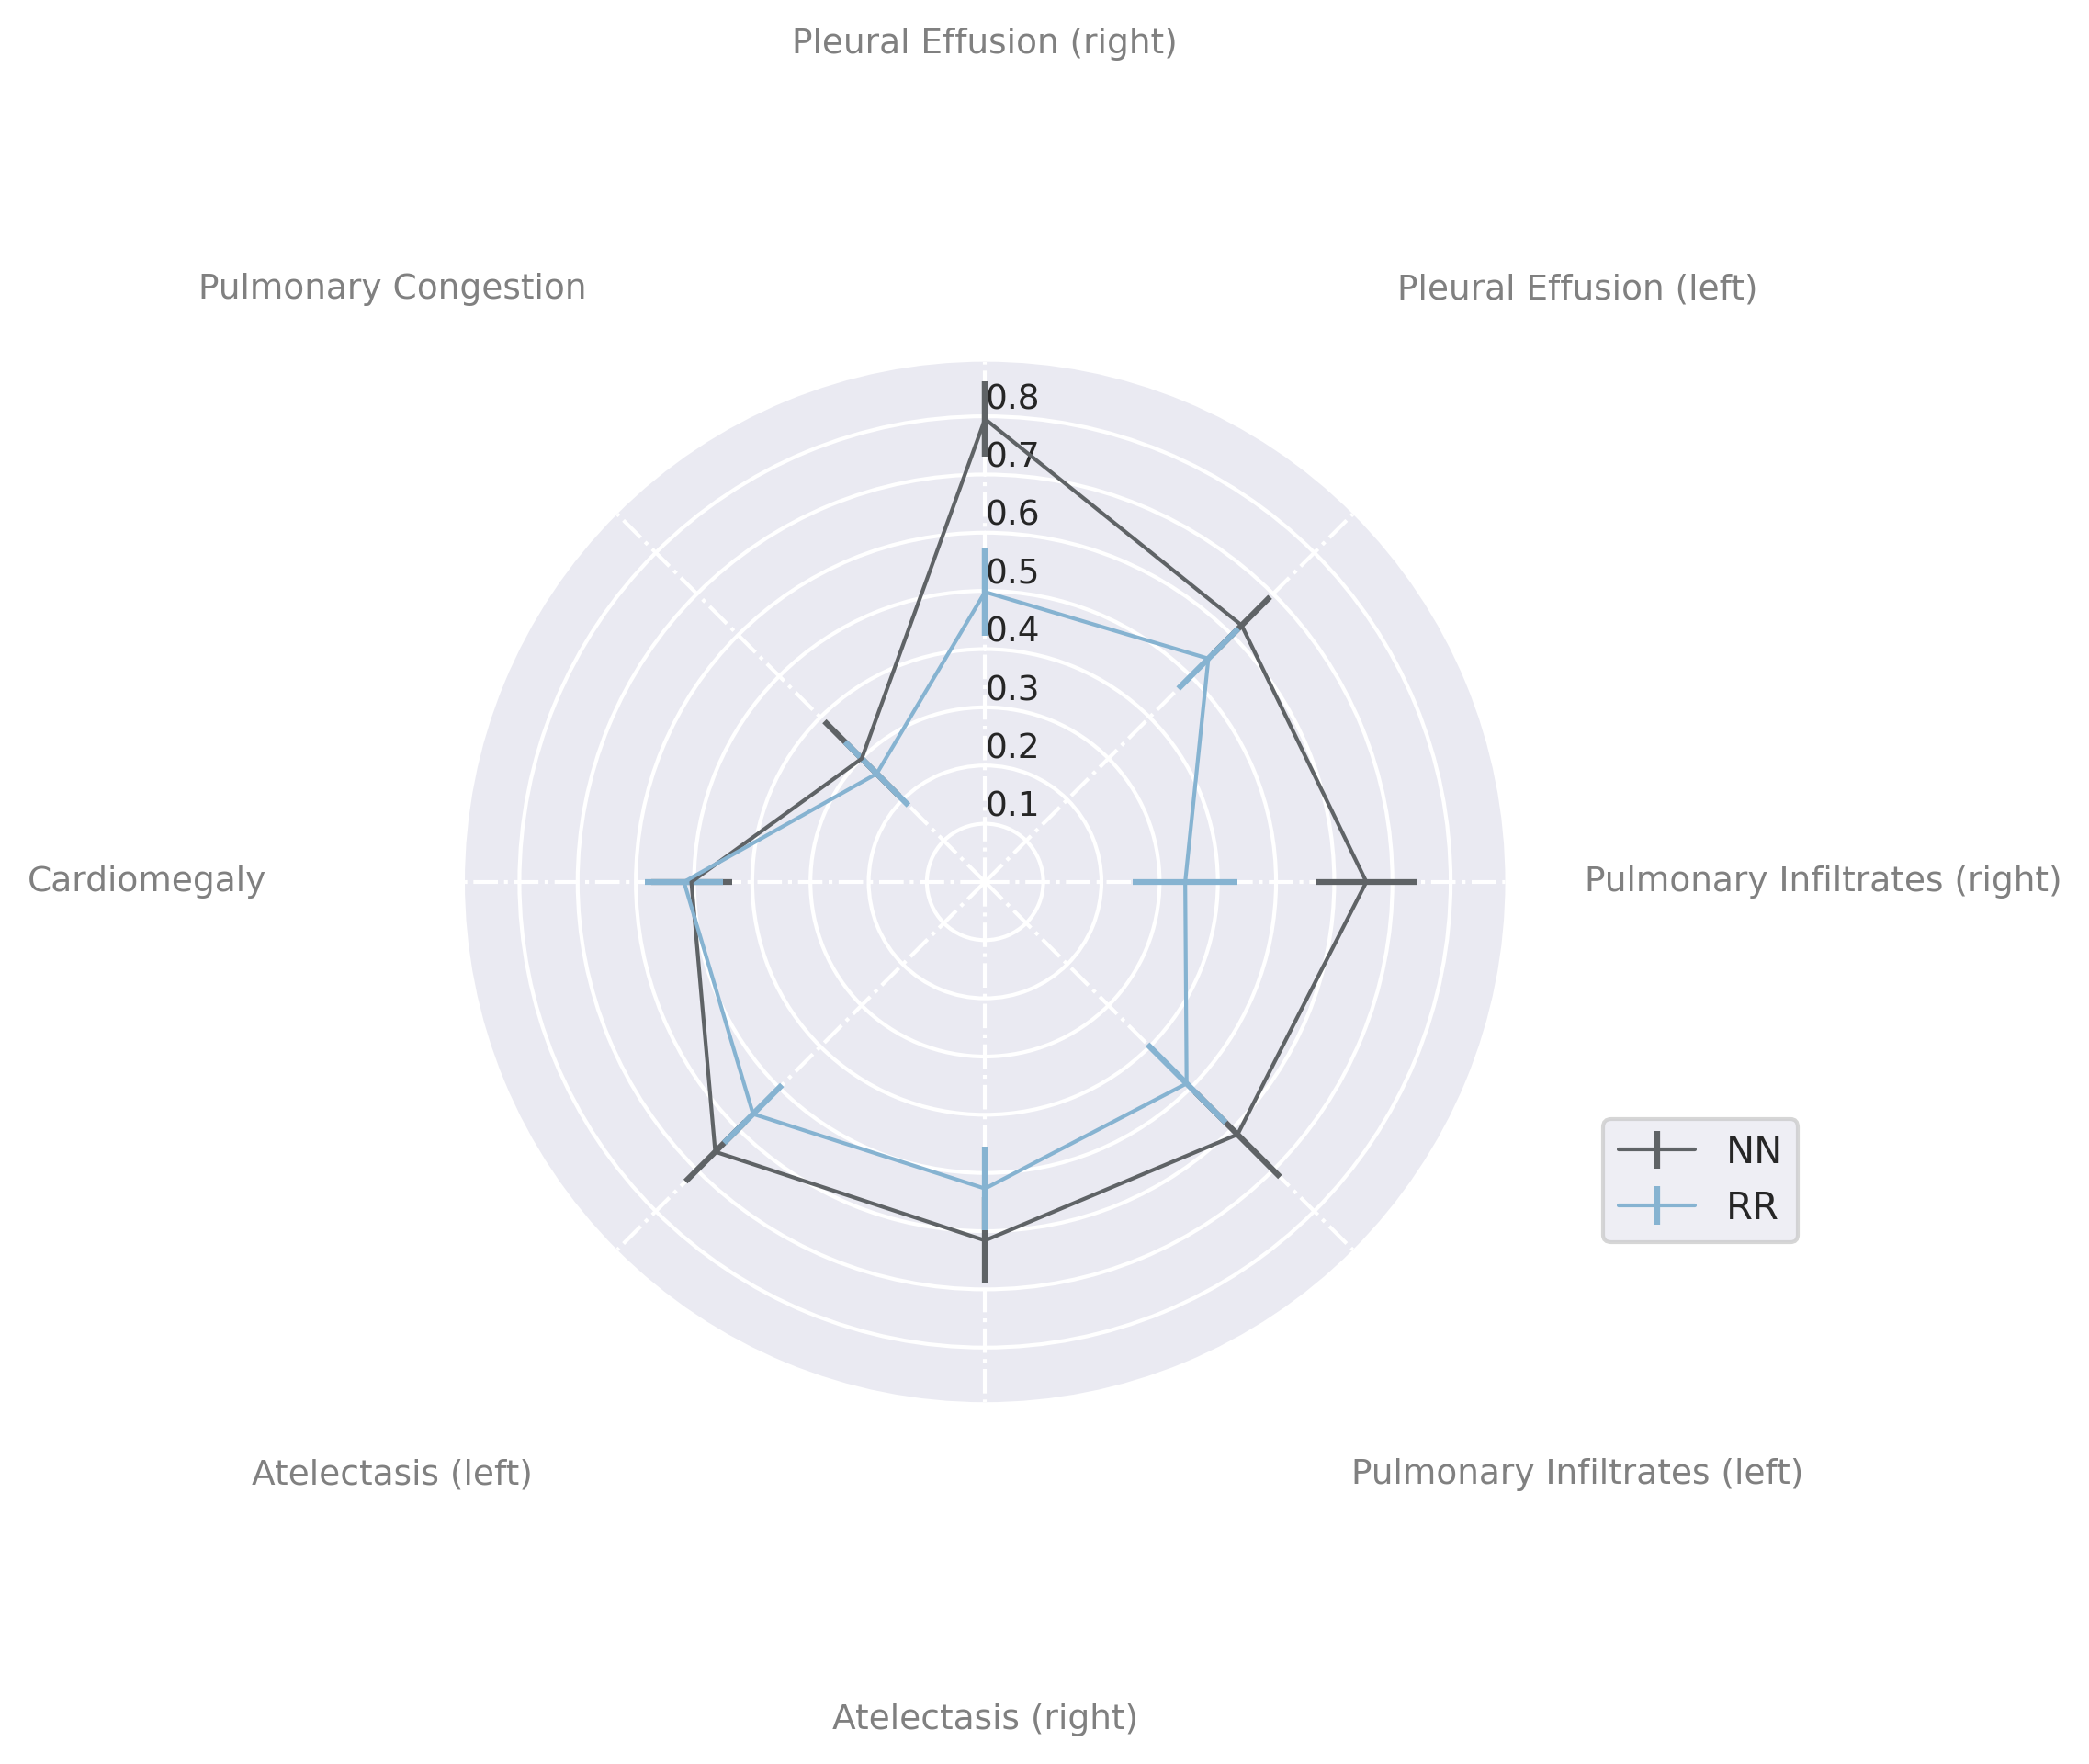

-------------------------------------------------------------------------------------------------------
R1


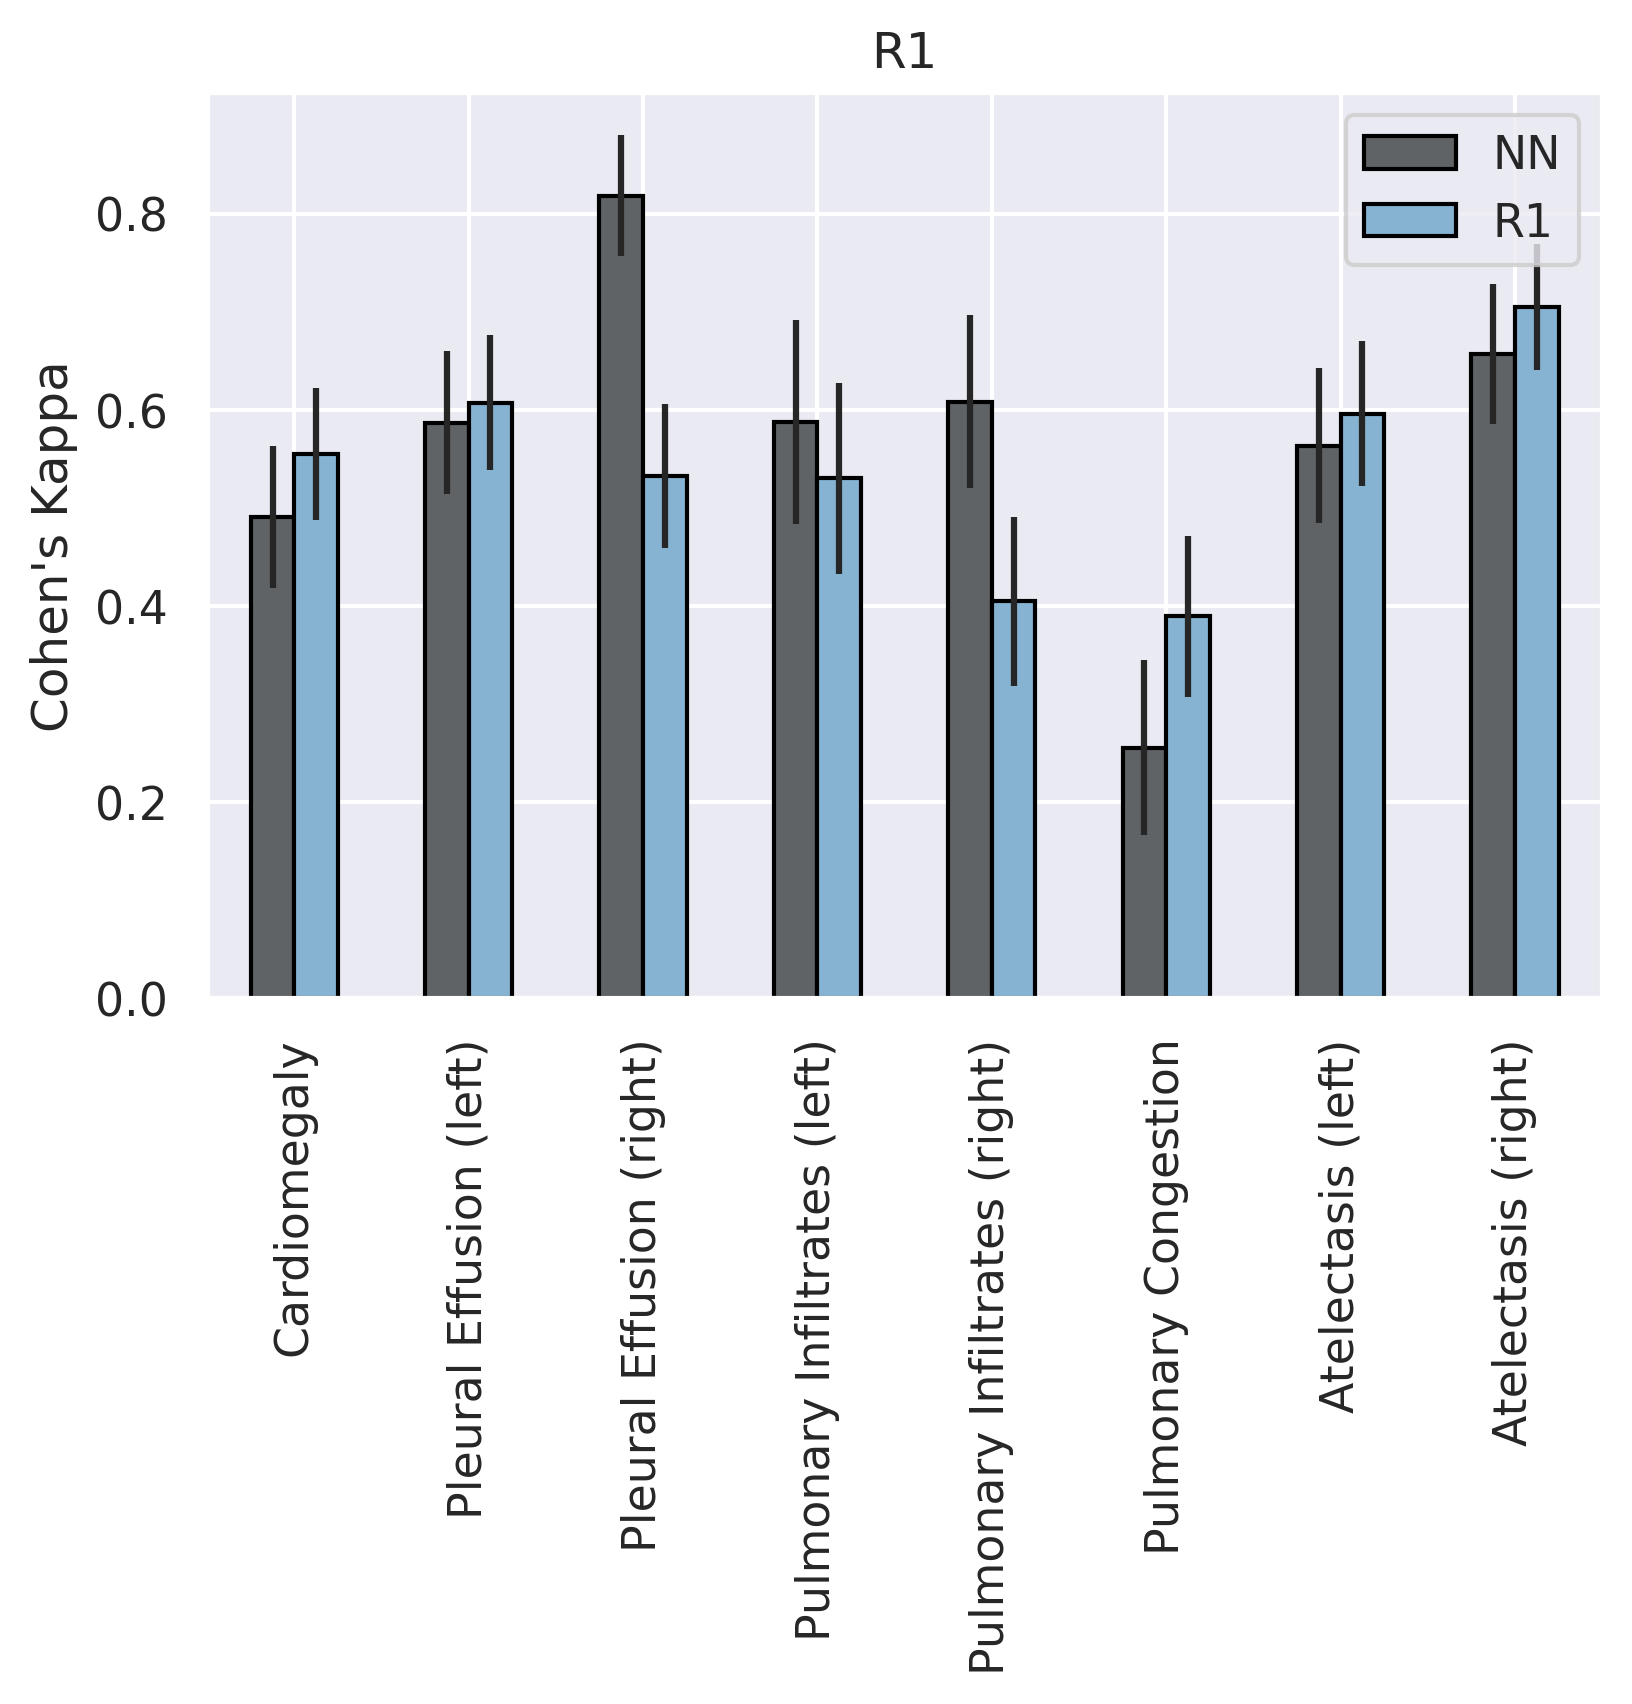

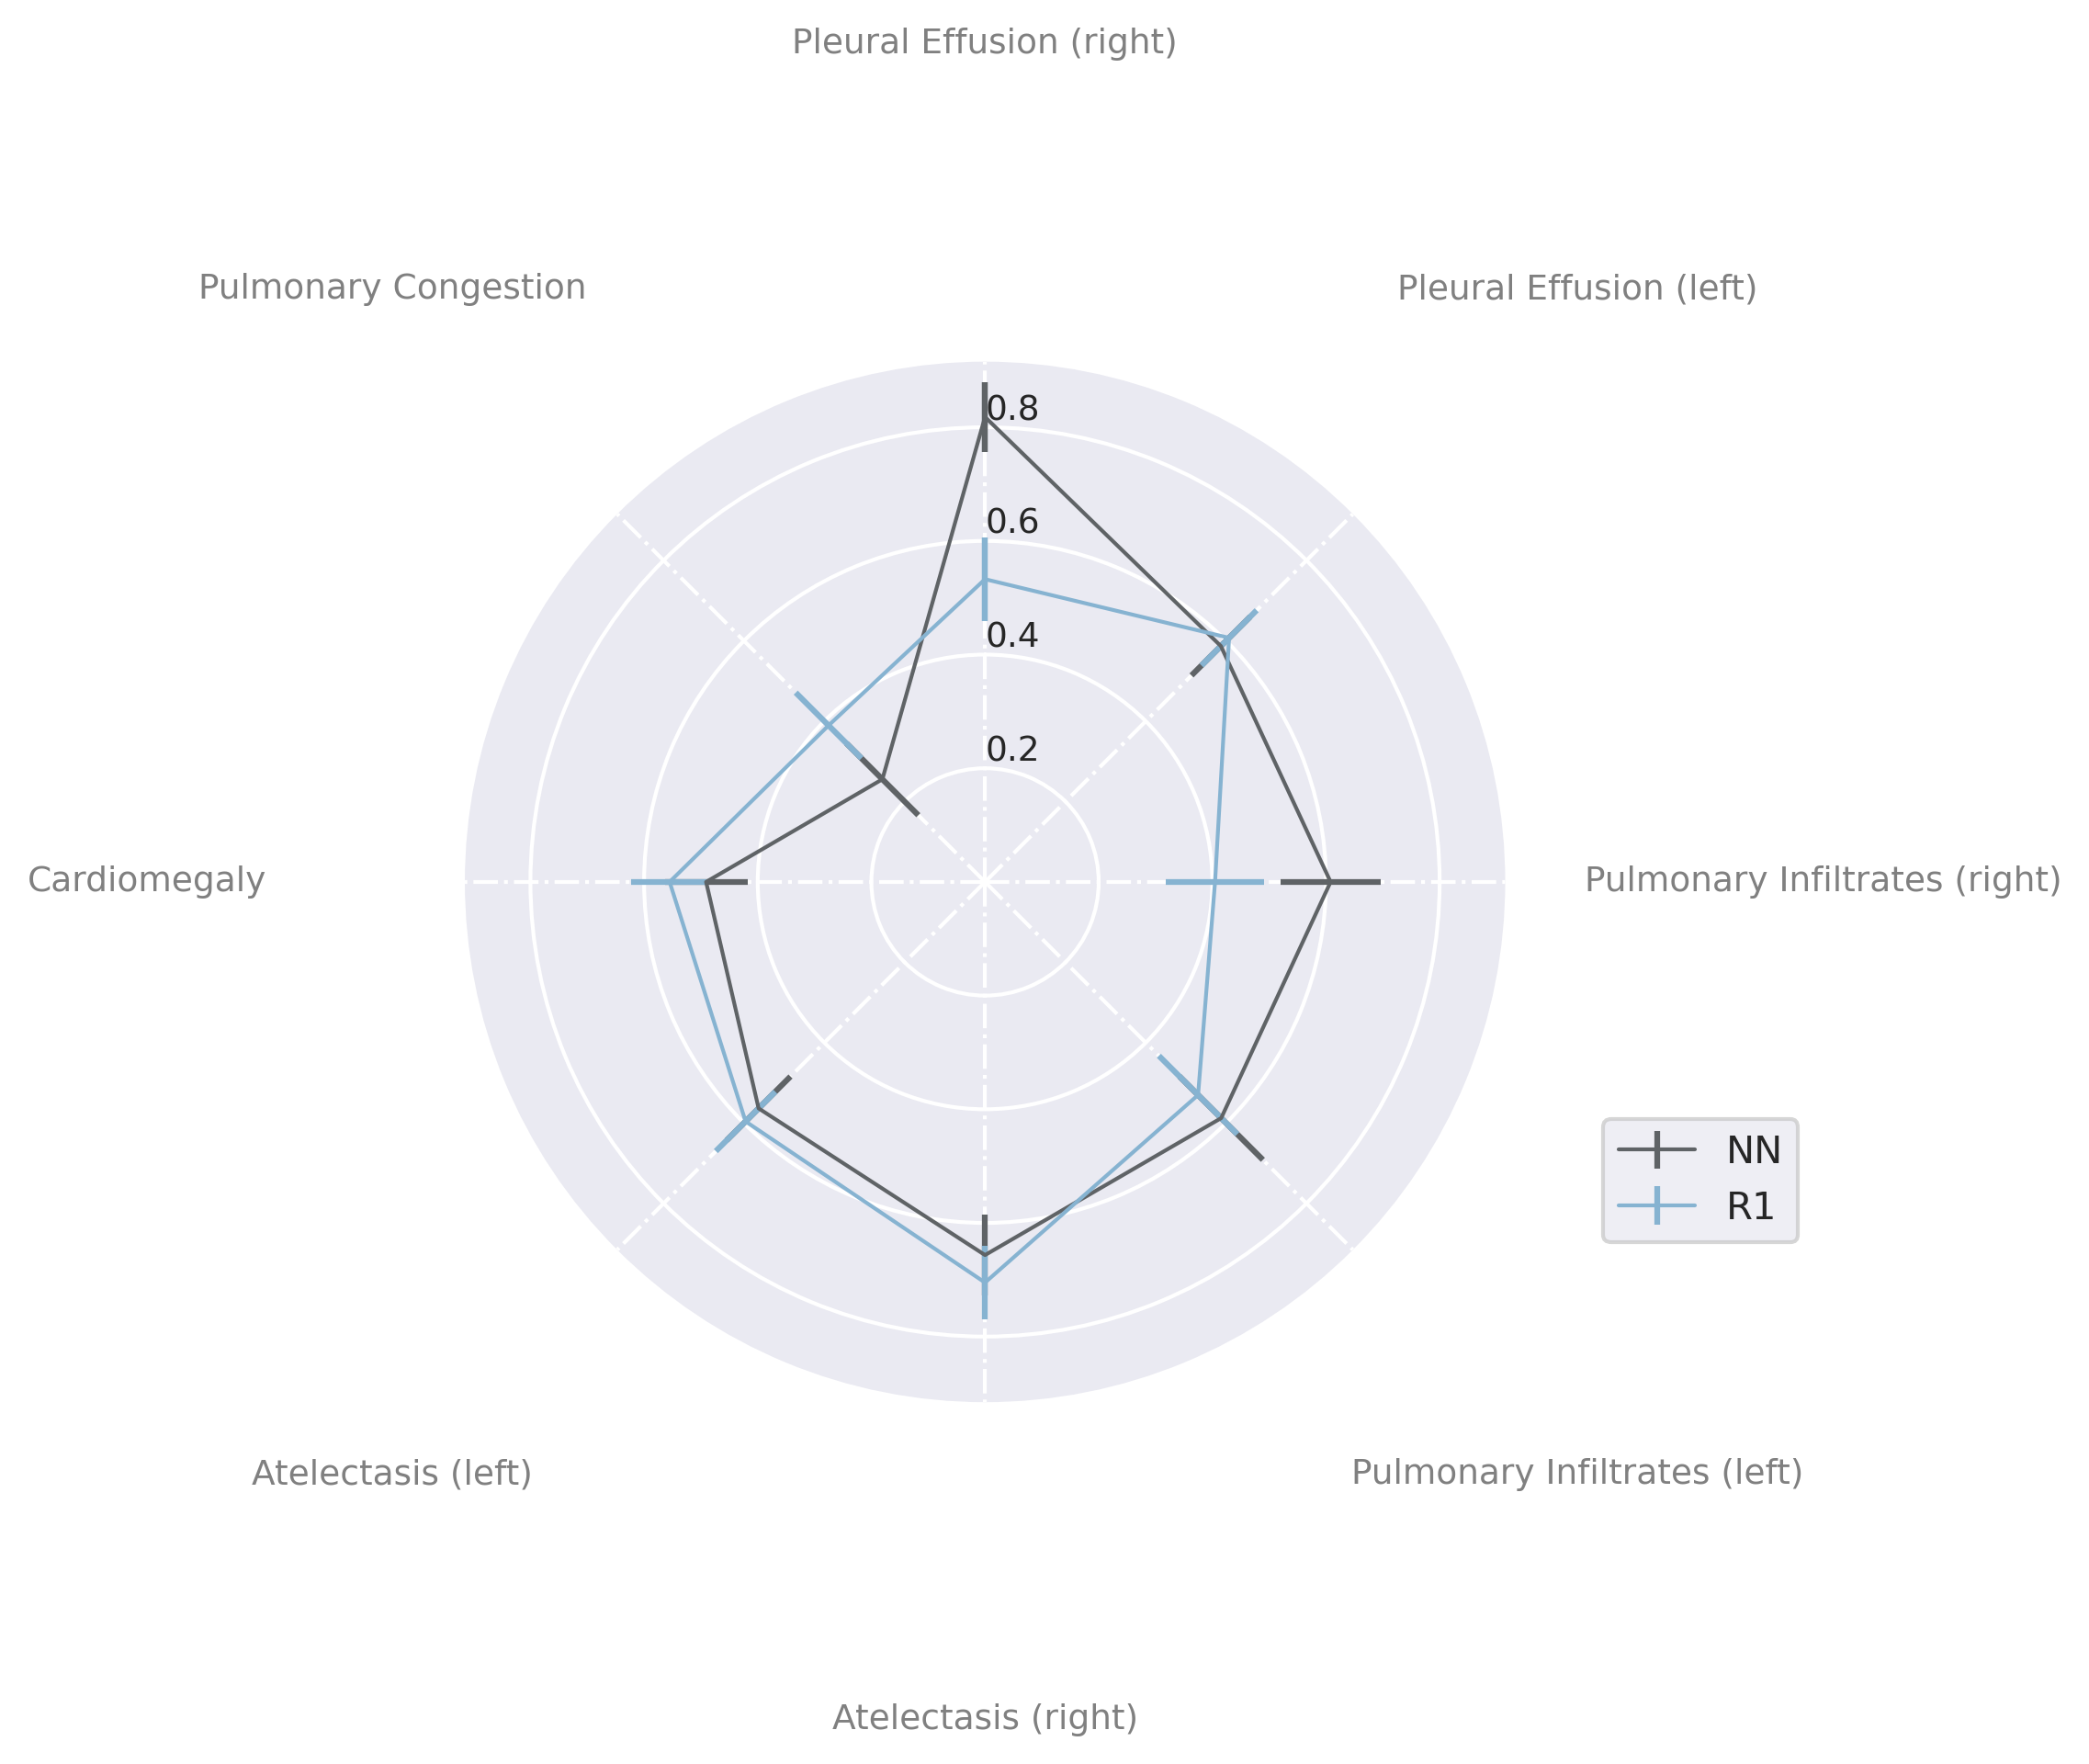

-------------------------------------------------------------------------------------------------------
R2


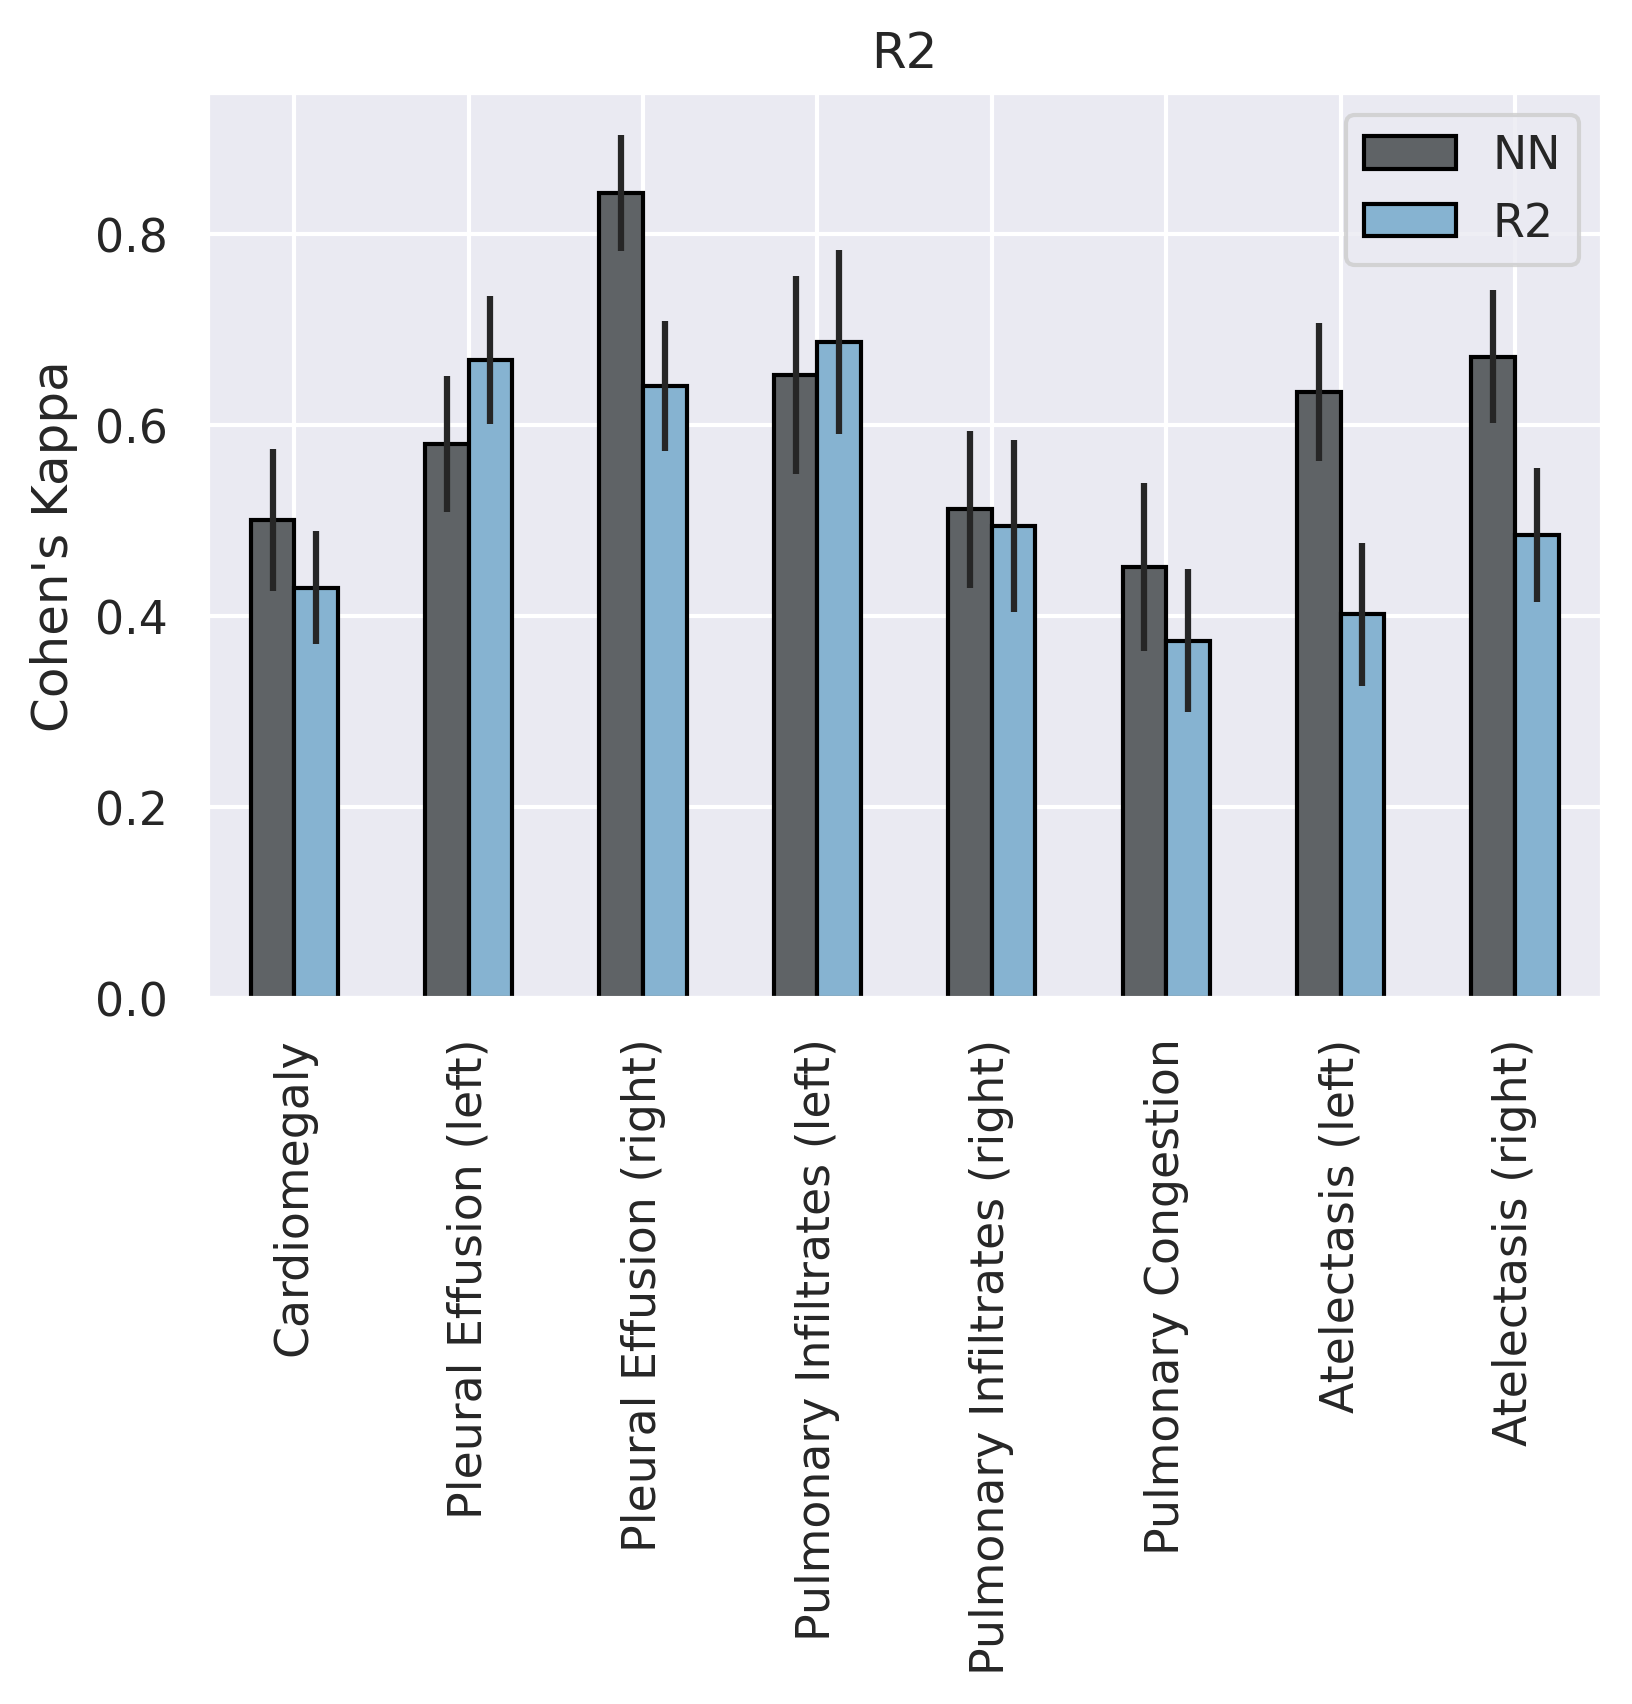

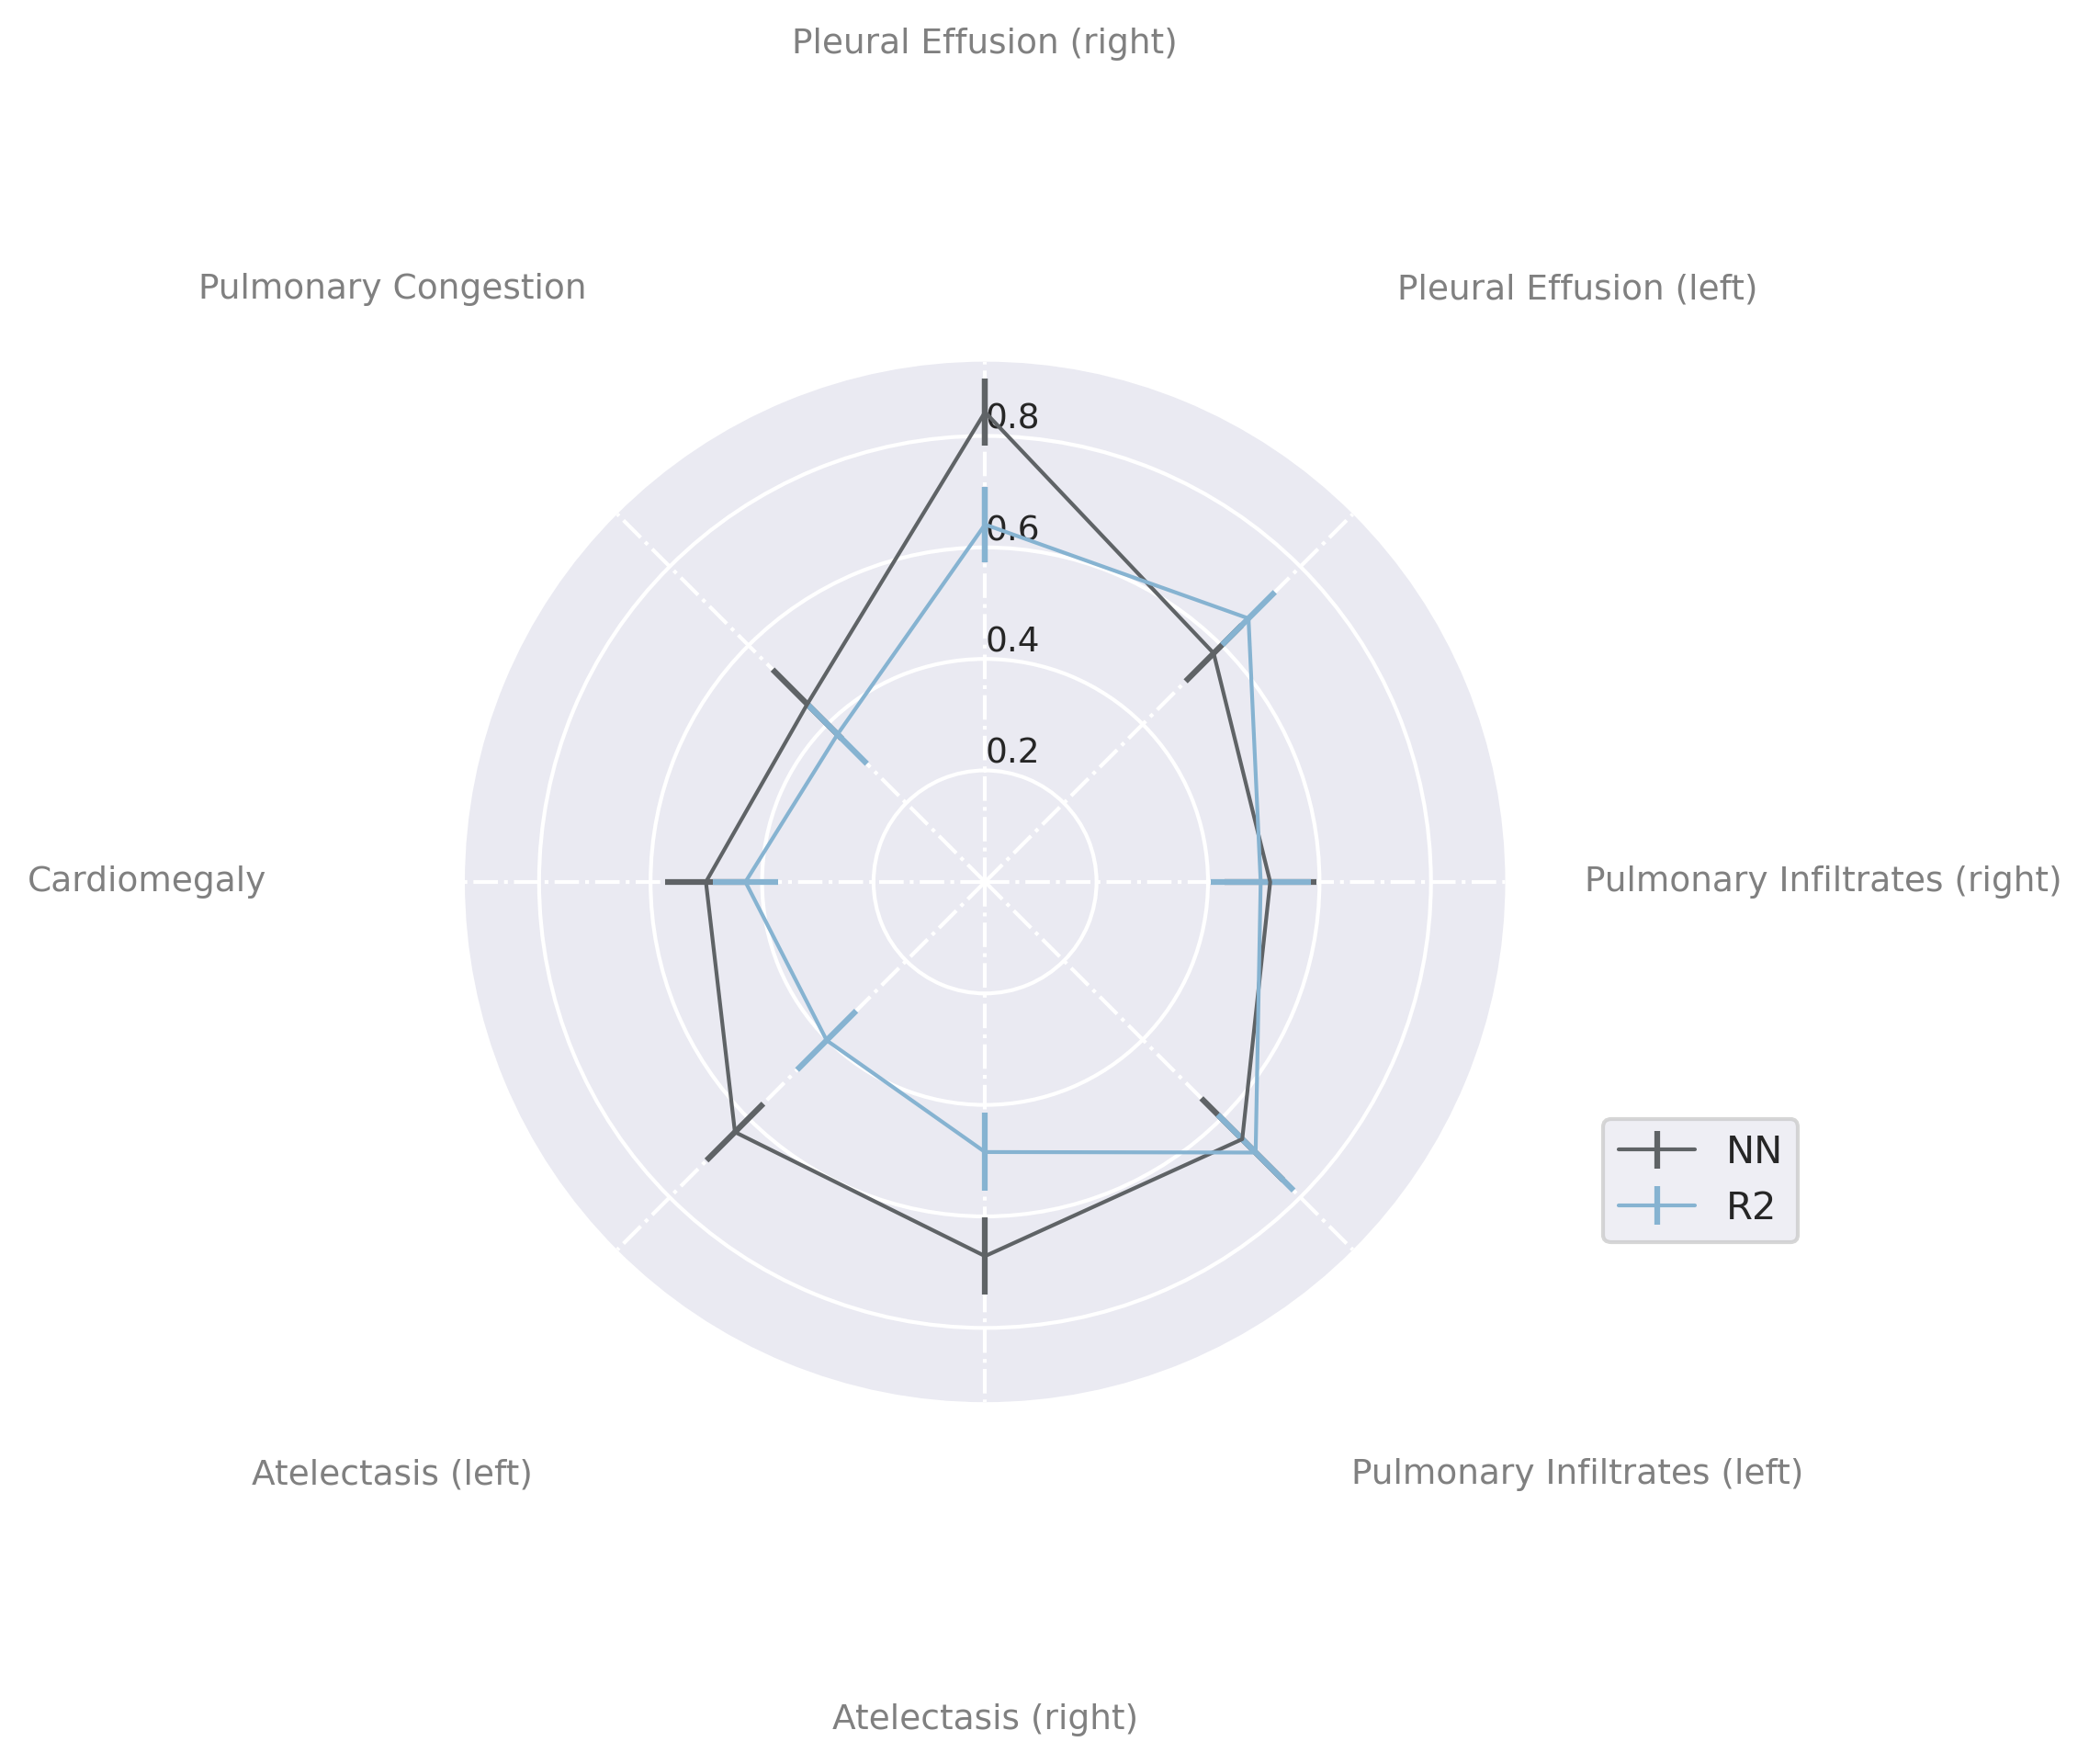

-------------------------------------------------------------------------------------------------------
R3


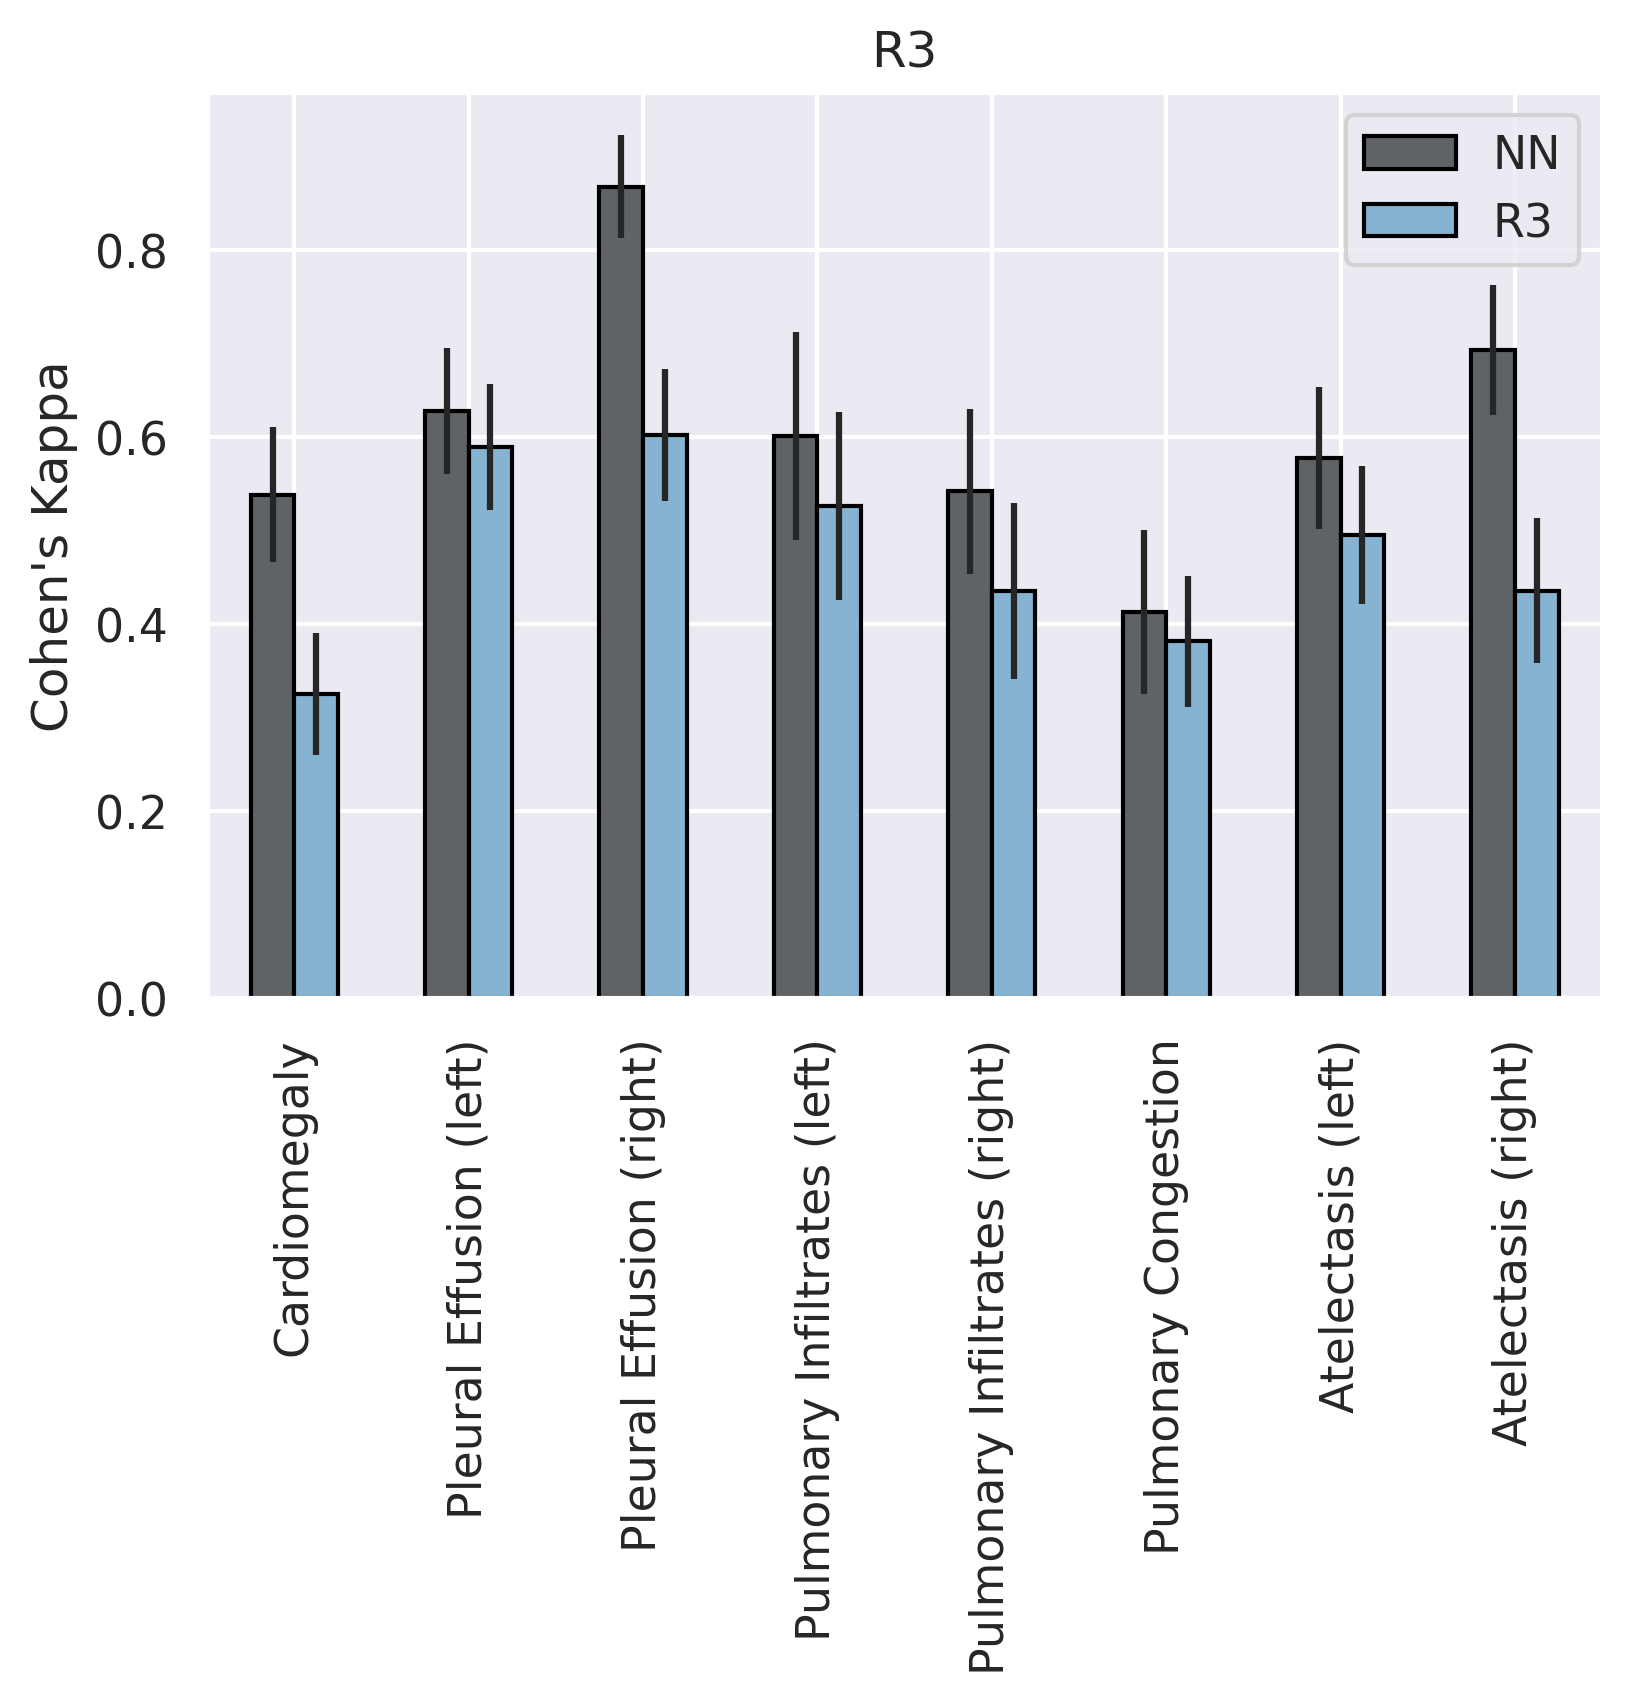

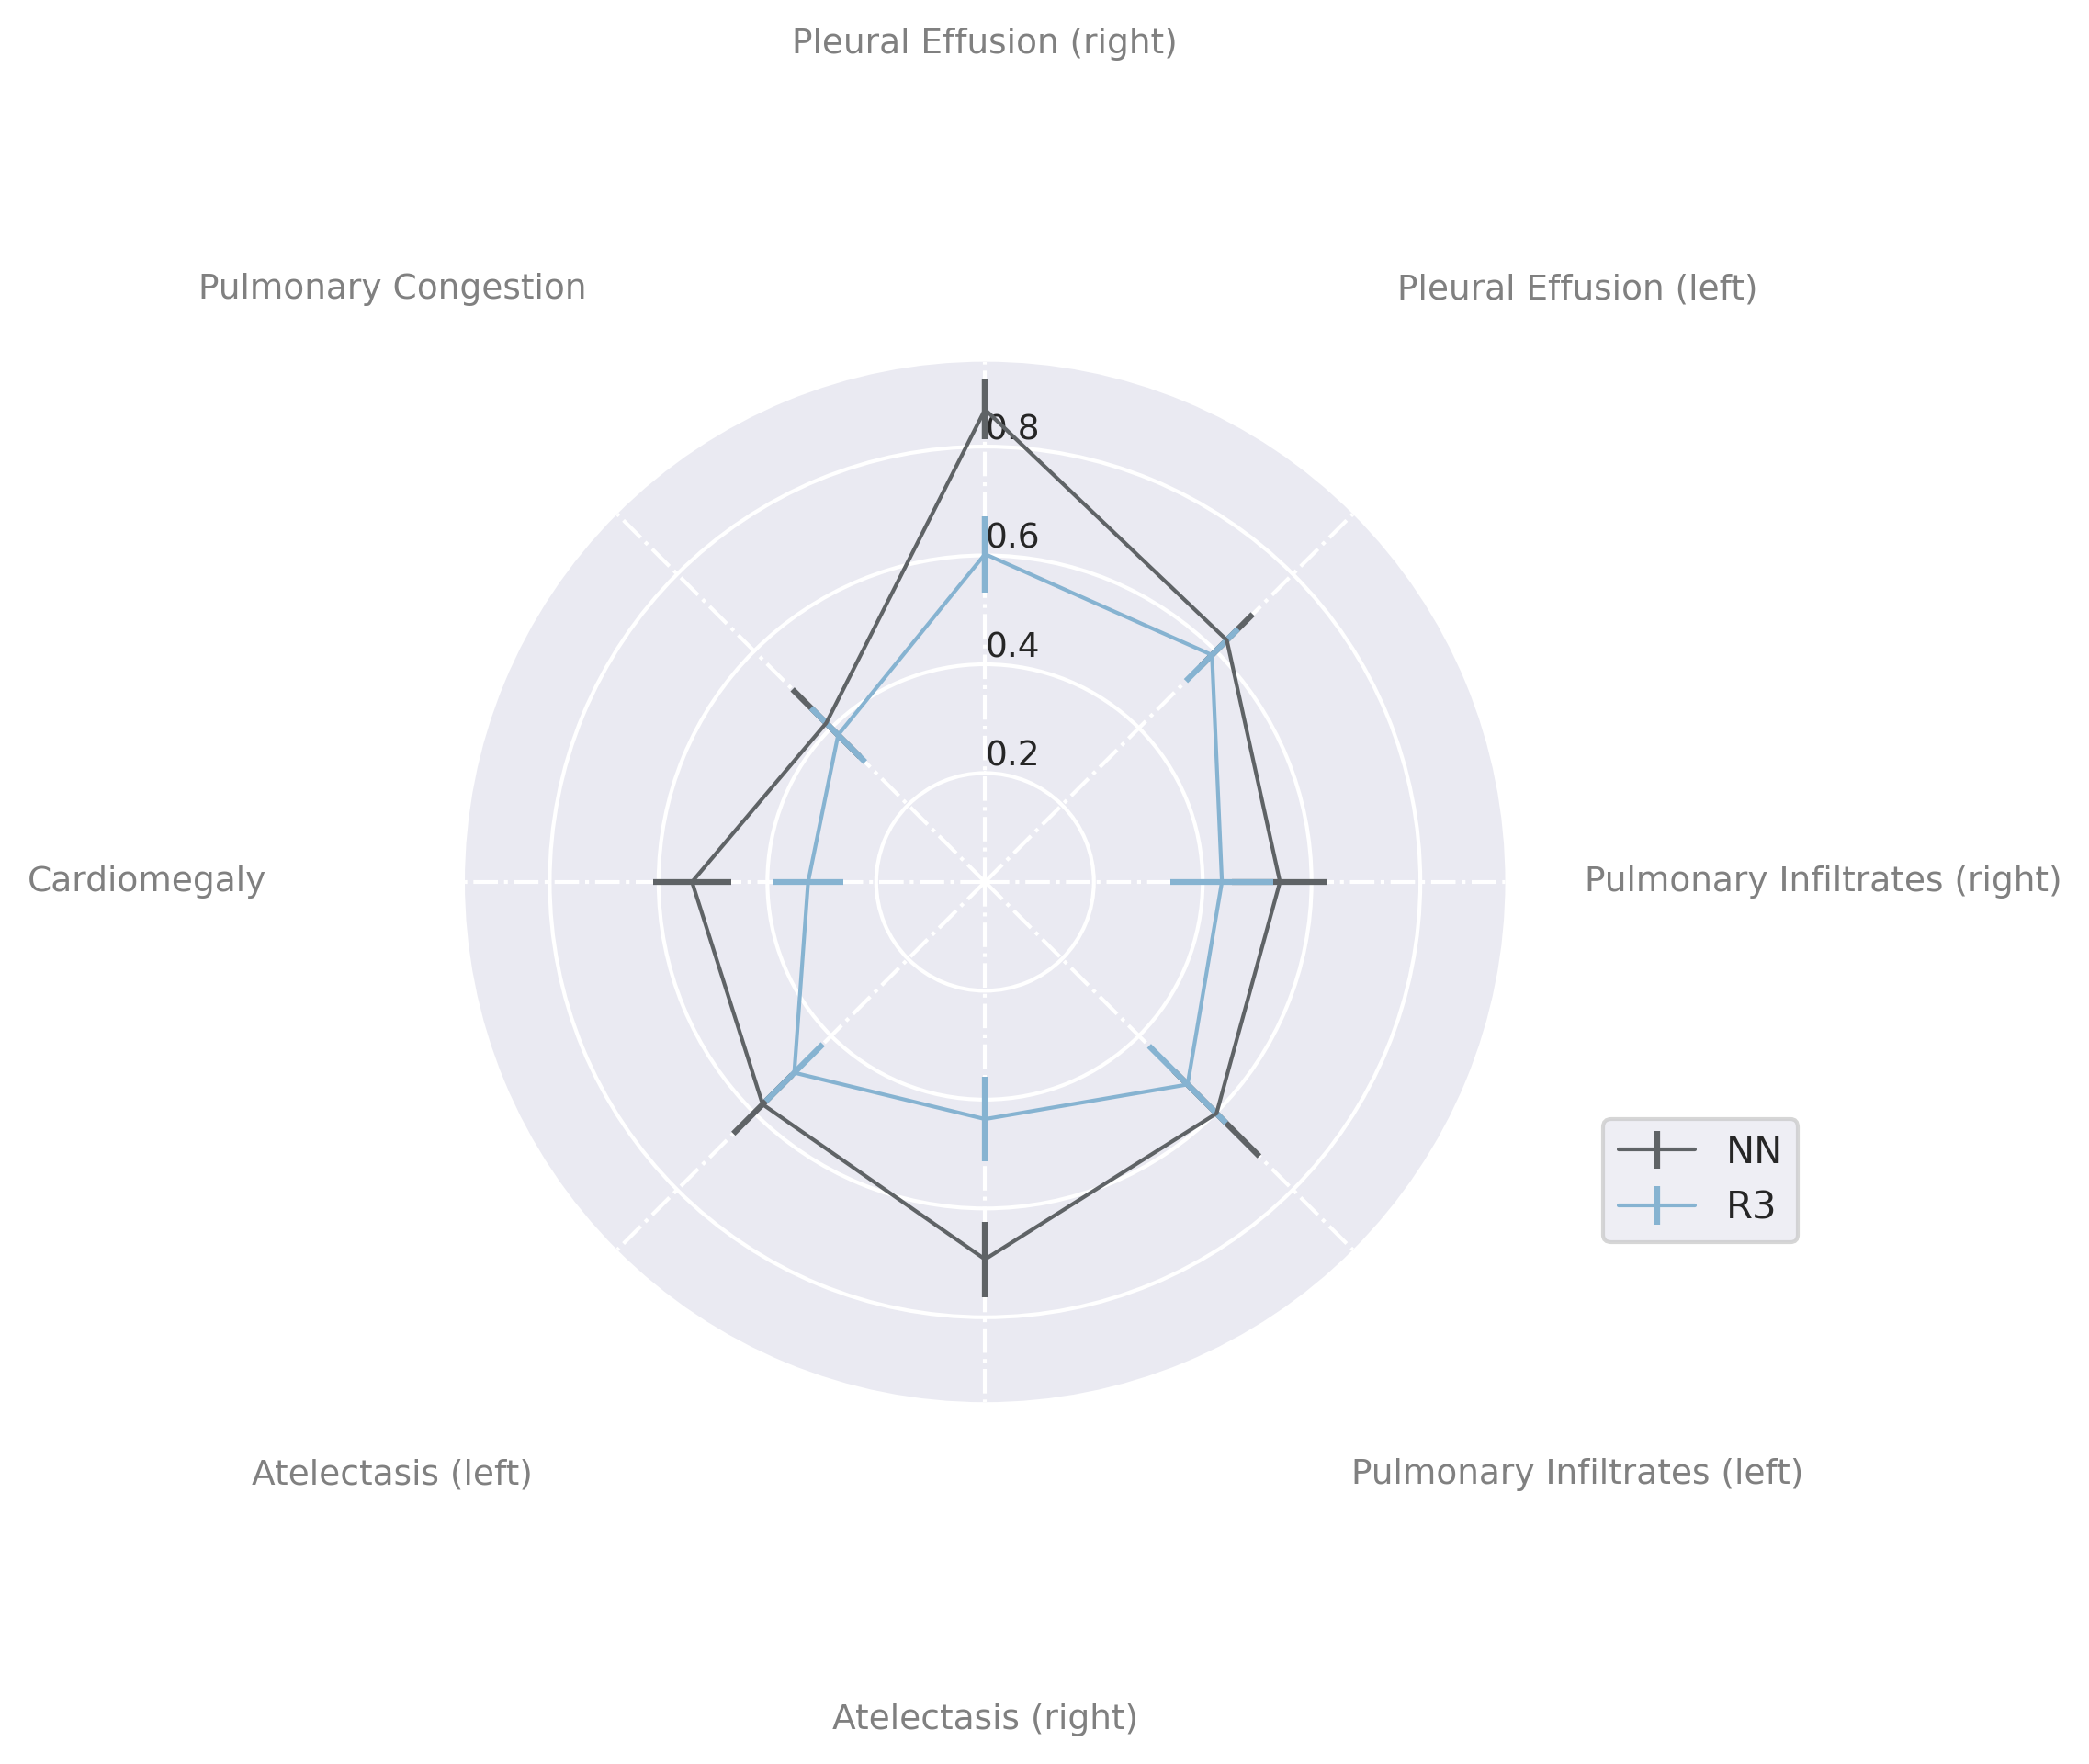

-------------------------------------------------------------------------------------------------------
R4


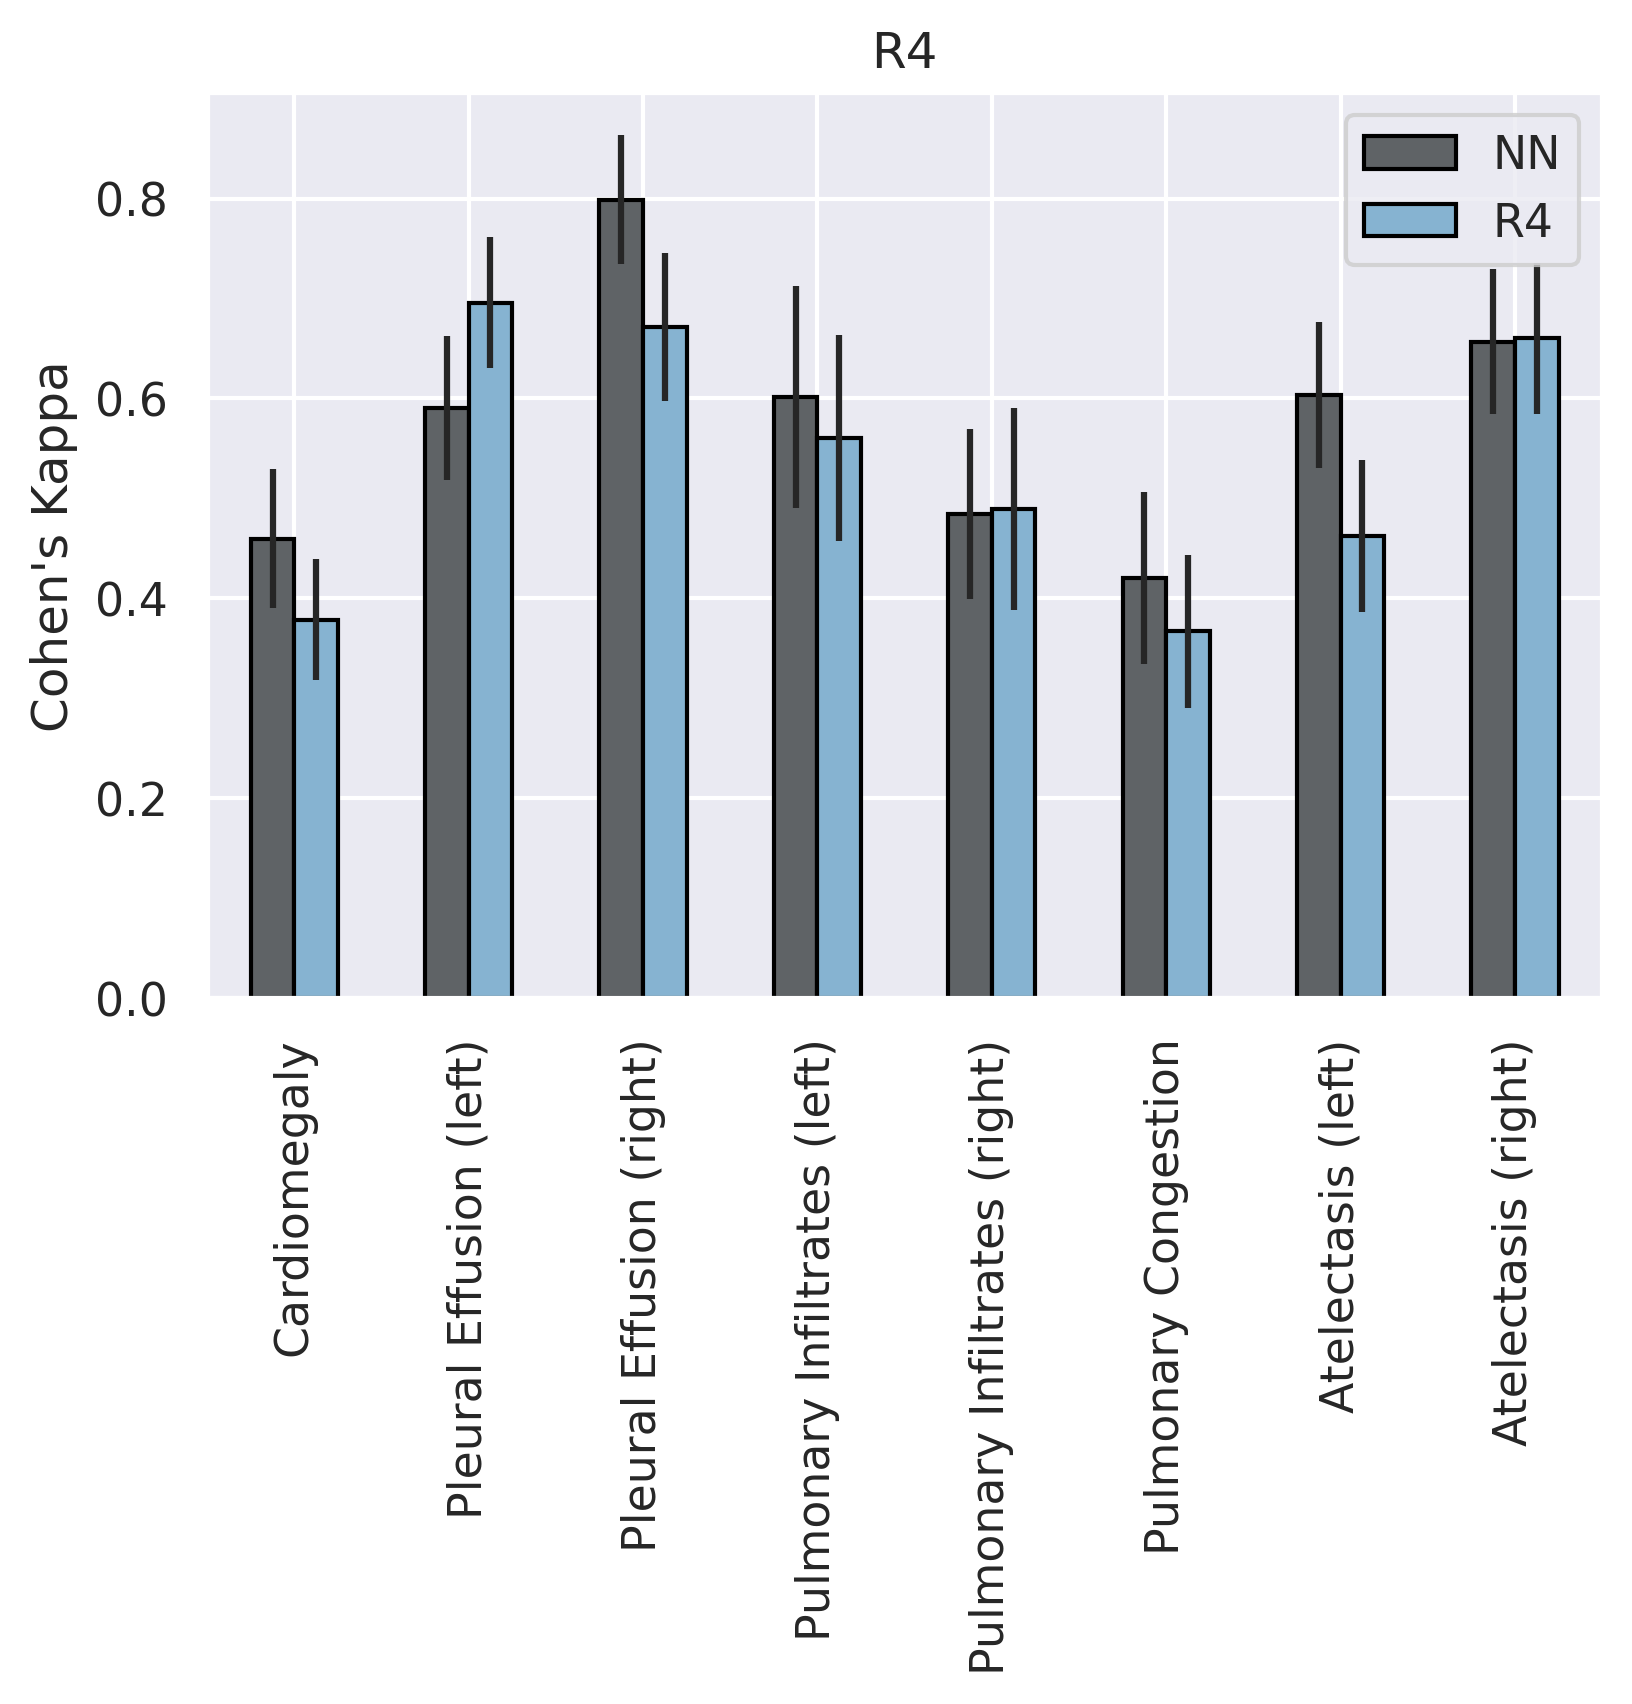

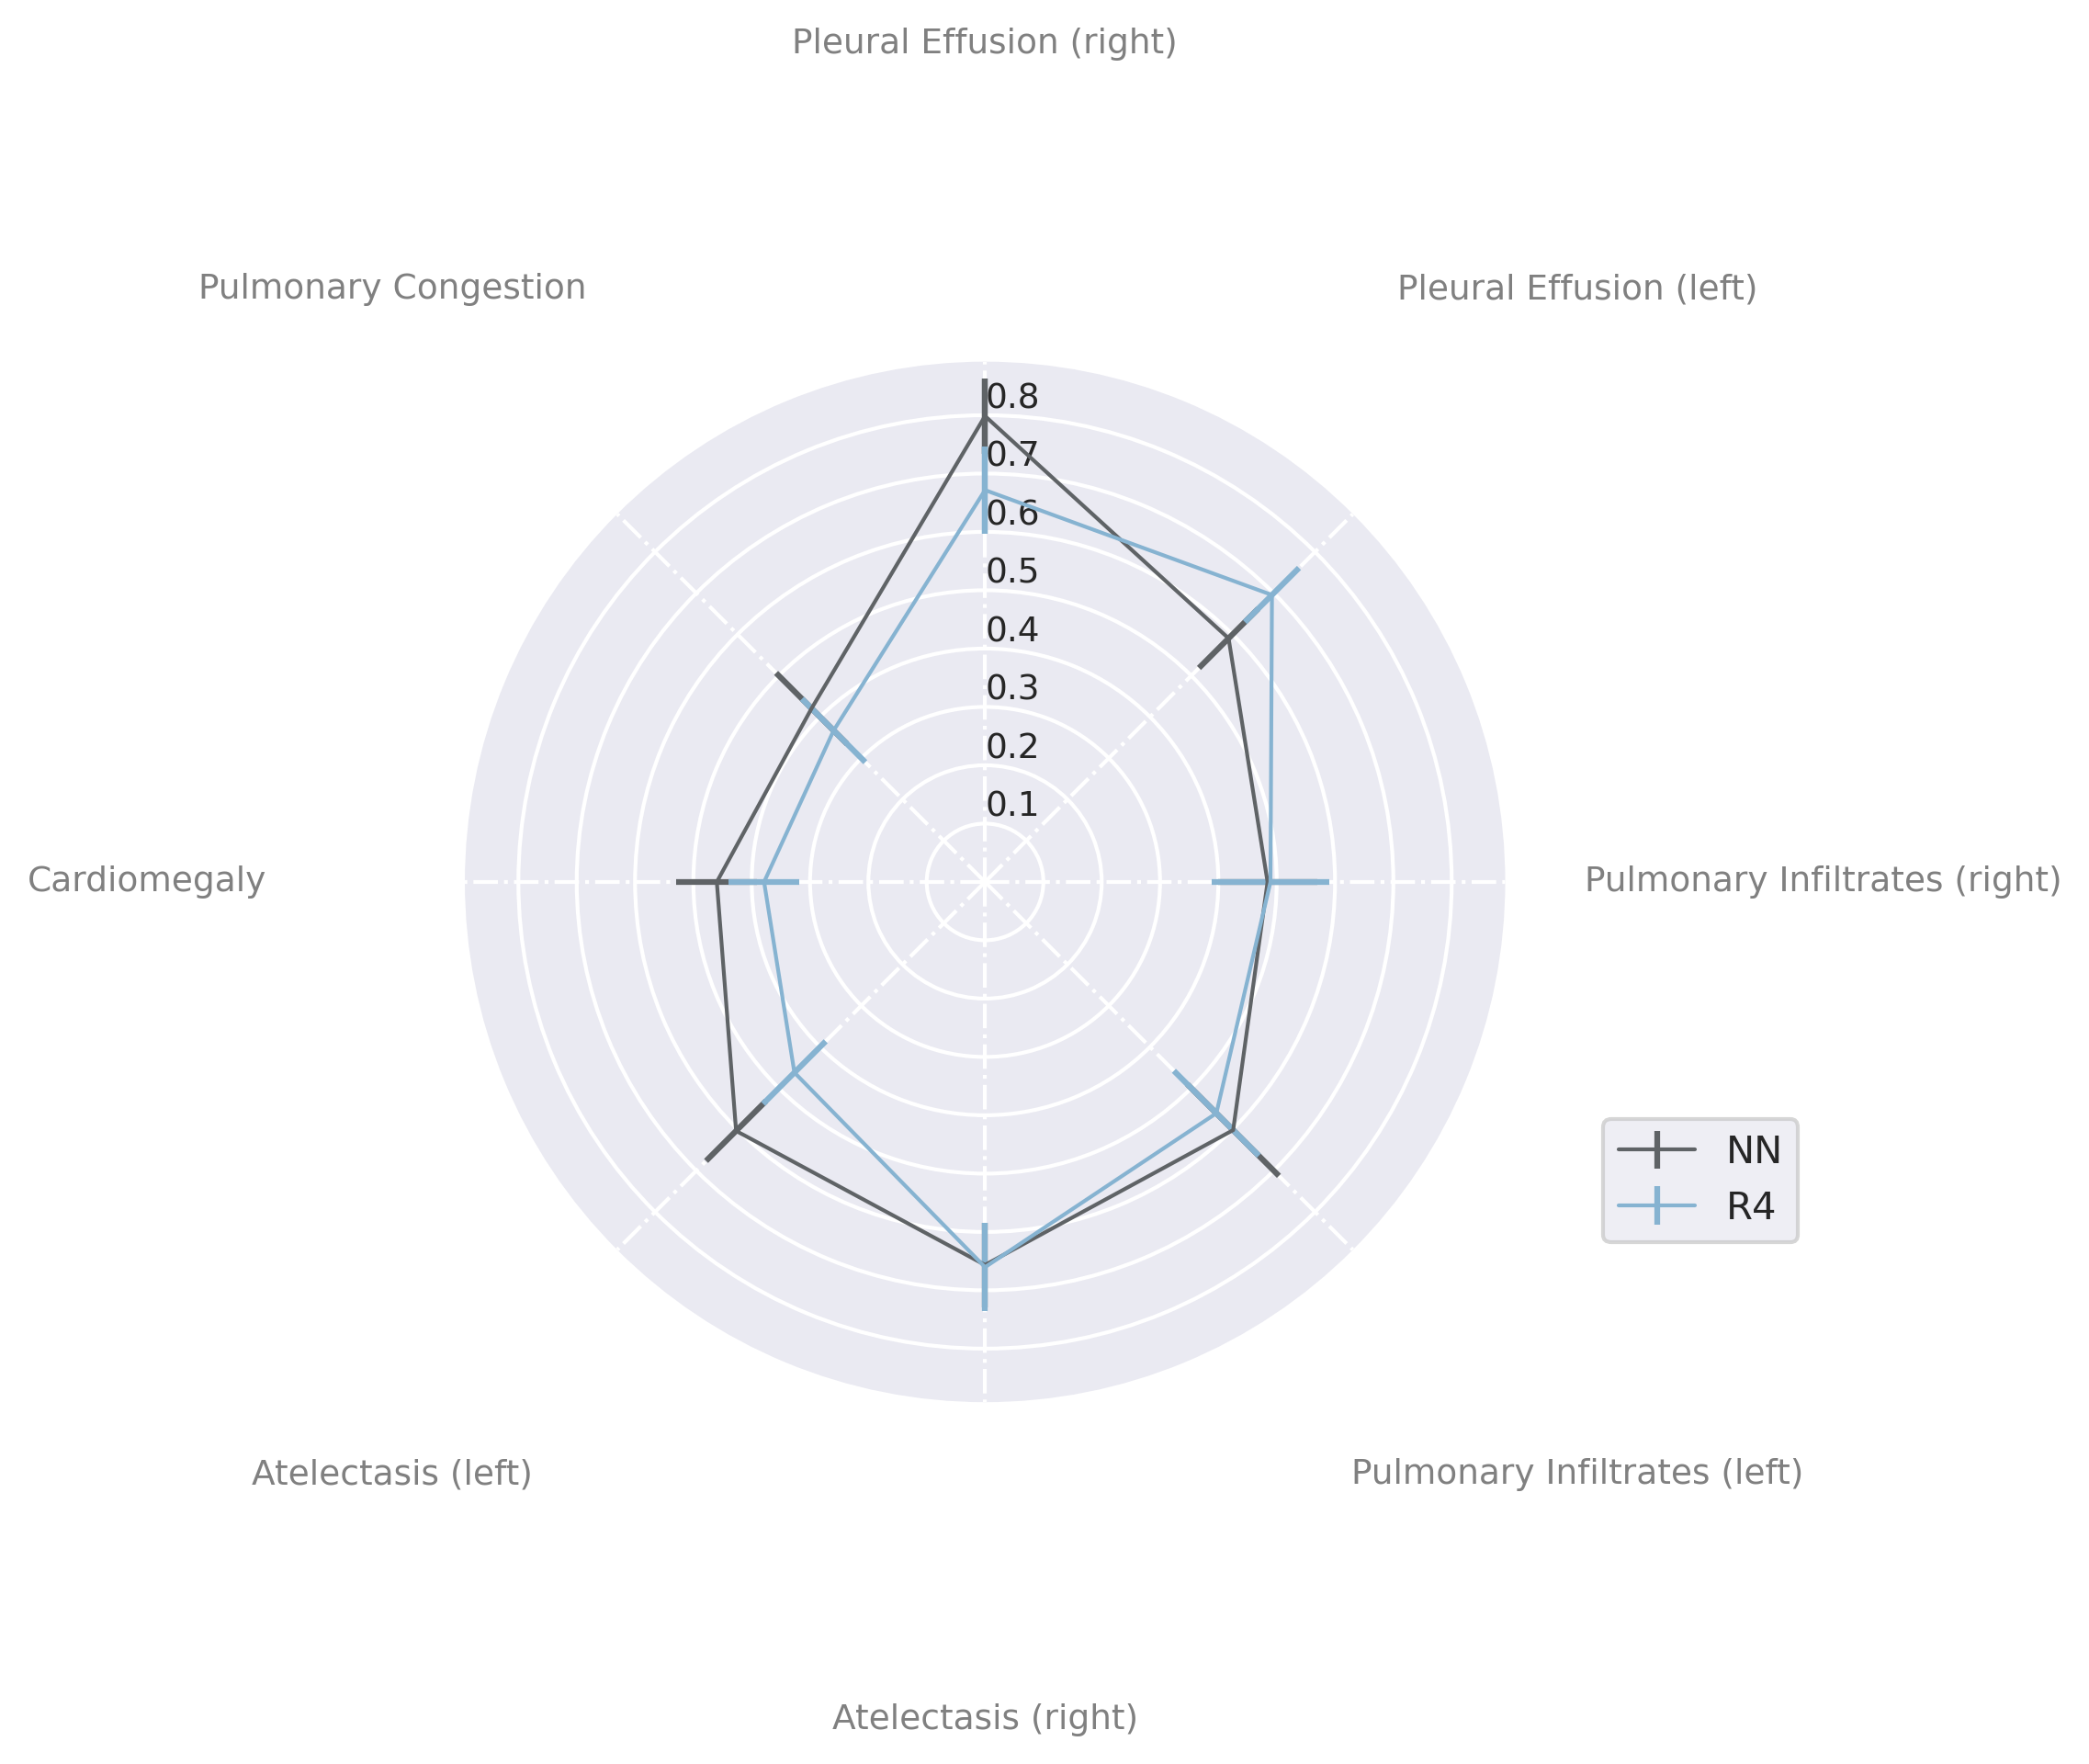

-------------------------------------------------------------------------------------------------------
R5


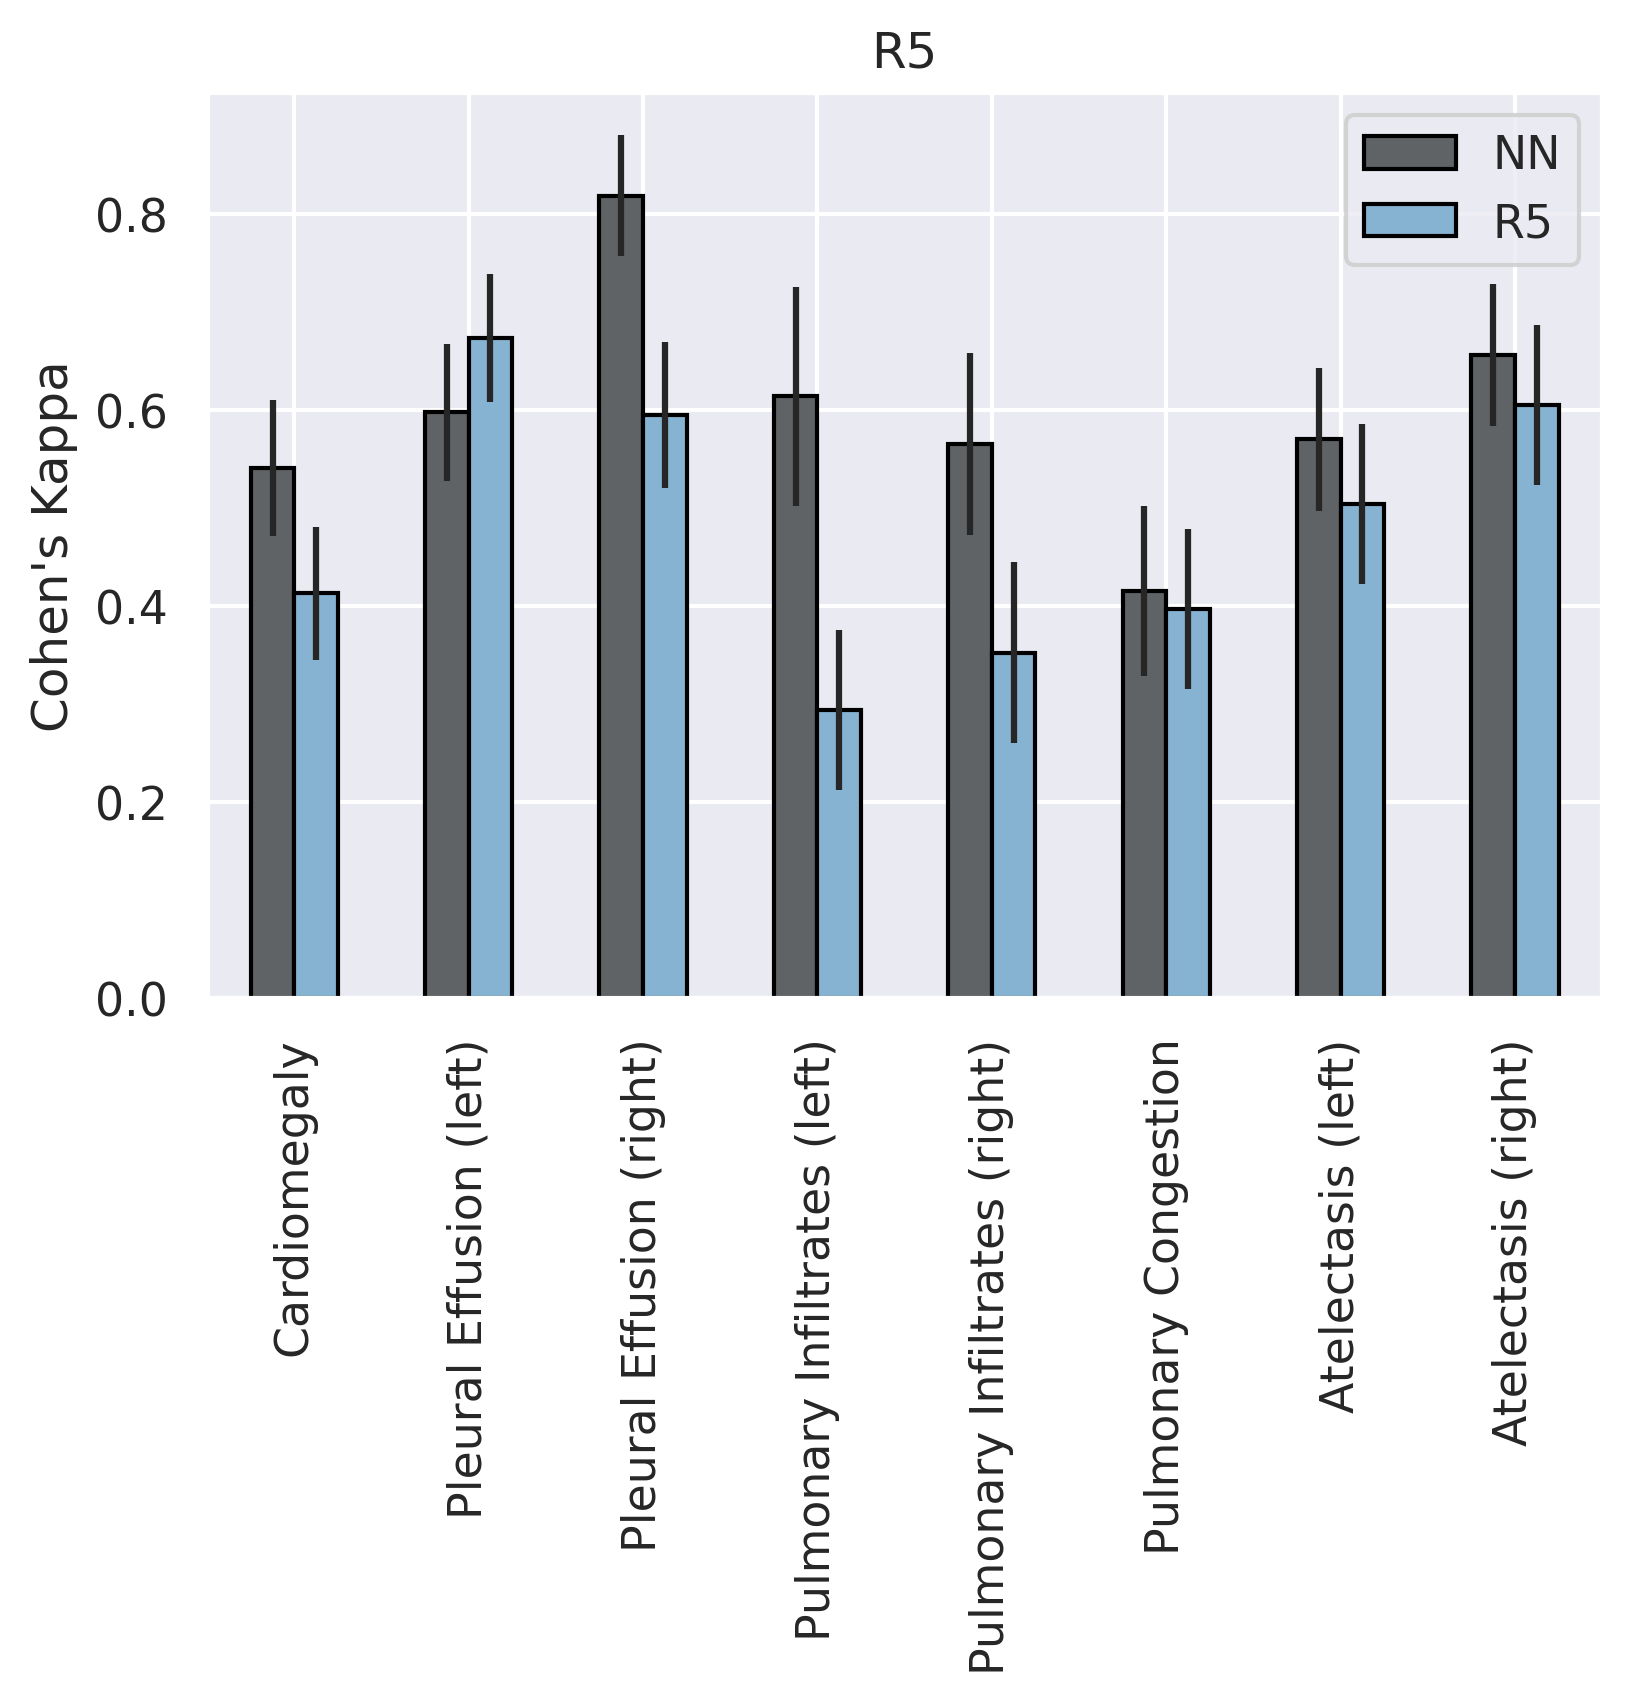

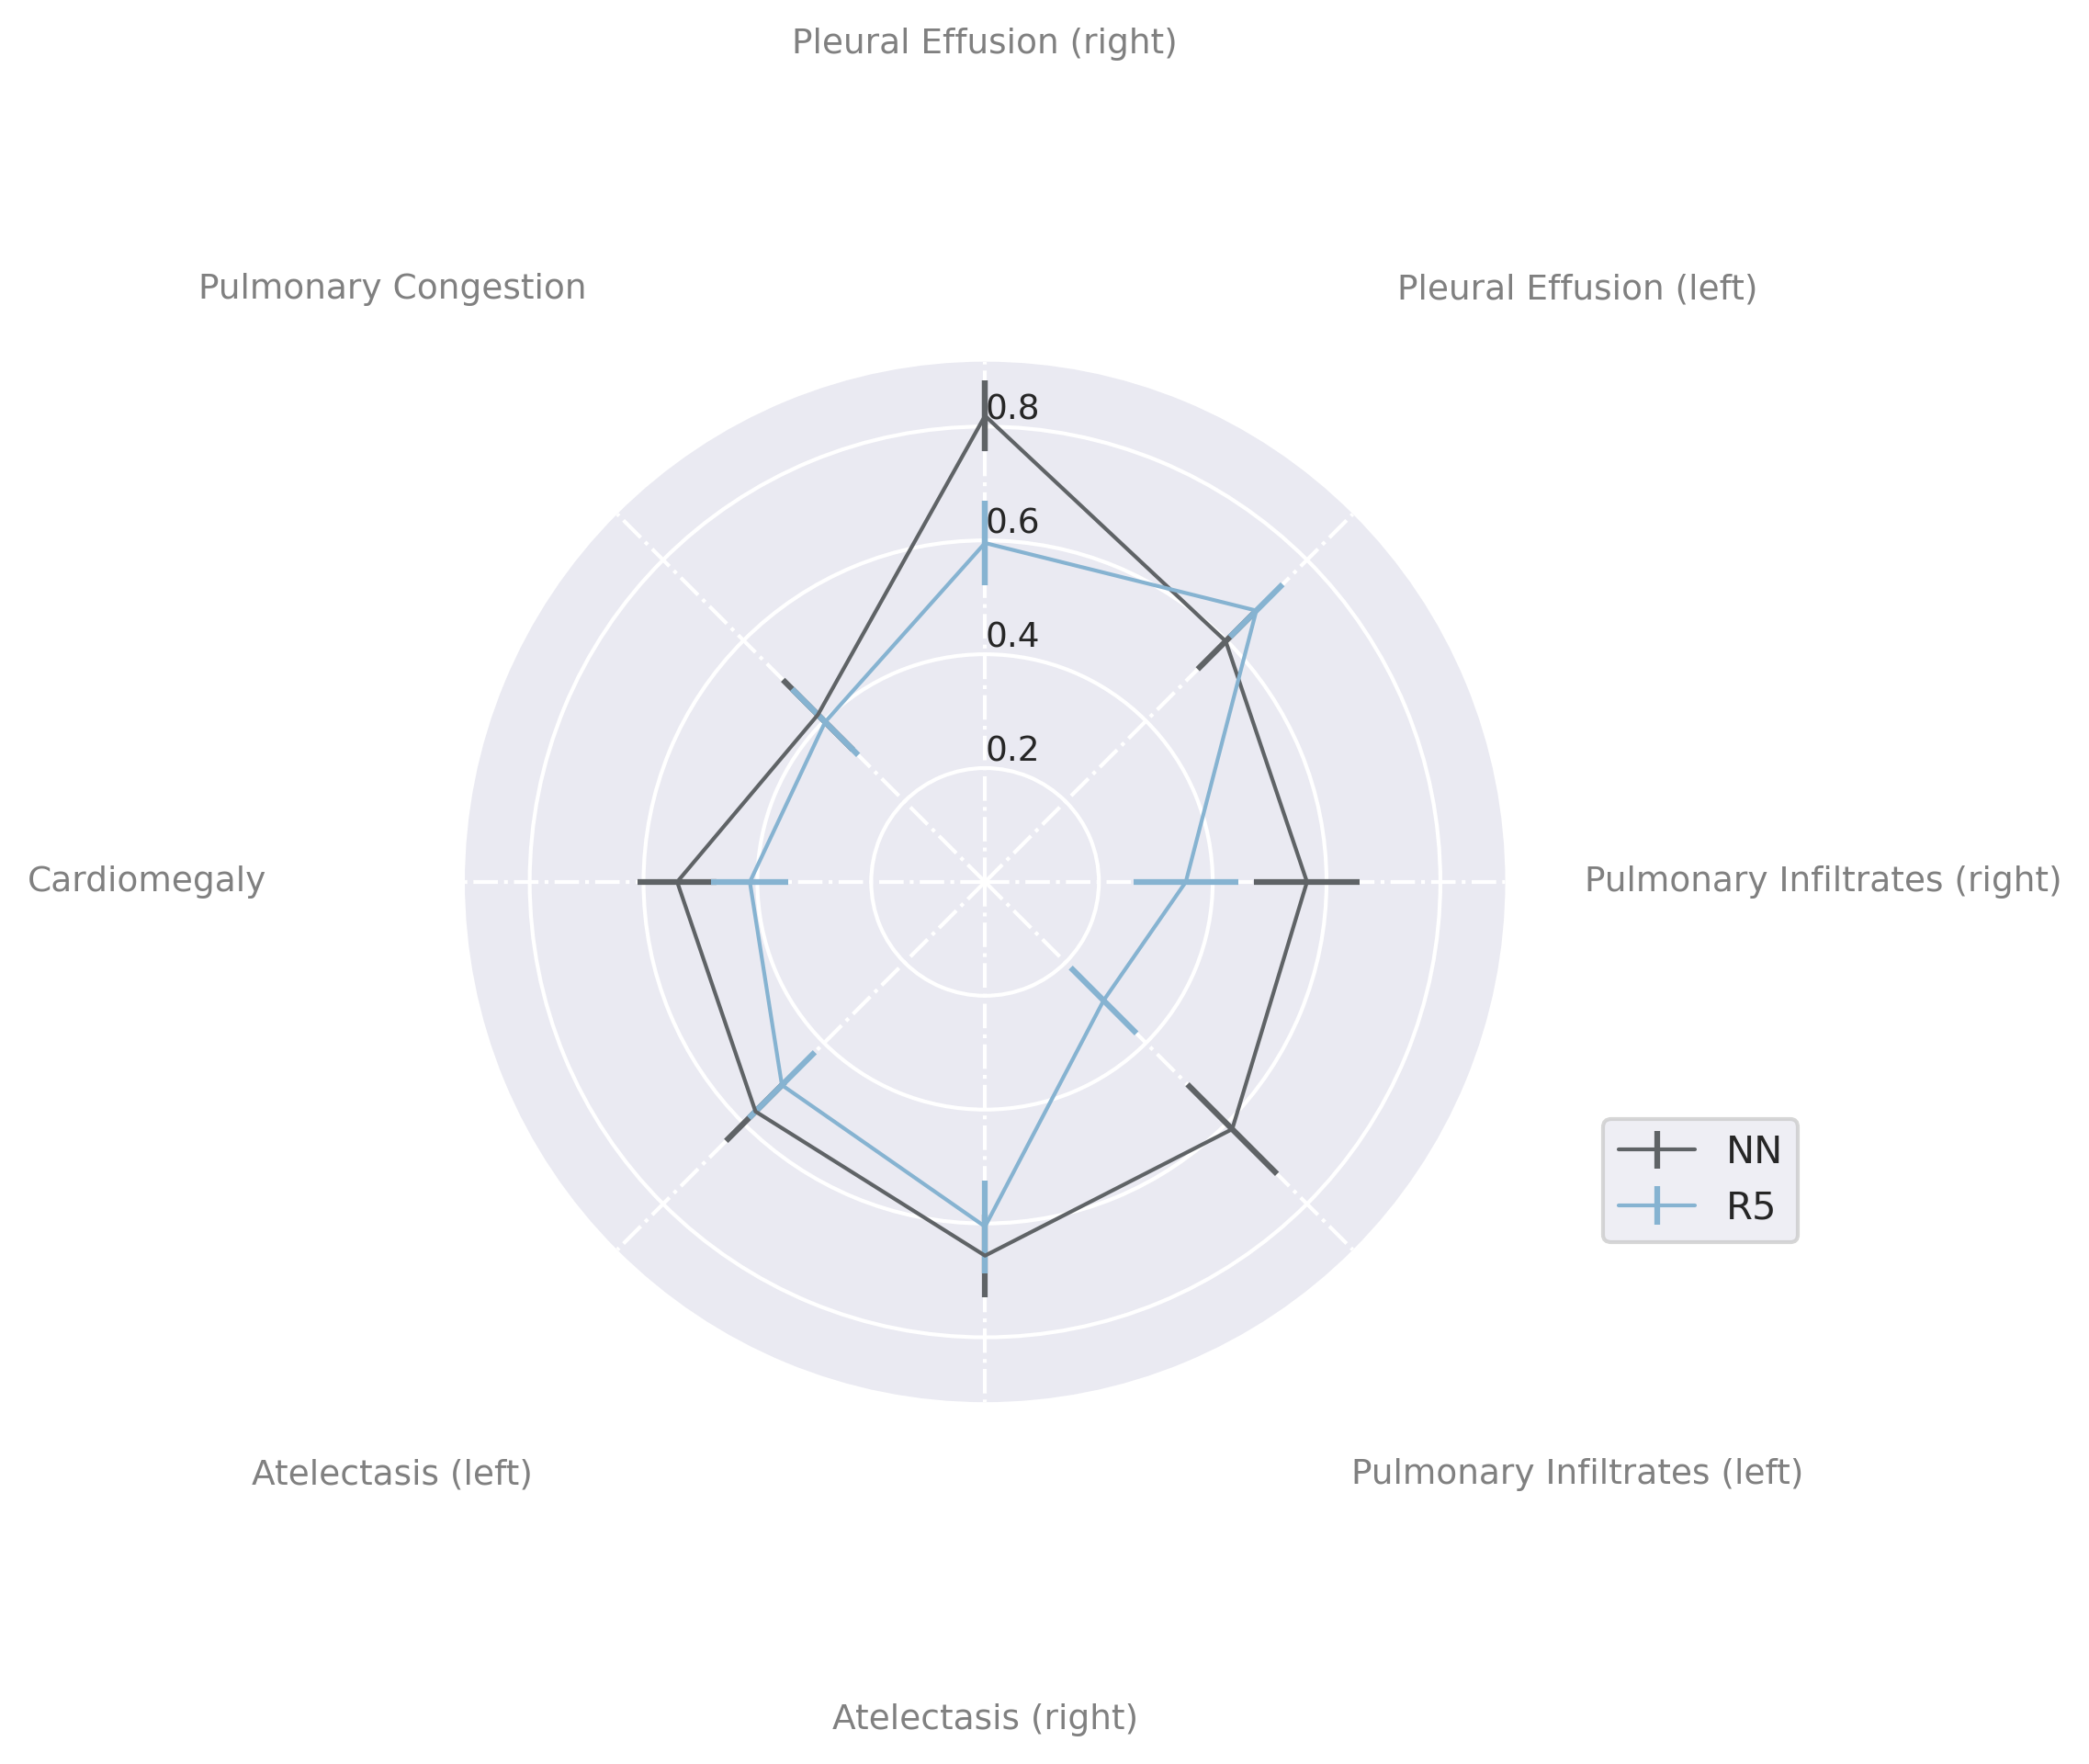

-------------------------------------------------------------------------------------------------------
R6


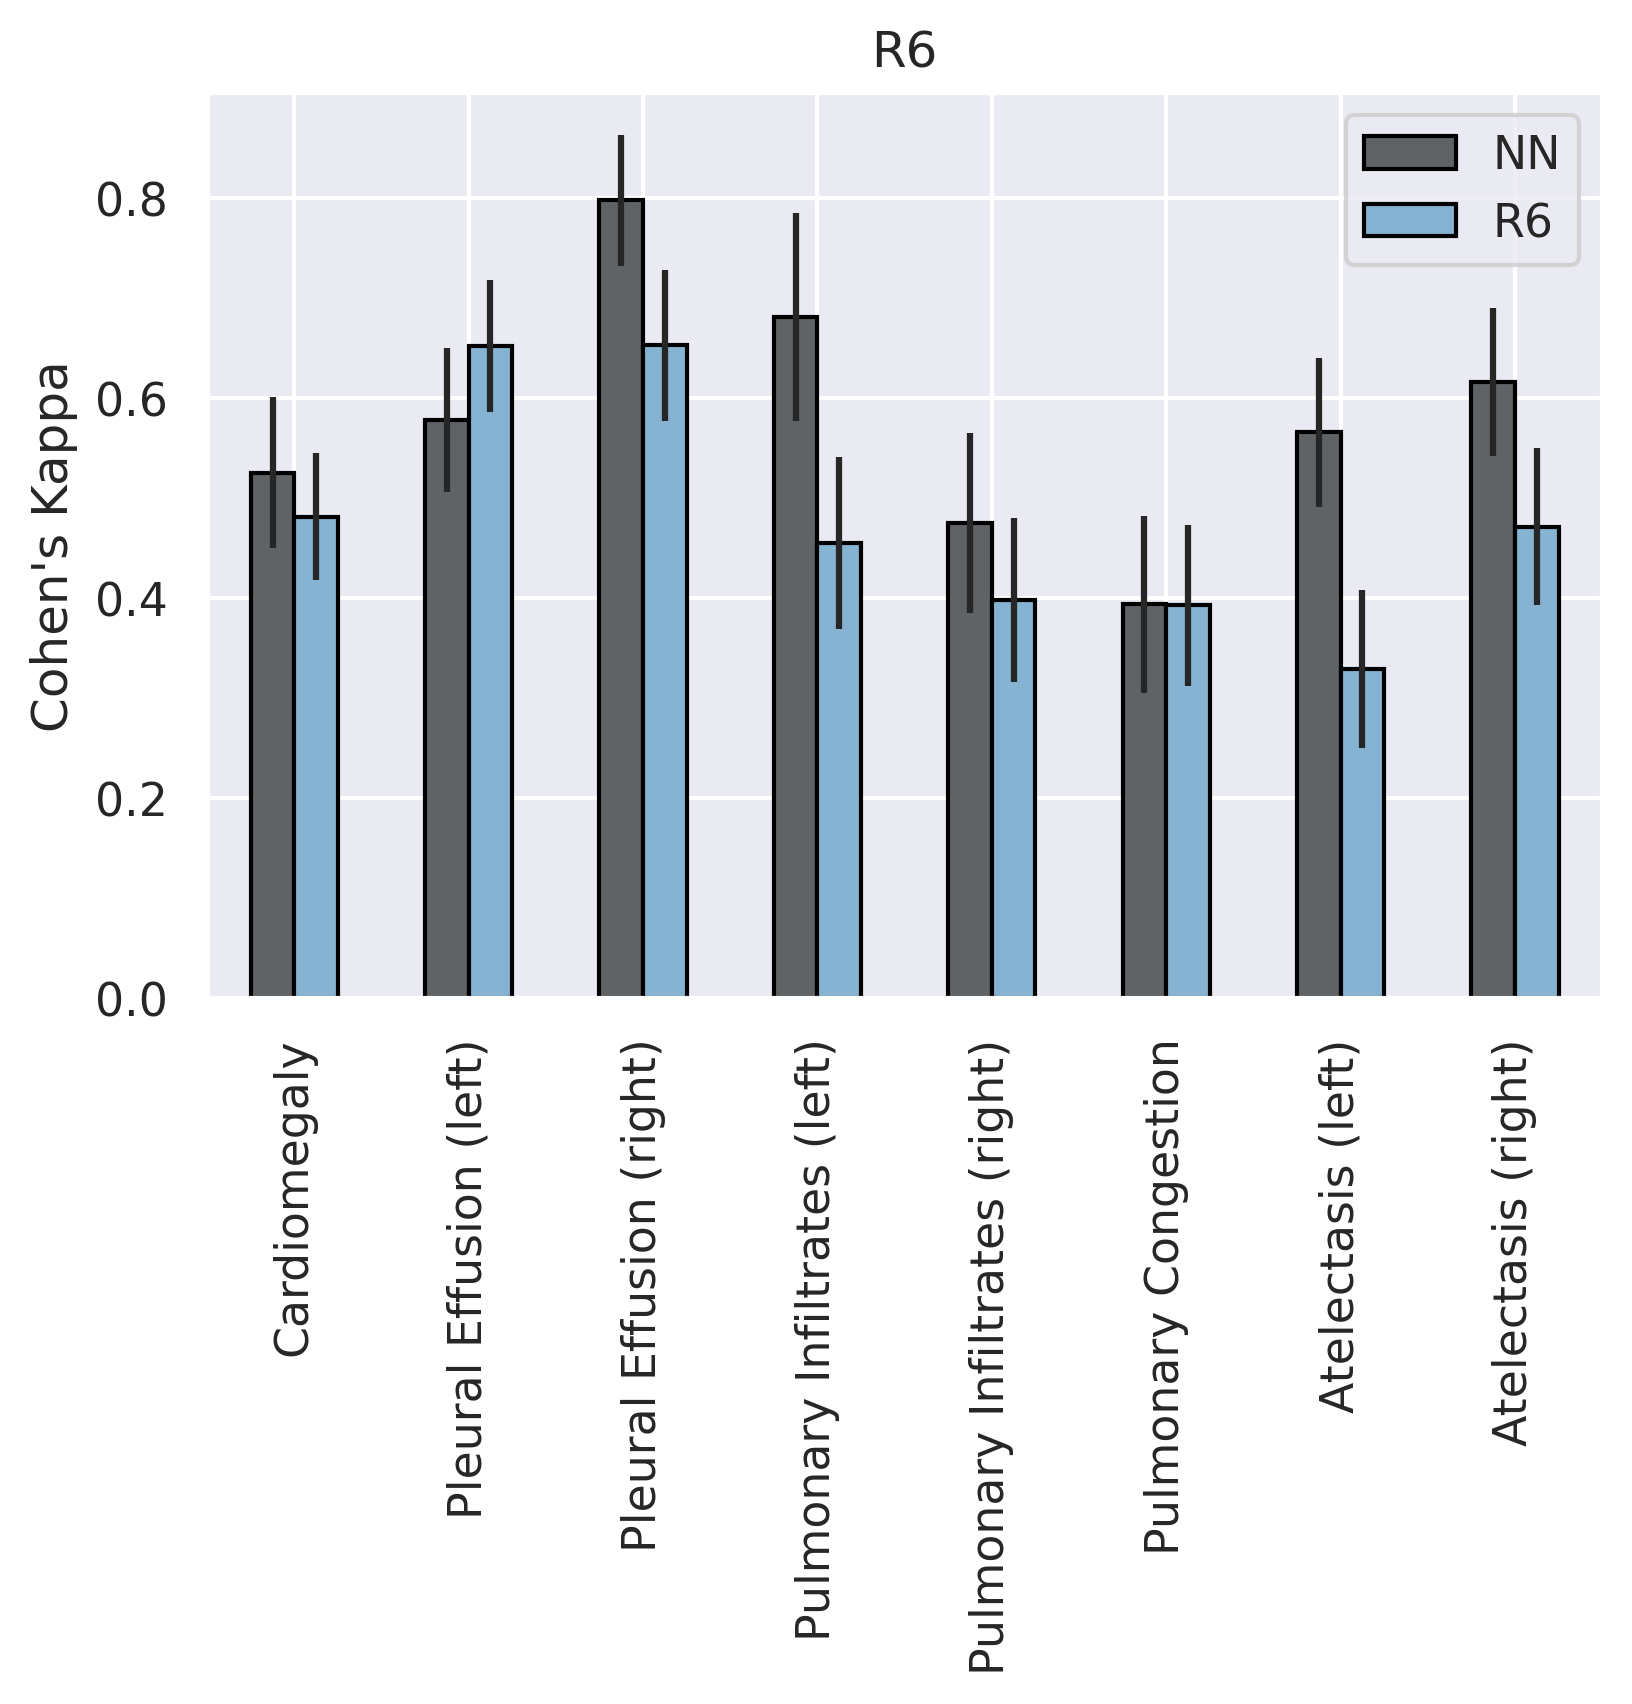

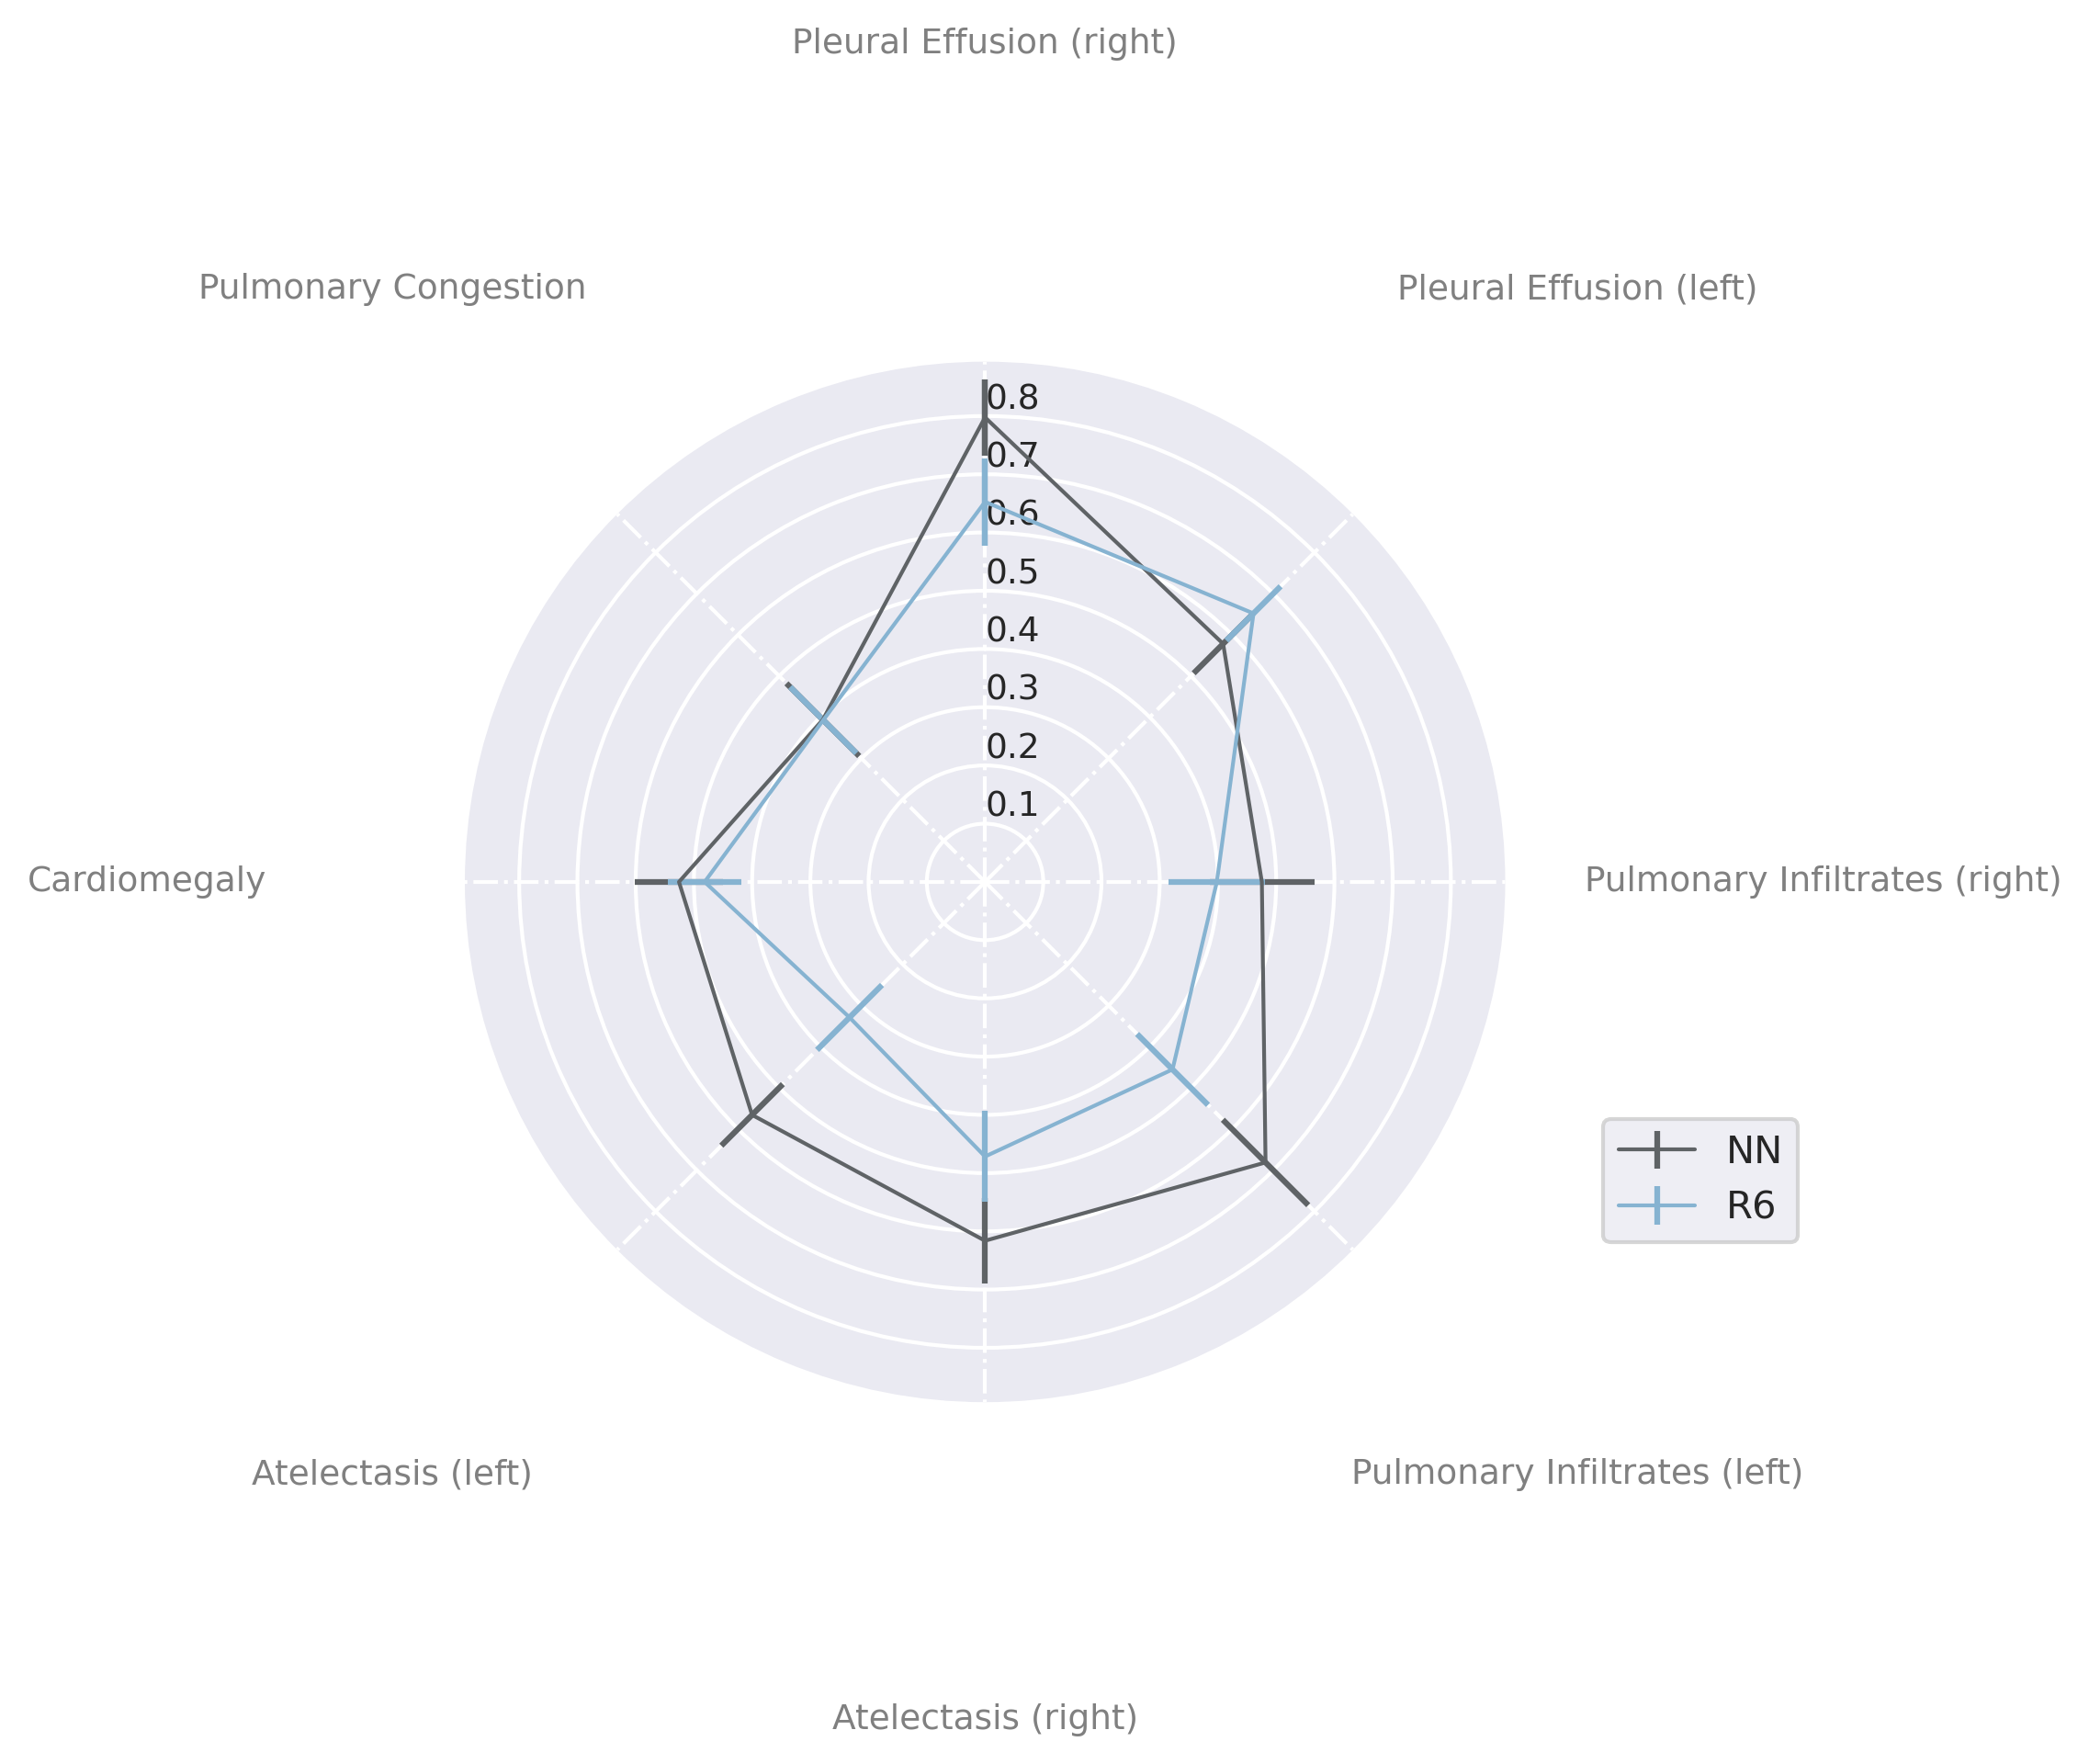

-------------------------------------------------------------------------------------------------------
NON-R1


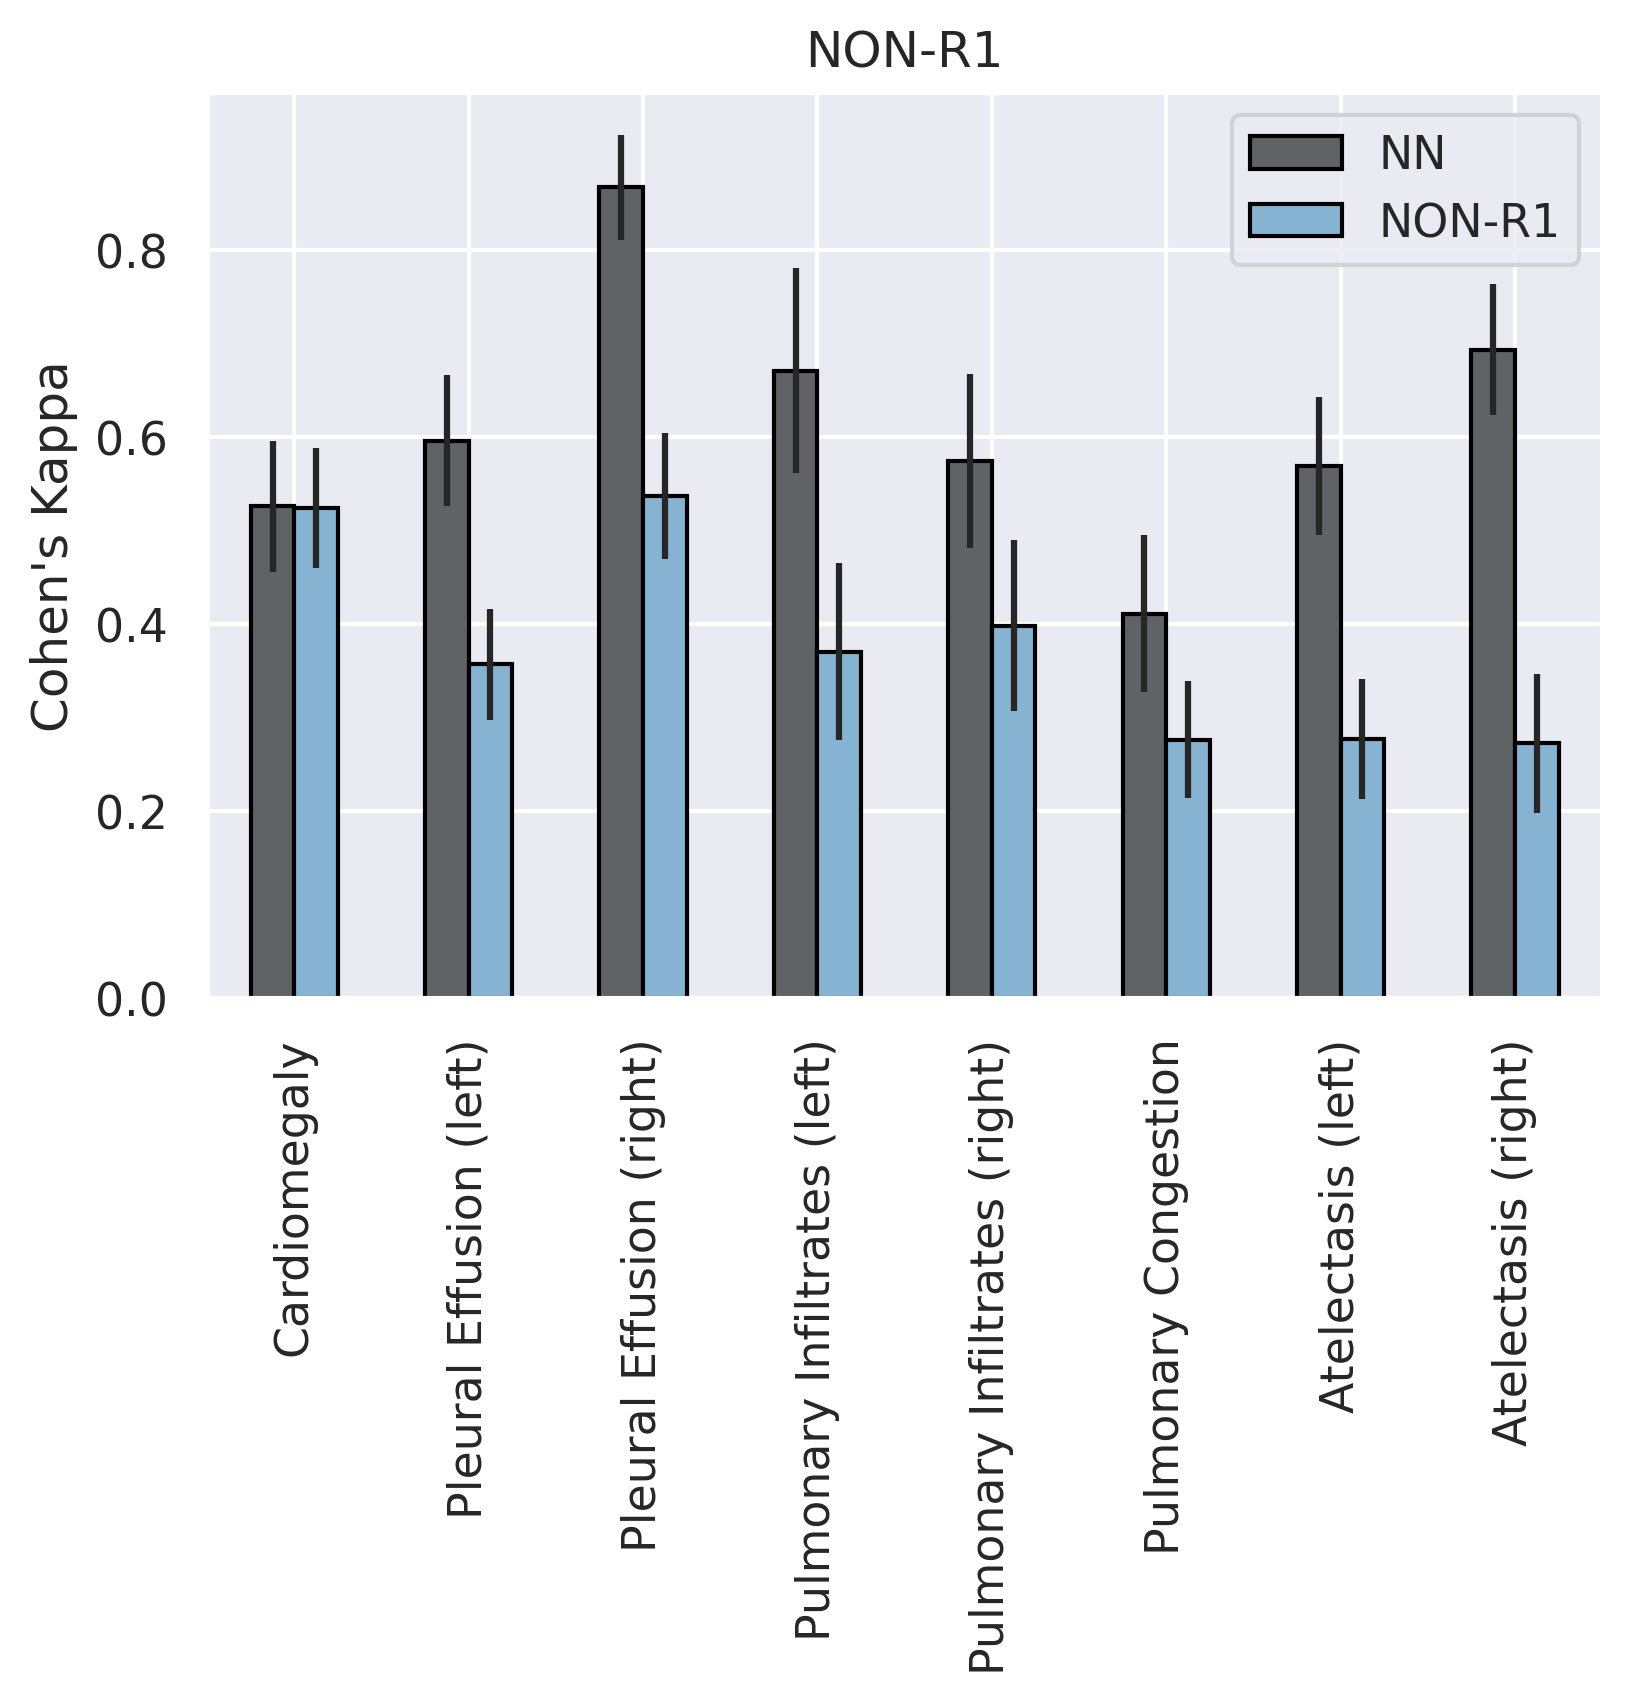

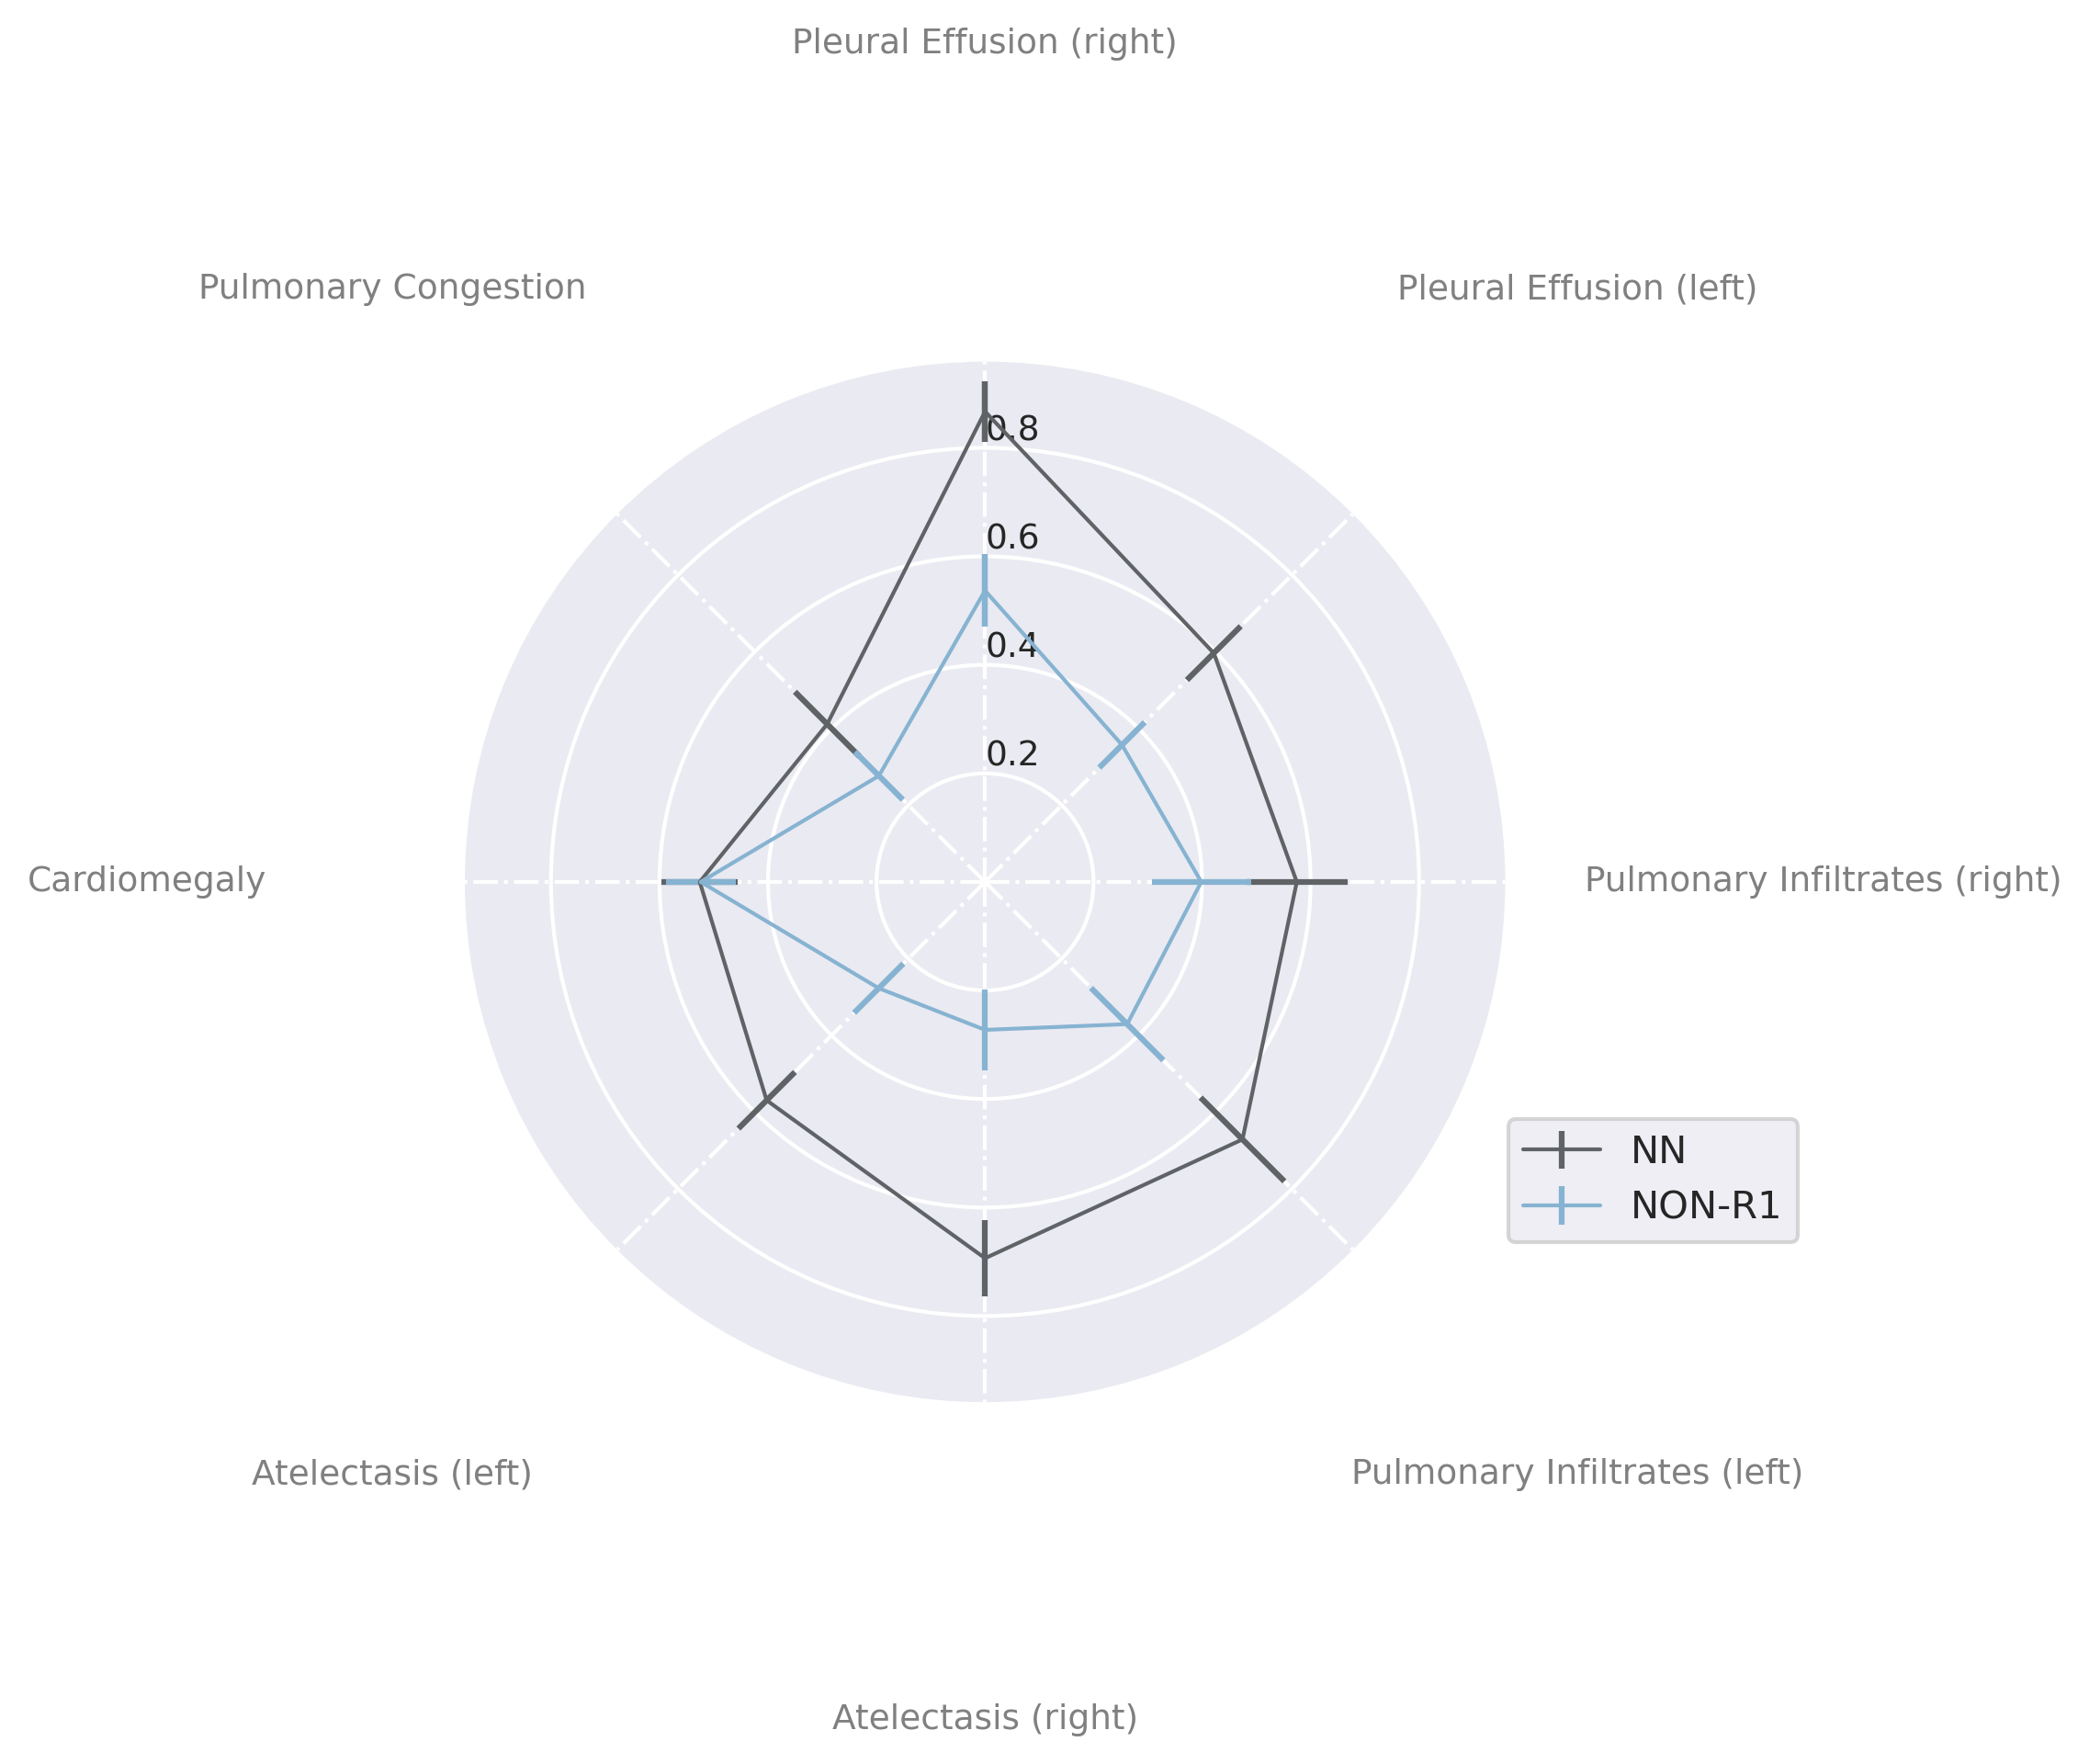

-------------------------------------------------------------------------------------------------------
NON-R1+AI


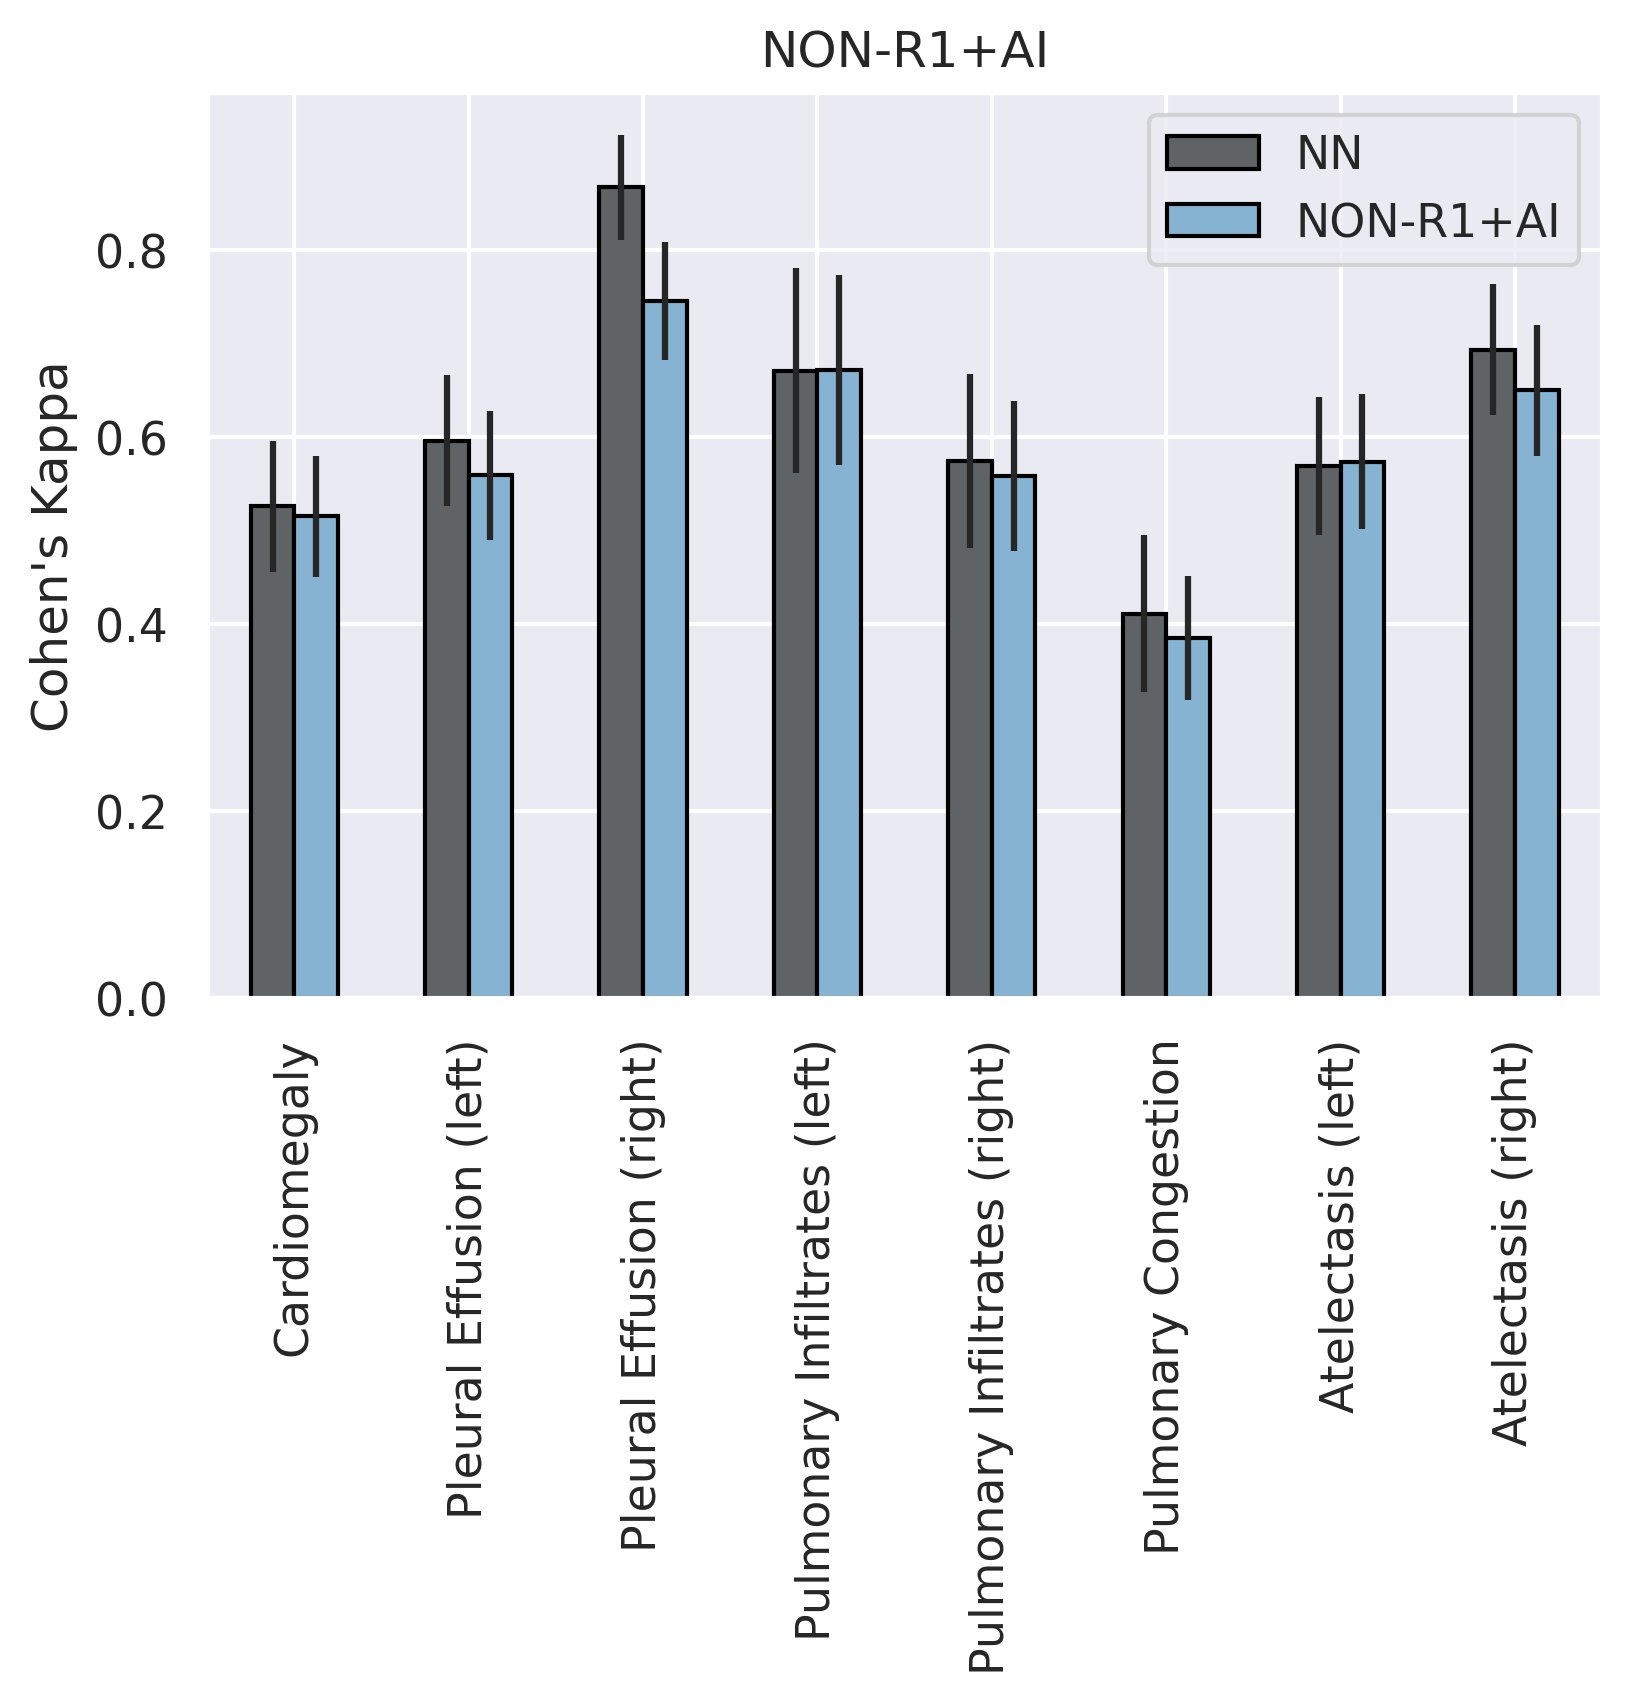

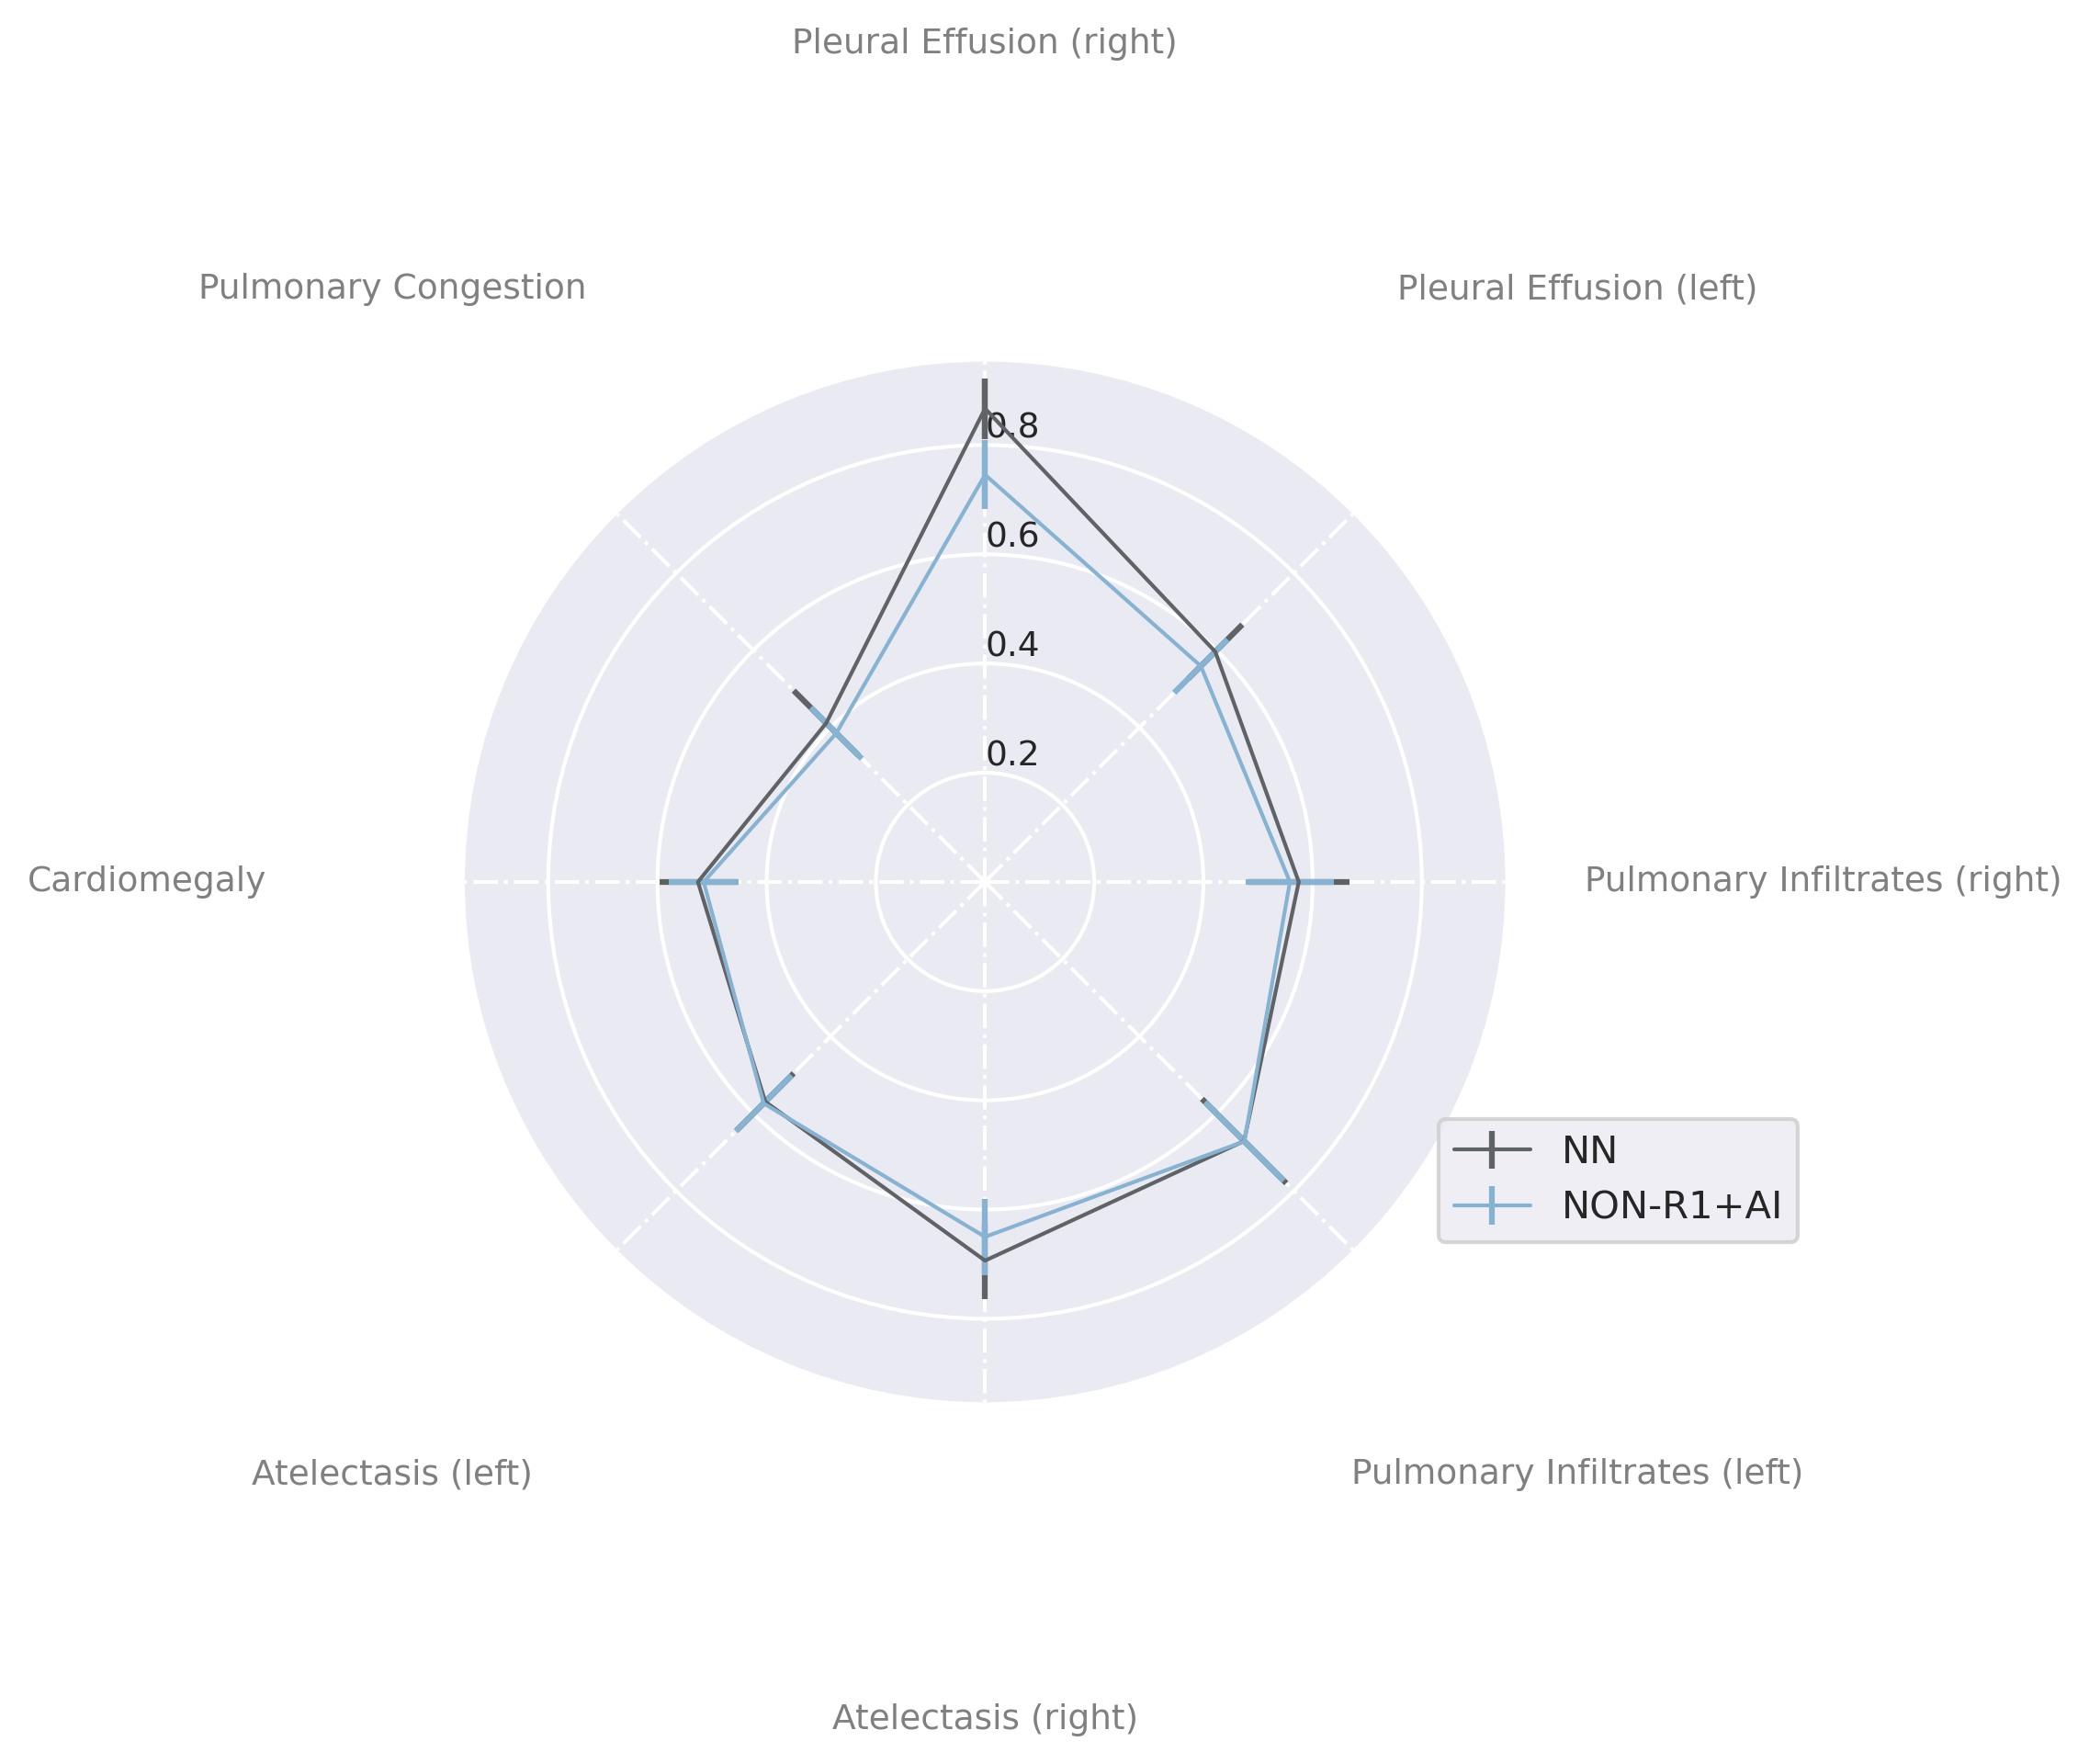

-------------------------------------------------------------------------------------------------------
NON-R2


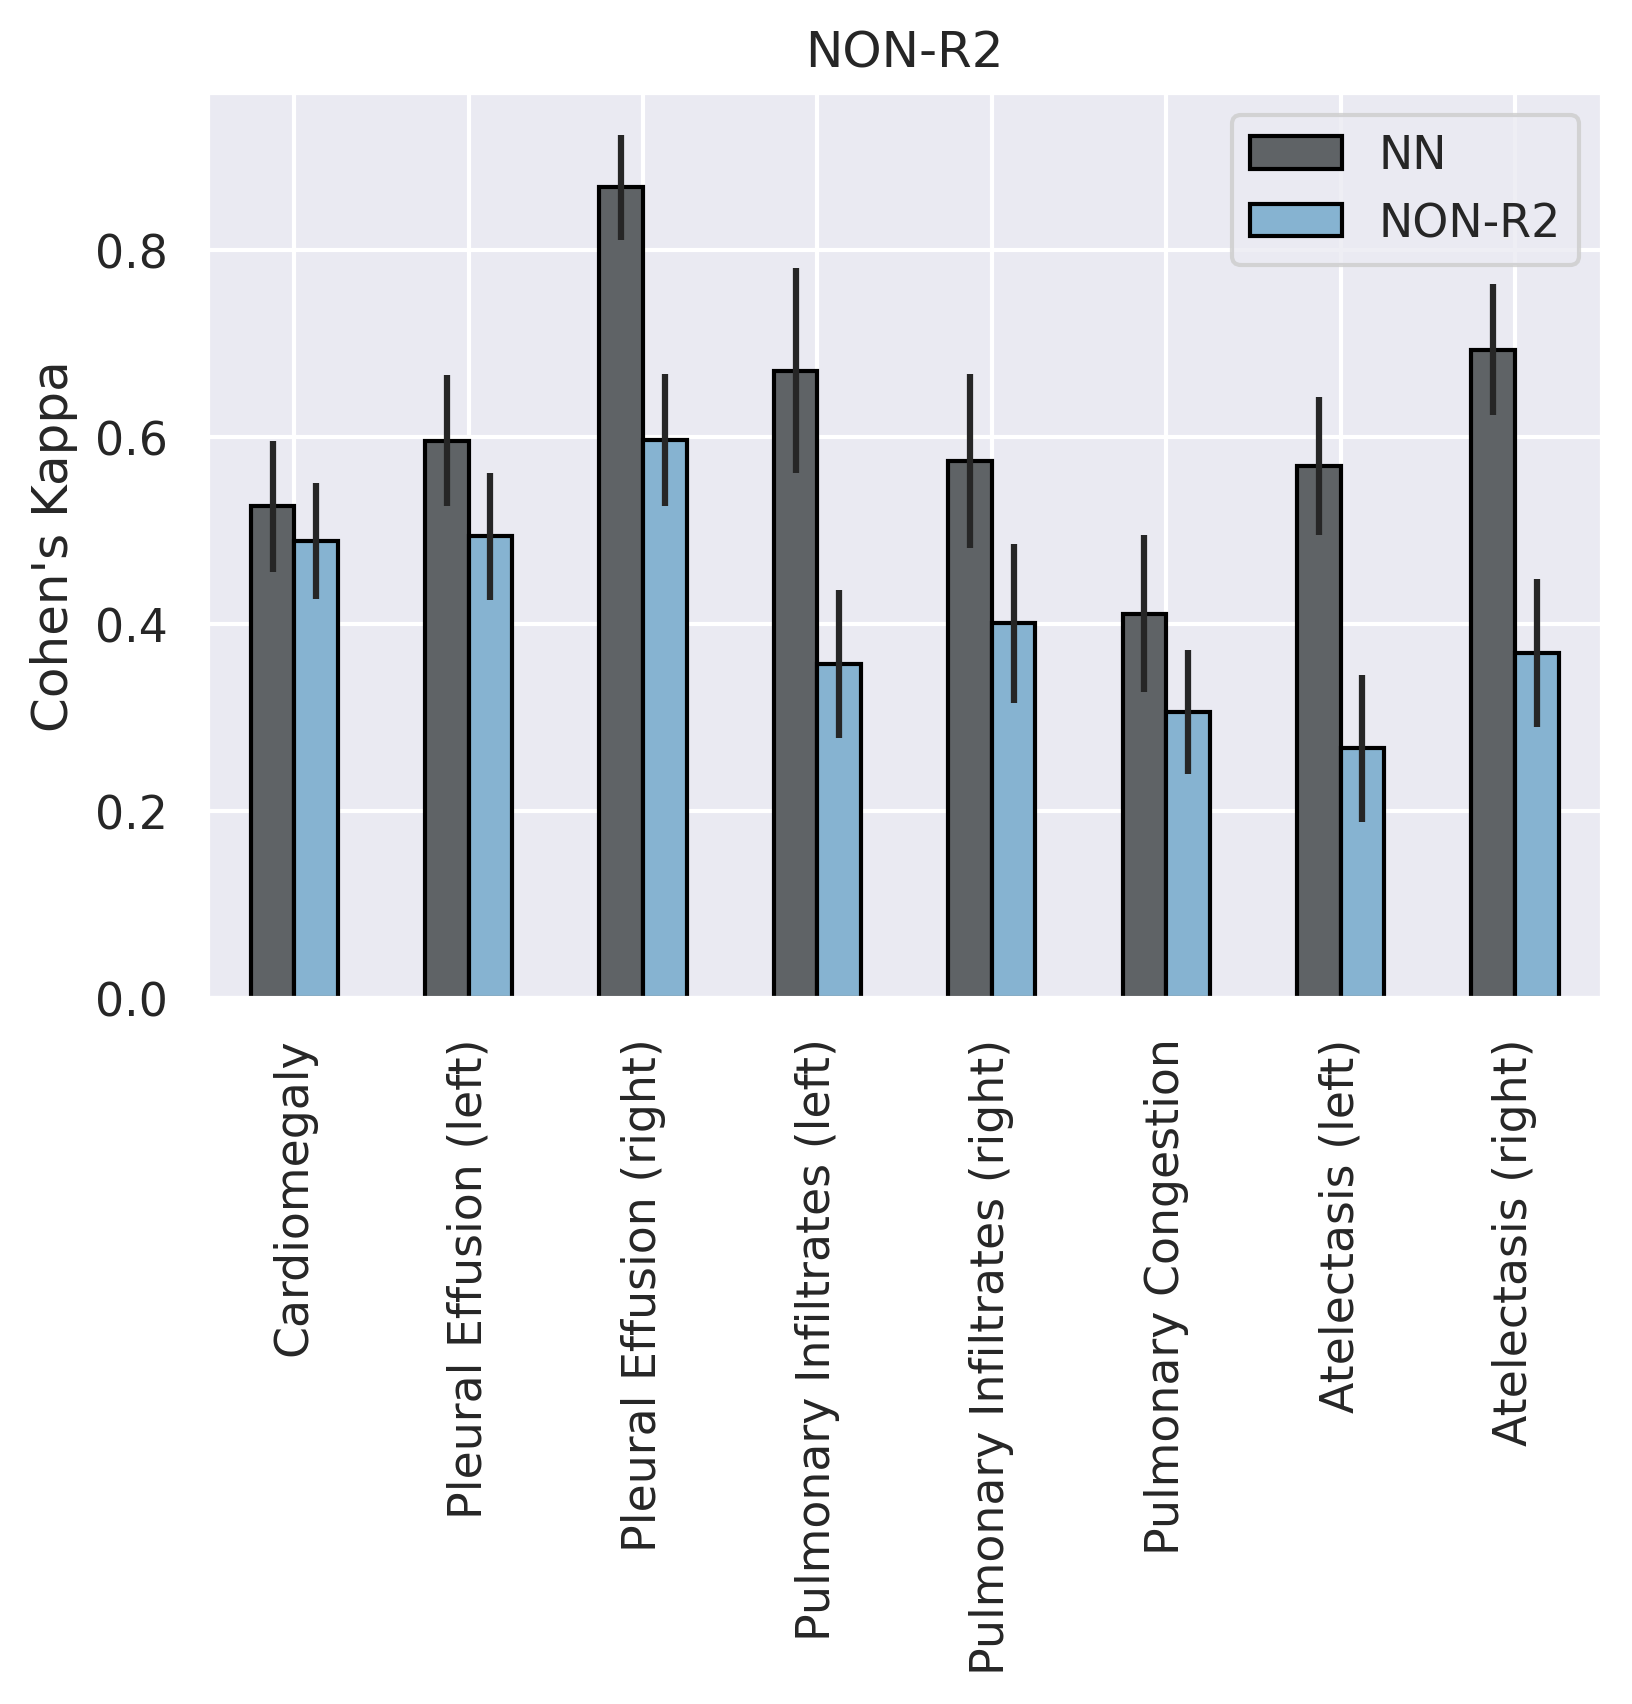

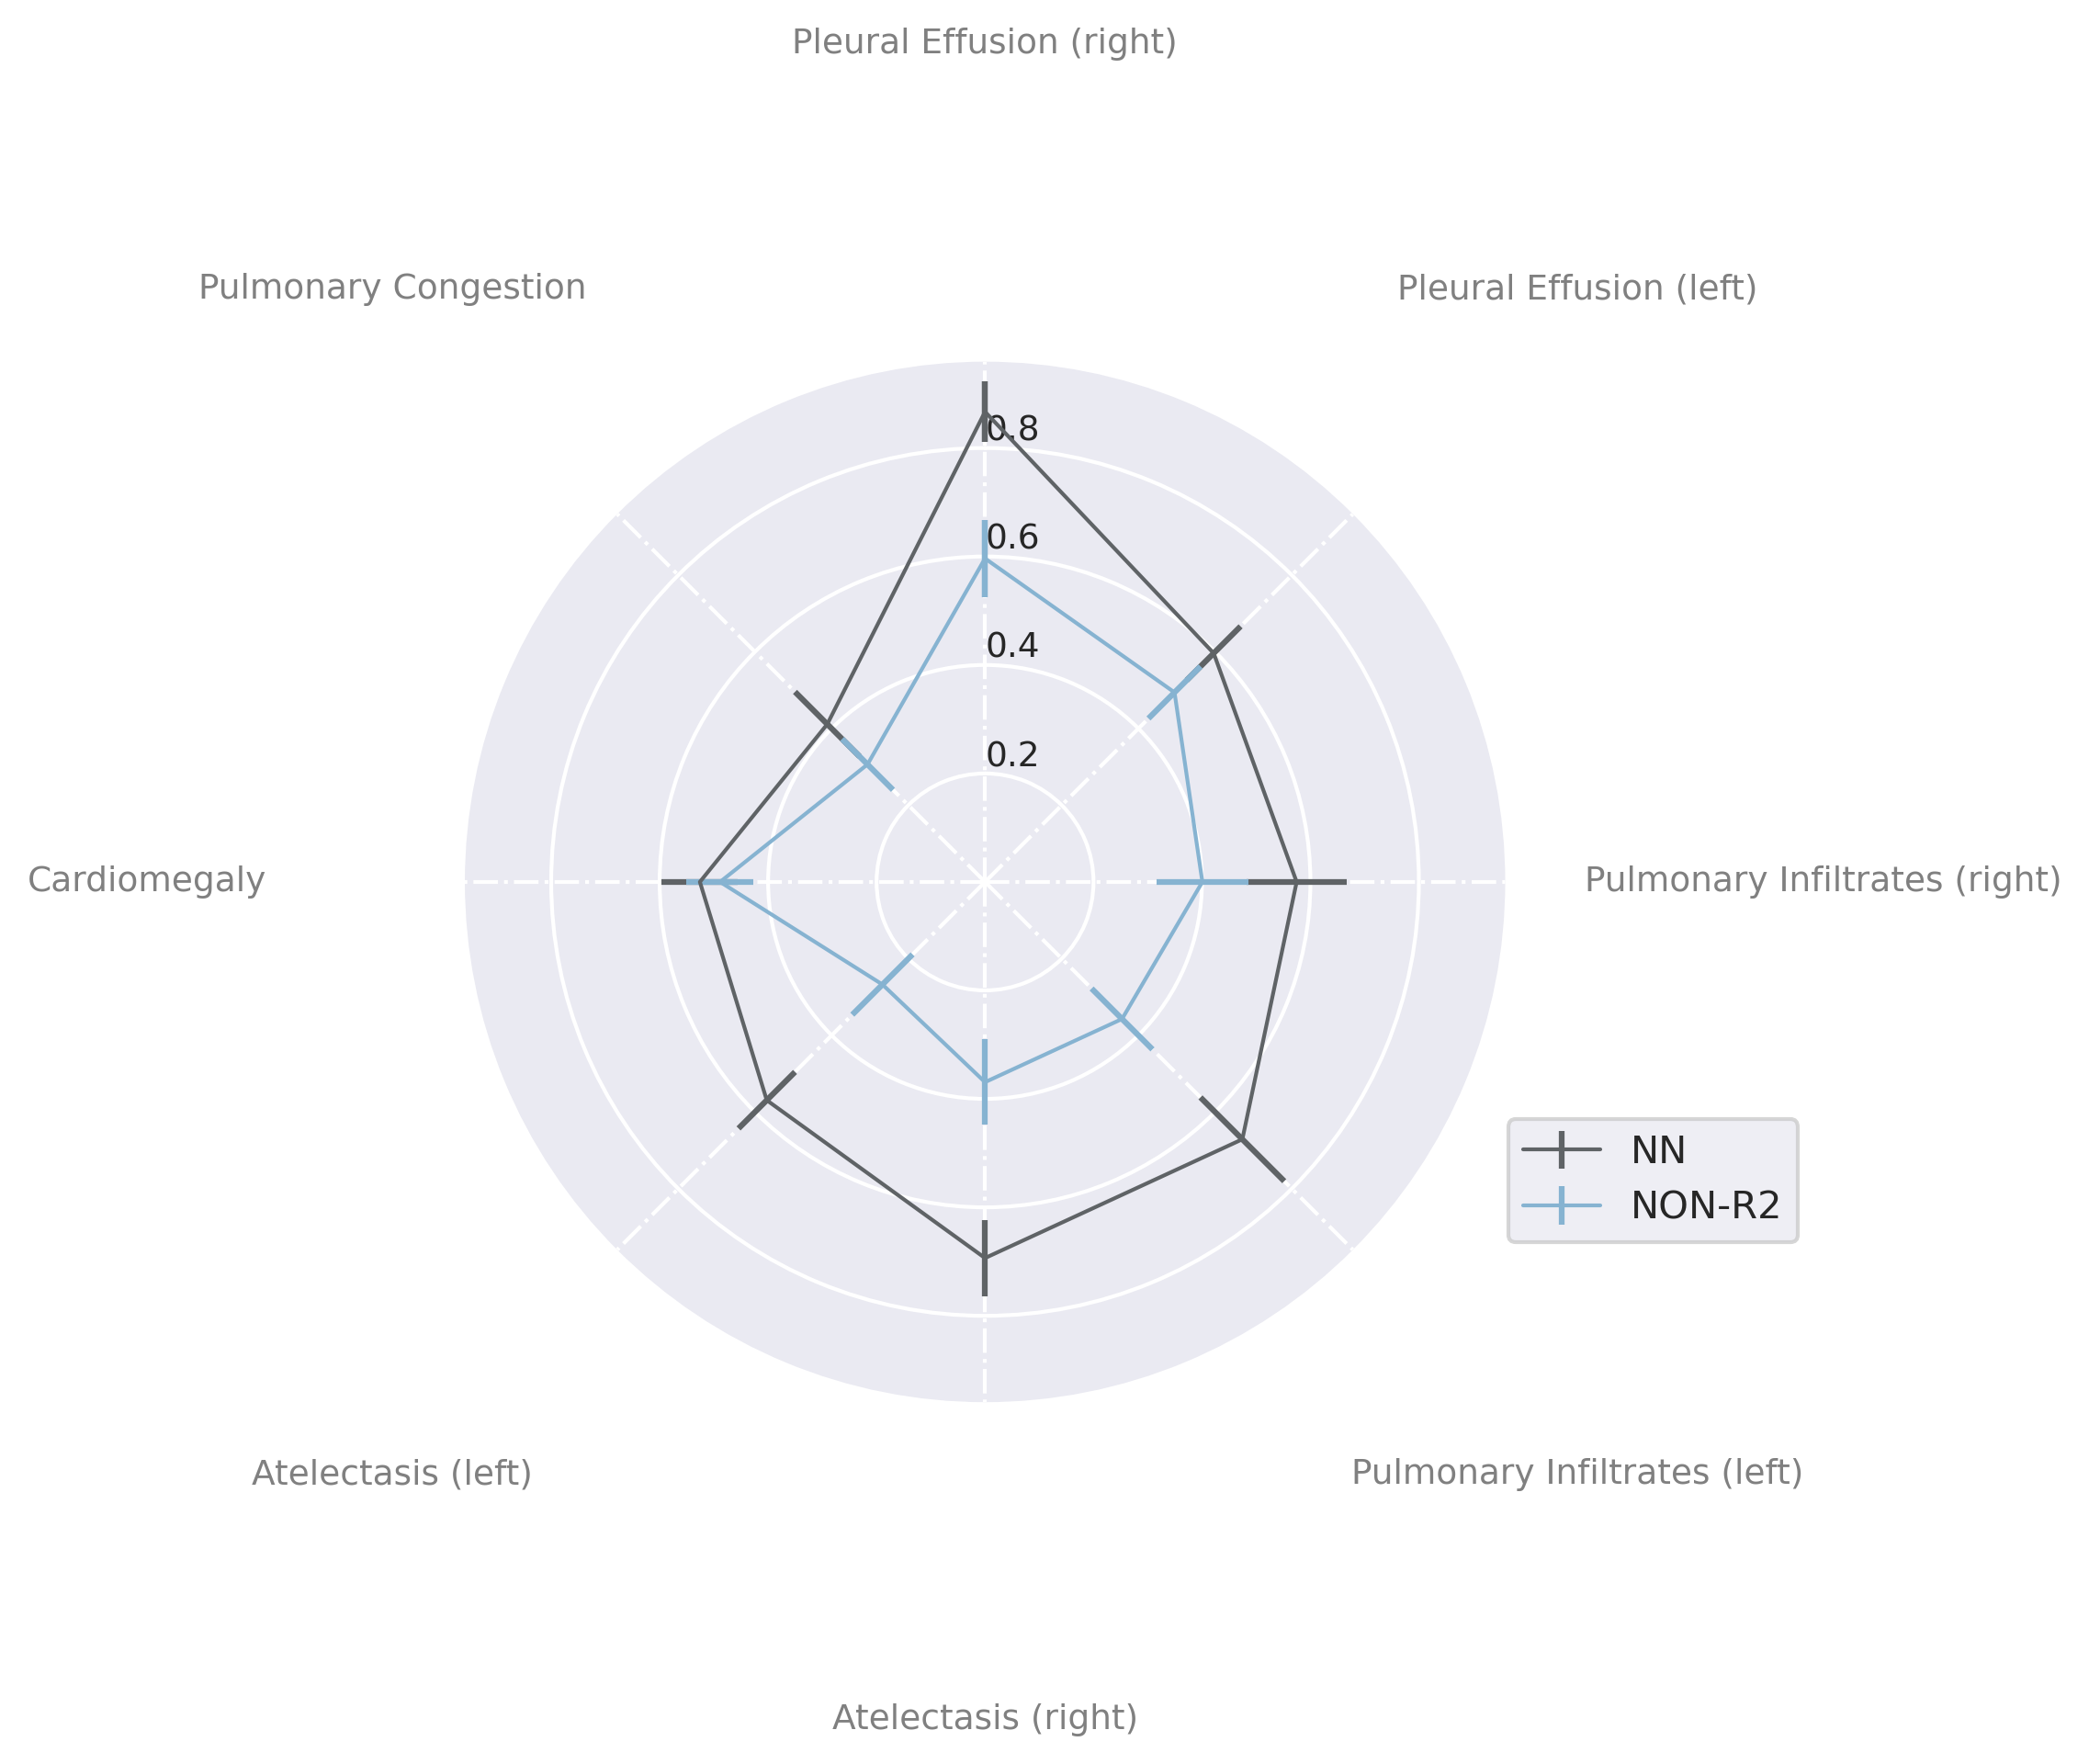

-------------------------------------------------------------------------------------------------------
NON-R2+AI


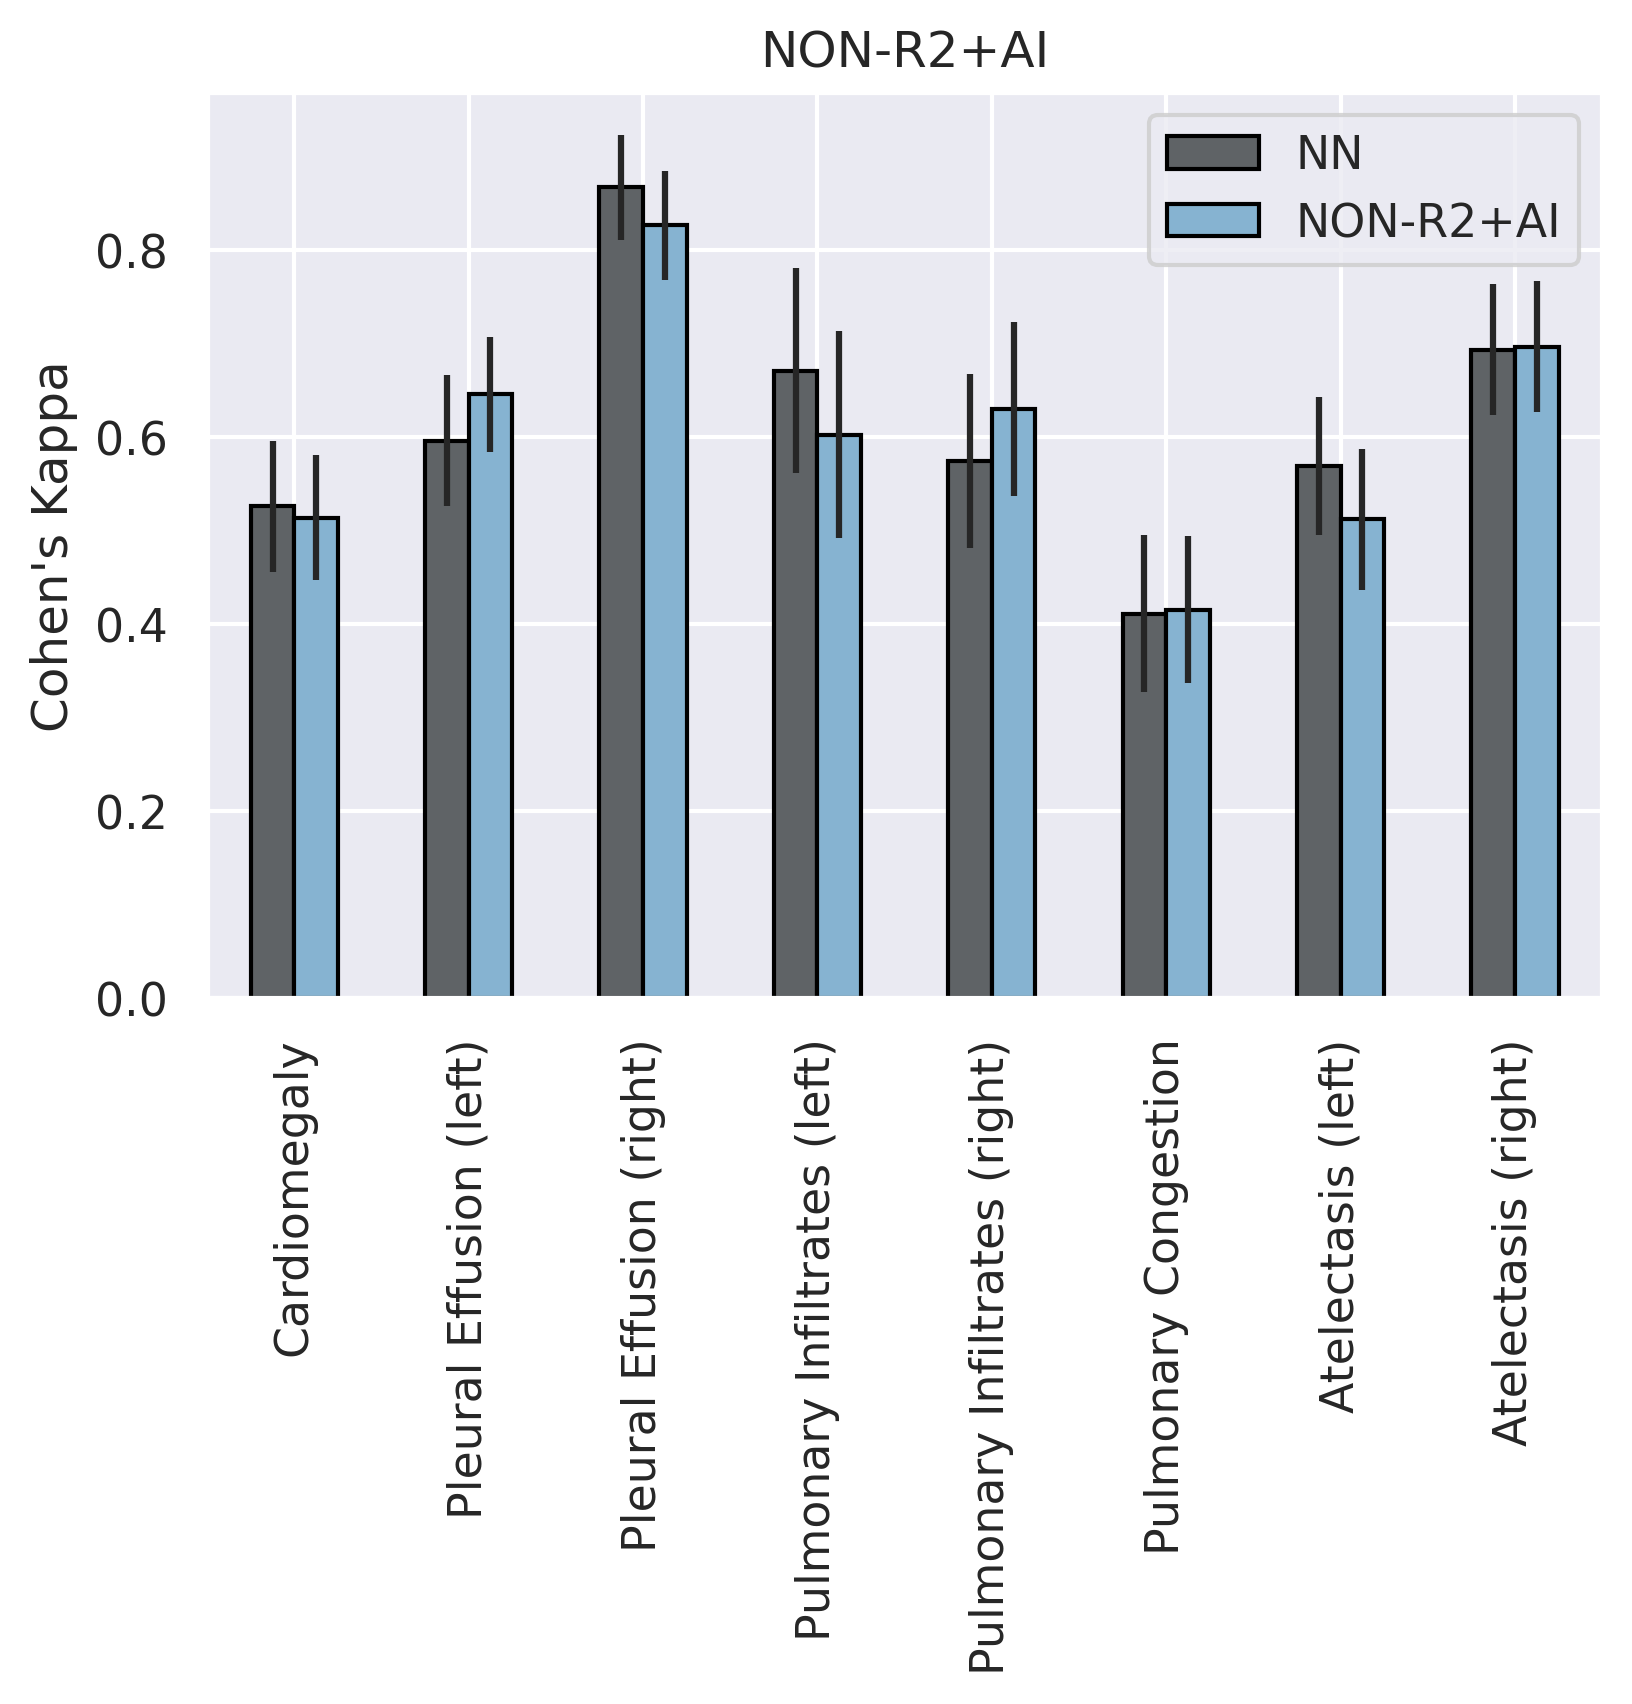

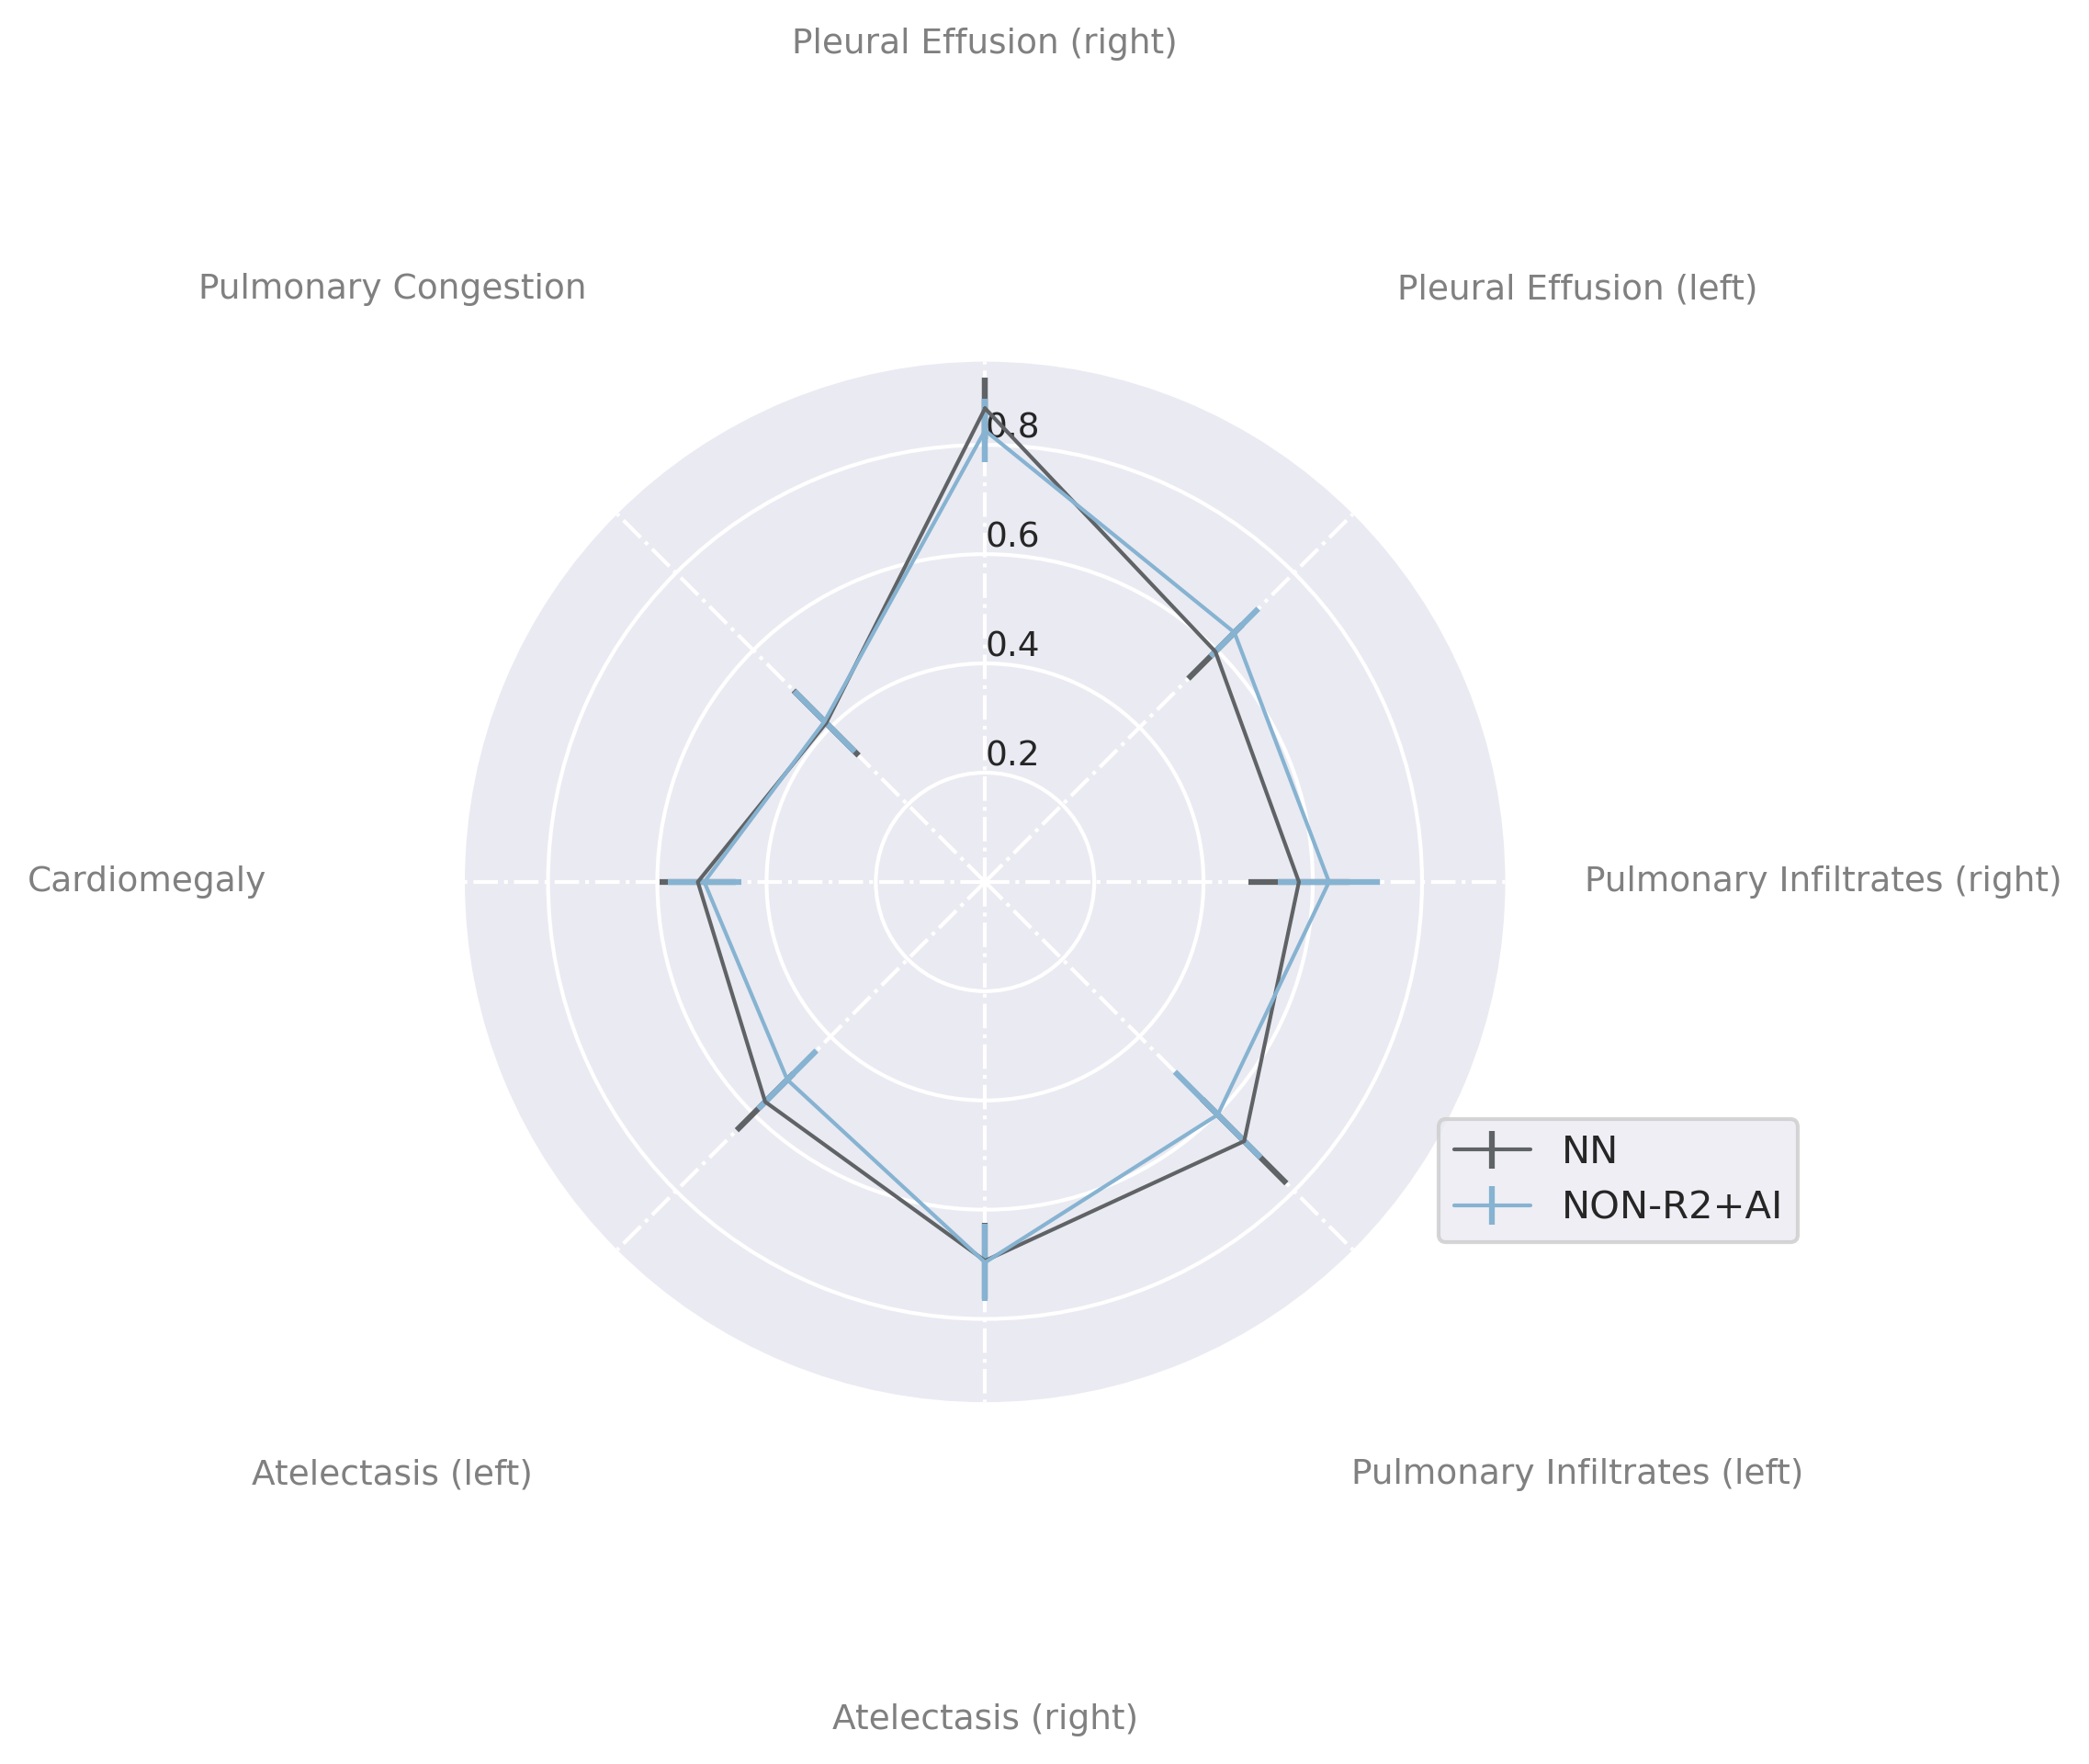

In [492]:
all_challengers_without_pred = list(challengers.keys())
all_challengers_without_pred.remove('NN')
for selected_radiologist in all_challengers_without_pred:
    df_cumulated = pd.DataFrame(columns=['NN', selected_radiologist])
    print('-------------------------------------------------------------------------------------------------------')
    print(selected_radiologist)
    for label in columns_of_interest:
        df_cohens_kappa = pd.DataFrame(columns = ['NN', selected_radiologist, 'Majority'], index=['NN', selected_radiologist, 'Majority'])
        df_cohens_kappa_weighted = pd.DataFrame(columns = ['NN', selected_radiologist, 'Majority'], index=['NN', selected_radiologist, 'Majority'])
        for challenger1 in ['NN', selected_radiologist, 'Majority']:
            for challenger2 in ['NN', selected_radiologist, 'Majority']:
                if 'Cardiomegaly' in label:
                    label_order = herzgröße_labels
                elif 'Pneumothorax' in label:
                    label_order = pneumothorax_labels
                else:
                    label_order = standard_labels

                challenger1_annotations = get_majority_voting(label, challengers_to_exclude = ['NN', 'NON-R1', 'NON-R1+AI', 'NON-R2', 'NON-R2+AI', selected_radiologist]) if challenger1=='Majority' else challengers[challenger1][label]
                challenger2_annotations = get_majority_voting(label, challengers_to_exclude = ['NN', 'NON-R1', 'NON-R1+AI', 'NON-R2', 'NON-R2+AI', selected_radiologist]) if challenger2=='Majority' else challengers[challenger2][label]
                # Normal cohens kappa
                cks = cohen_kappa_score(challenger1_annotations, challenger2_annotations)
                df_cohens_kappa.loc[challenger1, challenger2] = cks
                # Weighted cohens kappa
                cks_weighted = cohen_kappa_score(challenger1_annotations, challenger2_annotations, weights='linear')
                df_cohens_kappa_weighted.loc[challenger1, challenger2] = cks_weighted

        
        cohens_kappa_values = df_cohens_kappa.loc['Majority', ['NN', selected_radiologist]]
        cohens_kappa_values = cohens_kappa_values.rename(label)
        df_cumulated = df_cumulated.append(cohens_kappa_values)
        
    df_cumulated.plot.bar(color=palette, edgecolor="black", yerr=df_kappa_samples_std_dict[selected_radiologist])
    plt.title(selected_radiologist)
    plt.ylabel("Cohen's Kappa")
    plt.gcf().set_dpi(300)
    plt.show()
    
    order_spider_plot = ['Pleural Effusion (right)', 'Pleural Effusion (left)', 'Pulmonary Infiltrates (right)', 'Pulmonary Infiltrates (left)', 'Atelectasis (right)', 'Atelectasis (left)', 'Cardiomegaly', 'Pulmonary Congestion']
    data_challenger1 = df_cumulated.loc[order_spider_plot].iloc[:, 0]
    std_challenger1 = df_kappa_samples_std_dict[selected_radiologist].loc[order_spider_plot].iloc[:, 0]
    data_challenger2 = df_cumulated.loc[order_spider_plot].iloc[:, 1]
    std_challenger2 = df_kappa_samples_std_dict[selected_radiologist].loc[order_spider_plot].iloc[:, 1]

    make_spider(data_challenger1, std_challenger1, data_challenger2, std_challenger2, order_spider_plot, challenger_names = df_cumulated.columns.to_list(), title=selected_radiologist, column='auc', i=0)
    plt.gcf().set_dpi(300)
    plt.show()

In [478]:
df_cumulated.loc[order_spider_plot]

NN  NON-R2+AI
Pleural Effusion (right)       0.866880   0.826518
Pleural Effusion (left)        0.596309   0.645641
Pulmonary Infiltrates (right)  0.574619   0.629754
Pulmonary Infiltrates (left)   0.671053   0.602544
Atelectasis (right)            0.693502   0.696602
Atelectasis (left)             0.569208   0.512012
Cardiomegaly                   0.525817   0.513994
Pulmonary Congestion           0.411394   0.415558

### Cohens Kappa (pred, selected radiologist vs majority voting of other radiologists (including groundtruth)) 
### ALL PATHOLOGIES AS ONE

NN
RR
R1
R2
R3
R4
R5
R6
NON-R1
NON-R1+AI
NON-R2
NON-R2+AI


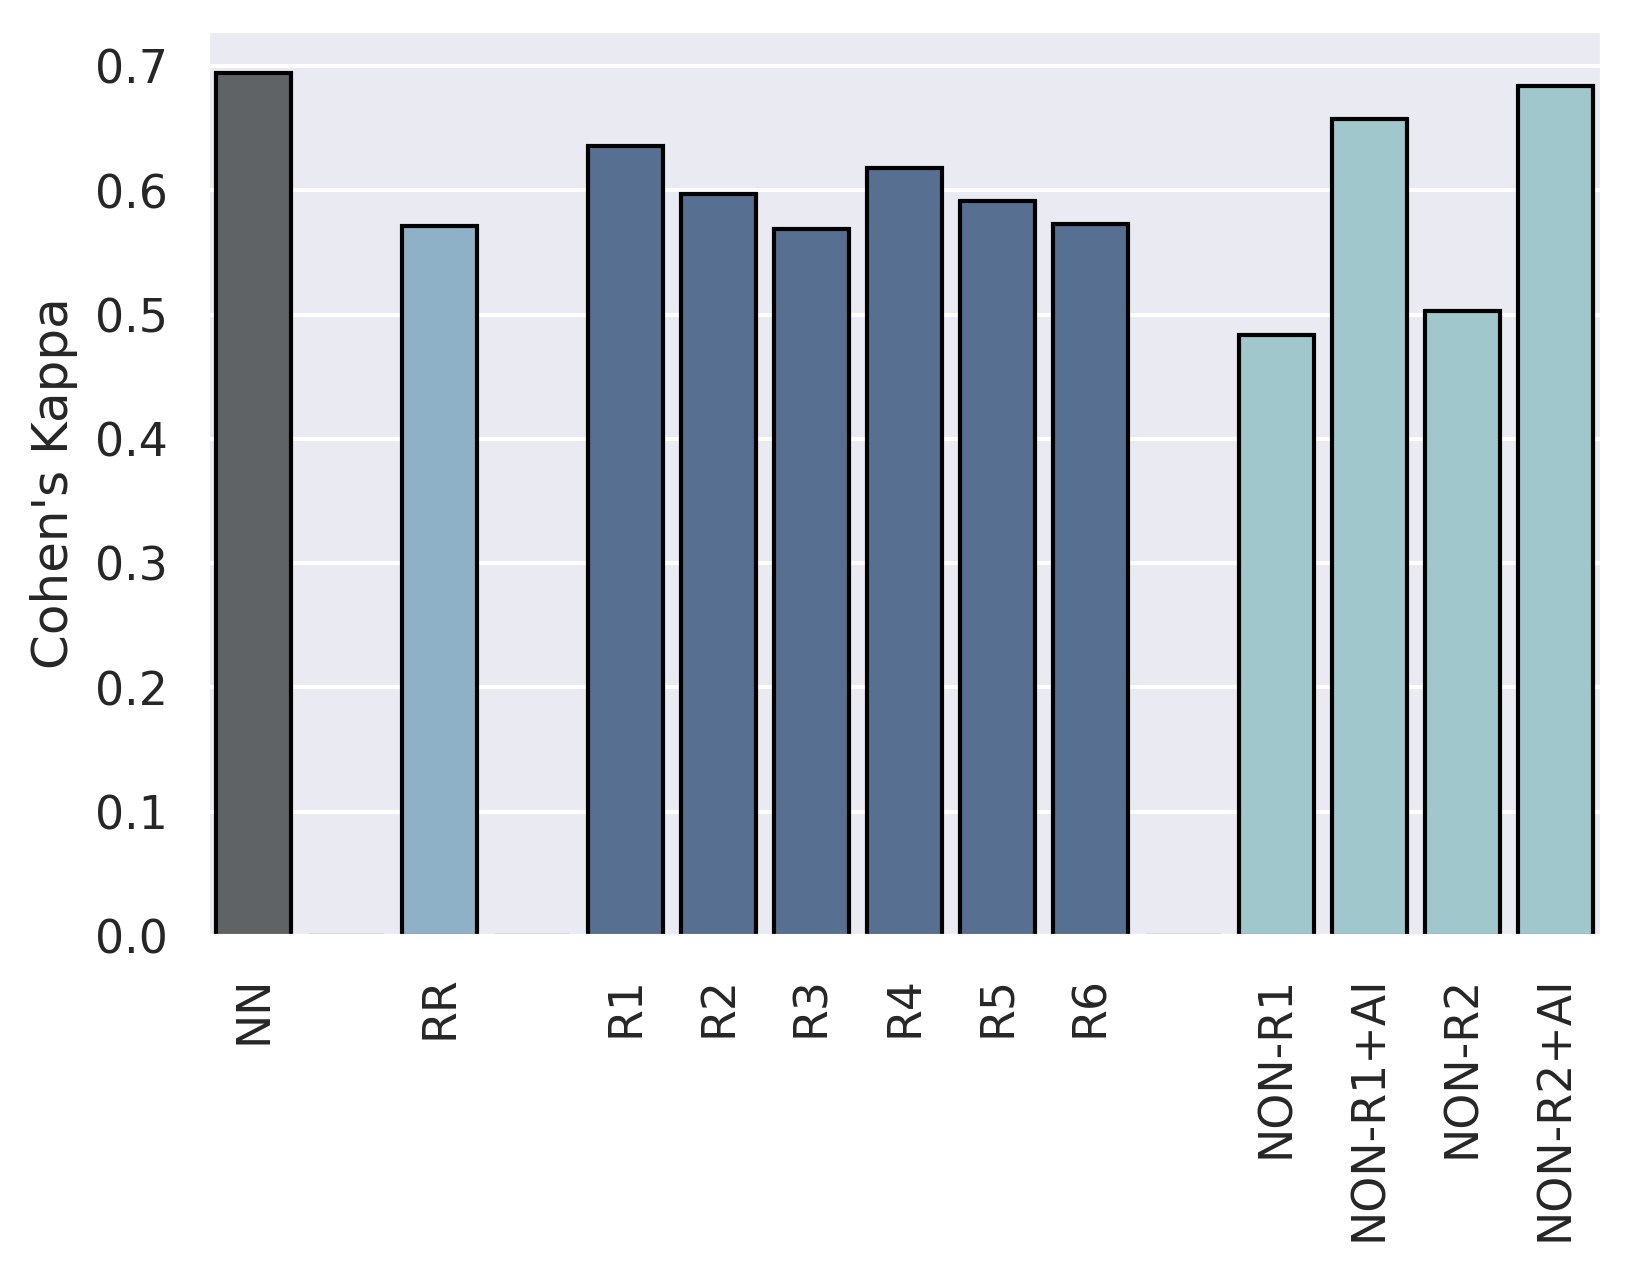

In [756]:
df_cohens_kappa = pd.DataFrame(index=challengers.keys())
for selected_radiologist in list(challengers.keys()):
    print(selected_radiologist)
    challenger1_annotations = challengers[selected_radiologist]
    df_maj = pd.DataFrame()
    for label in columns_of_interest:
        df_maj[label] = get_majority_voting(label, challengers_to_exclude = ['NN', 'NON-R1', 'NON-R1+AI', 'NON-R2', 'NON-R2+AI', selected_radiologist])
        
    challenger1_annotations_stacked = challenger1_annotations[columns_of_interest].stack()
    df_maj_stacked = df_maj[columns_of_interest].stack()
    
    # Normal cohens kappa
    cks = cohen_kappa_score(challenger1_annotations_stacked, df_maj_stacked)
    df_cohens_kappa.loc[selected_radiologist, "Cohen's Kappa"] = cks

_bar_data = df_cohens_kappa.copy()
bar_data = pd.concat([_bar_data[:1],
                      pd.DataFrame({'Cohens Kappa': {'' : 0.0}}),
                     _bar_data[1:2],
                      pd.DataFrame({'Cohens Kappa': {' ' : 0.0}}),
                     _bar_data[2:8],
                      pd.DataFrame({'Cohens Kappa': {'  ' : 0.0}}),
                     _bar_data[8:12],
                     ])

ax = sns.barplot(data=bar_data.transpose(), edgecolor='black', palette=[palette[0], palette[0], palette[1], palette[2], palette[2], palette[2], palette[2], palette[2], palette[2], palette[2], palette[3], palette[3], palette[3], palette[3], palette[3], palette[3]])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_ylabel("Cohen's Kappa")

#widthbars = [1, 0.2, 1, 0.2, 1, 1, 1, 1, 1, 1, 0.2, 1, 1]
#for bar, newwidth in zip(ax.patches, widthbars):
#    x = bar.get_x()
#    width = bar.get_width()
#    centre = x + width/2.
#    bar.set_x(centre - newwidth/2.)
#    bar.set_width(newwidth)
plt.gcf().set_dpi(300)

In [757]:
df_cohens_kappa

Cohen's Kappa
NN              0.694571
RR              0.571380
R1              0.635664
R2              0.597512
R3              0.568627
R4              0.617680
R5              0.591456
R6              0.572723
NON-R1          0.483899
NON-R1+AI       0.657289
NON-R2          0.502971
NON-R2+AI       0.684389

### Bootstrapping cohens kappa (using all pathologies as one)

In [481]:
df_kappa_samples_differences_all_pathologies = {}
df_kappa_samples_differences_all_pathologies_challengers = {}
for challenger1 in [challenger for challenger in challengers.keys() if challenger!='NN']:
        df_kappa_samples = pd.DataFrame(columns = ['all_labels'])
        df_kappa_samples_challengers = pd.DataFrame(columns = ['all_labels'])
        df_kappa_samples_prediction = pd.DataFrame(columns = ['all_labels'])

        for sample in tqdm(range(1000)):
            # Normal cohens kappa
            df_prediction_sampled = challengers['NN'].sample(n=100, replace=True, random_state=sample)
            df_challenger1_sampled = challengers[challenger1].sample(n=100, replace=True, random_state=sample)
            
            df_maj_sampled = pd.DataFrame()
            for label in columns_of_interest:
                df_maj_sampled[label] = get_majority_voting(label, challengers_to_exclude = ['NN', 'NON-R1', 'NON-R1+AI', 'NON-R2', 'NON-R2+AI', challenger1]).sample(n=100, replace=True, random_state=sample)
            
            df_prediction_sampled_stacked = df_prediction_sampled[columns_of_interest].stack()
            df_challenger1_sampled_stacked = df_challenger1_sampled[columns_of_interest].stack()
            df_maj_sampled_stacked = df_maj_sampled[columns_of_interest].stack()
            
            cks_challengers = cohen_kappa_score(df_challenger1_sampled_stacked, df_maj_sampled_stacked)
            cks_prediction = cohen_kappa_score(df_prediction_sampled_stacked, df_maj_sampled_stacked)

            cks_difference = cks_prediction - cks_challengers

            df_kappa_samples.loc[sample, 'all_labels'] = cks_difference
            df_kappa_samples_challengers.loc[sample, 'all_labels'] = cks_challengers
            df_kappa_samples_prediction.loc[sample, 'all_labels'] = cks_prediction
                
                
        print('-------------------------------------------------------------------------------')
        print(challenger1)
        display(df_kappa_samples)
        df_kappa_samples_differences_all_pathologies[challenger1] = df_kappa_samples
        df_kappa_samples_differences_all_pathologies_challengers[challenger1] = df_kappa_samples_challengers
        df_kappa_samples_differences_all_pathologies_challengers['NN_' + challenger1] = df_kappa_samples_prediction

100%|██████████| 1000/1000 [02:47<00:00,  5.97it/s]

-------------------------------------------------------------------------------
RR


all_labels
0     0.131018
1     0.110213
2    0.0848632
3      0.13288
4     0.106853
..         ...
995   0.123883
996   0.126087
997   0.111226
998   0.116463
999   0.160528

[1000 rows x 1 columns]

100%|██████████| 1000/1000 [02:48<00:00,  5.95it/s]

-------------------------------------------------------------------------------
R1


all_labels
0     0.0645648
1    0.00742259
2      0.015991
3     0.0610595
4     0.0163555
..          ...
995   0.0289463
996   0.0360137
997   0.0480299
998   0.0424118
999   0.0482948

[1000 rows x 1 columns]

100%|██████████| 1000/1000 [02:48<00:00,  5.95it/s]

-------------------------------------------------------------------------------
R2


all_labels
0     0.117502
1     0.102158
2    0.0898357
3    0.0995447
4    0.0632252
..         ...
995  0.0991482
996  0.0646873
997  0.0892436
998  0.0975115
999  0.0868487

[1000 rows x 1 columns]

100%|██████████| 1000/1000 [02:48<00:00,  5.95it/s]

-------------------------------------------------------------------------------
R3


all_labels
0      0.11218
1    0.0868006
2     0.113153
3     0.106204
4    0.0922513
..         ...
995   0.137262
996  0.0969142
997   0.111043
998    0.11134
999   0.130985

[1000 rows x 1 columns]

100%|██████████| 1000/1000 [02:48<00:00,  5.95it/s]

-------------------------------------------------------------------------------
R4


all_labels
0    0.0609778
1    0.0479489
2    0.0635841
3    0.0447066
4    0.0547015
..         ...
995  0.0315835
996  0.0410167
997  0.0511758
998  0.0470025
999  0.0337727

[1000 rows x 1 columns]

100%|██████████| 1000/1000 [02:49<00:00,  5.92it/s]

-------------------------------------------------------------------------------
R5


all_labels
0     0.100594
1     0.119717
2     0.143631
3     0.118109
4    0.0653711
..         ...
995    0.10853
996  0.0899833
997    0.10382
998  0.0794235
999  0.0635851

[1000 rows x 1 columns]

100%|██████████| 1000/1000 [02:47<00:00,  5.97it/s]

-------------------------------------------------------------------------------
R6


all_labels
0     0.114954
1     0.074006
2    0.0925053
3    0.0948372
4     0.108526
..         ...
995  0.0796644
996    0.11491
997  0.0443648
998   0.126517
999  0.0970366

[1000 rows x 1 columns]

100%|██████████| 1000/1000 [02:42<00:00,  6.14it/s]

-------------------------------------------------------------------------------
NON-R1


all_labels
0     0.186937
1      0.21706
2     0.204641
3     0.268278
4     0.204916
..         ...
995   0.211106
996   0.177918
997   0.218115
998   0.212496
999   0.235502

[1000 rows x 1 columns]

100%|██████████| 1000/1000 [02:41<00:00,  6.18it/s]

-------------------------------------------------------------------------------
NON-R1+AI


all_labels
0    0.0276226
1    0.0431538
2    0.0400861
3    0.0490022
4    0.0384133
..         ...
995  0.0159457
996  0.0245632
997  0.0610526
998  0.0324152
999  0.0440347

[1000 rows x 1 columns]

100%|██████████| 1000/1000 [02:42<00:00,  6.16it/s]

-------------------------------------------------------------------------------
NON-R2


all_labels
0     0.189852
1     0.171411
2     0.233539
3     0.211631
4     0.214689
..         ...
995   0.161546
996   0.136044
997   0.201309
998   0.237231
999   0.211221

[1000 rows x 1 columns]

100%|██████████| 1000/1000 [02:42<00:00,  6.16it/s]

-------------------------------------------------------------------------------
NON-R2+AI


all_labels
0      0.0186228
1    -0.00302886
2      0.0161439
3     -0.0081092
4       0.014432
..           ...
995 -0.000197388
996    0.0169966
997  -0.00285702
998    0.0387006
999     0.010309

[1000 rows x 1 columns]

In [482]:
for key in df_kappa_samples_differences_all_pathologies.keys():
    print('-------------------------------------------')
    print(key)
    print(df_kappa_samples_differences_all_pathologies[key]['all_labels'].quantile([0.025, 0.050, 0.975]))
    print("Std: ", df_kappa_samples_differences_all_pathologies[key]['all_labels'].std())
    num_samples_below_zero = len(df_kappa_samples_differences_all_pathologies[key]['all_labels'][df_kappa_samples_differences_all_pathologies[key]['all_labels']<0])
    num_samples = len(df_kappa_samples_differences_all_pathologies[key]['all_labels'])
    print('p-value: ' , num_samples_below_zero / num_samples)

-------------------------------------------
RR
0.025    0.0421588
0.050    0.0563672
0.975     0.177679
Name: all_labels, dtype: object
Std:  0.03393591681935915
p-value:  0.001
-------------------------------------------
R1
0.025    -0.028165
0.050   -0.0219781
0.975     0.082841
Name: all_labels, dtype: object
Std:  0.028354235374987793
p-value:  0.173
-------------------------------------------
R2
0.025    0.0395249
0.050    0.0479473
0.975     0.150383
Name: all_labels, dtype: object
Std:  0.028730378505224873
p-value:  0.001
-------------------------------------------
R3
0.025    0.0688491
0.050    0.0779561
0.975     0.179947
Name: all_labels, dtype: object
Std:  0.028685400304594176
p-value:  0.0
-------------------------------------------
R4
0.025   -0.00277919
0.050    0.00468915
0.975      0.104679
Name: all_labels, dtype: object
Std:  0.027286457752590157
p-value:  0.036
-------------------------------------------
R5
0.025    0.0347759
0.050    0.0448066
0.975     0.155093
N

In [483]:
for key in df_kappa_samples_differences_all_pathologies_challengers.keys():
    print('-------------------------------------------')
    print(key)
    print(df_kappa_samples_differences_all_pathologies_challengers[key]['all_labels'].quantile([0.025, 0.050, 0.975]))
    print("Std: ", df_kappa_samples_differences_all_pathologies_challengers[key]['all_labels'].std())

-------------------------------------------
RR
0.025    0.514469
0.050    0.519914
0.975    0.627589
Name: all_labels, dtype: object
Std:  0.02873825392991877
-------------------------------------------
NN_RR
0.025     0.63091
0.050    0.639563
0.975    0.730219
Name: all_labels, dtype: object
Std:  0.025552967974339813
-------------------------------------------
R1
0.025    0.579831
0.050    0.588781
0.975    0.687429
Name: all_labels, dtype: object
Std:  0.0275938735536398
-------------------------------------------
NN_R1
0.025    0.609899
0.050    0.617111
0.975    0.712017
Name: all_labels, dtype: object
Std:  0.026450442750903566
-------------------------------------------
R2
0.025    0.551446
0.050    0.559281
0.975    0.644378
Name: all_labels, dtype: object
Std:  0.023755104229129298
-------------------------------------------
NN_R2
0.025     0.64328
0.050    0.653117
0.975    0.739989
Name: all_labels, dtype: object
Std:  0.023848155093540685
----------------------------------

In [493]:
# p-value ICU physician
df_differences_icu_physician = df_kappa_samples_differences_all_pathologies_challengers['NON-R2+AI']['all_labels'] - df_kappa_samples_differences_all_pathologies_challengers['NON-R2']['all_labels']
print(df_differences_icu_physician.quantile([0.025, 0.050, 0.975]))
print("Std: ", df_differences_icu_physician.std())
num_samples_below_zero = len(df_differences_icu_physician[df_differences_icu_physician<0])
num_samples = len(df_differences_icu_physician)
print('p-value: ' , num_samples_below_zero / num_samples)


0.025    0.128235
0.050    0.138317
0.975    0.233518
Name: all_labels, dtype: object
Std:  0.026526495249076527
p-value:  0.0


##### Create the Barplot again but now with standard deviation

In [486]:
df_std_all_pathologies = pd.DataFrame(columns=['std'])
for key in list(challengers.keys()):
    key = 'NN_NON-R1+AI' if key=='NN' else key
    std = df_kappa_samples_differences_all_pathologies_challengers[key].std()
    key = 'NN' if key=='NN_NON-R1+AI' else key
    df_std_all_pathologies.loc[key] = std.item()
df_std_all_pathologies

std
NN         0.024417
RR         0.028738
R1         0.027594
R2         0.023755
R3         0.023869
R4         0.024462
R5         0.027935
R6         0.024687
NON-R1     0.022766
NON-R1+AI  0.022658
NON-R2     0.027899
NON-R2+AI  0.024465

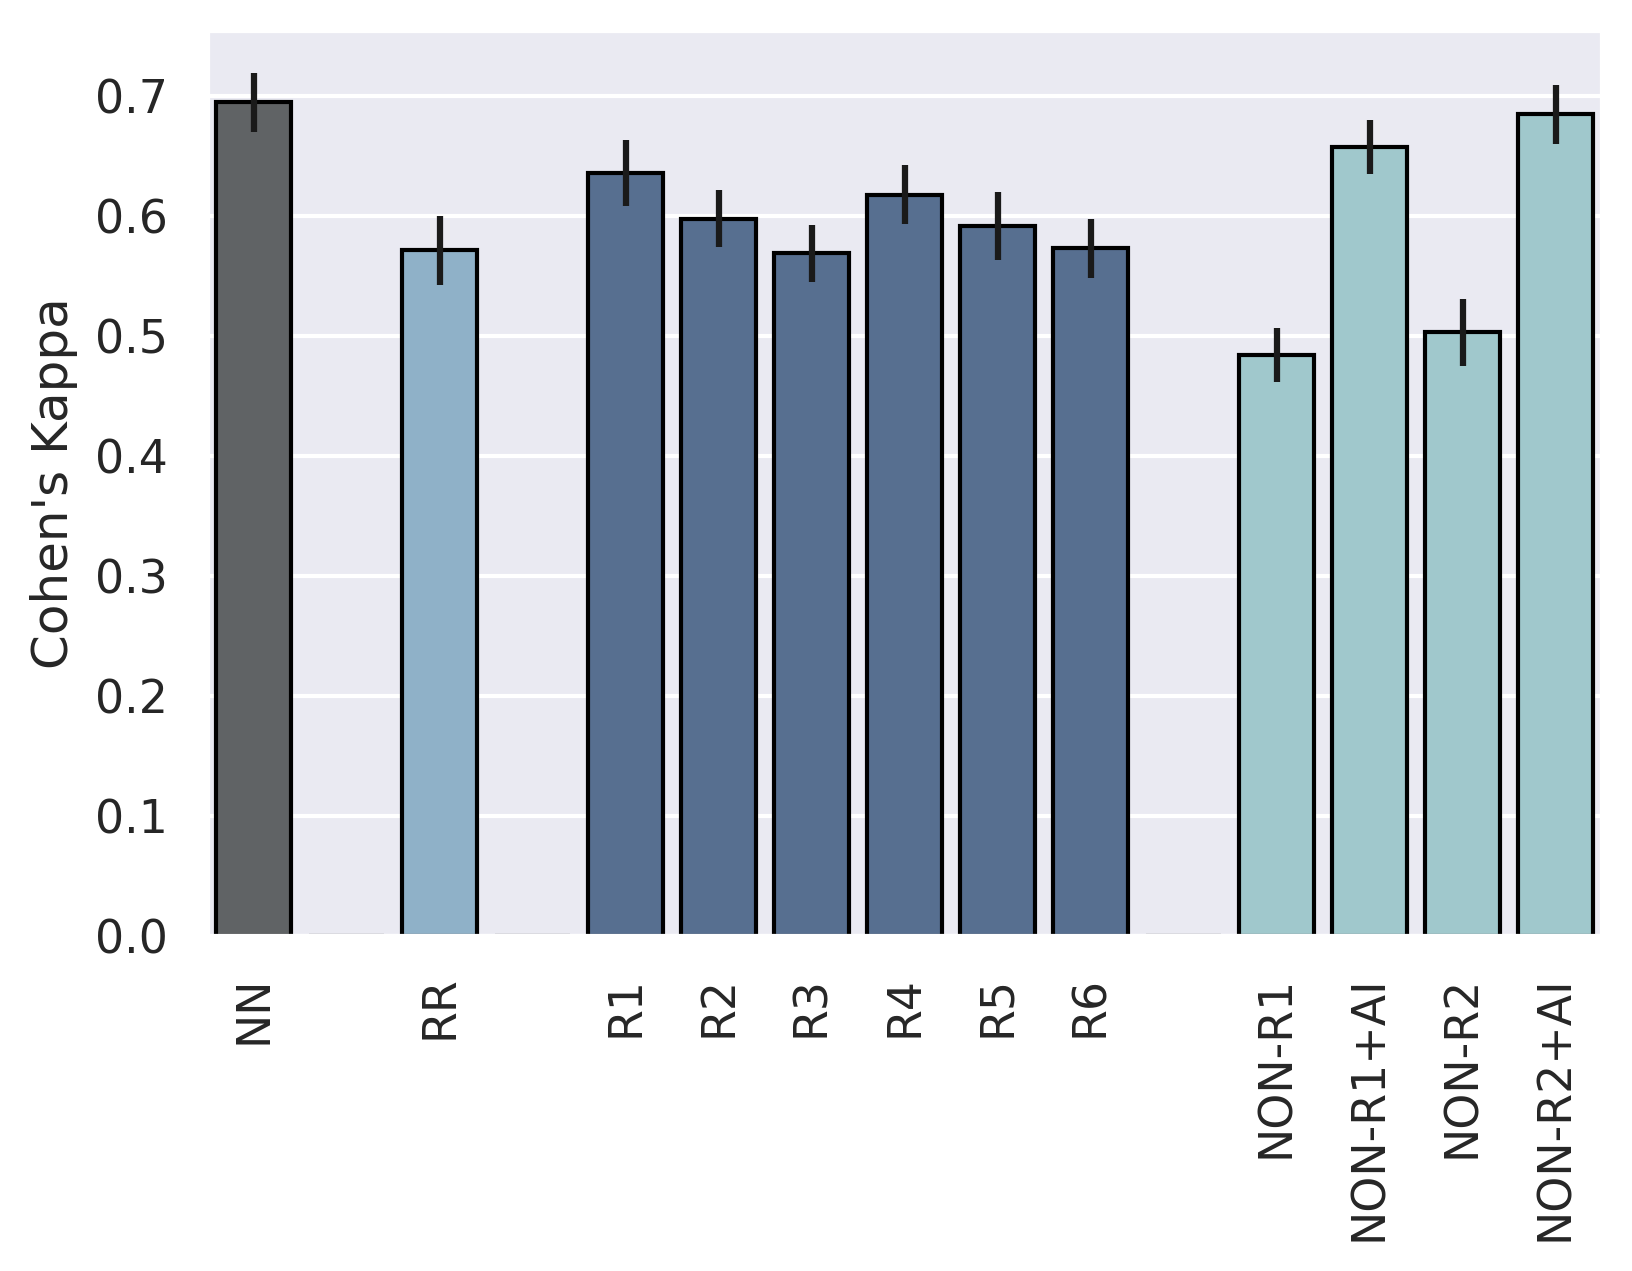

In [488]:
df_cohens_kappa = pd.DataFrame(index=challengers.keys())
for selected_radiologist in list(challengers.keys()):
    challenger1_annotations = challengers[selected_radiologist]
    df_maj = pd.DataFrame()
    for label in columns_of_interest:
        df_maj[label] = get_majority_voting(label, challengers_to_exclude = ['NN', 'NON-R1', 'NON-R1+AI', 'NON-R2', 'NON-R2+AI', selected_radiologist])
        
    challenger1_annotations_stacked = challenger1_annotations[columns_of_interest].stack()
    df_maj_stacked = df_maj[columns_of_interest].stack()
    
    # Normal cohens kappa
    cks = cohen_kappa_score(challenger1_annotations_stacked, df_maj_stacked)
    df_cohens_kappa.loc[selected_radiologist, "Cohens Kappa"] = cks

# Add empty elements to provide spacing between groups
_bar_data = df_cohens_kappa.copy()
bar_data = pd.concat([_bar_data[:1],
                      pd.DataFrame({'Cohens Kappa': {'' : 0.0}}),
                     _bar_data[1:2],
                      pd.DataFrame({'Cohens Kappa': {' ' : 0.0}}),
                     _bar_data[2:8],
                      pd.DataFrame({'Cohens Kappa': {'  ' : 0.0}}),
                     _bar_data[8:12],
                     ])

_bar_yerr = df_std_all_pathologies.copy()
bar_yerr = pd.concat([_bar_yerr[:1],
                      pd.DataFrame({'std': {'' : 0.0}}),
                     _bar_yerr[1:2],
                      pd.DataFrame({'std': {' ' : 0.0}}),
                     _bar_yerr[2:8],
                      pd.DataFrame({'std': {'  ' : 0.0}}),
                     _bar_yerr[8:12],
                     ])

ax = sns.barplot(yerr=bar_yerr.loc[:, 'std'].to_list(), data=bar_data.transpose(), edgecolor='black', palette=[palette[0], palette[0], palette[1], palette[2], palette[2], palette[2], palette[2], palette[2], palette[2], palette[2], palette[3], palette[3], palette[3], palette[3], palette[3], palette[3]])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_ylabel("Cohen's Kappa")

#widthbars = [1, 0.2, 1, 0.2, 1, 1, 1, 1, 1, 1, 0.2, 1, 1]
#for bar, newwidth in zip(ax.patches, widthbars):
#    x = bar.get_x()
#    width = bar.get_width()
#    centre = x + width/2.
#    bar.set_x(centre - newwidth/2.)
#    bar.set_width(newwidth)
plt.gcf().set_dpi(300)

### Confusion Matrix (all vs groundtruth)

In [ ]:
sns.set_style('white')

In [ ]:
dir_confusion_matrix_all_vs_gt = os.path.join(root_directory, 'confusion_matrix_all_vs_gt')
make_dir_save(dir_confusion_matrix_all_vs_gt)

In [ ]:
for label in columns_of_interest:
    print('-------------------------------------------------------------------------------')
    print(label)
    for challenger in challengers.keys():
        if 'Cardiomegaly' in label:
            label_order = herzgröße_labels
        elif 'Pneumothorax' in label:
            label_order = pneumothorax_labels
        else:
            label_order = standard_labels
        print('------------------------------------')
        print(challenger)
        cm = confusion_matrix(challengers[challenger][label], challengers['RR'][label], labels=label_order) # Pred vs GT
        plt = plot_confusion_matrix(cm, target_names=label_order, normalize=False, ylabel=challenger, xlabel='RR', title=label)
        plt.savefig(os.path.join(dir_confusion_matrix_all_vs_gt, f'{label}_{challenger}_vs_gt.png'))
        plt.show()

### Confusion Matrix (pred, gt vs majority voting of radiologists)

In [ ]:
dir_confusion_matrix_pred_gt_vs_maj = os.path.join(root_directory, 'confusion_matrix_pred_gt_vs_maj')
make_dir_save(dir_confusion_matrix_pred_gt_vs_maj)

In [ ]:
for label in columns_of_interest:
    print('-------------------------------------------------------------------------------')
    print(label)
    for challenger in ['NN', 'RR']:
        if 'Cardiomegaly' in label:
            label_order = herzgröße_labels
        elif 'Pneumothorax' in label:
            label_order = pneumothorax_labels
        else:
            label_order = standard_labels
        print('------------------------------------')
        print(challenger)
        df_majority_voting = get_majority_voting(label)
        cm = confusion_matrix(challengers[challenger][label], df_majority_voting, labels=label_order) # Pred vs GT
        plt = plot_confusion_matrix(cm, target_names=label_order, normalize=False, ylabel=challenger, xlabel='Majority voting', title=label, cmap=plt.get_cmap('Blues'))
        plt.savefig(os.path.join(dir_confusion_matrix_pred_gt_vs_maj, f'{label}_{challenger}_vs_maj.png'))
        plt.show()

### Correlate to Lab Results

In [696]:
lab_results_path = '/home/firas/Desktop/work/chest_radiography/data_laborwerte/Radiologie_Truhn_Laborwerte.csv'
df_lab_results = pd.read_csv(lab_results_path, engine="python", sep=';')

##### Add Aufnahmenummer to the columns of df_gt and df_pred

In [207]:
# RANK CONSISTENCY
df_test_set = pd.read_csv('/home/firas/Desktop/work/chest_radiography/data/test.csv')
df_pred_sorted_german = df_rank_consistency_stauung.set_index('Anforderungsnummer').sort_index()
df_test_sorted_german = df_test_set.set_index('Anforderungsnummer').sort_index()
df_gt_sorted_german = df_gt.set_index('Anforderungsnummer').sort_index()
df_pred_sorted_german['Aufnahmenummer'] = df_test_sorted_german['Aufnahmenummer']
df_gt_sorted_german['Aufnahmenummer'] = df_test_sorted_german['Aufnahmenummer']
df_pred_sorted_german['Untersuchungsdatum'] = df_test_sorted_german['Untersuchungsdatum']
df_gt_sorted_german['Untersuchungsdatum'] = df_test_sorted_german['Untersuchungsdatum']

/home/firas/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [698]:
# CHANGED
df_test_set = pd.read_csv('/home/firas/Desktop/work/chest_radiography/data/test.csv')
#df_test_set = pd.read_csv('/home/firas/Desktop/work/chest_radiography/data/test_lab_categorized_CRP.csv')
#df_test_set = pd.read_csv('/home/firas/Desktop/work/chest_radiography/data/test_lab_unfiltered.csv')
df_pred_sorted_german = df_pred.set_index('Anforderungsnummer').sort_index()
df_test_sorted_german = df_test_set.set_index('Anforderungsnummer').sort_index()
df_gt_sorted_german = df_gt.set_index('Anforderungsnummer').sort_index()
# CHANGED, appended values
df_pred_sorted_german['Aufnahmenummer'] = df_test_sorted_german['Aufnahmenummer'].values
df_gt_sorted_german['Aufnahmenummer'] = df_test_sorted_german['Aufnahmenummer'].values
df_pred_sorted_german['Untersuchungsdatum'] = df_test_sorted_german['Untersuchungsdatum'].values
df_gt_sorted_german['Untersuchungsdatum'] = df_test_sorted_german['Untersuchungsdatum'].values

/home/firas/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


##### Change the date columns from str to datetime

In [699]:
df_lab_results['Datum'] = pd.to_datetime(df_lab_results['Datum'])
df_pred_sorted_german['Untersuchungsdatum'] = pd.to_datetime(df_pred_sorted_german['Untersuchungsdatum'])
df_gt_sorted_german['Untersuchungsdatum'] = pd.to_datetime(df_gt_sorted_german['Untersuchungsdatum'])

In [700]:
df_gt_sorted_german['Stauung'].value_counts()

kein    16558
+       15531
(+)      4649
++       3177
+++       114
Name: Stauung, dtype: int64

###### Change the naming to english language

In [243]:
# RANK CONSISTENCY
columns_of_interest = ['Pulmonary Congestion'] 
dataframes_to_change = {'pred': df_pred_sorted_german, 'gt': df_gt_sorted_german}

# Change the actual language in the dataframes
for key, value in dataframes_to_change.items():
    # Standard labels
    for standard_label in ['Stauung']:
        dataframes_to_change[key][standard_label] = dataframes_to_change[key][standard_label].replace({'kein': 'none'})

    dataframes_to_change[key] = dataframes_to_change[key].rename(columns= {'Stauung': 'Pulmonary Congestion'})


In [701]:
columns_of_interest = ['Cardiomegaly', 'Pleural Effusion (left)', 'Pleural Effusion (right)', 'Pulmonary Infiltrates (left)', 'Pulmonary Infiltrates (right)', 
                       'Pulmonary Congestion', 'Atelectasis (left)', 'Atelectasis (right)'] 
dataframes_to_change = {'pred': df_pred_sorted_german, 'gt': df_gt_sorted_german}

# Change the actual language in the dataframes
for key, value in dataframes_to_change.items():
    # Standard labels
    for standard_label in ['Stauung', 'Erguss_re', 'Erguss_li', 'Infiltrate_re', 'Infiltrate_li', 'Bel.-Störungen_re', 'Bel.-störungen_li']:
        dataframes_to_change[key][standard_label] = dataframes_to_change[key][standard_label].replace({'kein': 'none'})

    # Herzgröße
    dataframes_to_change[key]['Herzgröße'] = dataframes_to_change[key]['Herzgröße'].replace({'normal': 'normal', 'grenzwertig': 'borderline', 'vergrößert': 'enlarged', 'massiv vergrößert': 'massively enlarged', 'nicht beurteilbar': 'not assessable'})
    
    # lowercase the pneumothorax annotations because some are capitalized in the radiologist labels
    dataframes_to_change[key]['Pneumothorax_re'] = dataframes_to_change[key]['Pneumothorax_re'].str.lower()
    dataframes_to_change[key]['Pneumothorax_li'] = dataframes_to_change[key]['Pneumothorax_li'].str.lower()
    
    # Pneumothorax
    dataframes_to_change[key]['Pneumothorax_re'] = dataframes_to_change[key]['Pneumothorax_re'].replace({'kein': 'none', 'spitze': 'apex', 'mantel': 'mantle', 'basal': 'basal', 'gering': 'minor', 'erheblich': 'considerable', 'spannung': 'tension'})
    dataframes_to_change[key]['Pneumothorax_li'] = dataframes_to_change[key]['Pneumothorax_li'].replace({'kein': 'none', 'spitze': 'apex', 'mantel': 'mantle', 'basal': 'basal', 'gering': 'minor', 'erheblich': 'considerable', 'spannung': 'tension'})

    dataframes_to_change[key] = dataframes_to_change[key].rename(columns= {'Herzgröße': 'Cardiomegaly', 'Erguss_li': 'Pleural Effusion (left)', 'Erguss_re': 'Pleural Effusion (right)', 'Infiltrate_li': 'Pulmonary Infiltrates (left)', 'Infiltrate_re': 'Pulmonary Infiltrates (right)', 
                       'Stauung': 'Pulmonary Congestion', 'Bel.-störungen_li': 'Atelectasis (left)', 'Bel.-Störungen_re': 'Atelectasis (right)'})


In [702]:
df_pred_sorted = dataframes_to_change['pred']
df_gt_sorted = dataframes_to_change['gt']

##### Filter out the necessary aufnahmenummern from the lab results

In [703]:
df_lab_results_filtered = df_lab_results[df_lab_results['Aufnahmenummer'].isin(df_pred_sorted['Aufnahmenummer'])]

In [704]:
# Filter out the necessary analytics (CRP and BNP)
df_lab_results_analytics_crp = df_lab_results_filtered[df_lab_results_filtered['Analyt'].isin(['CRP'])]
df_lab_results_analytics_bnp = df_lab_results_filtered[df_lab_results_filtered['Analyt'].isin(['NTpBNP2'])]

In [705]:
def nearest_date(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

##### CRP

In [706]:
crp_results = pd.DataFrame(columns=['Aufnahmenummer', 'ScanDatum', 'LabDatum', 'CRP', 'Pulmonary Infiltrates (left)', 'Pulmonary Infiltrates (right)', 'Pulmonary Congestion'])

crp_results_dict = {'pred': {'rating': df_pred_sorted, 'results_after_24_hours': crp_results.copy() , 'results_prior_24_hours': crp_results.copy()},
               'gt': {'rating': df_gt_sorted, 'results_after_24_hours': crp_results.copy() , 'results_prior_24_hours': crp_results.copy()}           
             }
for _, rater in crp_results_dict.items():
    unique_aufnahmenummern_crp = df_lab_results_analytics_crp['Aufnahmenummer'].unique()
    for aufnahmenummer in tqdm(unique_aufnahmenummern_crp):
        # Go through every x-ray scan of a specific aufnahmenummer and find the nearest lab result
        lab_results_of_interest = df_lab_results_analytics_crp[df_lab_results_analytics_crp['Aufnahmenummer']==aufnahmenummer]
        for _, scan in rater['rating'][rater['rating']['Aufnahmenummer']==aufnahmenummer].iterrows():
            scans_prior = lab_results_of_interest.set_index('Datum').sort_index().loc[:scan['Untersuchungsdatum']]
            scan_prior = scans_prior.iloc[-1] if not scans_prior.empty else None
            scans_after = lab_results_of_interest.set_index('Datum').sort_index().loc[scan['Untersuchungsdatum']:]
            scan_after = scans_after.iloc[0] if not scans_after.empty else None

            # check if the scans are within 24 hours of scan
            if (scan_prior is not None) and ((scan['Untersuchungsdatum'] - scan_prior.name).days < 2):
                try:
                    lab_value = float(scan_prior['Wert_txt'])
                    rater['results_prior_24_hours'] = rater['results_prior_24_hours'].append({'CRP': lab_value, 
                                                       'Pulmonary Infiltrates (left)': scan['Pulmonary Infiltrates (left)'],
                                                       'Pulmonary Infiltrates (right)': scan['Pulmonary Infiltrates (right)'],
                                                       'Pulmonary Congestion': scan['Pulmonary Congestion'],                                      
                                                       'ScanDatum': scan['Untersuchungsdatum'],
                                                       'LabDatum': scan_prior.name,
                                                       'Aufnahmenummer': aufnahmenummer,
                                                      }, ignore_index=True)
                except ValueError:
                    continue

            if (scan_after is not None) and ((scan_after.name - scan['Untersuchungsdatum']).days < 2):
                try:
                    lab_value = float(scan_after['Wert_txt'])  
                    rater['results_after_24_hours'] = rater['results_after_24_hours'].append({'CRP': lab_value, 
                                                   'Pulmonary Infiltrates (left)': scan['Pulmonary Infiltrates (left)'],
                                                   'Pulmonary Infiltrates (right)': scan['Pulmonary Infiltrates (right)'],
                                                   'Pulmonary Congestion': scan['Pulmonary Congestion'],                                                                                             
                                                   'ScanDatum': scan['Untersuchungsdatum'],
                                                   'LabDatum': scan_after.name, 
                                                   'Aufnahmenummer': aufnahmenummer,
                                                  }, ignore_index=True)
                except ValueError:
                    continue

# drop nans and create rank
for rater in ['pred', 'gt']:
    for result in ['results_after_24_hours', 'results_prior_24_hours']:
        crp_results_dict[rater][result] = crp_results_dict[rater][result].dropna()
        
        crp_results_rank = crp_results_dict[rater][result].copy()
        crp_results_rank['Pulmonary Infiltrates (left)'] = crp_results_rank['Pulmonary Infiltrates (left)'].replace({'none':0, '(+)': 1, '+': 2, '++': 3, '+++': 4})
        crp_results_rank['Pulmonary Infiltrates (right)'] = crp_results_rank['Pulmonary Infiltrates (right)'].replace({'none':0, '(+)': 1, '+': 2, '++': 3, '+++': 4})
        crp_results_rank['Pulmonary Congestion'] = crp_results_rank['Pulmonary Congestion'].replace({'none':0, '(+)': 1, '+': 2, '++': 3, '+++': 4})
        crp_results_dict[rater][result+'_rank'] = crp_results_rank       

100%|██████████| 9974/9974 [02:34<00:00, 64.71it/s] 


------------------------
results_after_24_hours


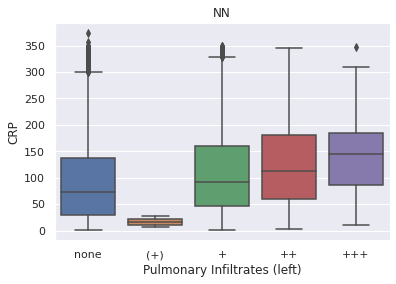

------------------------
results_after_24_hours


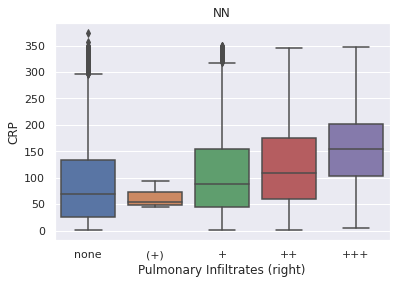

------------------------
results_after_24_hours


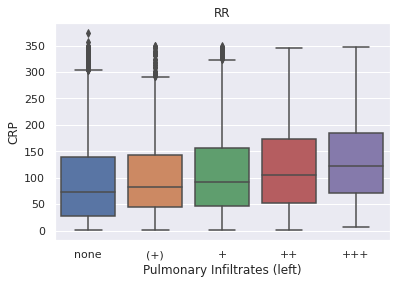

------------------------
results_after_24_hours


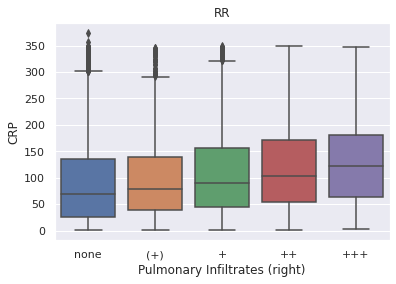

------------------------
results_prior_24_hours


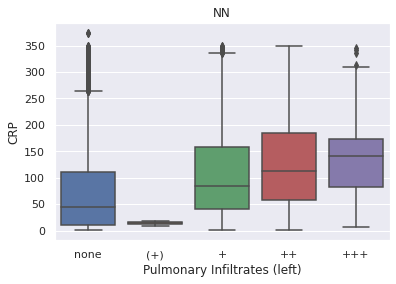

------------------------
results_prior_24_hours


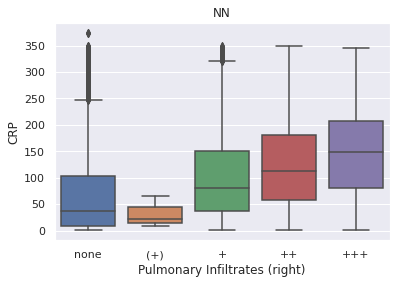

------------------------
results_prior_24_hours


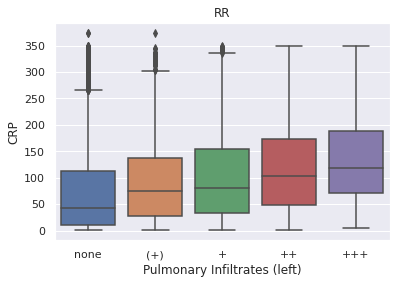

------------------------
results_prior_24_hours


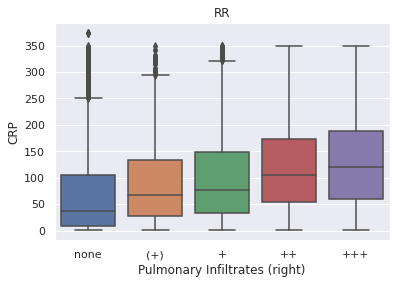

In [708]:
for result in ['results_after_24_hours', 'results_prior_24_hours']:
    for rater in ['pred', 'gt']:
        for label in ['Pulmonary Infiltrates (left)', 'Pulmonary Infiltrates (right)']:
            sns.boxplot(data=crp_results_dict[rater][result], x=label, y='CRP', order=standard_labels)
            print('------------------------')
            print(result)
            title = 'NN' if rater=='pred' else 'RR'
            plt.title(title)
            plt.show()

----------------------------------------
pred
------------------------
Pulmonary Infiltrates (left)
Spearman pred:  SpearmanrResult(correlation=0.1544790938195585, pvalue=3.7200586926946866e-84)
Kendall pred:  KendalltauResult(correlation=0.12316943536835567, pvalue=8.962860649048677e-84)
------------------------
Pulmonary Infiltrates (right)
Spearman pred:  SpearmanrResult(correlation=0.17262827435337838, pvalue=6.314851894798647e-105)
Kendall pred:  KendalltauResult(correlation=0.13657782979339914, pvalue=9.277942448539061e-105)
------------------------
Pulmonary Congestion
Spearman pred:  SpearmanrResult(correlation=0.13472266987476847, pvalue=2.8461426513751743e-64)
Kendall pred:  KendalltauResult(correlation=0.10910292336792898, pvalue=8.370289180276626e-64)
----------------------------------------
gt
------------------------
Pulmonary Infiltrates (left)
Spearman gt:  SpearmanrResult(correlation=0.14273515679569965, pvalue=5.363135753031421e-72)
Kendall gt:  KendalltauResult(corre

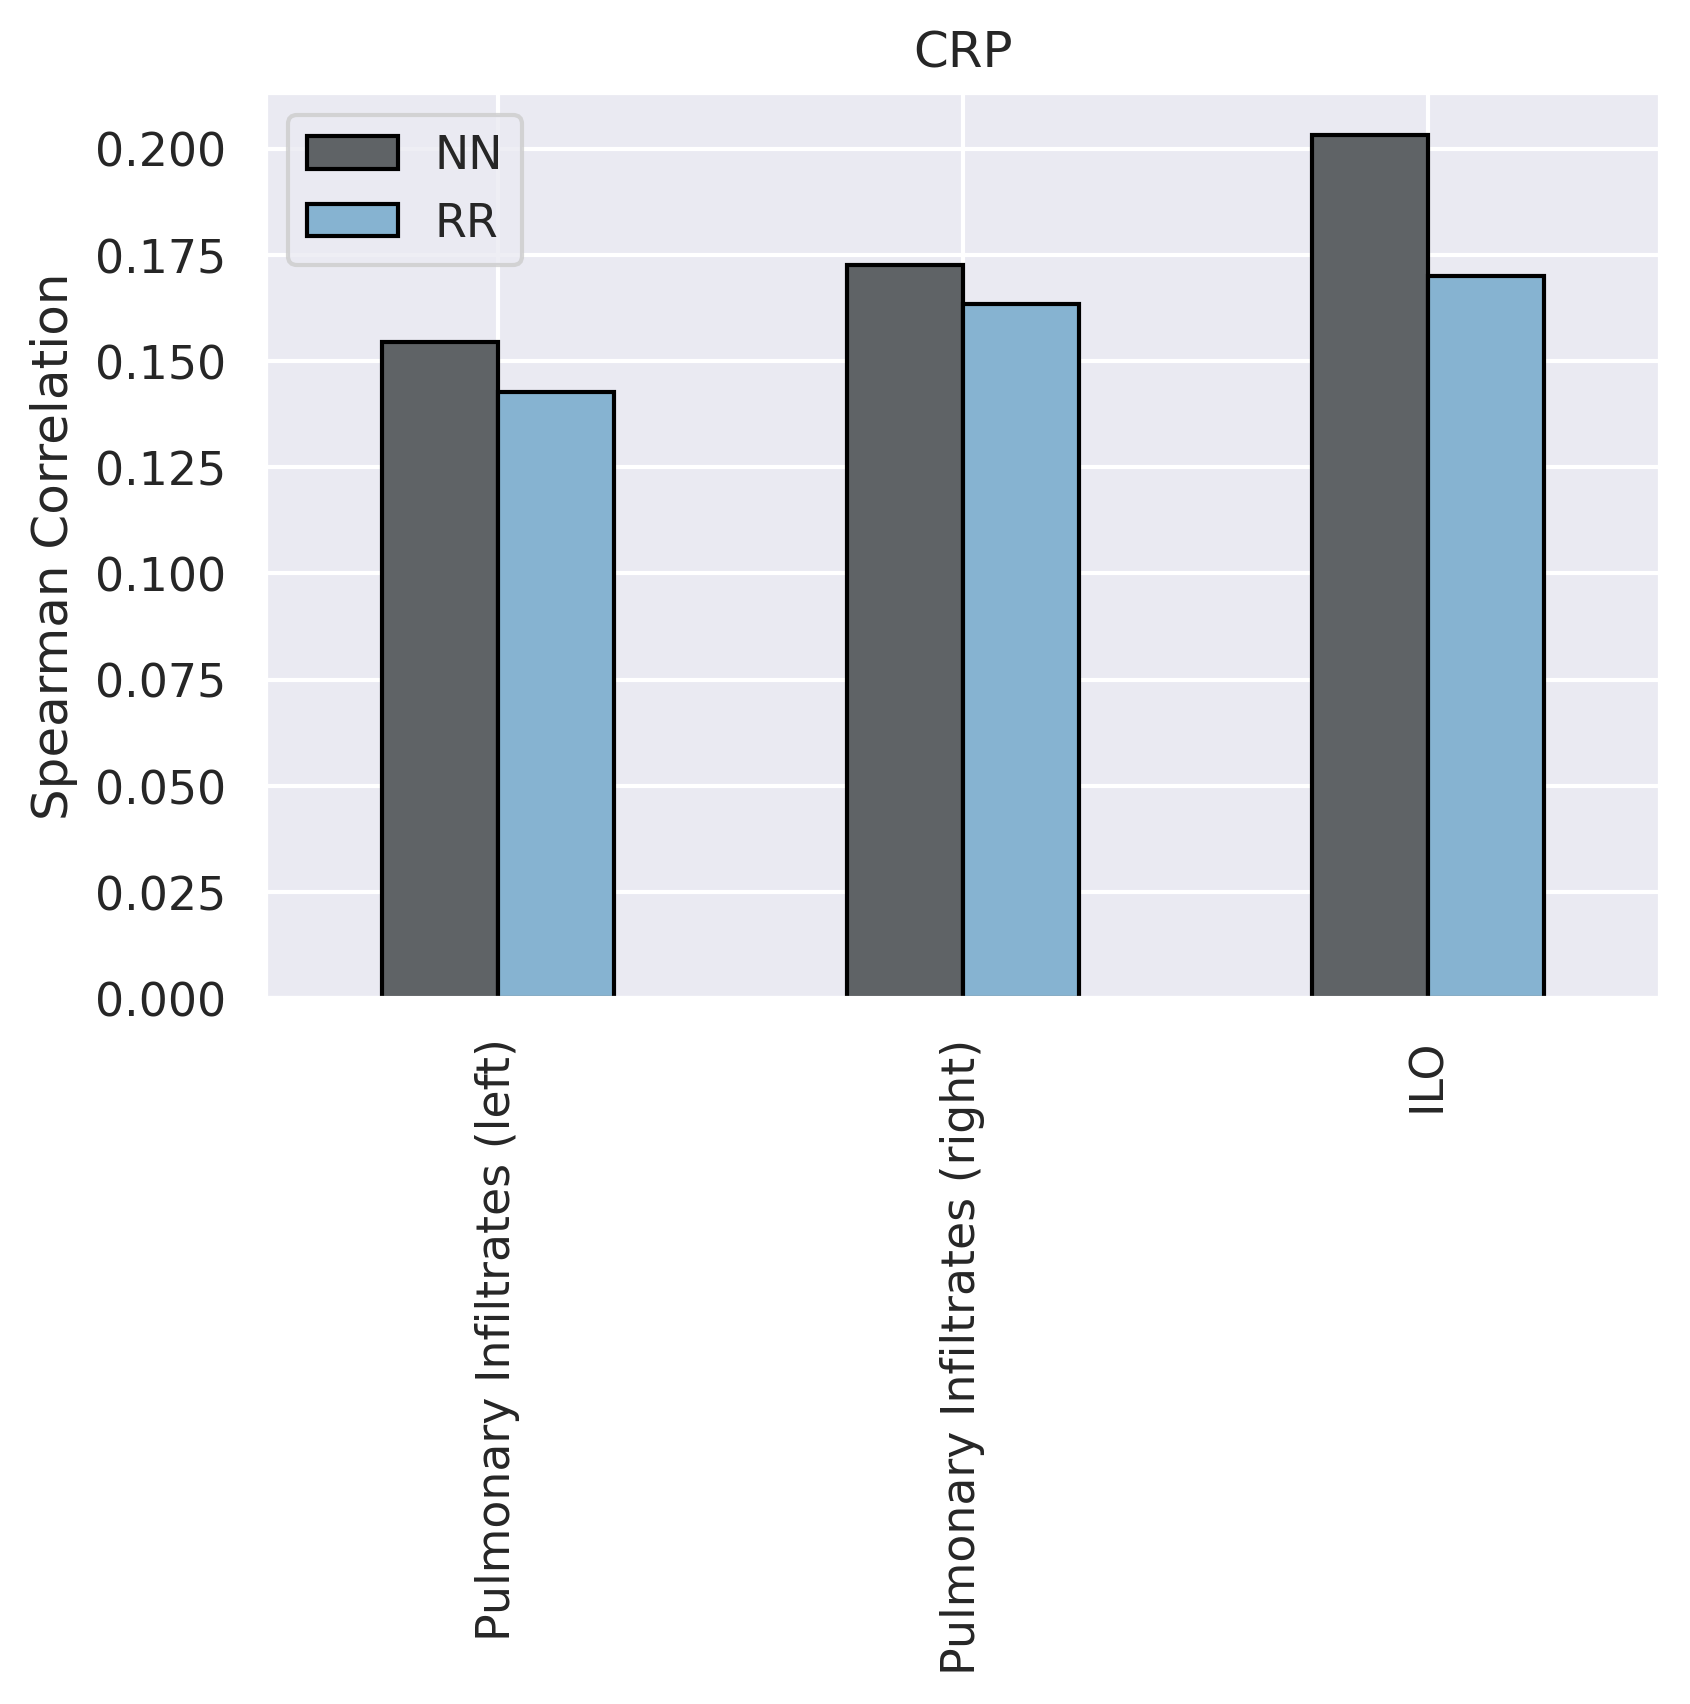

In [709]:
df_crp_spearman = pd.DataFrame(index=['Pulmonary Infiltrates (left)', 'Pulmonary Infiltrates (right)', 'Pulmonary Congestion', 'max(Infiltration, Congestion)'], columns=['NN', 'RR'])
for result in ['results_after_24_hours_rank']:
    for rater in ['pred', 'gt']:
        print('----------------------------------------')
        print(rater)
        for label in ['Pulmonary Infiltrates (left)', 'Pulmonary Infiltrates (right)', 'Pulmonary Congestion']:
            data = crp_results_dict[rater][result][label]
            crp = crp_results_dict[rater][result]['CRP']
            print('------------------------')
            print(label)
            spearman_val = stats.spearmanr(data, crp, nan_policy='raise')
            print(f'Spearman {rater}: ', spearman_val)
            print(f'Kendall {rater}: ', stats.kendalltau(data, crp, nan_policy='raise'))
            col_name = 'NN' if rater == 'pred' else 'RR'
            df_crp_spearman.loc[label][col_name] = spearman_val[0] 

print('\n\n----------------------------------------------------------')
print('Max over Infiltration and Congestion')
for result in ['results_after_24_hours_rank']:
    for rater in ['pred', 'gt']:
            data = crp_results_dict[rater][result].loc[:,['Pulmonary Infiltrates (left)', 'Pulmonary Infiltrates (right)', 'Pulmonary Congestion']].max(axis=1)
            crp = crp_results_dict[rater][result]['CRP']
            spearman_val = stats.spearmanr(data, crp, nan_policy='raise')
            print(f'Spearman {rater}: ', spearman_val[0])
            print(f'Kendall {rater}: ', stats.kendalltau(data, crp, nan_policy='raise')[0])
            col_name = 'NN' if rater == 'pred' else 'RR'
            df_crp_spearman.loc['max(Infiltration, Congestion)'][col_name] = spearman_val[0] 

df_crp_spearman = df_crp_spearman.rename(index={'max(Infiltration, Congestion)': 'ILO'})
df_crp_spearman.loc[['Pulmonary Infiltrates (left)', 'Pulmonary Infiltrates (right)', 'ILO'], :].plot.bar(color=palette, edgecolor="black")
plt.title('CRP')
plt.ylabel("Spearman Correlation")
plt.gcf().set_dpi(300)
plt.show()

In [710]:
# Do bootstrapping here
df_bootstrapping_crp = pd.DataFrame()

df_bootstrapping_crp_pred = pd.DataFrame(columns=['Pulmonary Infiltrates (left)', 'Pulmonary Infiltrates (right)', 'max(Infiltration, Congestion)'])
df_bootstrapping_crp_gt = pd.DataFrame(columns=['Pulmonary Infiltrates (left)', 'Pulmonary Infiltrates (right)'])

for sample in tqdm(range(1000)):
    sample_results = {}
    for result in ['results_after_24_hours_rank', 'results_prior_24_hours_rank']:
        gt_crp_results_sampled = crp_results_dict['gt'][result].sample(n=len(crp_results_dict['gt'][result]), replace=True, random_state=sample)
        pred_crp_results_sampled = crp_results_dict['pred'][result].sample(n=len(crp_results_dict['pred'][result]), replace=True, random_state=sample)
        
        sample_results_pred = {}
        sample_results_gt = {}
        for label in ['Pulmonary Infiltrates (left)', 'Pulmonary Infiltrates (right)', 'max(Infiltration, Congestion)']:
            if label == 'max(Infiltration, Congestion)':
                pred_crp_results_sampled_label = pred_crp_results_sampled.loc[:,['Pulmonary Infiltrates (left)', 'Pulmonary Infiltrates (right)', 'Pulmonary Congestion']].max(axis=1)
                pred_crp_results_sampled_crp = pred_crp_results_sampled['CRP']
                gt_crp_results_sampled_label = gt_crp_results_sampled.loc[:,['Pulmonary Infiltrates (left)', 'Pulmonary Infiltrates (right)', 'Pulmonary Congestion']].max(axis=1)
                gt_crp_results_sampled_crp = gt_crp_results_sampled['CRP']
            else:
                pred_crp_results_sampled_label = pred_crp_results_sampled[label]
                pred_crp_results_sampled_crp = pred_crp_results_sampled['CRP']
                gt_crp_results_sampled_label = gt_crp_results_sampled[label]
                gt_crp_results_sampled_crp = gt_crp_results_sampled['CRP']
                
            spearman_pred = stats.spearmanr(pred_crp_results_sampled_label, pred_crp_results_sampled_crp, 
                                                                          nan_policy='raise')[0]
            spearman_gt = stats.spearmanr(gt_crp_results_sampled_label, gt_crp_results_sampled_crp, 
                                                                          nan_policy='raise')[0]
            kendall_pred = stats.kendalltau(pred_crp_results_sampled_label, pred_crp_results_sampled_crp, 
                                                          nan_policy='raise')[0]
            kendall_gt = stats.kendalltau(gt_crp_results_sampled_label, gt_crp_results_sampled_crp, 
                                                          nan_policy='raise')[0]
            
            sample_results[f'{result}_{label}_spearman'] =  spearman_pred - spearman_gt
            sample_results[f'{result}_{label}_kendall'] =  kendall_pred - kendall_gt
            sample_results_pred[label] = spearman_pred
            sample_results_gt[label] = spearman_gt
            
        if result == 'results_after_24_hours_rank':
            df_bootstrapping_crp_pred = df_bootstrapping_crp_pred.append(sample_results_pred, ignore_index=True)
            df_bootstrapping_crp_gt = df_bootstrapping_crp_gt.append(sample_results_gt, ignore_index=True)
            
    df_bootstrapping_crp = df_bootstrapping_crp.append(sample_results, ignore_index=True)

100%|██████████| 1000/1000 [01:02<00:00, 15.93it/s]


In [711]:
df_bootstrapping_crp.quantile([0.025, 0.05, 0.095, 0.975])

results_after_24_hours_rank_Pulmonary Infiltrates (left)_kendall  \
0.025                                           0.002888                  
0.050                                           0.004289                  
0.095                                           0.005852                  
0.975                                           0.022852                  

       results_after_24_hours_rank_Pulmonary Infiltrates (left)_spearman  \
0.025                                          -0.000633                   
0.050                                           0.001415                   
0.095                                           0.003296                   
0.975                                           0.025225                   

       results_after_24_hours_rank_Pulmonary Infiltrates (right)_kendall  \
0.025                                           0.001144                   
0.050                                           0.002778                   
0.095                                           0.004621                   
0.975                                           0.020149                   

       results_after_24_hours_rank_Pulmonary Infiltrates (right)_spearman  \
0.025                                          -0.003498                    
0.050                                          -0.001219                    
0.095                                           0.001187                    
0.975                                           0.021182                    

       results_after_24_hours_rank_max(Infiltration, Congestion)_kendall  \
0.025                                           0.021275                   
0.050                                           0.022404                   
0.095                                           0.024475                   
0.975                                           0.040376                   

       results_after_24_hours_rank_max(Infiltration, Congestion)_spearman  \
0.025                                           0.020973                    
0.050                                           0.022371                    
0.095                                           0.024788                    
0.975                                           0.045501                    

       results_prior_24_hours_rank_Pulmonary Infiltrates (left)_kendall  \
0.025                                           0.015215                  
0.050                                           0.016499                  
0.095                                           0.018647                  
0.975                                           0.034879                  

       results_prior_24_hours_rank_Pulmonary Infiltrates (left)_spearman  \
0.025                                           0.011458                   
0.050                                           0.013209                   
0.095                                           0.015939                   
0.975                                           0.036379                   

       results_prior_24_hours_rank_Pulmonary Infiltrates (right)_kendall  \
0.025                                           0.020796                   
0.050                                           0.022421                   
0.095                                           0.024129                   
0.975                                           0.039139                   

       results_prior_24_hours_rank_Pulmonary Infiltrates (right)_spearman  \
0.025                                           0.017189                    
0.050                                           0.019275                    
0.095                                           0.021302                    
0.975                                           0.040874                    

       results_prior_24_hours_rank_max(Infiltration, Congestion)_kendall  \
0.025                                           0.025706                   
0.050                                   

In [715]:
# p-values CRP
num_infiltration_left_above_zero = len(df_bootstrapping_crp['results_after_24_hours_rank_Pulmonary Infiltrates (left)_spearman'][df_bootstrapping_crp['results_after_24_hours_rank_Pulmonary Infiltrates (left)_spearman']>0])
num_all = len(df_bootstrapping_crp['results_after_24_hours_rank_Pulmonary Infiltrates (left)_spearman'])
print('p-value (CRP, Infiltration (left)): ', num_infiltration_left_above_zero / num_all)

num_infiltration_right_above_zero = len(df_bootstrapping_crp['results_after_24_hours_rank_Pulmonary Infiltrates (right)_spearman'][df_bootstrapping_crp['results_after_24_hours_rank_Pulmonary Infiltrates (right)_spearman']>0])
num_all = len(df_bootstrapping_crp['results_after_24_hours_rank_Pulmonary Infiltrates (right)_spearman'])
print('p-value (CRP, Infiltration (right)): ', num_infiltration_right_above_zero / num_all)

num_max_infiltration_congestion_below_zero = len(df_bootstrapping_crp['results_after_24_hours_rank_max(Infiltration, Congestion)_spearman'][df_bootstrapping_crp['results_after_24_hours_rank_max(Infiltration, Congestion)_spearman']<0])
num_all = len(df_bootstrapping_crp['results_after_24_hours_rank_max(Infiltration, Congestion)_spearman'])
print('p-value (CRP, max(Infiltration, Congestion)): ', num_max_infiltration_congestion_below_zero / num_all)

p-value (CRP, Infiltration (left)):  0.03
p-value (CRP, Infiltration (right)):  0.068
p-value (CRP, max(Infiltration, Congestion)):  0.0


In [713]:
# Create plots with error bars
df_crp_std = pd.DataFrame(columns=['NN', 'RR'])
print('(NN) Std: \n\n', df_bootstrapping_crp_pred.loc[:, ['Pulmonary Infiltrates (left)', 'Pulmonary Infiltrates (right)', 'max(Infiltration, Congestion)']].std())
print('------')
print('(NN) Quantile: \n\n', df_bootstrapping_crp_pred.loc[:, ['Pulmonary Infiltrates (left)', 'Pulmonary Infiltrates (right)', 'max(Infiltration, Congestion)']].quantile([0.025, 0.975]))
print('---------------------')
print('(CR) Std: \n\n', df_bootstrapping_crp_gt.loc[:, ['Pulmonary Infiltrates (left)', 'Pulmonary Infiltrates (right)', 'max(Infiltration, Congestion)']].std())
print('------')
print('(CR) Quantile: \n\n', df_bootstrapping_crp_gt.loc[:, ['Pulmonary Infiltrates (left)', 'Pulmonary Infiltrates (right)', 'max(Infiltration, Congestion)']].quantile([0.025, 0.975]))

df_crp_std.loc[:, 'NN'] = df_bootstrapping_crp_pred.loc[:, ['Pulmonary Infiltrates (left)', 'Pulmonary Infiltrates (right)', 'max(Infiltration, Congestion)']].std()
df_crp_std.loc[:, 'RR'] = df_bootstrapping_crp_gt.loc[:, ['Pulmonary Infiltrates (left)', 'Pulmonary Infiltrates (right)', 'max(Infiltration, Congestion)']].std()
df_crp_std

(NN) Std: 

 Pulmonary Infiltrates (left)     0.007558
Pulmonary Infiltrates (right)    0.007589
max(Infiltration, Congestion)    0.007593
dtype: float64
------
(NN) Quantile: 

        Pulmonary Infiltrates (left)  Pulmonary Infiltrates (right)  \
0.025                      0.139884                       0.157616   
0.975                      0.169758                       0.187262   

       max(Infiltration, Congestion)  
0.025                       0.189293  
0.975                       0.218185  
---------------------
(CR) Std: 

 Pulmonary Infiltrates (left)     0.007601
Pulmonary Infiltrates (right)    0.007393
max(Infiltration, Congestion)    0.007542
dtype: float64
------
(CR) Quantile: 

        Pulmonary Infiltrates (left)  Pulmonary Infiltrates (right)  \
0.025                      0.128314                       0.149604   
0.975                      0.157362                       0.178317   

       max(Infiltration, Congestion)  
0.025                       0.155888  
0.9

NN        RR
Pulmonary Infiltrates (left)   0.007558  0.007601
Pulmonary Infiltrates (right)  0.007589  0.007393
max(Infiltration, Congestion)  0.007593  0.007542

----------------------------------------
pred
------------------------
Pulmonary Infiltrates (left)
Spearman pred:  SpearmanrResult(correlation=0.1544790938195585, pvalue=3.7200586926946866e-84)
Kendall pred:  KendalltauResult(correlation=0.12316943536835567, pvalue=8.962860649048677e-84)
------------------------
Pulmonary Infiltrates (right)
Spearman pred:  SpearmanrResult(correlation=0.17262827435337838, pvalue=6.314851894798647e-105)
Kendall pred:  KendalltauResult(correlation=0.13657782979339914, pvalue=9.277942448539061e-105)
------------------------
Pulmonary Congestion
Spearman pred:  SpearmanrResult(correlation=0.13472266987476847, pvalue=2.8461426513751743e-64)
Kendall pred:  KendalltauResult(correlation=0.10910292336792898, pvalue=8.370289180276626e-64)
----------------------------------------
gt
------------------------
Pulmonary Infiltrates (left)
Spearman gt:  SpearmanrResult(correlation=0.14273515679569965, pvalue=5.363135753031421e-72)
Kendall gt:  KendalltauResult(corre

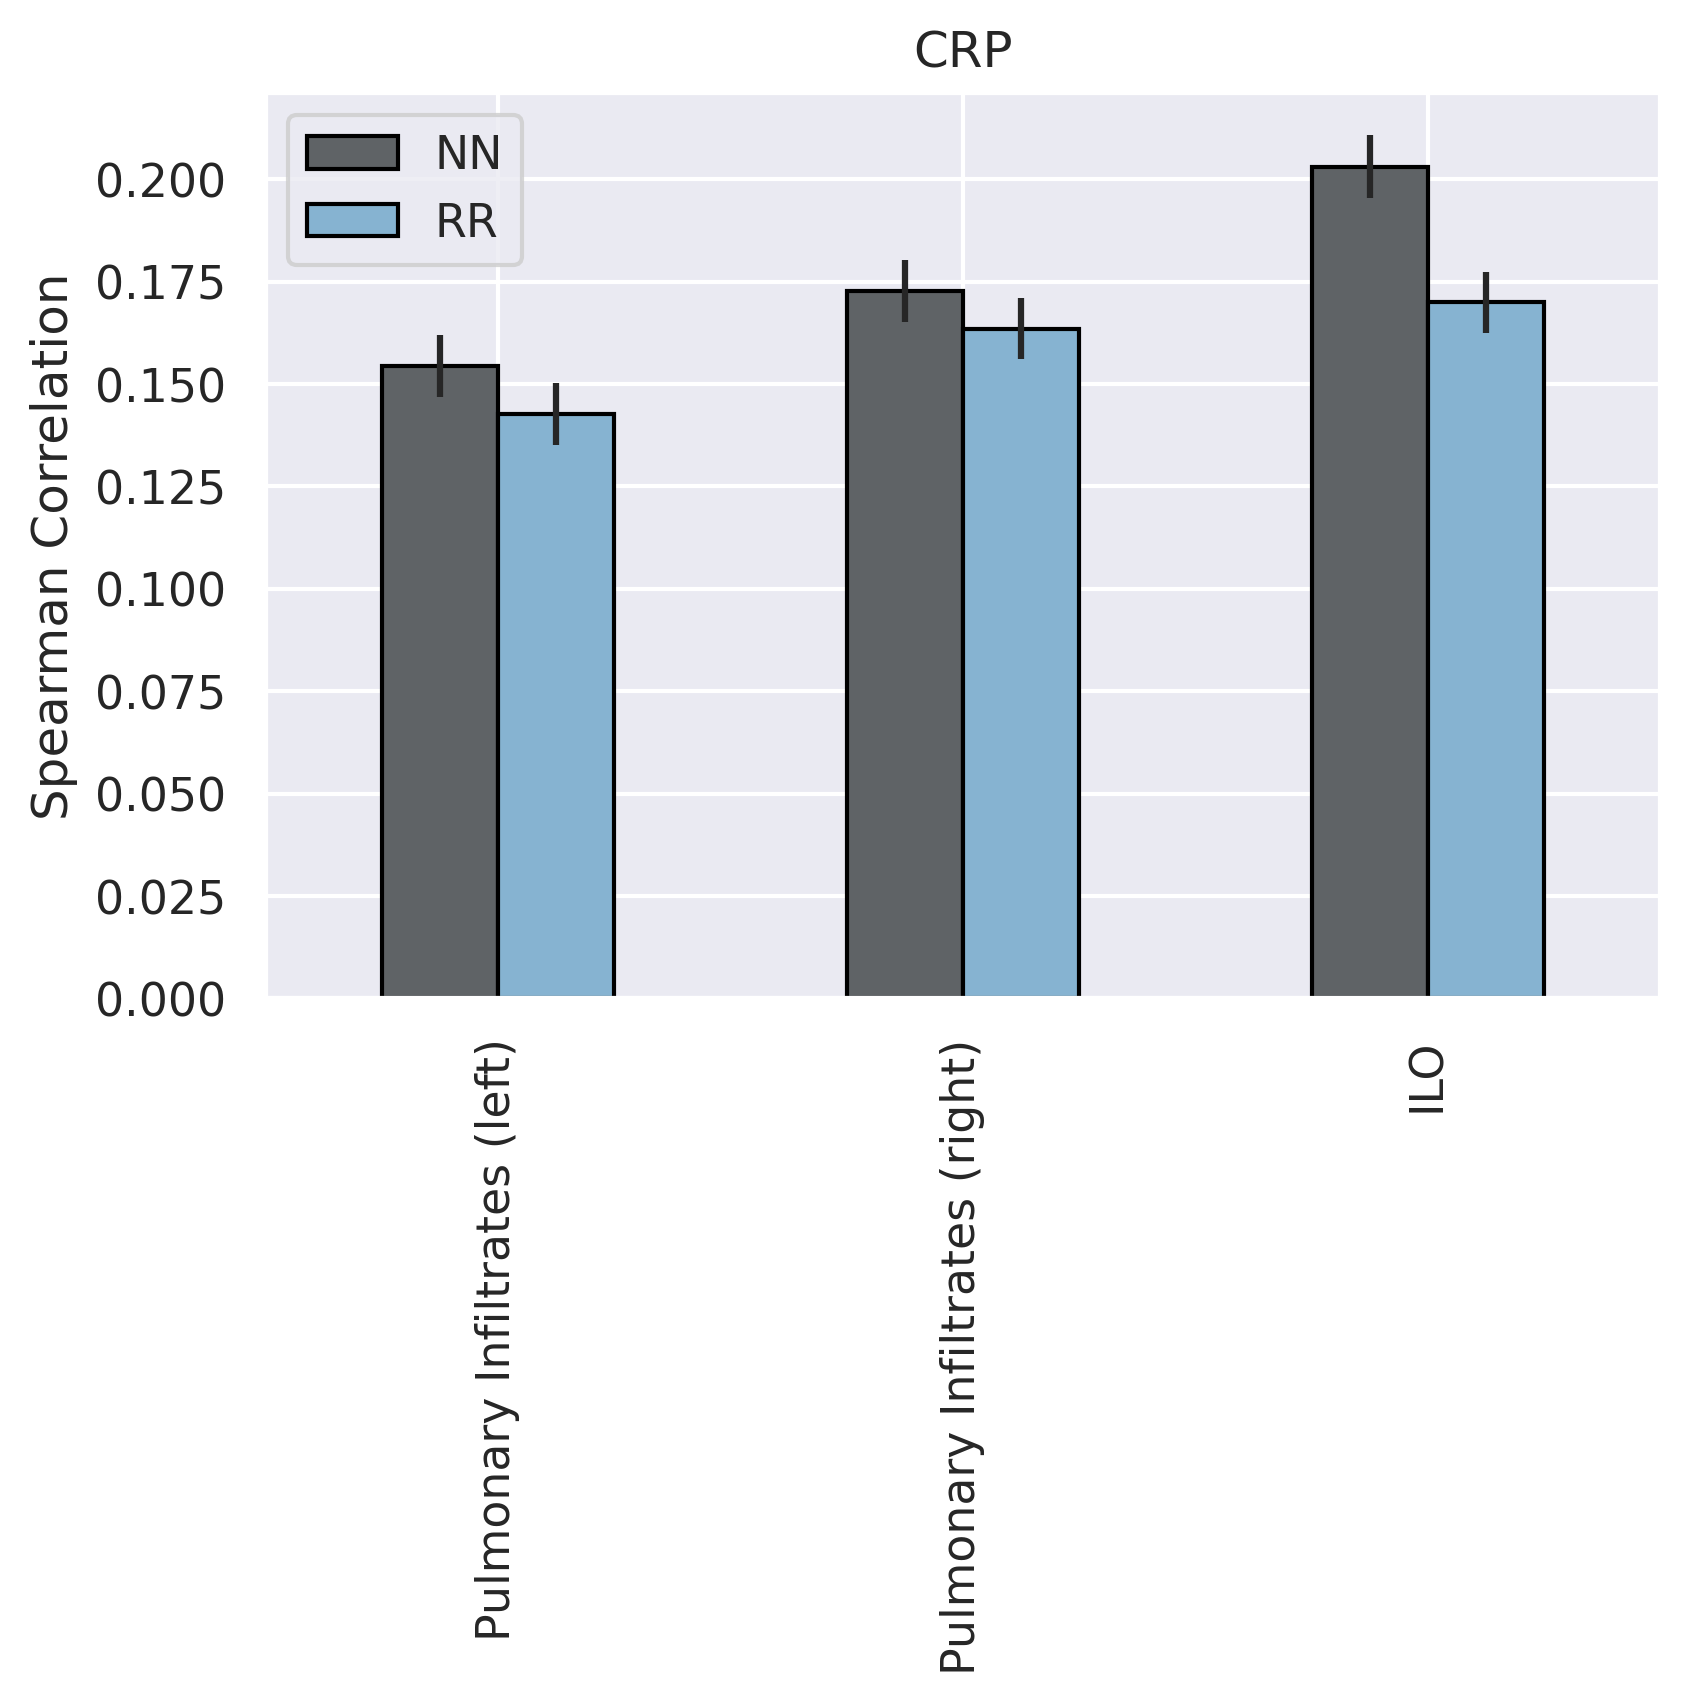

In [714]:
df_crp_spearman = pd.DataFrame(index=['Pulmonary Infiltrates (left)', 'Pulmonary Infiltrates (right)', 'Pulmonary Congestion', 'max(Infiltration, Congestion)'], columns=['NN', 'RR'])
for result in ['results_after_24_hours_rank']:
    for rater in ['pred', 'gt']:
        print('----------------------------------------')
        print(rater)
        for label in ['Pulmonary Infiltrates (left)', 'Pulmonary Infiltrates (right)', 'Pulmonary Congestion']:
            data = crp_results_dict[rater][result][label]
            crp = crp_results_dict[rater][result]['CRP']
            print('------------------------')
            print(label)
            spearman_val = stats.spearmanr(data, crp, nan_policy='raise')
            print(f'Spearman {rater}: ', spearman_val)
            print(f'Kendall {rater}: ', stats.kendalltau(data, crp, nan_policy='raise'))
            col_name = 'NN' if rater == 'pred' else 'RR'
            df_crp_spearman.loc[label][col_name] = spearman_val[0] 

print('\n\n----------------------------------------------------------')
print('Max over Infiltration and Congestion')
for result in ['results_after_24_hours_rank']:
    for rater in ['pred', 'gt']:
            data = crp_results_dict[rater][result].loc[:,['Pulmonary Infiltrates (left)', 'Pulmonary Infiltrates (right)', 'Pulmonary Congestion']].max(axis=1)
            crp = crp_results_dict[rater][result]['CRP']
            spearman_val = stats.spearmanr(data, crp, nan_policy='raise')
            print(f'Spearman {rater}: ', spearman_val[0])
            print(f'Kendall {rater}: ', stats.kendalltau(data, crp, nan_policy='raise')[0])
            col_name = 'NN' if rater == 'pred' else 'RR'
            df_crp_spearman.loc['max(Infiltration, Congestion)'][col_name] = spearman_val[0] 

df_crp_std = df_crp_std.rename(index={'max(Infiltration, Congestion)': 'ILO'})
df_crp_spearman = df_crp_spearman.rename(index={'max(Infiltration, Congestion)': 'ILO'})
df_crp_spearman.loc[['Pulmonary Infiltrates (left)', 'Pulmonary Infiltrates (right)', 'ILO'], :].plot.bar(yerr=df_crp_std, color=palette, edgecolor="black")
plt.title('CRP')
plt.ylabel("Spearman Correlation")
plt.gcf().set_dpi(300)
plt.show()

In [194]:
# ONLY NEEDED FOR COMBINED PLOT. NEED TO RUN CODE TWICE
df_crp_spearman_weighted_crp_loss = df_crp_spearman.copy()
df_crp_std_weighted_crp_loss = df_crp_std.copy()

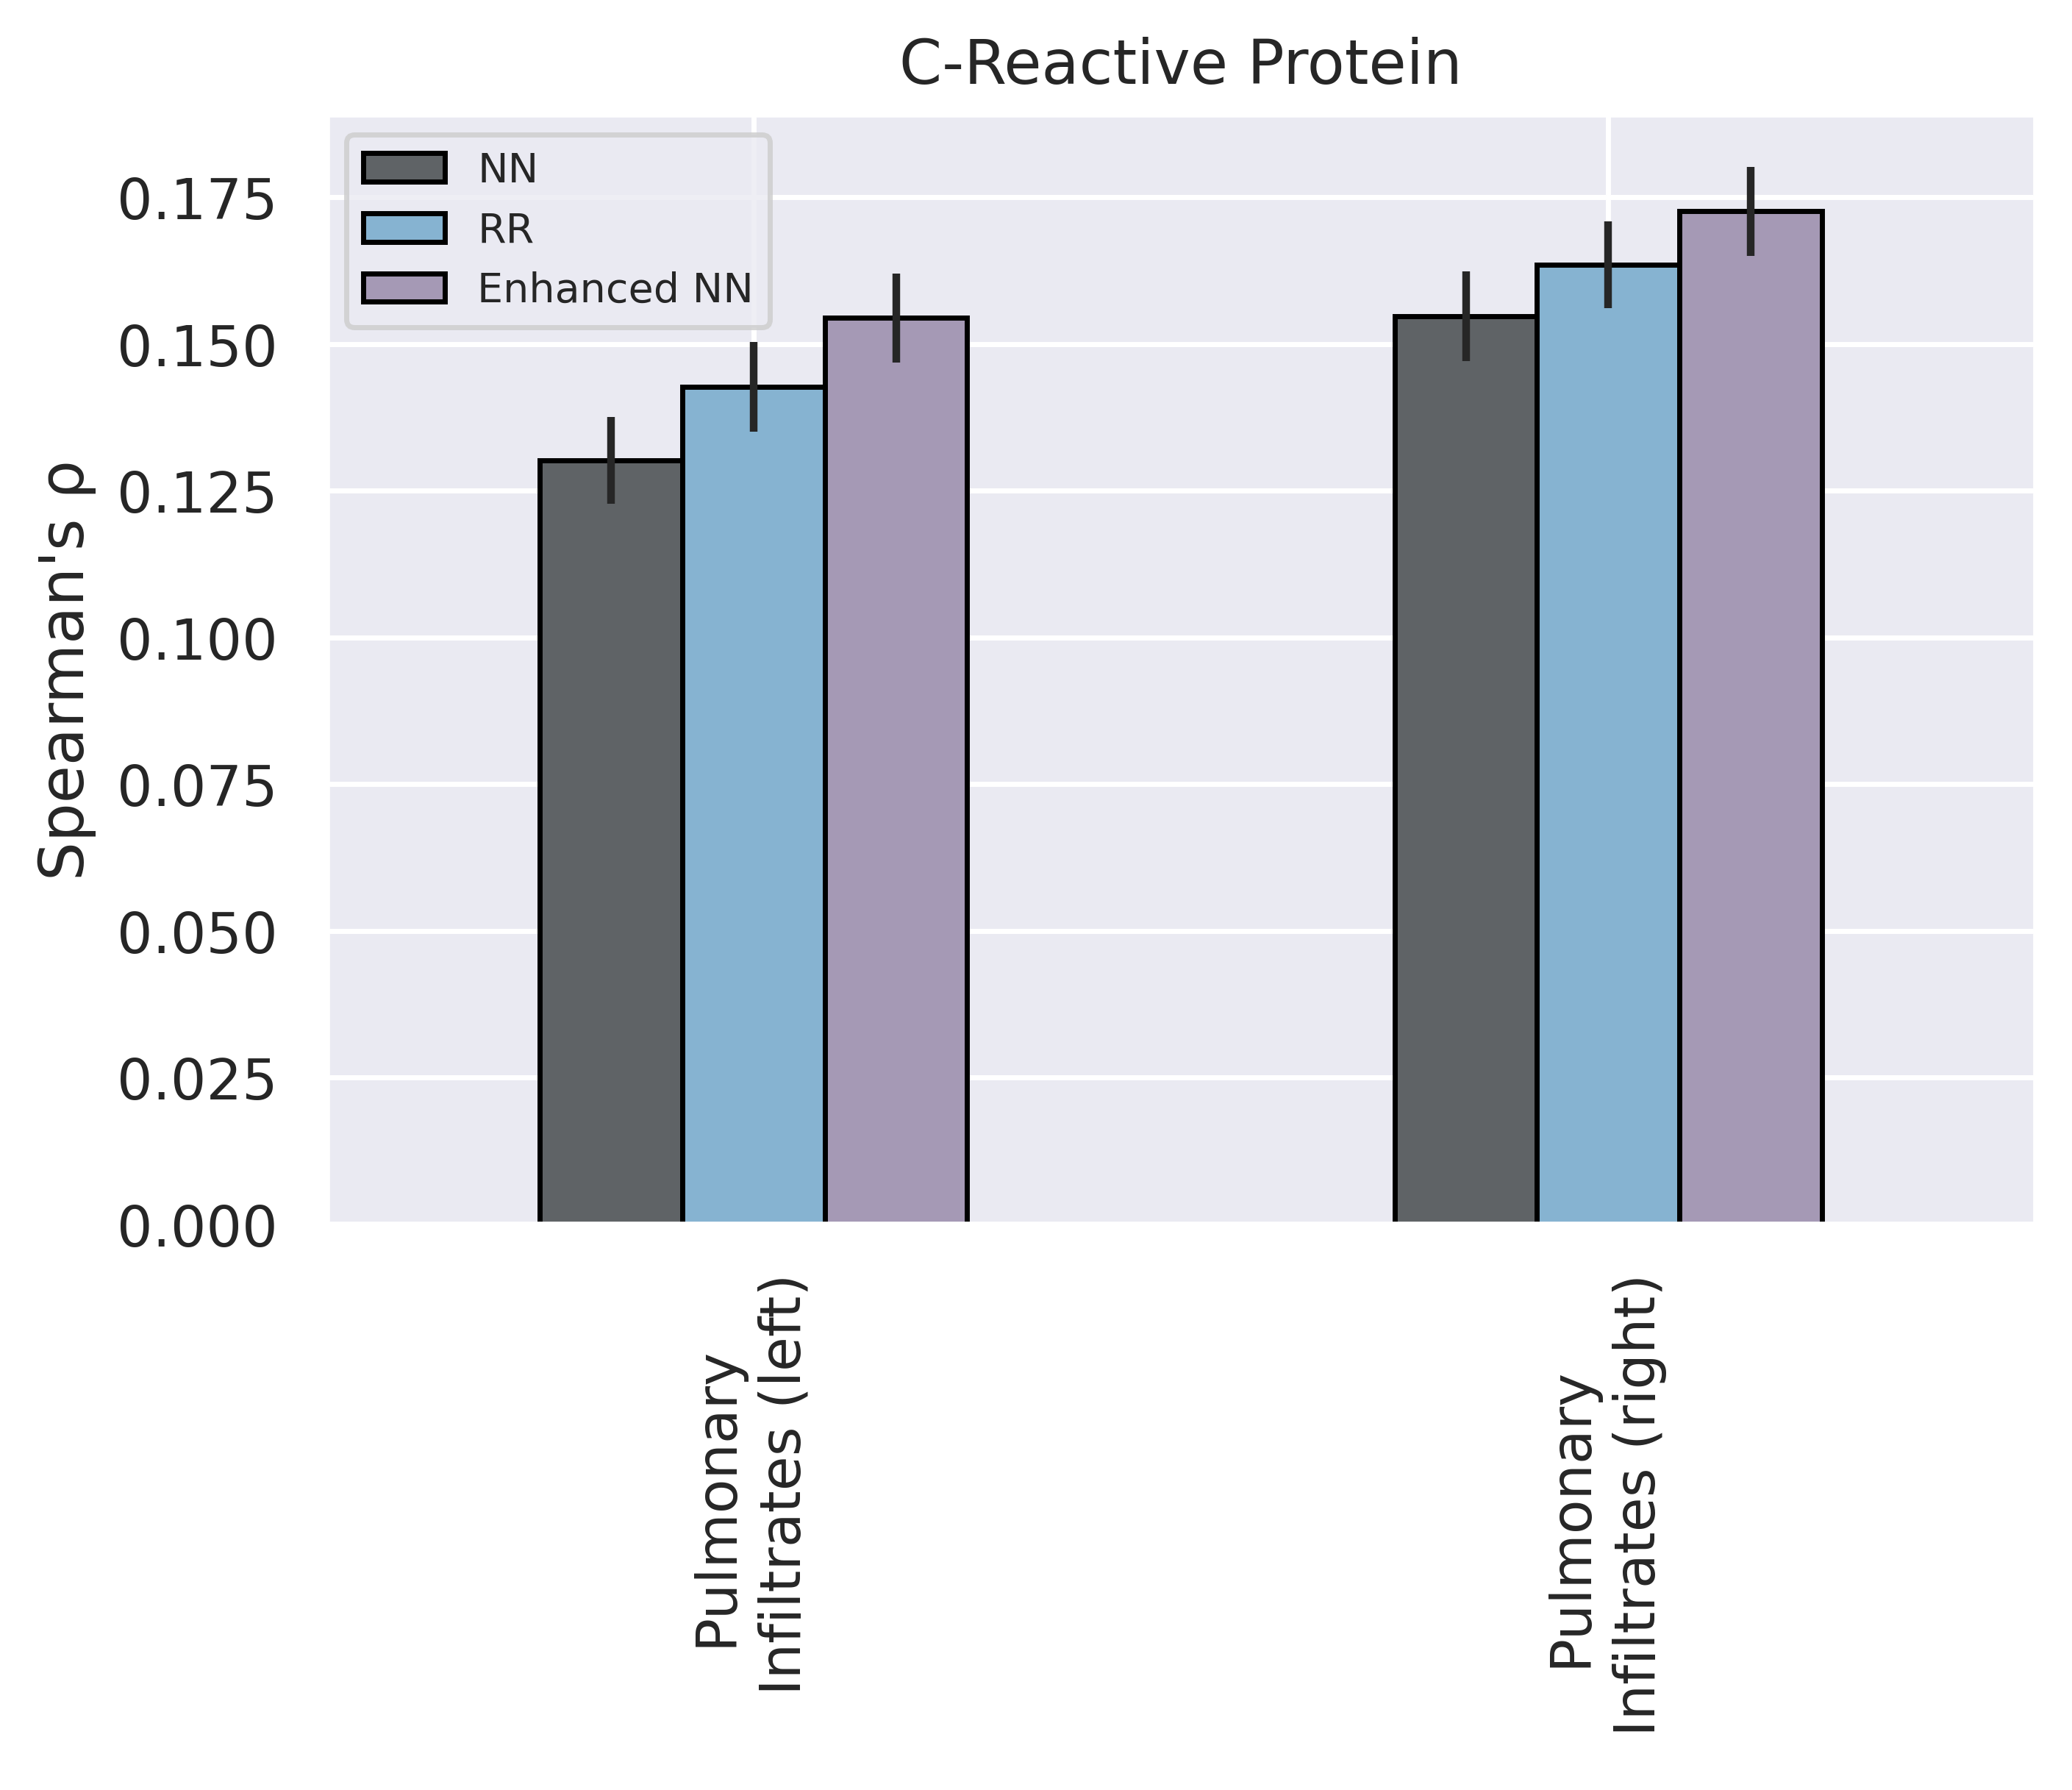

In [645]:
# Create combined plot
df_crp_spearman_weighted_crp_loss_copy = df_crp_spearman_weighted_crp_loss.copy()
df_crp_std_weighted_crp_loss_copy = df_crp_std_weighted_crp_loss.copy()

df_crp_spearman_weighted_crp_loss_copy = df_crp_spearman_weighted_crp_loss_copy.rename(columns={'NN': 'Enhanced NN'})
df_crp_std_weighted_crp_loss_copy = df_crp_std_weighted_crp_loss_copy.rename(columns={'NN': 'Enhanced NN'})

df_crp_std_weighted_crp_loss_copy = df_crp_std_weighted_crp_loss_copy.rename({'Infiltration (left)': 'Pulmonary Infiltrates (left)',
    'Infiltration (right)': 'Pulmonary Infiltrates (right)', 'Congestion': 'Pulmonary Congestion' })
df_crp_spearman_weighted_crp_loss_copy = df_crp_spearman_weighted_crp_loss_copy.rename({'Infiltration (left)': 'Pulmonary Infiltrates (left)',
    'Infiltration (right)': 'Pulmonary Infiltrates (right)', 'Congestion': 'Pulmonary Congestion' })

df_crp_spearman_weighted_crp_loss_copy_ = df_crp_spearman_weighted_crp_loss_copy.drop('Pulmonary Congestion')
df_crp_spearman_ = df_crp_spearman.drop('Pulmonary Congestion')

df_combined_spearman_crp = pd.concat([df_crp_spearman_, df_crp_spearman_weighted_crp_loss_copy_], axis=1)
df_combined_spearman_crp_std = pd.concat([df_crp_std, df_crp_std_weighted_crp_loss_copy], axis=1)

df_combined_spearman_crp_std_drop_duplicate = df_combined_spearman_crp_std.rename(columns = {'CR': 'RR'})
df_combined_spearman_crp_drop_duplicate = df_combined_spearman_crp.rename(columns = {'CR': 'RR'})

df_combined_spearman_crp_drop_duplicate = df_combined_spearman_crp_drop_duplicate.loc[:,~df_combined_spearman_crp_drop_duplicate.columns.duplicated()]
df_combined_spearman_crp_std_drop_duplicate = df_combined_spearman_crp_std_drop_duplicate.loc[:,~df_combined_spearman_crp_std_drop_duplicate.columns.duplicated()]


df_combined_spearman_crp_drop_duplicate_renamed = df_combined_spearman_crp_drop_duplicate.rename({
    'Pulmonary Infiltrates (left)': 'Pulmonary \n Infiltrates (left)',
    'Pulmonary Infiltrates (right)': 'Pulmonary \n Infiltrates (right)', 
})

df_combined_spearman_crp_std_drop_duplicate_renamed = df_combined_spearman_crp_std_drop_duplicate.rename({
    'Pulmonary Infiltrates (left)': 'Pulmonary \n Infiltrates (left)',
    'Pulmonary Infiltrates (right)': 'Pulmonary \n Infiltrates (right)', 
})

df_combined_spearman_crp_drop_duplicate_renamed.drop('ILO', inplace=True)
df_combined_spearman_crp_std_drop_duplicate_renamed.drop('ILO', inplace=True)

df_combined_spearman_crp_drop_duplicate_renamed.plot.bar(
        yerr=df_combined_spearman_crp_std_drop_duplicate_renamed, color=palette[0:2] + [palette[-1]], edgecolor="black"
        )

plt.title('C-Reactive Protein')
plt.ylabel("Spearman's ρ")
plt.legend(loc="upper left", prop={'size': 8})
#plt.xticks(rotation=45)
plt.gcf().set_dpi(500)
plt.show()

In [668]:
df_combined_spearman_crp_drop_duplicate_renamed

NN        RR Enhanced NN
Pulmonary \n Infiltrates (left)    0.13019  0.142735    0.154479
Pulmonary \n Infiltrates (right)  0.154721  0.163495    0.172628

##### BNP

In [248]:
# RANK CONSISTENCY

bnp_results = pd.DataFrame(columns=['Aufnahmenummer', 'ScanDatum', 'LabDatum', 'BNP', 'Pulmonary Congestion'])

bnp_results_dict = {'pred': {'rating': df_pred_sorted, 'results_after_24_hours': bnp_results.copy() , 'results_prior_24_hours': bnp_results.copy()},
               'gt': {'rating': df_gt_sorted, 'results_after_24_hours': bnp_results.copy() , 'results_prior_24_hours': bnp_results.copy()}           
             }
for _, rater in bnp_results_dict.items():
    unique_aufnahmenummern_bnp = df_lab_results_analytics_bnp['Aufnahmenummer'].unique()
    for aufnahmenummer in tqdm(unique_aufnahmenummern_bnp):
        # Go through every x-ray scan of a specific aufnahmenummer and find the nearest lab result
        lab_results_of_interest = df_lab_results_analytics_bnp[df_lab_results_analytics_bnp['Aufnahmenummer']==aufnahmenummer]
        for _, scan in rater['rating'][rater['rating']['Aufnahmenummer']==aufnahmenummer].iterrows():
            scans_prior = lab_results_of_interest.set_index('Datum').sort_index().loc[:scan['Untersuchungsdatum']]
            scan_prior = scans_prior.iloc[-1] if not scans_prior.empty else None
            scans_after = lab_results_of_interest.set_index('Datum').sort_index().loc[scan['Untersuchungsdatum']:]
            scan_after = scans_after.iloc[0] if not scans_after.empty else None

            # check if the scans are within 24 hours of scan
            if (scan_prior is not None) and ((scan['Untersuchungsdatum'] - scan_prior.name).days < 2):
                try:
                    lab_value = float(scan_prior['Wert_txt'])
                    rater['results_prior_24_hours'] = rater['results_prior_24_hours'].append({'BNP': lab_value, 
                                                       'Pulmonary Congestion': scan['Pulmonary Congestion'],                      
                                                       'ScanDatum': scan['Untersuchungsdatum'],
                                                       'LabDatum': scan_prior.name,
                                                       'Aufnahmenummer': aufnahmenummer,
                                                      }, ignore_index=True)
                except ValueError:
                    continue

            if (scan_after is not None) and ((scan_after.name - scan['Untersuchungsdatum']).days < 2):
                try:
                    lab_value = float(scan_after['Wert_txt'])  
                    rater['results_after_24_hours'] = rater['results_after_24_hours'].append({'BNP': lab_value, 
                                                   'Pulmonary Congestion': scan['Pulmonary Congestion'],
                                                   'ScanDatum': scan['Untersuchungsdatum'],
                                                   'LabDatum': scan_after.name, 
                                                   'Aufnahmenummer': aufnahmenummer,
                                                  }, ignore_index=True)
                except ValueError:
                    continue
                    
# drop nans and create rank
for rater in ['pred', 'gt']:
    for result in ['results_after_24_hours', 'results_prior_24_hours']:
        bnp_results_dict[rater][result] = bnp_results_dict[rater][result].dropna()
        bnp_results_rank = bnp_results_dict[rater][result].copy()
        bnp_results_rank['Pulmonary Congestion'] = bnp_results_rank['Pulmonary Congestion'].replace({'none':0, '(+)': 1, '+': 2, '++': 3, '+++': 4})
        bnp_results_dict[rater][result+'_rank'] = bnp_results_rank                

100%|██████████| 3072/3072 [00:29<00:00, 103.47it/s]


In [118]:
bnp_results = pd.DataFrame(columns=['Aufnahmenummer', 'ScanDatum', 'LabDatum', 'BNP', 'Pulmonary Congestion', 'Cardiomegaly', 'Pleural Effusion (right)', 'Pleural Effusion (left)'])

bnp_results_dict = {'pred': {'rating': df_pred_sorted, 'results_after_24_hours': bnp_results.copy() , 'results_prior_24_hours': bnp_results.copy()},
               'gt': {'rating': df_gt_sorted, 'results_after_24_hours': bnp_results.copy() , 'results_prior_24_hours': bnp_results.copy()}           
             }
for _, rater in bnp_results_dict.items():
    unique_aufnahmenummern_bnp = df_lab_results_analytics_bnp['Aufnahmenummer'].unique()
    for aufnahmenummer in tqdm(unique_aufnahmenummern_bnp):
        # Go through every x-ray scan of a specific aufnahmenummer and find the nearest lab result
        lab_results_of_interest = df_lab_results_analytics_bnp[df_lab_results_analytics_bnp['Aufnahmenummer']==aufnahmenummer]
        for _, scan in rater['rating'][rater['rating']['Aufnahmenummer']==aufnahmenummer].iterrows():
            scans_prior = lab_results_of_interest.set_index('Datum').sort_index().loc[:scan['Untersuchungsdatum']]
            scan_prior = scans_prior.iloc[-1] if not scans_prior.empty else None
            scans_after = lab_results_of_interest.set_index('Datum').sort_index().loc[scan['Untersuchungsdatum']:]
            scan_after = scans_after.iloc[0] if not scans_after.empty else None

            # check if the scans are within 24 hours of scan
            if (scan_prior is not None) and ((scan['Untersuchungsdatum'] - scan_prior.name).days < 2):
                try:
                    lab_value = float(scan_prior['Wert_txt'])
                    rater['results_prior_24_hours'] = rater['results_prior_24_hours'].append({'BNP': lab_value, 
                                                       'Pulmonary Congestion': scan['Pulmonary Congestion'],
                                                       'Cardiomegaly': scan['Cardiomegaly'],
                                                       'Pleural Effusion (right)': scan['Pleural Effusion (right)'],
                                                       'Pleural Effusion (left)': scan['Pleural Effusion (left)'],                                      
                                                       'ScanDatum': scan['Untersuchungsdatum'],
                                                       'LabDatum': scan_prior.name,
                                                       'Aufnahmenummer': aufnahmenummer,
                                                      }, ignore_index=True)
                except ValueError:
                    continue

            if (scan_after is not None) and ((scan_after.name - scan['Untersuchungsdatum']).days < 2):
                try:
                    lab_value = float(scan_after['Wert_txt'])  
                    rater['results_after_24_hours'] = rater['results_after_24_hours'].append({'BNP': lab_value, 
                                                   'Pulmonary Congestion': scan['Pulmonary Congestion'],
                                                   'Cardiomegaly': scan['Cardiomegaly'],
                                                   'Pleural Effusion (right)': scan['Pleural Effusion (right)'],
                                                   'Pleural Effusion (left)': scan['Pleural Effusion (left)'],  
                                                   'ScanDatum': scan['Untersuchungsdatum'],
                                                   'LabDatum': scan_after.name, 
                                                   'Aufnahmenummer': aufnahmenummer,
                                                  }, ignore_index=True)
                except ValueError:
                    continue
                    
# drop nans and create rank
for rater in ['pred', 'gt']:
    for result in ['results_after_24_hours', 'results_prior_24_hours']:
        bnp_results_dict[rater][result] = bnp_results_dict[rater][result].dropna()
        bnp_results_rank = bnp_results_dict[rater][result].copy()
        bnp_results_rank['Pulmonary Congestion'] = bnp_results_rank['Pulmonary Congestion'].replace({'none':0, '(+)': 1, '+': 2, '++': 3, '+++': 4})
        bnp_results_rank['Pleural Effusion (left)'] = bnp_results_rank['Pleural Effusion (left)'].replace({'none':0, '(+)': 1, '+': 2, '++': 3, '+++': 4})
        bnp_results_rank['Pleural Effusion (right)'] = bnp_results_rank['Pleural Effusion (right)'].replace({'none':0, '(+)': 1, '+': 2, '++': 3, '+++': 4})
        bnp_results_rank['Cardiomegaly'] = bnp_results_rank['Cardiomegaly'].replace({'not assessable':0, 'normal': 1, 'borderline': 2, 'enlarged': 3, 'massively enlarged': 4})
        bnp_results_dict[rater][result+'_rank'] = bnp_results_rank                

100%|██████████| 3072/3072 [00:34<00:00, 89.49it/s] 


------------------------
results_after_24_hours


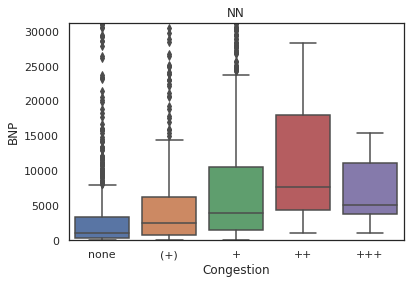

------------------------
results_after_24_hours


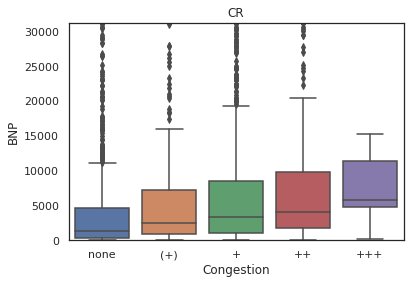

In [249]:
# RANK CONSISTENCY

for rater in ['pred', 'gt']:
    for result in ['results_after_24_hours']:#, 'results_prior_24_hours']:
        for label in ['Pulmonary Congestion']:
            if 'Cardiomegaly' in label:
                label_order = herzgröße_labels
            elif 'Pneumothorax' in label:
                label_order = pneumothorax_labels
            else:
                label_order = standard_labels
            ax = sns.boxplot(data=bnp_results_dict[rater][result], x=label, y='BNP', order=label_order)
            ax.set(ylim=(-5, bnp_results_dict[rater][result]['BNP'].quantile([0.95]).item()))
            print('------------------------')
            print(result)
            title = 'NN' if rater=='pred' else 'RR'
            plt.title(title)
            plt.show()

------------------------
results_after_24_hours


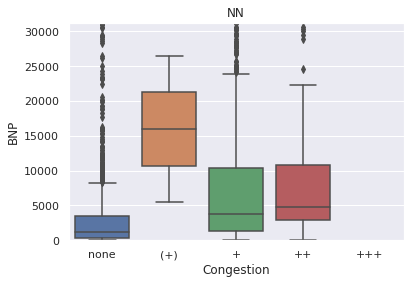

------------------------
results_after_24_hours


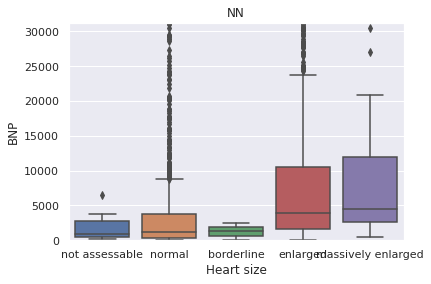

------------------------
results_after_24_hours


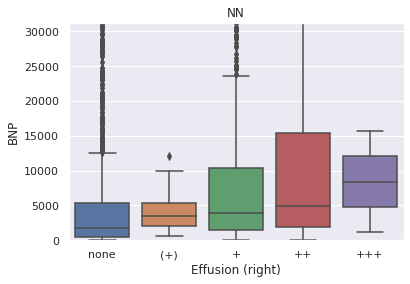

------------------------
results_after_24_hours


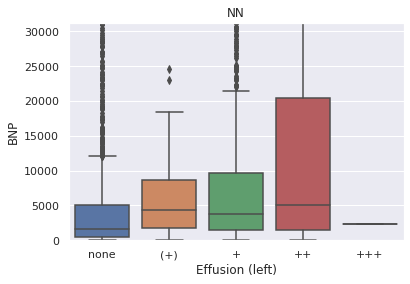

------------------------
results_after_24_hours


------------------------
results_after_24_hours


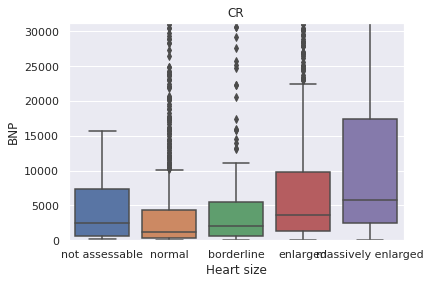

------------------------
results_after_24_hours


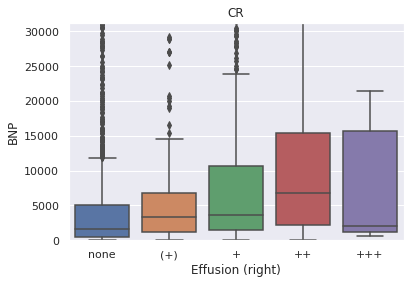

------------------------
results_after_24_hours


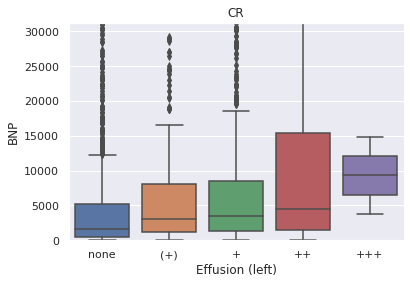

In [119]:
for rater in ['pred', 'gt']:
    for result in ['results_after_24_hours']:#, 'results_prior_24_hours']:
        for label in ['Pulmonary Congestion', 'Cardiomegaly', 'Pleural Effusion (right)', 'Pleural Effusion (left)']:
            if 'Cardiomegaly' in label:
                label_order = herzgröße_labels
            elif 'Pneumothorax' in label:
                label_order = pneumothorax_labels
            else:
                label_order = standard_labels
            ax = sns.boxplot(data=bnp_results_dict[rater][result], x=label, y='BNP', order=label_order)
            ax.set(ylim=(-5, bnp_results_dict[rater][result]['BNP'].quantile([0.95]).item()))
            print('------------------------')
            print(result)
            title = 'NN' if rater=='pred' else 'RR'
            plt.title(title)
            plt.show()

----------------------------------------
pred
------------------------
Congestion
Spearman pred:  SpearmanrResult(correlation=0.33799325064840363, pvalue=1.5574650358719778e-66)
Kendall pred:  KendalltauResult(correlation=0.26784241570652517, pvalue=2.100219481025329e-63)
----------------------------------------
gt
------------------------
Congestion
Spearman gt:  SpearmanrResult(correlation=0.24606591978607498, pvalue=4.0924921554734357e-35)
Kendall gt:  KendalltauResult(correlation=0.18929425142058925, pvalue=1.9473430711660706e-34)


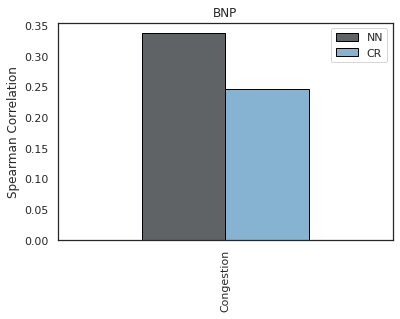

In [229]:
# RANK CONSISTENCY

df_bnp_spearman = pd.DataFrame(index=['Pulmonary Congestion'], columns=['NN', 'RR'])
for result in ['results_after_24_hours_rank']:
    for rater in ['pred', 'gt']:
        print('----------------------------------------')
        print(rater)
        for label in ['Pulmonary Congestion']:
            data = bnp_results_dict[rater][result][label]
            bnp = bnp_results_dict[rater][result]['BNP']
            print('------------------------')
            print(label)
            spearman_val = stats.spearmanr(data, bnp, nan_policy='raise')
            print(f'Spearman {rater}: ', spearman_val)
            print(f'Kendall {rater}: ', stats.kendalltau(data, bnp, nan_policy='raise'))
            col_name = 'NN' if rater == 'pred' else 'RR'
            df_bnp_spearman.loc[label][col_name] = spearman_val[0] 

df_bnp_spearman.plot.bar(color=palette, edgecolor="black")
plt.title('BNP')
plt.ylabel("Spearman Correlation")
plt.show()

In [120]:
df_bnp_spearman = pd.DataFrame(index=['Cardiomegaly', 'Pulmonary Congestion'], columns=['NN', 'RR'])
for result in ['results_after_24_hours_rank']:
    for rater in ['pred', 'gt']:
        print('----------------------------------------')
        print(rater)
        for label in ['Cardiomegaly', 'Pulmonary Congestion']:
            data = bnp_results_dict[rater][result][label]
            bnp = bnp_results_dict[rater][result]['BNP']
            print('------------------------')
            print(label)
            spearman_val = stats.spearmanr(data, bnp, nan_policy='raise')
            print(f'Spearman {rater}: ', spearman_val)
            print(f'Kendall {rater}: ', stats.kendalltau(data, bnp, nan_policy='raise'))
            col_name = 'NN' if rater == 'pred' else 'RR'
            df_bnp_spearman.loc[label][col_name] = spearman_val[0] 

df_bnp_spearman.plot.bar(color=palette, edgecolor="black")
plt.title('BNP')
plt.ylabel("Spearman Correlation")
plt.show()

----------------------------------------
pred
------------------------
Heart size
Spearman pred:  SpearmanrResult(correlation=0.36838513336577744, pvalue=1.2964381932861807e-79)
Kendall pred:  KendalltauResult(correlation=0.29705108427386645, pvalue=4.404979076156139e-74)
------------------------
Congestion
Spearman pred:  SpearmanrResult(correlation=0.34559935183914575, pvalue=1.1304093658155823e-69)
Kendall pred:  KendalltauResult(correlation=0.27754666146204265, pvalue=1.0718367354315163e-65)
----------------------------------------
gt
------------------------
Heart size
Spearman gt:  SpearmanrResult(correlation=0.29523385892027587, pvalue=1.8062928527633188e-50)
Kendall gt:  KendalltauResult(correlation=0.22987964981698317, pvalue=1.3791803545752108e-49)
------------------------
Congestion
Spearman gt:  SpearmanrResult(correlation=0.24606591978607498, pvalue=4.0924921554734357e-35)
Kendall gt:  KendalltauResult(correlation=0.18929425142058925, pvalue=1.9473430711660706e-34)


In [121]:
# Do bootstrapping here
df_bootstrapping_bnp = pd.DataFrame()
df_bootstrapping_bnp_pred = pd.DataFrame(columns=['Pulmonary Congestion', 'Cardiomegaly', 'Pleural Effusion (right)', 'Pleural Effusion (left)'])
df_bootstrapping_bnp_gt = pd.DataFrame()

for sample in tqdm(range(1000)):
    sample_results = {}
    for result in ['results_after_24_hours_rank', 'results_prior_24_hours_rank']:
        gt_bnp_results_sampled = bnp_results_dict['gt'][result].sample(n=len(bnp_results_dict['gt'][result]), replace=True, random_state=sample)
        pred_bnp_results_sampled = bnp_results_dict['pred'][result].sample(n=len(bnp_results_dict['pred'][result]), replace=True, random_state=sample)
        sample_results_pred = {}
        sample_results_gt = {}
        for label in ['Pulmonary Congestion', 'Cardiomegaly', 'Pleural Effusion (right)', 'Pleural Effusion (left)']:
            spearman_pred = stats.spearmanr(pred_bnp_results_sampled[label],pred_bnp_results_sampled['BNP'], 
                                                                          nan_policy='raise')[0]
            spearman_gt = stats.spearmanr(gt_bnp_results_sampled[label], gt_bnp_results_sampled['BNP'], 
                                                                          nan_policy='raise')[0]
            sample_results[f'{result}_{label}_spearman'] = spearman_pred - spearman_gt

            sample_results[f'{result}_{label}_kendall'] = stats.kendalltau(pred_bnp_results_sampled[label], 
                                                              pred_bnp_results_sampled['BNP'], 
                                                              nan_policy='raise')[0] - stats.kendalltau(gt_bnp_results_sampled[label], 
                                                              gt_bnp_results_sampled['BNP'], 
                                                              nan_policy='raise')[0]
            sample_results_pred[label] = spearman_pred
            sample_results_gt[label] = spearman_gt
        if result == 'results_after_24_hours_rank':
            df_bootstrapping_bnp_pred = df_bootstrapping_bnp_pred.append(sample_results_pred, ignore_index=True)
            df_bootstrapping_bnp_gt = df_bootstrapping_bnp_gt.append(sample_results_gt, ignore_index=True)

    df_bootstrapping_bnp = df_bootstrapping_bnp.append(sample_results, ignore_index=True)


100%|██████████| 1000/1000 [00:30<00:00, 33.00it/s]


In [122]:
df_bootstrapping_bnp.quantile([0.025, 0.05, 0.095, 0.975])

results_after_24_hours_rank_Congestion_kendall  \
0.025                                        0.060355   
0.050                                        0.064357   
0.095                                        0.068711   
0.975                                        0.117972   

       results_after_24_hours_rank_Congestion_spearman  \
0.025                                         0.064432   
0.050                                         0.068822   
0.095                                         0.074715   
0.975                                         0.137078   

       results_after_24_hours_rank_Effusion (left)_kendall  \
0.025                                           0.000331     
0.050                                           0.002606     
0.095                                           0.006487     
0.975                                           0.047296     

       results_after_24_hours_rank_Effusion (left)_spearman  \
0.025                                          -0.006060      
0.050                                          -0.002846      
0.095                                           0.001748      
0.975                                           0.053648      

       results_after_24_hours_rank_Effusion (right)_kendall  \
0.025                                          -0.029900      
0.050                                          -0.026333      
0.095                                          -0.022525      
0.975                                           0.011094      

       results_after_24_hours_rank_Effusion (right)_spearman  \
0.025                                          -0.043451       
0.050                                          -0.038567       
0.095                                          -0.034438       
0.975                                           0.008171       

       results_after_24_hours_rank_Heart size_kendall  \
0.025                                        0.038790   
0.050                                        0.043982   
0.095                                        0.049262   
0.975                                        0.096927   

       results_after_24_hours_rank_Heart size_spearman  \
0.025                                         0.037653   
0.050                                         0.043764   
0.095                                         0.050101   
0.975                                         0.110798   

       results_prior_24_hours_rank_Congestion_kendall  \
0.025                                        0.059851   
0.050                                        0.063084   
0.095                                        0.068956   
0.975                                        0.118896   

       results_prior_24_hours_rank_Congestion_spearman  \
0.025                                         0.064266   
0.050                                         0.068764   
0.095                                         0.076534   
0.975                                         0.139348   

       results_prior_24_hours_rank_Effusion (left)_kendall  \
0.025                                          -0.005514     
0.050                                          -0.002006     
0.095                                           0.002882     
0.975                                           0.048100     

       results_prior_24_hours_rank_Effusion (left)_spearman  \
0.025                                          -0.014772      
0.050                                          -0.009737      
0.095                                          -0.003234      
0.975                                           0.053911      

       results_prior_24_hours_rank_Effusion (right)_kendall  \
0.025                                          -0.020215      
0.050                                          -0.017703      
0.095                                          -0.014663      
0.975                                           0.020328      

       results_prior_24_hours_rank_Effusion (right)_spearman  \
0.025

In [129]:
# p-values BNP
num_heart_size_below_zero = len(df_bootstrapping_bnp['results_after_24_hours_rank_Heart size_spearman'][df_bootstrapping_bnp['results_after_24_hours_rank_Heart size_spearman']<0])
num_all = len(df_bootstrapping_bnp['results_after_24_hours_rank_Heart size_spearman'])
print('p-value (BNP, Heartsize): ', num_heart_size_below_zero / num_all)

num_congestion_below_zero = len(df_bootstrapping_bnp['results_after_24_hours_rank_Congestion_spearman'][df_bootstrapping_bnp['results_after_24_hours_rank_Congestion_spearman']<0])
num_all = len(df_bootstrapping_bnp['results_after_24_hours_rank_Congestion_spearman'])
print('p-value (BNP, Congestion): ', num_congestion_below_zero / num_all)

p-value (BNP, Heartsize):  0.0
p-value (BNP, Congestion):  0.0


In [135]:
# Create plots with error bars
df_bnp_std = pd.DataFrame(columns=['NN', 'RR'])
print('(NN) Std: \n\n', df_bootstrapping_bnp_pred.loc[:, ['Pulmonary Congestion', 'Cardiomegaly']].std())
print('------')
print('(NN) Quantile: \n\n', df_bootstrapping_bnp_pred.loc[:, ['Pulmonary Congestion', 'Cardiomegaly']].quantile([0.025, 0.975]))
print('---------------------')
print('(CR) Std: \n\n', df_bootstrapping_bnp_gt.loc[:, ['Pulmonary Congestion', 'Cardiomegaly']].std())
print('------')
print('(CR) Quantile: \n\n', df_bootstrapping_bnp_gt.loc[:, ['Pulmonary Congestion', 'Cardiomegaly']].quantile([0.025, 0.975]))

df_bnp_std.loc[:, 'NN'] = df_bootstrapping_bnp_pred.loc[:, ['Pulmonary Congestion', 'Cardiomegaly']].std()
df_bnp_std.loc[:, 'RR'] = df_bootstrapping_bnp_gt.loc[:, ['Pulmonary Congestion', 'Cardiomegaly']].std()
df_bnp_std

(NN) Std: 

 Congestion    0.017345
Heart size    0.016964
dtype: float64
------
(NN) Quantile: 

        Congestion  Heart size
0.025    0.313552    0.336008
0.975    0.379837    0.399348
---------------------
(CR) Std: 

 Congestion    0.019203
Heart size    0.019056
dtype: float64
------
(CR) Quantile: 

        Congestion  Heart size
0.025    0.208291    0.255384
0.975    0.279374    0.331235


NN        CR
Congestion  0.017345  0.019203
Heart size  0.016964  0.019056

In [124]:
df_bnp_spearman = pd.DataFrame(index=['Cardiomegaly', 'Pulmonary Congestion'], columns=['NN', 'RR'])
for result in ['results_after_24_hours_rank']:
    for rater in ['pred', 'gt']:
        print('----------------------------------------')
        print(rater)
        for label in ['Cardiomegaly', 'Pulmonary Congestion']:
            data = bnp_results_dict[rater][result][label]
            bnp = bnp_results_dict[rater][result]['BNP']
            print('------------------------')
            print(label)
            spearman_val = stats.spearmanr(data, bnp, nan_policy='raise')
            print(f'Spearman {rater}: ', spearman_val)
            print(f'Kendall {rater}: ', stats.kendalltau(data, bnp, nan_policy='raise'))
            col_name = 'NN' if rater == 'pred' else 'RR'
            df_bnp_spearman.loc[label][col_name] = spearman_val[0] 

df_bnp_spearman.plot.bar(yerr=df_bnp_std, color=palette, edgecolor="black")
plt.title('BNP')
plt.ylabel("Spearman Correlation")
plt.gcf().set_dpi(300)
plt.show()

----------------------------------------
pred
------------------------
Heart size
Spearman pred:  SpearmanrResult(correlation=0.36838513336577744, pvalue=1.2964381932861807e-79)
Kendall pred:  KendalltauResult(correlation=0.29705108427386645, pvalue=4.404979076156139e-74)
------------------------
Congestion
Spearman pred:  SpearmanrResult(correlation=0.34559935183914575, pvalue=1.1304093658155823e-69)
Kendall pred:  KendalltauResult(correlation=0.27754666146204265, pvalue=1.0718367354315163e-65)
----------------------------------------
gt
------------------------
Heart size
Spearman gt:  SpearmanrResult(correlation=0.29523385892027587, pvalue=1.8062928527633188e-50)
Kendall gt:  KendalltauResult(correlation=0.22987964981698317, pvalue=1.3791803545752108e-49)
------------------------
Congestion
Spearman gt:  SpearmanrResult(correlation=0.24606591978607498, pvalue=4.0924921554734357e-35)
Kendall gt:  KendalltauResult(correlation=0.18929425142058925, pvalue=1.9473430711660706e-34)


# Get Reader Agreement between ALL studies in the test set for NN and CR

In [ ]:
for label in columns_of_interest:
    challenger1 = df_pred_sorted
    challenger2 = df_gt_sorted
    cks = cohen_kappa_score(challenger1[label], challenger2[label])
            
    print('-------------------------------------------------------------------------------')
    print(f'{label}: ', cks)
